conda install -y numpy pandas matplotlib seaborn scikit-learn joblib opencv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import ast 

# Balance the movies to genre


In [40]:
N = 5000

In [54]:
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv("tmdb_5000_movies.csv")

# Convert the 'genres' column from JSON-like strings to actual lists
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract the first genre (or None if missing)
data["first_genre"] = data["genres"].apply(lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None)

print("‚úÖ Dataset loaded with shape:", data.shape)

# Drop rows without a genre
data = data.dropna(subset=["first_genre"])

# Count how many movies per genre
genre_counts = data["first_genre"].value_counts()

# Keep only genres with > 50 movies
valid_genres = genre_counts[genre_counts > 50].index.tolist()
filtered_data = data[data["first_genre"].isin(valid_genres)]

# Encode the genre labels
label_encoder = LabelEncoder()
filtered_data["genre_label"] = label_encoder.fit_transform(filtered_data["first_genre"])

# Save to CSV (optional)
filtered_data.to_csv("balanced_movies.csv", index=False)

# Print info
print(f"‚úÖ Final dataset has {len(filtered_data)} movies across {len(valid_genres)} genres")
print(filtered_data["first_genre"].value_counts())

‚úÖ Dataset loaded with shape: (4803, 21)
‚úÖ Final dataset has 4618 movies across 13 genres
first_genre
Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Name: count, dtype: int64


/var/folders/g3/x3j647bn42j_bpmd_9vl047w0000gn/T/ipykernel_33633/952023773.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["genre_label"] = label_encoder.fit_transform(filtered_data["first_genre"])


In [199]:
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv("tmdb_5000_movies.csv")

# Convert 'genres' column to Python lists
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract first genre or None
data["first_genre"] = data["genres"].apply(lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None)

# Drop rows with missing genres
data = data.dropna(subset=["first_genre"])

# Filter to genres with more than 50 examples
genre_counts = data["first_genre"].value_counts()
valid_genres = genre_counts[genre_counts > 50].index.tolist()
filtered_data = data[data["first_genre"].isin(valid_genres)]

# ‚úÖ Downsample dominant genres (e.g., 'Drama')
max_per_class = 100  # Adjust based on minority class sizes

balanced_list = []
for genre in valid_genres:
    genre_subset = filtered_data[filtered_data["first_genre"] == genre]
    sampled = genre_subset.sample(
        n=min(max_per_class, len(genre_subset)), 
        random_state=42
    )
    balanced_list.append(sampled)

balanced_data = pd.concat(balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

# Encode genre labels
label_encoder = LabelEncoder()
balanced_data["genre_label"] = label_encoder.fit_transform(balanced_data["first_genre"])

# Save (optional)
balanced_data.to_csv("balanced_movies_downsampled.csv", index=False)

# Info
print(f"‚úÖ Final balanced dataset has {len(balanced_data)} samples across {len(valid_genres)} genres")
print(balanced_data["first_genre"].value_counts())

‚úÖ Final balanced dataset has 1241 samples across 13 genres
first_genre
Romance            100
Drama              100
Action             100
Adventure          100
Thriller           100
Horror             100
Comedy             100
Fantasy            100
Crime              100
Animation          100
Science Fiction     96
Documentary         89
Family              56
Name: count, dtype: int64


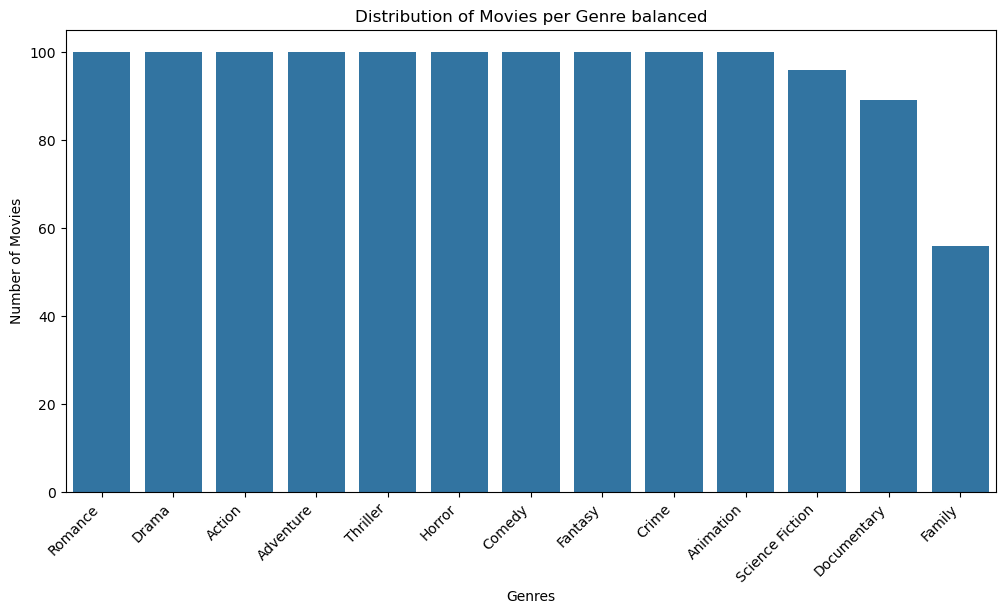

In [201]:
data = pd.read_csv("balanced_movies_downsampled.csv")

# Count the number of movies per genre
genre_counts = data["first_genre"].value_counts()

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies per Genre balanced")
plt.show()


In [202]:
import pandas as pd
import ast

# -------------------- Step 1: Load Data -------------------- #
data = pd.read_csv("balanced_movies_downsampled.csv")  # Load dataset

# Convert 'genres' column from string to a list of dictionaries
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract the first (primary) genre only
data["primary_genre"] = data["genres"].apply(
    lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None
)

# Drop rows with missing overview or missing primary genre
data = data.dropna(subset=["overview", "primary_genre"])

# Keep only relevant columns
columns_to_keep = ["id", "title", "overview", "primary_genre"]
data = data[columns_to_keep]

# Optionally: Limit number of movies
data = data.head(N)

# Print final dataset info
print(f"‚úÖ Final dataset contains {len(data)} movies")
print(data.head())

‚úÖ Final dataset contains 1238 movies
       id            title                                           overview  \
0   10288             Fido  Timmy Robinson's best friend in the whole wide...   
1   16323         The Rose  Midler is the rock-and-roll singer Mary Rose F...   
2   13197      10th & Wolf  A former street tough returns to his Philadelp...   
3     943  Lethal Weapon 3  Archetypal buddy cops Riggs and Murtaugh are b...   
4  366967      Dutch Kills  A desperate ex-con is forced to gather his old...   

  primary_genre  
0       Romance  
1         Drama  
2        Action  
3     Adventure  
4      Thriller  


In [203]:
# -------------------- Step 2: Text Feature Extraction -------------------- #
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = vectorizer.fit_transform(data['overview']).toarray()
print(f"‚úÖ X_text shape: {X_text.shape}")

‚úÖ X_text shape: (1238, 5000)


In [207]:
# -------------------- Step 3: Image Feature Extraction -------------------- #
# Load ResNet50 once (not in function to avoid reloading every time)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_image_features(img_path):
    """Extracts deep image features using ResNet50"""
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Load image
        img_array = image.img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match ResNet input
        img_array = preprocess_input(img_array)  # Apply ResNet preprocessing

        features = resnet.predict(img_array)  # Get ResNet features
        return features.flatten()  # Flatten to 1D array
    except Exception as e:
        print(f"‚ùå Error processing {img_path}: {e}")
        return np.zeros(2048)  # Return zero vector if error occurs

# Test with an **actual** existing image path
sample_img_path = "posters/5.jpg"  # Make sure this image exists!
print(f"‚úÖ Image features for '{sample_img_path}': {extract_image_features(sample_img_path).shape}")

# Load image features (assuming images are stored in 'posters/' folder)
image_paths = [f"posters/{id}.jpg" for id in data['id']]
X_image = np.array([extract_image_features(img) if os.path.exists(img) else np.zeros(2048) for img in image_paths])

print("‚úÖ Final image feature shape:", X_image.shape)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step
‚úÖ Image features for 'posters/5.jpg': (2048,)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 89ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 47ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 57ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 47ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 41ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [208]:
import joblib

# Save image features to disk
joblib.dump(X_image, "X_image_resnet50.pkl")

# (Optional) Save image IDs too
data['id'].to_csv("image_ids.csv", index=False)

In [209]:
print(data["primary_genre"].head())
print(data["primary_genre"].value_counts())


0      Romance
1        Drama
2       Action
3    Adventure
4     Thriller
Name: primary_genre, dtype: object
primary_genre
Romance            100
Action             100
Adventure          100
Thriller           100
Horror             100
Comedy             100
Fantasy            100
Crime              100
Animation          100
Drama               99
Science Fiction     96
Documentary         87
Family              56
Name: count, dtype: int64


## Label Encode Target


In [210]:
from sklearn.preprocessing import LabelEncoder

# Assume your original genre column is something like: 'primary_genre'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["primary_genre"])  # y will now be integer labels

## Train-Test Split


In [211]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, X_train_image, X_test_image, y_train, y_test = train_test_split(
    X_text, X_image, y, test_size=0.2, random_state=42
)

## Train Models


In [212]:
from sklearn.ensemble import RandomForestClassifier

# Apply class weighting to handle class imbalance
text_model = RandomForestClassifier(n_estimators=500, random_state=42)
text_model.fit(X_train_text, y_train)

image_model = RandomForestClassifier(n_estimators=500, random_state=42)
image_model.fit(X_train_image, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [213]:
import joblib

# Save the model
joblib.dump(text_model, 'text_model.pkl')
joblib.dump(image_model, 'image_model.pkl')

['image_model.pkl']

In [214]:
# Load it later
text_model = joblib.load('text_model.pkl')
image_model = joblib.load('image_model.pkl')

## Predict Probabilities and Fuse


In [215]:
# Predict probabilities
probs_text = text_model.predict_proba(X_test_text)   # shape: (n_samples, n_classes)
probs_image = image_model.predict_proba(X_test_image)

# Fuse by averaging
fused_probs = (probs_text + probs_image) / 2
fused_preds = np.argmax(fused_probs, axis=1)

# Individual predictions
y_pred_text = np.argmax(probs_text, axis=1)
y_pred_image = np.argmax(probs_image, axis=1)

## Evaluation


In [217]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("\nüìä Text Model")
print("Accuracy:", accuracy_score(y_test, y_pred_text))
print("F1 (macro):", f1_score(y_test, y_pred_text, average='macro'))

print("\nüìä Image Model")
print("Accuracy:", accuracy_score(y_test, y_pred_image))
print("F1 (macro):", f1_score(y_test, y_pred_image, average='macro'))

print("\nüìä Fused Model")
print("Accuracy:", accuracy_score(y_test, fused_preds))
print("F1 (macro):", f1_score(y_test, fused_preds, average='macro'))

# Optional: detailed report
print(classification_report(y_test, fused_preds, target_names=label_encoder.classes_))



üìä Text Model
Accuracy: 0.27419354838709675
F1 (macro): 0.26182411320967264

üìä Image Model
Accuracy: 0.2701612903225806
F1 (macro): 0.2257146479322407

üìä Fused Model
Accuracy: 0.34274193548387094
F1 (macro): 0.3163791655121003
                 precision    recall  f1-score   support

         Action       0.40      0.32      0.35        19
      Adventure       0.33      0.40      0.36        15
      Animation       0.57      0.61      0.59        28
         Comedy       0.26      0.47      0.34        19
          Crime       0.48      0.45      0.47        22
    Documentary       0.85      0.55      0.67        20
          Drama       0.16      0.12      0.14        24
         Family       0.00      0.00      0.00         7
        Fantasy       0.27      0.17      0.21        18
         Horror       0.29      0.32      0.30        19
        Romance       0.26      0.25      0.26        20
Science Fiction       0.32      0.35      0.33        20
       Thriller       

In [218]:
print(classification_report(y_test, y_pred_text, target_names=label_encoder.classes_))


                 precision    recall  f1-score   support

         Action       0.36      0.21      0.27        19
      Adventure       0.36      0.33      0.34        15
      Animation       0.27      0.21      0.24        28
         Comedy       0.17      0.37      0.23        19
          Crime       0.42      0.45      0.43        22
    Documentary       0.80      0.60      0.69        20
          Drama       0.13      0.08      0.10        24
         Family       0.00      0.00      0.00         7
        Fantasy       0.20      0.11      0.14        18
         Horror       0.35      0.37      0.36        19
        Romance       0.23      0.30      0.26        20
Science Fiction       0.26      0.30      0.28        20
       Thriller       0.05      0.06      0.05        17

       accuracy                           0.27       248
      macro avg       0.28      0.26      0.26       248
   weighted avg       0.29      0.27      0.28       248



In [219]:
print(classification_report(y_test, y_pred_image, target_names=label_encoder.classes_))

                 precision    recall  f1-score   support

         Action       0.26      0.26      0.26        19
      Adventure       0.20      0.33      0.25        15
      Animation       0.58      0.75      0.66        28
         Comedy       0.30      0.47      0.37        19
          Crime       0.29      0.09      0.14        22
    Documentary       0.44      0.20      0.28        20
          Drama       0.08      0.04      0.05        24
         Family       0.00      0.00      0.00         7
        Fantasy       0.11      0.06      0.07        18
         Horror       0.21      0.37      0.26        19
        Romance       0.19      0.20      0.20        20
Science Fiction       0.25      0.25      0.25        20
       Thriller       0.12      0.18      0.15        17

       accuracy                           0.27       248
      macro avg       0.23      0.25      0.23       248
   weighted avg       0.26      0.27      0.25       248



# Visualization


In [167]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
conf_matrix_img = confusion_matrix(y_test, y_pred_image)
conf_matrix_text = confusion_matrix(y_test, y_pred_text)
conf_matrix_fused = confusion_matrix(y_test, fused_preds)

In [ ]:
print(conf_matrix_text.shape)
print(conf_matrix_img.shape)
print(conf_matrix_fused.shape)

(13, 13)
(13, 13)
(13, 13)


In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_conf_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

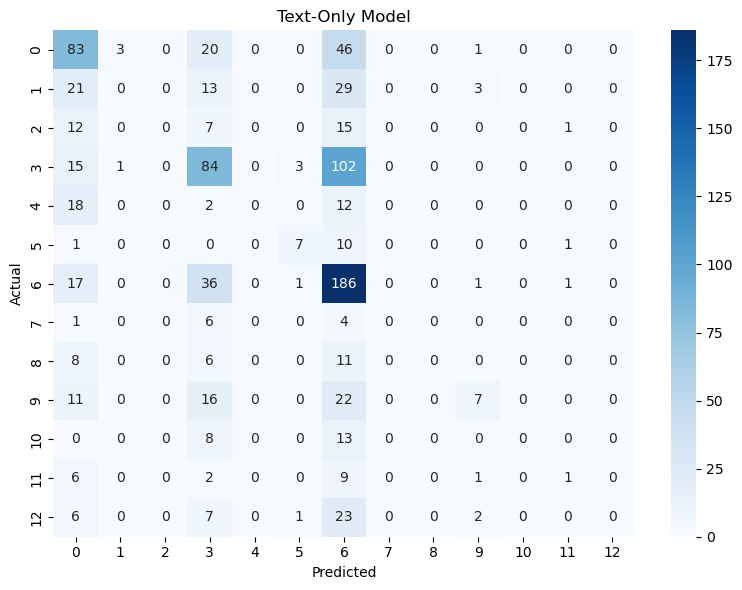

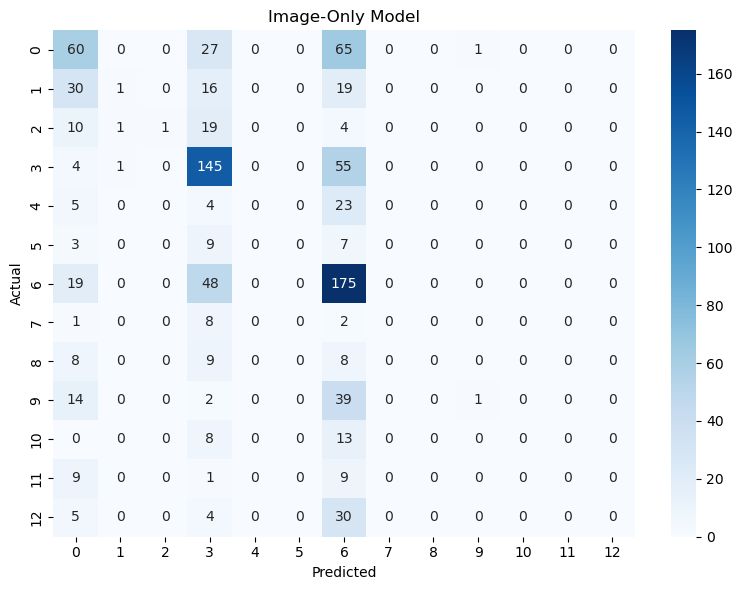

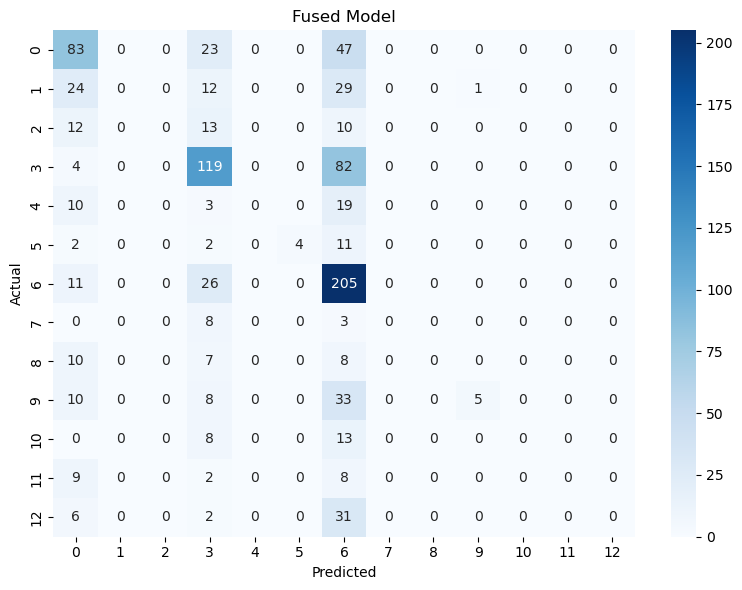

In [145]:
class_names = label_encoder.classes_  # Or a list like ["Drama", "Action", "Comedy", ...]
plot_conf_matrix(y_test, y_pred_text, class_names, title="Text-Only Model")
plot_conf_matrix(y_test, y_pred_image, class_names, title="Image-Only Model")
plot_conf_matrix(y_test, fused_preds, class_names, title="Fused Model")

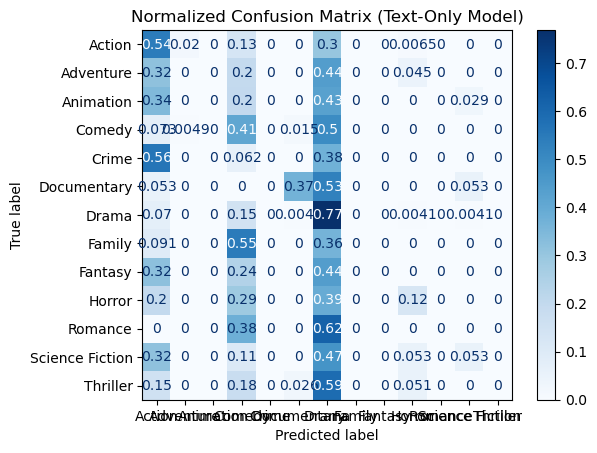

In [146]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_text,
    display_labels=class_names,
    cmap="Blues",
    normalize="true"
)
plt.title("Normalized Confusion Matrix (Text-Only Model)")
plt.show()

In [182]:
# Filter out predictions where predicted label == 0
mask = y_pred_text != 0  # or y_pred_image / fused_preds depending on model

# Apply the mask
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_text[mask]

# Now you can evaluate or visualize:
print("Filtered accuracy:", accuracy_score(y_test_filtered, y_pred_filtered))
print("Filtered F1 Score:", f1_score(y_test_filtered, y_pred_filtered, average='macro'))

Filtered accuracy: 0.393646408839779
Filtered F1 Score: 0.13592213575034645


In [ ]:
print(conf_matrix_text.shape)
print(conf_matrix_img.shape)
print(conf_matrix_fused.shape)
conf_matrix_text = confusion_matrix(y_test_filtered, y_pred_filtered)
print("Filtered Confusion Matrix Shape:", conf_matrix_text.shape)
print(conf_matrix_text)


(13, 13)
(13, 13)
(13, 13)
Filtered Confusion Matrix Shape: (13, 13)
[[  0   3   0  20   0   0  46   0   0   1   0   0   0]
 [  0   0   0  13   0   0  29   0   0   3   0   0   0]
 [  0   0   0   7   0   0  15   0   0   0   0   1   0]
 [  0   1   0  84   0   3 102   0   0   0   0   0   0]
 [  0   0   0   2   0   0  12   0   0   0   0   0   0]
 [  0   0   0   0   0   7  10   0   0   0   0   1   0]
 [  0   0   0  36   0   1 186   0   0   1   0   1   0]
 [  0   0   0   6   0   0   4   0   0   0   0   0   0]
 [  0   0   0   6   0   0  11   0   0   0   0   0   0]
 [  0   0   0  16   0   0  22   0   0   7   0   0   0]
 [  0   0   0   8   0   0  13   0   0   0   0   0   0]
 [  0   0   0   2   0   0   9   0   0   1   0   1   0]
 [  0   0   0   7   0   1  23   0   0   2   0   0   0]]


/var/folders/g3/x3j647bn42j_bpmd_9vl047w0000gn/T/ipykernel_33633/2878023586.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/envs/CCN/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


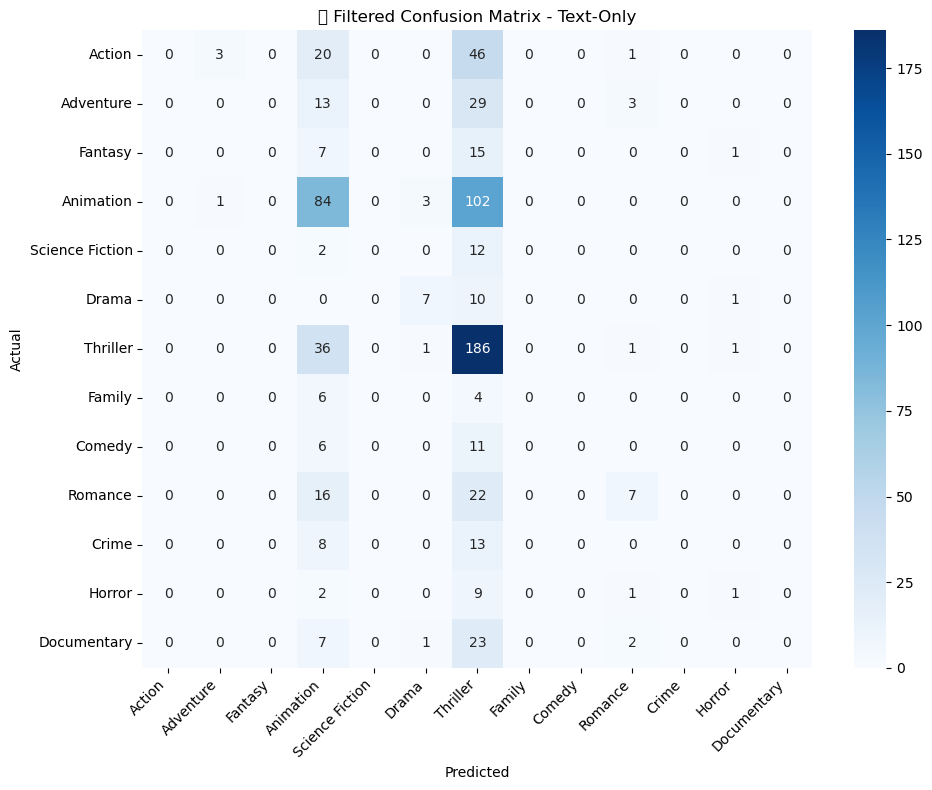

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define genres
all_genres = data['primary_genre'].unique()
n_genres = len(all_genres)
import numpy as np

# Get row and column sums
row_sums = conf_matrix_text.sum(axis=1)
col_sums = conf_matrix_text.sum(axis=0)

# Keep indices where either row or column has > 0 total
keep_indices = np.where((row_sums | col_sums) > 0)[0]

# Filter the confusion matrix and genre labels
filtered_cm = conf_matrix_text[np.ix_(keep_indices, keep_indices)]
filtered_labels = [all_genres[i] for i in keep_indices]

# Compute confusion matrix (single matrix for all classes)
conf_matrix_text = confusion_matrix(y_test_filtered, y_pred_filtered) 
#conf_matrix_img = confusion_matrix(y_test, y_pred_image, labels=range(n_genres))
#conf_matrix_fused = confusion_matrix(y_test, fused_preds, labels=range(n_genres))


import matplotlib.pyplot as plt
import seaborn as sns

def plot_filtered_conf_matrix(cm, labels, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"üìä Filtered Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_filtered_conf_matrix(filtered_cm, filtered_labels, "Text-Only")

#plot_conf_matrix(conf_matrix_text, "Text-Only")
#plot_conf_matrix(conf_matrix_img, "Image-Only")
#plot_conf_matrix(conf_matrix_fused, "Text+Image (Fused)")

y_test shape: (923,)
fused_preds shape: (923,)
F1 Score (Macro): 0.1617544412134566
Jaccard Score (Macro): 0.10649433413769249


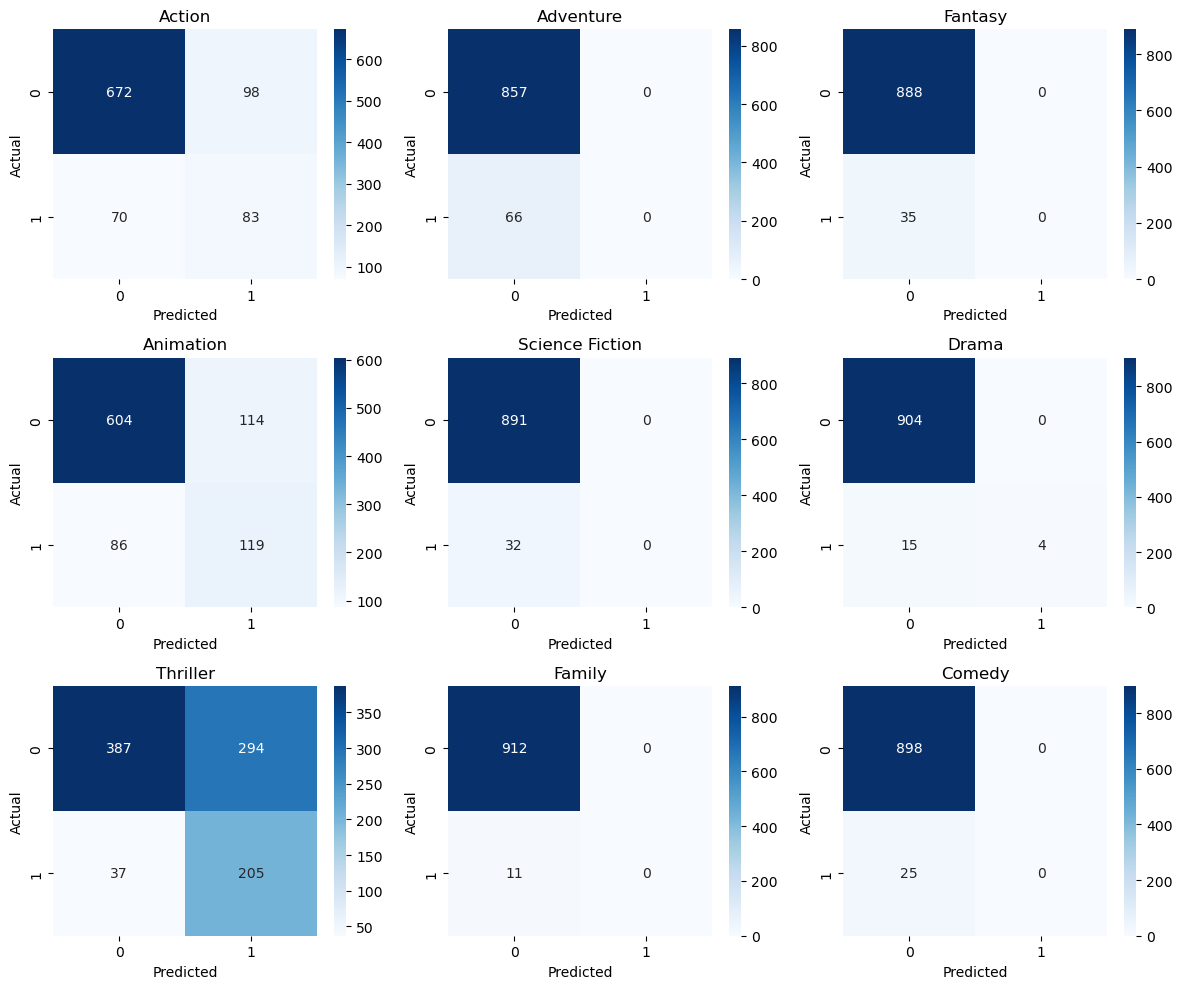

['tfidf_vectorizer.pkl']

In [187]:
# -------------------- Step 6: Evaluation -------------------- #
print("y_test shape:", y_test.shape)
print("fused_preds shape:", fused_preds.shape)

print("F1 Score (Macro):", f1_score(y_test, fused_preds, average='macro'))
print("Jaccard Score (Macro):", jaccard_score(y_test, fused_preds, average='macro'))

# Plot Confusion Matrix
conf_matrix = multilabel_confusion_matrix(y_test, fused_preds)
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # Adjust grid size for genres
for i, (ax, genre) in enumerate(zip(axes.ravel(), all_genres)):
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(genre)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# Save models
joblib.dump(text_model, "text_model.pkl")
joblib.dump(image_model, "image_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


# Script to download Posters


In [9]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from PIL import Image
from io import BytesIO

# üîπ Replace with your actual TMDb API key
TMDB_API_KEY = "76709f6c4b16101da7ce2bee6be5b74c"

# üîπ Read the movie dataset (ensure it contains a 'title' column)
data = pd.read_csv("tmdb_5000_movies.csv")

# üîπ Directory to save posters
POSTER_DIR = "posters"
os.makedirs(POSTER_DIR, exist_ok=True)

# üîπ Function to get the poster URL from TMDb
def get_poster_url(movie_title):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_API_KEY}&query={movie_title}"
    response = requests.get(url).json()
    
    if response["results"]:
        poster_path = response["results"][0].get("poster_path", None)
        if poster_path:
            return f"https://image.tmdb.org/t/p/w500{poster_path}"  # w500 = medium resolution
    return None  # No poster found

# üîπ Function to download and save the poster
def download_poster(movie_id, movie_title):
    poster_url = get_poster_url(movie_title)
    if poster_url:
        response = requests.get(poster_url)
        image = Image.open(BytesIO(response.content))
        image_path = os.path.join(POSTER_DIR, f"{movie_id}.jpg")  # Save as movie_id.jpg
        image.save(image_path)
        return True
    return False

# üîπ Loop through the dataset and download posters
for _, row in tqdm(data.iterrows(), total=len(data)):
    movie_id, title = row["id"], row["title"]
    success = download_poster(movie_id, title)
    if success:
        print(f"‚úÖ Downloaded: {title}")
    else:
        print(f"‚ùå No poster found: {title}")

print("üé¨ All posters downloaded successfully!")

  0%|          | 1/4803 [00:00<56:54,  1.41it/s]

‚úÖ Downloaded: Avatar


  0%|          | 2/4803 [00:01<39:52,  2.01it/s]

‚úÖ Downloaded: Pirates of the Caribbean: At World's End


  0%|          | 3/4803 [00:01<34:33,  2.31it/s]

‚úÖ Downloaded: Spectre


  0%|          | 4/4803 [00:01<33:39,  2.38it/s]

‚úÖ Downloaded: The Dark Knight Rises


  0%|          | 5/4803 [00:02<30:18,  2.64it/s]

‚úÖ Downloaded: John Carter


  0%|          | 6/4803 [00:02<29:34,  2.70it/s]

‚úÖ Downloaded: Spider-Man 3


  0%|          | 7/4803 [00:02<28:39,  2.79it/s]

‚úÖ Downloaded: Tangled


  0%|          | 8/4803 [00:03<27:57,  2.86it/s]

‚úÖ Downloaded: Avengers: Age of Ultron


  0%|          | 9/4803 [00:03<28:00,  2.85it/s]

‚úÖ Downloaded: Harry Potter and the Half-Blood Prince


  0%|          | 10/4803 [00:03<27:39,  2.89it/s]

‚úÖ Downloaded: Batman v Superman: Dawn of Justice


  0%|          | 11/4803 [00:04<27:22,  2.92it/s]

‚úÖ Downloaded: Superman Returns


  0%|          | 12/4803 [00:04<29:02,  2.75it/s]

‚úÖ Downloaded: Quantum of Solace


  0%|          | 13/4803 [00:04<28:31,  2.80it/s]

‚úÖ Downloaded: Pirates of the Caribbean: Dead Man's Chest


  0%|          | 14/4803 [00:05<28:08,  2.84it/s]

‚úÖ Downloaded: The Lone Ranger


  0%|          | 15/4803 [00:05<27:23,  2.91it/s]

‚úÖ Downloaded: Man of Steel


  0%|          | 16/4803 [00:05<27:07,  2.94it/s]

‚úÖ Downloaded: The Chronicles of Narnia: Prince Caspian


  0%|          | 17/4803 [00:06<27:14,  2.93it/s]

‚úÖ Downloaded: The Avengers


  0%|          | 18/4803 [00:06<27:28,  2.90it/s]

‚úÖ Downloaded: Pirates of the Caribbean: On Stranger Tides


  0%|          | 19/4803 [00:06<27:09,  2.94it/s]

‚úÖ Downloaded: Men in Black 3


  0%|          | 20/4803 [00:07<27:12,  2.93it/s]

‚úÖ Downloaded: The Hobbit: The Battle of the Five Armies


  0%|          | 21/4803 [00:07<27:07,  2.94it/s]

‚úÖ Downloaded: The Amazing Spider-Man


  0%|          | 22/4803 [00:07<27:01,  2.95it/s]

‚úÖ Downloaded: Robin Hood


  0%|          | 23/4803 [00:08<26:51,  2.97it/s]

‚úÖ Downloaded: The Hobbit: The Desolation of Smaug


  0%|          | 24/4803 [00:08<27:03,  2.94it/s]

‚úÖ Downloaded: The Golden Compass


  1%|          | 25/4803 [00:08<27:25,  2.90it/s]

‚úÖ Downloaded: King Kong


  1%|          | 26/4803 [00:09<27:24,  2.91it/s]

‚úÖ Downloaded: Titanic


  1%|          | 27/4803 [00:09<28:07,  2.83it/s]

‚úÖ Downloaded: Captain America: Civil War


  1%|          | 28/4803 [00:10<28:29,  2.79it/s]

‚úÖ Downloaded: Battleship


  1%|          | 29/4803 [00:10<27:53,  2.85it/s]

‚úÖ Downloaded: Jurassic World


  1%|          | 30/4803 [00:10<26:51,  2.96it/s]

‚úÖ Downloaded: Skyfall


  1%|          | 31/4803 [00:11<26:44,  2.97it/s]

‚úÖ Downloaded: Spider-Man 2


  1%|          | 32/4803 [00:11<26:54,  2.95it/s]

‚úÖ Downloaded: Iron Man 3


  1%|          | 33/4803 [00:11<27:42,  2.87it/s]

‚úÖ Downloaded: Alice in Wonderland


  1%|          | 34/4803 [00:12<26:53,  2.96it/s]

‚úÖ Downloaded: X-Men: The Last Stand


  1%|          | 35/4803 [00:12<26:40,  2.98it/s]

‚úÖ Downloaded: Monsters University


  1%|          | 36/4803 [00:12<26:44,  2.97it/s]

‚úÖ Downloaded: Transformers: Revenge of the Fallen


  1%|          | 37/4803 [00:13<27:03,  2.94it/s]

‚úÖ Downloaded: Transformers: Age of Extinction


  1%|          | 38/4803 [00:13<27:43,  2.86it/s]

‚úÖ Downloaded: Oz: The Great and Powerful


  1%|          | 39/4803 [00:13<28:13,  2.81it/s]

‚úÖ Downloaded: The Amazing Spider-Man 2


  1%|          | 40/4803 [00:14<28:11,  2.82it/s]

‚úÖ Downloaded: TRON: Legacy


  1%|          | 41/4803 [00:14<27:45,  2.86it/s]

‚úÖ Downloaded: Cars 2


  1%|          | 42/4803 [00:14<27:12,  2.92it/s]

‚úÖ Downloaded: Green Lantern


  1%|          | 43/4803 [00:15<27:02,  2.93it/s]

‚úÖ Downloaded: Toy Story 3


  1%|          | 44/4803 [00:15<26:50,  2.96it/s]

‚úÖ Downloaded: Terminator Salvation


  1%|          | 45/4803 [00:15<26:17,  3.02it/s]

‚úÖ Downloaded: Furious 7


  1%|          | 46/4803 [00:16<27:38,  2.87it/s]

‚úÖ Downloaded: World War Z


  1%|          | 47/4803 [00:16<28:00,  2.83it/s]

‚úÖ Downloaded: X-Men: Days of Future Past


  1%|          | 48/4803 [00:16<28:38,  2.77it/s]

‚úÖ Downloaded: Star Trek Into Darkness


  1%|          | 49/4803 [00:17<27:50,  2.85it/s]

‚úÖ Downloaded: Jack the Giant Slayer


  1%|          | 50/4803 [00:17<27:25,  2.89it/s]

‚úÖ Downloaded: The Great Gatsby


  1%|          | 51/4803 [00:17<27:14,  2.91it/s]

‚úÖ Downloaded: Prince of Persia: The Sands of Time


  1%|          | 52/4803 [00:18<26:53,  2.94it/s]

‚úÖ Downloaded: Pacific Rim


  1%|          | 53/4803 [00:18<26:35,  2.98it/s]

‚úÖ Downloaded: Transformers: Dark of the Moon


  1%|          | 54/4803 [00:18<26:54,  2.94it/s]

‚úÖ Downloaded: Indiana Jones and the Kingdom of the Crystal Skull


  1%|          | 55/4803 [00:19<26:46,  2.96it/s]

‚úÖ Downloaded: The Good Dinosaur


  1%|          | 56/4803 [00:19<27:19,  2.89it/s]

‚úÖ Downloaded: Brave


  1%|          | 57/4803 [00:20<27:28,  2.88it/s]

‚úÖ Downloaded: Star Trek Beyond


  1%|          | 58/4803 [00:27<3:18:43,  2.51s/it]

‚úÖ Downloaded: WALL¬∑E


  1%|          | 59/4803 [00:27<2:27:29,  1.87s/it]

‚úÖ Downloaded: Rush Hour 3


  1%|          | 60/4803 [00:28<1:51:25,  1.41s/it]

‚úÖ Downloaded: 2012


  1%|‚ñè         | 61/4803 [00:28<1:31:59,  1.16s/it]

‚úÖ Downloaded: A Christmas Carol


  1%|‚ñè         | 62/4803 [00:29<1:11:51,  1.10it/s]

‚úÖ Downloaded: Jupiter Ascending


  1%|‚ñè         | 63/4803 [00:29<58:00,  1.36it/s]  

‚úÖ Downloaded: The Legend of Tarzan


  1%|‚ñè         | 64/4803 [00:29<48:41,  1.62it/s]

‚úÖ Downloaded: The Chronicles of Narnia: The Lion, the Witch and the Wardrobe


  1%|‚ñè         | 65/4803 [00:30<41:53,  1.89it/s]

‚úÖ Downloaded: X-Men: Apocalypse


  1%|‚ñè         | 66/4803 [00:30<37:38,  2.10it/s]

‚úÖ Downloaded: The Dark Knight


  1%|‚ñè         | 67/4803 [00:30<33:34,  2.35it/s]

‚úÖ Downloaded: Up


  1%|‚ñè         | 68/4803 [00:31<31:18,  2.52it/s]

‚úÖ Downloaded: Monsters vs Aliens


  1%|‚ñè         | 69/4803 [00:31<29:13,  2.70it/s]

‚úÖ Downloaded: Iron Man


  1%|‚ñè         | 70/4803 [00:31<28:43,  2.75it/s]

‚úÖ Downloaded: Hugo


  1%|‚ñè         | 71/4803 [00:32<28:42,  2.75it/s]

‚úÖ Downloaded: Wild Wild West


  1%|‚ñè         | 72/4803 [00:32<28:23,  2.78it/s]

‚úÖ Downloaded: The Mummy: Tomb of the Dragon Emperor


  2%|‚ñè         | 73/4803 [00:32<28:15,  2.79it/s]

‚úÖ Downloaded: Suicide Squad


  2%|‚ñè         | 74/4803 [00:33<28:06,  2.80it/s]

‚úÖ Downloaded: Evan Almighty


  2%|‚ñè         | 75/4803 [00:33<27:57,  2.82it/s]

‚úÖ Downloaded: Edge of Tomorrow


  2%|‚ñè         | 76/4803 [00:33<27:38,  2.85it/s]

‚úÖ Downloaded: Waterworld


  2%|‚ñè         | 77/4803 [00:34<27:52,  2.83it/s]

‚úÖ Downloaded: G.I. Joe: The Rise of Cobra


  2%|‚ñè         | 78/4803 [00:34<27:20,  2.88it/s]

‚úÖ Downloaded: Inside Out


  2%|‚ñè         | 79/4803 [00:35<27:33,  2.86it/s]

‚úÖ Downloaded: The Jungle Book


  2%|‚ñè         | 80/4803 [00:35<27:03,  2.91it/s]

‚úÖ Downloaded: Iron Man 2


  2%|‚ñè         | 81/4803 [00:35<29:09,  2.70it/s]

‚úÖ Downloaded: Snow White and the Huntsman


  2%|‚ñè         | 82/4803 [00:36<27:53,  2.82it/s]

‚úÖ Downloaded: Maleficent


  2%|‚ñè         | 83/4803 [00:36<27:10,  2.90it/s]

‚úÖ Downloaded: Dawn of the Planet of the Apes


  2%|‚ñè         | 84/4803 [00:36<26:59,  2.91it/s]

‚úÖ Downloaded: The Lovers


  2%|‚ñè         | 85/4803 [00:37<26:40,  2.95it/s]

‚úÖ Downloaded: 47 Ronin


  2%|‚ñè         | 86/4803 [00:37<26:03,  3.02it/s]

‚úÖ Downloaded: Captain America: The Winter Soldier


  2%|‚ñè         | 87/4803 [00:37<26:32,  2.96it/s]

‚úÖ Downloaded: Shrek Forever After


  2%|‚ñè         | 88/4803 [00:38<26:09,  3.00it/s]

‚úÖ Downloaded: Tomorrowland


  2%|‚ñè         | 89/4803 [00:38<26:18,  2.99it/s]

‚úÖ Downloaded: Big Hero 6


  2%|‚ñè         | 90/4803 [00:38<26:23,  2.98it/s]

‚úÖ Downloaded: Wreck-It Ralph


  2%|‚ñè         | 91/4803 [00:39<27:07,  2.90it/s]

‚úÖ Downloaded: The Polar Express


  2%|‚ñè         | 92/4803 [00:39<26:43,  2.94it/s]

‚úÖ Downloaded: Independence Day: Resurgence


  2%|‚ñè         | 93/4803 [00:39<26:50,  2.92it/s]

‚úÖ Downloaded: How to Train Your Dragon


  2%|‚ñè         | 94/4803 [00:40<27:03,  2.90it/s]

‚úÖ Downloaded: Terminator 3: Rise of the Machines


  2%|‚ñè         | 95/4803 [00:40<28:21,  2.77it/s]

‚úÖ Downloaded: Guardians of the Galaxy


  2%|‚ñè         | 96/4803 [00:40<28:17,  2.77it/s]

‚úÖ Downloaded: Interstellar


  2%|‚ñè         | 97/4803 [00:41<27:44,  2.83it/s]

‚úÖ Downloaded: Inception


  2%|‚ñè         | 98/4803 [00:41<27:08,  2.89it/s]

‚úÖ Downloaded: Shin Godzilla


  2%|‚ñè         | 99/4803 [00:41<27:38,  2.84it/s]

‚úÖ Downloaded: The Hobbit: An Unexpected Journey


  2%|‚ñè         | 100/4803 [00:42<27:59,  2.80it/s]

‚úÖ Downloaded: The Fast and the Furious


  2%|‚ñè         | 101/4803 [00:42<27:41,  2.83it/s]

‚úÖ Downloaded: The Curious Case of Benjamin Button


  2%|‚ñè         | 102/4803 [00:42<26:37,  2.94it/s]

‚úÖ Downloaded: X-Men: First Class


  2%|‚ñè         | 103/4803 [00:43<26:59,  2.90it/s]

‚úÖ Downloaded: The Hunger Games: Mockingjay - Part 2


  2%|‚ñè         | 104/4803 [00:43<29:42,  2.64it/s]

‚úÖ Downloaded: The Sorcerer's Apprentice


  2%|‚ñè         | 105/4803 [00:44<29:22,  2.67it/s]

‚úÖ Downloaded: Poseidon


  2%|‚ñè         | 106/4803 [00:44<29:27,  2.66it/s]

‚úÖ Downloaded: Alice Through the Looking Glass


  2%|‚ñè         | 107/4803 [00:44<31:17,  2.50it/s]

‚úÖ Downloaded: Shrek the Third


  2%|‚ñè         | 108/4803 [00:45<30:15,  2.59it/s]

‚úÖ Downloaded: Warcraft


  2%|‚ñè         | 109/4803 [00:45<29:14,  2.68it/s]

‚úÖ Downloaded: Terminator Genisys


  2%|‚ñè         | 110/4803 [00:46<28:50,  2.71it/s]

‚úÖ Downloaded: The Chronicles of Narnia: The Voyage of the Dawn Treader


  2%|‚ñè         | 111/4803 [00:46<29:56,  2.61it/s]

‚úÖ Downloaded: Pearl Harbor


  2%|‚ñè         | 112/4803 [00:46<28:33,  2.74it/s]

‚úÖ Downloaded: Transformers


  2%|‚ñè         | 113/4803 [00:47<27:57,  2.80it/s]

‚úÖ Downloaded: Alexander


  2%|‚ñè         | 114/4803 [00:47<27:25,  2.85it/s]

‚úÖ Downloaded: Harry Potter and the Order of the Phoenix


  2%|‚ñè         | 115/4803 [00:47<26:53,  2.91it/s]

‚úÖ Downloaded: Harry Potter and the Goblet of Fire


  2%|‚ñè         | 116/4803 [00:48<26:36,  2.94it/s]

‚úÖ Downloaded: Hancock


  2%|‚ñè         | 117/4803 [00:48<28:29,  2.74it/s]

‚úÖ Downloaded: I Am Legend


  2%|‚ñè         | 118/4803 [00:48<28:06,  2.78it/s]

‚úÖ Downloaded: Charlie and the Chocolate Factory


  2%|‚ñè         | 119/4803 [00:49<27:43,  2.82it/s]

‚úÖ Downloaded: Ratatouille


  2%|‚ñè         | 120/4803 [00:49<28:03,  2.78it/s]

‚úÖ Downloaded: Batman Begins


  3%|‚ñé         | 121/4803 [00:49<28:05,  2.78it/s]

‚úÖ Downloaded: Madagascar: Escape 2 Africa


  3%|‚ñé         | 122/4803 [00:50<28:22,  2.75it/s]

‚úÖ Downloaded: Night at the Museum: Battle of the Smithsonian


  3%|‚ñé         | 123/4803 [00:50<28:24,  2.75it/s]

‚úÖ Downloaded: X-Men Origins: Wolverine


  3%|‚ñé         | 124/4803 [00:51<27:53,  2.80it/s]

‚úÖ Downloaded: The Matrix Revolutions


  3%|‚ñé         | 125/4803 [00:51<27:24,  2.84it/s]

‚úÖ Downloaded: Frozen


  3%|‚ñé         | 126/4803 [00:51<26:52,  2.90it/s]

‚úÖ Downloaded: The Matrix Reloaded


  3%|‚ñé         | 127/4803 [00:52<27:18,  2.85it/s]

‚úÖ Downloaded: Thor: The Dark World


  3%|‚ñé         | 128/4803 [00:52<29:45,  2.62it/s]

‚úÖ Downloaded: Mad Max: Fury Road


  3%|‚ñé         | 129/4803 [00:52<29:35,  2.63it/s]

‚úÖ Downloaded: Angels & Demons


  3%|‚ñé         | 130/4803 [00:53<28:27,  2.74it/s]

‚úÖ Downloaded: Thor


  3%|‚ñé         | 131/4803 [00:53<29:03,  2.68it/s]

‚úÖ Downloaded: Bolt


  3%|‚ñé         | 132/4803 [00:53<28:15,  2.75it/s]

‚úÖ Downloaded: G-Force


  3%|‚ñé         | 133/4803 [00:54<28:25,  2.74it/s]

‚úÖ Downloaded: Wrath of the Titans


  3%|‚ñé         | 134/4803 [00:54<28:38,  2.72it/s]

‚úÖ Downloaded: Dark Shadows


  3%|‚ñé         | 135/4803 [00:55<29:37,  2.63it/s]

‚úÖ Downloaded: Mission: Impossible - Rogue Nation


  3%|‚ñé         | 136/4803 [00:55<28:05,  2.77it/s]

‚úÖ Downloaded: The Wolfman


  3%|‚ñé         | 137/4803 [00:55<27:28,  2.83it/s]

‚úÖ Downloaded: Bee Movie


  3%|‚ñé         | 138/4803 [00:56<27:25,  2.84it/s]

‚úÖ Downloaded: Kung Fu Panda 2


  3%|‚ñé         | 139/4803 [00:56<27:04,  2.87it/s]

‚úÖ Downloaded: The Last Airbender


  3%|‚ñé         | 140/4803 [00:56<27:05,  2.87it/s]

‚úÖ Downloaded: Mission: Impossible III


  3%|‚ñé         | 141/4803 [00:57<26:29,  2.93it/s]

‚úÖ Downloaded: White House Down


  3%|‚ñé         | 142/4803 [00:57<26:15,  2.96it/s]

‚úÖ Downloaded: Mars Needs Moms


  3%|‚ñé         | 143/4803 [00:57<26:45,  2.90it/s]

‚úÖ Downloaded: Flushed Away


  3%|‚ñé         | 144/4803 [00:58<26:53,  2.89it/s]

‚úÖ Downloaded: Pan


  3%|‚ñé         | 145/4803 [00:58<27:02,  2.87it/s]

‚úÖ Downloaded: Mr. Peabody & Sherman


  3%|‚ñé         | 146/4803 [00:58<28:05,  2.76it/s]

‚úÖ Downloaded: Troy


  3%|‚ñé         | 147/4803 [00:59<27:22,  2.83it/s]

‚úÖ Downloaded: Madagascar 3: Europe's Most Wanted


  3%|‚ñé         | 148/4803 [00:59<27:51,  2.78it/s]

‚úÖ Downloaded: Die Another Day


  3%|‚ñé         | 149/4803 [00:59<27:38,  2.81it/s]

‚úÖ Downloaded: Ghostbusters


  3%|‚ñé         | 150/4803 [01:00<26:57,  2.88it/s]

‚úÖ Downloaded: Armageddon


  3%|‚ñé         | 151/4803 [01:00<26:15,  2.95it/s]

‚úÖ Downloaded: Men in Black II


  3%|‚ñé         | 152/4803 [01:00<26:36,  2.91it/s]

‚úÖ Downloaded: Beowulf


  3%|‚ñé         | 153/4803 [01:01<28:32,  2.72it/s]

‚úÖ Downloaded: Kung Fu Panda 3


  3%|‚ñé         | 154/4803 [01:01<28:12,  2.75it/s]

‚úÖ Downloaded: Mission: Impossible - Ghost Protocol


  3%|‚ñé         | 155/4803 [01:02<27:32,  2.81it/s]

‚úÖ Downloaded: Rise of the Guardians


  3%|‚ñé         | 156/4803 [01:02<26:51,  2.88it/s]

‚úÖ Downloaded: Fun with Dick and Jane


  3%|‚ñé         | 157/4803 [01:02<26:27,  2.93it/s]

‚úÖ Downloaded: The Last Samurai


  3%|‚ñé         | 158/4803 [01:03<26:18,  2.94it/s]

‚úÖ Downloaded: Exodus: Gods and Kings


  3%|‚ñé         | 159/4803 [01:03<26:01,  2.97it/s]

‚úÖ Downloaded: Star Trek


  3%|‚ñé         | 160/4803 [01:03<26:35,  2.91it/s]

‚úÖ Downloaded: Spider-Man


  3%|‚ñé         | 161/4803 [01:04<26:03,  2.97it/s]

‚úÖ Downloaded: How to Train Your Dragon 2


  3%|‚ñé         | 162/4803 [01:04<26:58,  2.87it/s]

‚úÖ Downloaded: Gods of Egypt


  3%|‚ñé         | 163/4803 [01:04<26:16,  2.94it/s]

‚úÖ Downloaded: Stealth


  3%|‚ñé         | 164/4803 [01:05<26:14,  2.95it/s]

‚úÖ Downloaded: Watchmen


  3%|‚ñé         | 165/4803 [01:05<25:54,  2.98it/s]

‚úÖ Downloaded: Lethal Weapon 4


  3%|‚ñé         | 166/4803 [01:05<25:48,  2.99it/s]

‚úÖ Downloaded: Hulk


  3%|‚ñé         | 167/4803 [01:06<25:19,  3.05it/s]

‚úÖ Downloaded: G.I. Joe: Retaliation


  3%|‚ñé         | 168/4803 [01:06<25:53,  2.98it/s]

‚úÖ Downloaded: Sahara


  4%|‚ñé         | 169/4803 [01:06<26:01,  2.97it/s]

‚úÖ Downloaded: Final Fantasy: The Spirits Within


  4%|‚ñé         | 170/4803 [01:07<26:12,  2.95it/s]

‚úÖ Downloaded: Captain America: The First Avenger


  4%|‚ñé         | 171/4803 [01:07<27:09,  2.84it/s]

‚úÖ Downloaded: The World Is Not Enough


  4%|‚ñé         | 172/4803 [01:07<28:02,  2.75it/s]

‚úÖ Downloaded: Master and Commander: The Far Side of the World


  4%|‚ñé         | 173/4803 [01:08<27:13,  2.83it/s]

‚úÖ Downloaded: The Twilight Saga: Breaking Dawn - Part 2


  4%|‚ñé         | 174/4803 [01:08<28:01,  2.75it/s]

‚úÖ Downloaded: Happy Feet Two


  4%|‚ñé         | 175/4803 [01:08<27:23,  2.82it/s]

‚úÖ Downloaded: The Incredible Hulk


  4%|‚ñé         | 176/4803 [01:09<26:56,  2.86it/s]

‚úÖ Downloaded: The BFG


  4%|‚ñé         | 177/4803 [01:09<26:59,  2.86it/s]

‚úÖ Downloaded: The Revenant


  4%|‚ñé         | 178/4803 [01:09<26:37,  2.90it/s]

‚úÖ Downloaded: Turbo


  4%|‚ñé         | 179/4803 [01:10<26:20,  2.92it/s]

‚úÖ Downloaded: Rango


  4%|‚ñé         | 180/4803 [01:10<27:56,  2.76it/s]

‚úÖ Downloaded: Penguins of Madagascar


  4%|‚ñç         | 181/4803 [01:11<27:24,  2.81it/s]

‚úÖ Downloaded: The Bourne Ultimatum


  4%|‚ñç         | 182/4803 [01:11<26:49,  2.87it/s]

‚úÖ Downloaded: Kung Fu Panda


  4%|‚ñç         | 183/4803 [01:11<26:18,  2.93it/s]

‚úÖ Downloaded: Ant-Man


  4%|‚ñç         | 184/4803 [01:12<26:06,  2.95it/s]

‚úÖ Downloaded: The Hunger Games: Catching Fire


  4%|‚ñç         | 185/4803 [01:12<25:54,  2.97it/s]

‚úÖ Downloaded: Home


  4%|‚ñç         | 186/4803 [01:12<26:32,  2.90it/s]

‚úÖ Downloaded: War of the Worlds


  4%|‚ñç         | 187/4803 [01:13<26:12,  2.93it/s]

‚úÖ Downloaded: Bad Boys II


  4%|‚ñç         | 188/4803 [01:13<25:46,  2.98it/s]

‚úÖ Downloaded: Puss in Boots


  4%|‚ñç         | 189/4803 [01:13<25:40,  2.99it/s]

‚úÖ Downloaded: Salt


  4%|‚ñç         | 190/4803 [01:14<25:59,  2.96it/s]

‚úÖ Downloaded: Noah


  4%|‚ñç         | 191/4803 [01:14<26:29,  2.90it/s]

‚úÖ Downloaded: The Adventures of Tintin


  4%|‚ñç         | 192/4803 [01:14<26:30,  2.90it/s]

‚úÖ Downloaded: Harry Potter and the Prisoner of Azkaban


  4%|‚ñç         | 193/4803 [01:15<26:51,  2.86it/s]

‚úÖ Downloaded: Australia


  4%|‚ñç         | 194/4803 [01:15<27:17,  2.81it/s]

‚úÖ Downloaded: After Earth


  4%|‚ñç         | 195/4803 [01:15<28:45,  2.67it/s]

‚úÖ Downloaded: Dinosaur


  4%|‚ñç         | 196/4803 [01:16<27:58,  2.74it/s]

‚úÖ Downloaded: Night at the Museum: Secret of the Tomb


  4%|‚ñç         | 197/4803 [01:16<27:05,  2.83it/s]

‚úÖ Downloaded: Megamind


  4%|‚ñç         | 198/4803 [01:16<26:53,  2.85it/s]

‚úÖ Downloaded: Harry Potter and the Philosopher's Stone


  4%|‚ñç         | 199/4803 [01:17<26:16,  2.92it/s]

‚úÖ Downloaded: R.I.P.D.


  4%|‚ñç         | 200/4803 [01:17<26:15,  2.92it/s]

‚úÖ Downloaded: Pirates of the Caribbean: The Curse of the Black Pearl


  4%|‚ñç         | 201/4803 [01:17<26:21,  2.91it/s]

‚úÖ Downloaded: The Hunger Games: Mockingjay - Part 1


  4%|‚ñç         | 202/4803 [01:18<26:21,  2.91it/s]

‚úÖ Downloaded: The Da Vinci Code


  4%|‚ñç         | 203/4803 [01:18<25:51,  2.97it/s]

‚úÖ Downloaded: Rio 2


  4%|‚ñç         | 204/4803 [01:18<26:19,  2.91it/s]

‚úÖ Downloaded: X2


  4%|‚ñç         | 205/4803 [01:19<25:51,  2.96it/s]

‚úÖ Downloaded: Fast Five


  4%|‚ñç         | 206/4803 [01:19<26:07,  2.93it/s]

‚úÖ Downloaded: Sherlock Holmes: A Game of Shadows


  4%|‚ñç         | 207/4803 [01:19<25:51,  2.96it/s]

‚úÖ Downloaded: Clash of the Titans


  4%|‚ñç         | 208/4803 [01:20<25:43,  2.98it/s]

‚úÖ Downloaded: Total Recall


  4%|‚ñç         | 209/4803 [01:20<26:52,  2.85it/s]

‚úÖ Downloaded: The 13th Warrior


  4%|‚ñç         | 210/4803 [01:20<25:47,  2.97it/s]

‚úÖ Downloaded: The Bourne Legacy


  4%|‚ñç         | 211/4803 [01:21<25:37,  2.99it/s]

‚úÖ Downloaded: Batman & Robin


  4%|‚ñç         | 212/4803 [01:21<26:22,  2.90it/s]

‚úÖ Downloaded: How the Grinch Stole Christmas


  4%|‚ñç         | 213/4803 [01:22<27:18,  2.80it/s]

‚úÖ Downloaded: The Day After Tomorrow


  4%|‚ñç         | 214/4803 [01:22<26:32,  2.88it/s]

‚úÖ Downloaded: Mission: Impossible II


  4%|‚ñç         | 215/4803 [01:22<26:35,  2.88it/s]

‚úÖ Downloaded: The Perfect Storm


  4%|‚ñç         | 216/4803 [01:23<26:18,  2.91it/s]

‚úÖ Downloaded: Fantastic 4: Rise of the Silver Surfer


  5%|‚ñç         | 217/4803 [01:23<26:35,  2.87it/s]

‚úÖ Downloaded: Life of Pi


  5%|‚ñç         | 218/4803 [01:23<27:51,  2.74it/s]

‚úÖ Downloaded: Ghost Rider


  5%|‚ñç         | 219/4803 [01:24<28:37,  2.67it/s]

‚úÖ Downloaded: Jason Bourne


  5%|‚ñç         | 220/4803 [01:24<27:08,  2.81it/s]

‚úÖ Downloaded: Charlie's Angels: Full Throttle


  5%|‚ñç         | 221/4803 [01:24<26:50,  2.84it/s]

‚úÖ Downloaded: Prometheus


  5%|‚ñç         | 222/4803 [01:25<26:30,  2.88it/s]

‚úÖ Downloaded: Stuart Little 2


  5%|‚ñç         | 223/4803 [01:25<26:10,  2.92it/s]

‚úÖ Downloaded: Elysium


  5%|‚ñç         | 224/4803 [01:25<25:59,  2.94it/s]

‚úÖ Downloaded: The Chronicles of Riddick


  5%|‚ñç         | 225/4803 [01:26<25:24,  3.00it/s]

‚úÖ Downloaded: RoboCop


  5%|‚ñç         | 226/4803 [01:26<25:39,  2.97it/s]

‚úÖ Downloaded: Speed Racer


  5%|‚ñç         | 227/4803 [01:26<26:12,  2.91it/s]

‚úÖ Downloaded: How Do You Know


  5%|‚ñç         | 228/4803 [01:27<25:46,  2.96it/s]

‚úÖ Downloaded: Knight and Day


  5%|‚ñç         | 229/4803 [01:27<25:23,  3.00it/s]

‚úÖ Downloaded: Oblivion


  5%|‚ñç         | 230/4803 [01:27<25:33,  2.98it/s]

‚úÖ Downloaded: Star Wars: Episode III - Revenge of the Sith


  5%|‚ñç         | 231/4803 [01:28<25:29,  2.99it/s]

‚úÖ Downloaded: Star Wars: Episode II - Attack of the Clones


  5%|‚ñç         | 232/4803 [01:28<25:56,  2.94it/s]

‚úÖ Downloaded: Monsters, Inc.


  5%|‚ñç         | 233/4803 [01:29<27:53,  2.73it/s]

‚úÖ Downloaded: The Wolverine


  5%|‚ñç         | 234/4803 [01:29<26:52,  2.83it/s]

‚úÖ Downloaded: Star Wars: Episode I - The Phantom Menace


  5%|‚ñç         | 235/4803 [01:30<35:13,  2.16it/s]

‚úÖ Downloaded: The Croods


  5%|‚ñç         | 236/4803 [01:30<35:28,  2.15it/s]

‚úÖ Downloaded: Asterix at the Olympic Games


  5%|‚ñç         | 237/4803 [01:30<32:30,  2.34it/s]

‚úÖ Downloaded: Windtalkers


  5%|‚ñç         | 238/4803 [01:31<30:44,  2.47it/s]

‚úÖ Downloaded: The Huntsman: Winter's War


  5%|‚ñç         | 239/4803 [01:31<29:18,  2.60it/s]

‚úÖ Downloaded: Teenage Mutant Ninja Turtles


  5%|‚ñç         | 240/4803 [01:31<27:28,  2.77it/s]

‚úÖ Downloaded: Gravity


  5%|‚ñå         | 241/4803 [01:32<27:04,  2.81it/s]

‚úÖ Downloaded: Dante's Peak


  5%|‚ñå         | 242/4803 [01:32<31:50,  2.39it/s]

‚úÖ Downloaded: Teenage Mutant Ninja Turtles: Out of the Shadows


  5%|‚ñå         | 243/4803 [01:33<30:51,  2.46it/s]

‚úÖ Downloaded: Fantastic Four


  5%|‚ñå         | 244/4803 [01:33<31:18,  2.43it/s]

‚úÖ Downloaded: Night at the Museum


  5%|‚ñå         | 245/4803 [01:33<30:01,  2.53it/s]

‚úÖ Downloaded: San Andreas


  5%|‚ñå         | 246/4803 [01:34<29:16,  2.60it/s]

‚úÖ Downloaded: Tomorrow Never Dies


  5%|‚ñå         | 247/4803 [01:34<29:47,  2.55it/s]

‚úÖ Downloaded: The Patriot


  5%|‚ñå         | 248/4803 [01:35<28:12,  2.69it/s]

‚úÖ Downloaded: Ocean's Twelve


  5%|‚ñå         | 249/4803 [01:35<27:01,  2.81it/s]

‚úÖ Downloaded: Mr. & Mrs. Smith


  5%|‚ñå         | 250/4803 [01:35<27:11,  2.79it/s]

‚úÖ Downloaded: Insurgent


  5%|‚ñå         | 251/4803 [01:36<27:11,  2.79it/s]

‚úÖ Downloaded: The Aviator


  5%|‚ñå         | 252/4803 [01:36<27:07,  2.80it/s]

‚úÖ Downloaded: Gulliver's Travels


  5%|‚ñå         | 253/4803 [01:36<26:44,  2.84it/s]

‚úÖ Downloaded: The Green Hornet


  5%|‚ñå         | 254/4803 [01:37<26:05,  2.91it/s]

‚úÖ Downloaded: 300: Rise of an Empire


  5%|‚ñå         | 255/4803 [01:37<25:46,  2.94it/s]

‚úÖ Downloaded: The Smurfs


  5%|‚ñå         | 256/4803 [01:37<25:31,  2.97it/s]

‚úÖ Downloaded: Home on the Range


  5%|‚ñå         | 257/4803 [01:38<25:23,  2.98it/s]

‚úÖ Downloaded: Allegiant


  5%|‚ñå         | 258/4803 [01:38<25:47,  2.94it/s]

‚úÖ Downloaded: Real Steel


  5%|‚ñå         | 259/4803 [01:38<25:51,  2.93it/s]

‚úÖ Downloaded: The Smurfs 2


  5%|‚ñå         | 260/4803 [01:39<25:43,  2.94it/s]

‚úÖ Downloaded: Speed 2: Cruise Control


  5%|‚ñå         | 261/4803 [01:39<26:04,  2.90it/s]

‚úÖ Downloaded: Ender's Game


  5%|‚ñå         | 262/4803 [01:39<25:40,  2.95it/s]

‚úÖ Downloaded: Live Free or Die Hard


  5%|‚ñå         | 263/4803 [01:40<25:57,  2.91it/s]

‚úÖ Downloaded: The Lord of the Rings: The Fellowship of the Ring


  5%|‚ñå         | 264/4803 [01:40<25:56,  2.92it/s]

‚úÖ Downloaded: Around the World in 80 Days


  6%|‚ñå         | 265/4803 [01:40<25:29,  2.97it/s]

‚úÖ Downloaded: Ali


  6%|‚ñå         | 266/4803 [01:41<22:28,  3.36it/s]

‚ùå No poster found: The Cat in the Hat


  6%|‚ñå         | 267/4803 [01:41<23:05,  3.28it/s]

‚úÖ Downloaded: I, Robot


  6%|‚ñå         | 268/4803 [01:41<23:49,  3.17it/s]

‚úÖ Downloaded: Kingdom of Heaven


  6%|‚ñå         | 269/4803 [01:42<28:56,  2.61it/s]

‚úÖ Downloaded: Stuart Little


  6%|‚ñå         | 270/4803 [01:42<29:06,  2.60it/s]

‚úÖ Downloaded: The Princess and the Frog


  6%|‚ñå         | 271/4803 [01:42<28:48,  2.62it/s]

‚úÖ Downloaded: The Martian


  6%|‚ñå         | 272/4803 [01:43<31:00,  2.44it/s]

‚úÖ Downloaded: The Island


  6%|‚ñå         | 273/4803 [01:43<31:40,  2.38it/s]

‚úÖ Downloaded: Town & Country


  6%|‚ñå         | 274/4803 [01:44<31:30,  2.40it/s]

‚úÖ Downloaded: Gone in Sixty Seconds


  6%|‚ñå         | 275/4803 [01:44<29:39,  2.55it/s]

‚úÖ Downloaded: Gladiator


  6%|‚ñå         | 276/4803 [01:45<28:37,  2.64it/s]

‚úÖ Downloaded: Minority Report


  6%|‚ñå         | 277/4803 [01:45<27:51,  2.71it/s]

‚úÖ Downloaded: Harry Potter and the Chamber of Secrets


  6%|‚ñå         | 278/4803 [01:45<26:59,  2.79it/s]

‚úÖ Downloaded: Casino Royale


  6%|‚ñå         | 279/4803 [01:46<27:09,  2.78it/s]

‚úÖ Downloaded: Planet of the Apes


  6%|‚ñå         | 280/4803 [01:46<26:52,  2.81it/s]

‚úÖ Downloaded: Terminator 2: Judgment Day


  6%|‚ñå         | 281/4803 [01:46<26:25,  2.85it/s]

‚úÖ Downloaded: Public Enemies


  6%|‚ñå         | 282/4803 [01:47<25:44,  2.93it/s]

‚úÖ Downloaded: American Gangster


  6%|‚ñå         | 283/4803 [01:47<25:19,  2.97it/s]

‚úÖ Downloaded: True Lies


  6%|‚ñå         | 284/4803 [01:47<25:51,  2.91it/s]

‚úÖ Downloaded: The Taking of Pelham 1 2 3


  6%|‚ñå         | 285/4803 [01:48<26:10,  2.88it/s]

‚úÖ Downloaded: Little Fockers


  6%|‚ñå         | 286/4803 [01:48<25:27,  2.96it/s]

‚úÖ Downloaded: The Other Guys


  6%|‚ñå         | 287/4803 [01:48<25:09,  2.99it/s]

‚úÖ Downloaded: Eraser


  6%|‚ñå         | 288/4803 [01:49<25:44,  2.92it/s]

‚úÖ Downloaded: Django Unchained


  6%|‚ñå         | 289/4803 [01:49<26:28,  2.84it/s]

‚úÖ Downloaded: The Hunchback of Notre Dame


  6%|‚ñå         | 290/4803 [01:49<26:41,  2.82it/s]

‚úÖ Downloaded: The Emperor's New Groove


  6%|‚ñå         | 291/4803 [01:50<26:01,  2.89it/s]

‚úÖ Downloaded: The Expendables 2


  6%|‚ñå         | 292/4803 [01:50<25:48,  2.91it/s]

‚úÖ Downloaded: National Treasure


  6%|‚ñå         | 293/4803 [01:50<25:22,  2.96it/s]

‚úÖ Downloaded: Eragon


  6%|‚ñå         | 294/4803 [01:51<25:36,  2.93it/s]

‚úÖ Downloaded: Where the Wild Things Are


  6%|‚ñå         | 295/4803 [01:51<24:41,  3.04it/s]

‚úÖ Downloaded: Epic


  6%|‚ñå         | 296/4803 [01:51<24:40,  3.04it/s]

‚úÖ Downloaded: The Tourist


  6%|‚ñå         | 297/4803 [01:52<25:07,  2.99it/s]

‚úÖ Downloaded: End of Days


  6%|‚ñå         | 298/4803 [01:52<26:23,  2.85it/s]

‚úÖ Downloaded: Blood Diamond


  6%|‚ñå         | 299/4803 [01:52<26:47,  2.80it/s]

‚úÖ Downloaded: The Wolf of Wall Street


  6%|‚ñå         | 300/4803 [01:53<26:09,  2.87it/s]

‚úÖ Downloaded: Batman Forever


  6%|‚ñã         | 301/4803 [01:53<28:50,  2.60it/s]

‚úÖ Downloaded: Starship Troopers


  6%|‚ñã         | 302/4803 [01:54<27:50,  2.69it/s]

‚úÖ Downloaded: Cloud Atlas


  6%|‚ñã         | 303/4803 [01:54<27:09,  2.76it/s]

‚úÖ Downloaded: Legend of the Guardians: The Owls of Ga'Hoole


  6%|‚ñã         | 304/4803 [01:54<26:37,  2.82it/s]

‚úÖ Downloaded: Catwoman


  6%|‚ñã         | 305/4803 [01:55<25:57,  2.89it/s]

‚úÖ Downloaded: Hercules


  6%|‚ñã         | 306/4803 [01:55<26:12,  2.86it/s]

‚úÖ Downloaded: Treasure Planet


  6%|‚ñã         | 307/4803 [01:55<26:18,  2.85it/s]

‚úÖ Downloaded: Land of the Lost


  6%|‚ñã         | 308/4803 [01:56<26:01,  2.88it/s]

‚úÖ Downloaded: The Expendables 3


  6%|‚ñã         | 309/4803 [01:56<27:12,  2.75it/s]

‚úÖ Downloaded: Point Break


  6%|‚ñã         | 310/4803 [01:56<26:49,  2.79it/s]

‚úÖ Downloaded: Son of the Mask


  6%|‚ñã         | 311/4803 [01:57<26:19,  2.84it/s]

‚úÖ Downloaded: In the Heart of the Sea


  6%|‚ñã         | 312/4803 [01:57<26:12,  2.86it/s]

‚úÖ Downloaded: The Adventures of Pluto Nash


  7%|‚ñã         | 313/4803 [01:57<26:11,  2.86it/s]

‚úÖ Downloaded: Green Zone


  7%|‚ñã         | 314/4803 [01:58<25:45,  2.90it/s]

‚úÖ Downloaded: The Peanuts Movie


  7%|‚ñã         | 315/4803 [01:58<25:14,  2.96it/s]

‚úÖ Downloaded: The Spanish Prisoner


  7%|‚ñã         | 316/4803 [01:58<24:42,  3.03it/s]

‚úÖ Downloaded: The Mummy Returns


  7%|‚ñã         | 317/4803 [01:59<24:31,  3.05it/s]

‚úÖ Downloaded: Gangs of New York


  7%|‚ñã         | 318/4803 [01:59<24:01,  3.11it/s]

‚úÖ Downloaded: The Flowers of War


  7%|‚ñã         | 319/4803 [01:59<26:56,  2.77it/s]

‚úÖ Downloaded: Surf's Up


  7%|‚ñã         | 320/4803 [02:00<26:40,  2.80it/s]

‚úÖ Downloaded: The Stepford Wives


  7%|‚ñã         | 321/4803 [02:00<25:55,  2.88it/s]

‚úÖ Downloaded: Black Hawk Down


  7%|‚ñã         | 322/4803 [02:00<25:51,  2.89it/s]

‚úÖ Downloaded: The Campaign


  7%|‚ñã         | 323/4803 [02:01<26:12,  2.85it/s]

‚úÖ Downloaded: The Fifth Element


  7%|‚ñã         | 324/4803 [02:01<26:56,  2.77it/s]

‚úÖ Downloaded: Sex and the City 2


  7%|‚ñã         | 325/4803 [02:02<27:50,  2.68it/s]

‚úÖ Downloaded: The Road to El Dorado


  7%|‚ñã         | 326/4803 [02:02<27:15,  2.74it/s]

‚úÖ Downloaded: Ice Age: Continental Drift


  7%|‚ñã         | 327/4803 [02:02<26:13,  2.84it/s]

‚úÖ Downloaded: Cinderella


  7%|‚ñã         | 328/4803 [02:03<25:56,  2.87it/s]

‚úÖ Downloaded: The Lovely Bones


  7%|‚ñã         | 329/4803 [02:03<25:44,  2.90it/s]

‚úÖ Downloaded: Finding Nemo


  7%|‚ñã         | 330/4803 [02:03<25:35,  2.91it/s]

‚úÖ Downloaded: The Lord of the Rings: The Return of the King


  7%|‚ñã         | 331/4803 [02:04<25:41,  2.90it/s]

‚úÖ Downloaded: The Lord of the Rings: The Two Towers


  7%|‚ñã         | 332/4803 [02:04<25:50,  2.88it/s]

‚úÖ Downloaded: Seventh Son


  7%|‚ñã         | 333/4803 [02:04<27:11,  2.74it/s]

‚úÖ Downloaded: Lara Croft: Tomb Raider


  7%|‚ñã         | 334/4803 [02:05<27:08,  2.74it/s]

‚úÖ Downloaded: Transcendence


  7%|‚ñã         | 335/4803 [02:05<26:07,  2.85it/s]

‚úÖ Downloaded: Jurassic Park III


  7%|‚ñã         | 336/4803 [02:05<25:25,  2.93it/s]

‚úÖ Downloaded: Rise of the Planet of the Apes


  7%|‚ñã         | 337/4803 [02:06<25:11,  2.95it/s]

‚úÖ Downloaded: The Spiderwick Chronicles


  7%|‚ñã         | 338/4803 [02:06<24:59,  2.98it/s]

‚úÖ Downloaded: A Good Day to Die Hard


  7%|‚ñã         | 339/4803 [02:06<25:19,  2.94it/s]

‚úÖ Downloaded: The Alamo


  7%|‚ñã         | 340/4803 [02:07<25:23,  2.93it/s]

‚úÖ Downloaded: The Incredibles


  7%|‚ñã         | 341/4803 [02:07<25:49,  2.88it/s]

‚úÖ Downloaded: Cutthroat Island


  7%|‚ñã         | 342/4803 [02:07<26:11,  2.84it/s]

‚úÖ Downloaded: Percy Jackson & the Olympians: The Lightning Thief


  7%|‚ñã         | 343/4803 [02:08<25:58,  2.86it/s]

‚úÖ Downloaded: Men in Black


  7%|‚ñã         | 344/4803 [02:08<26:25,  2.81it/s]

‚úÖ Downloaded: Toy Story 2


  7%|‚ñã         | 345/4803 [02:09<25:52,  2.87it/s]

‚úÖ Downloaded: Unstoppable


  7%|‚ñã         | 346/4803 [02:09<25:27,  2.92it/s]

‚úÖ Downloaded: Rush Hour 2


  7%|‚ñã         | 347/4803 [02:09<24:36,  3.02it/s]

‚úÖ Downloaded: What Lies Beneath


  7%|‚ñã         | 348/4803 [02:10<29:25,  2.52it/s]

‚úÖ Downloaded: Cloudy with a Chance of Meatballs


  7%|‚ñã         | 349/4803 [02:10<28:07,  2.64it/s]

‚úÖ Downloaded: Ice Age: Dawn of the Dinosaurs


  7%|‚ñã         | 350/4803 [02:10<27:12,  2.73it/s]

‚úÖ Downloaded: The Secret Life of Walter Mitty


  7%|‚ñã         | 351/4803 [02:11<26:52,  2.76it/s]

‚úÖ Downloaded: Charlie's Angels


  7%|‚ñã         | 352/4803 [02:11<27:51,  2.66it/s]

‚úÖ Downloaded: The Departed


  7%|‚ñã         | 353/4803 [02:11<27:04,  2.74it/s]

‚úÖ Downloaded: Mulan


  7%|‚ñã         | 354/4803 [02:12<26:47,  2.77it/s]

‚úÖ Downloaded: Tropic Thunder


  7%|‚ñã         | 355/4803 [02:12<25:24,  2.92it/s]

‚úÖ Downloaded: The Girl with the Dragon Tattoo


  7%|‚ñã         | 356/4803 [02:12<24:46,  2.99it/s]

‚úÖ Downloaded: Die Hard: With a Vengeance


  7%|‚ñã         | 357/4803 [02:13<24:56,  2.97it/s]

‚úÖ Downloaded: Sherlock Holmes


  7%|‚ñã         | 358/4803 [02:13<25:02,  2.96it/s]

‚úÖ Downloaded: Ben-Hur


  7%|‚ñã         | 359/4803 [02:13<25:09,  2.94it/s]

‚úÖ Downloaded: Atlantis: The Lost Empire


  7%|‚ñã         | 360/4803 [02:14<25:19,  2.92it/s]

‚úÖ Downloaded: Alvin and the Chipmunks: The Road Chip


  8%|‚ñä         | 361/4803 [02:14<25:01,  2.96it/s]

‚úÖ Downloaded: Valkyrie


  8%|‚ñä         | 362/4803 [02:15<26:00,  2.85it/s]

‚úÖ Downloaded: You Don't Mess with the Zohan


  8%|‚ñä         | 363/4803 [02:15<25:49,  2.87it/s]

‚úÖ Downloaded: Pixels


  8%|‚ñä         | 364/4803 [02:15<24:37,  3.00it/s]

‚úÖ Downloaded: A.I. Artificial Intelligence


  8%|‚ñä         | 365/4803 [02:15<24:08,  3.06it/s]

‚úÖ Downloaded: The Haunted Mansion


  8%|‚ñä         | 366/4803 [02:16<23:46,  3.11it/s]

‚úÖ Downloaded: Contact


  8%|‚ñä         | 367/4803 [02:16<23:28,  3.15it/s]

‚úÖ Downloaded: Hollow Man


  8%|‚ñä         | 368/4803 [02:16<23:50,  3.10it/s]

‚úÖ Downloaded: The Interpreter


  8%|‚ñä         | 369/4803 [02:17<25:05,  2.94it/s]

‚úÖ Downloaded: Percy Jackson: Sea of Monsters


  8%|‚ñä         | 370/4803 [02:17<25:37,  2.88it/s]

‚úÖ Downloaded: Lara Croft Tomb Raider: The Cradle of Life


  8%|‚ñä         | 371/4803 [02:18<25:52,  2.85it/s]

‚úÖ Downloaded: Now You See Me 2


  8%|‚ñä         | 372/4803 [02:18<26:02,  2.84it/s]

‚úÖ Downloaded: The Saint


  8%|‚ñä         | 373/4803 [02:18<25:51,  2.85it/s]

‚úÖ Downloaded: Spy Game


  8%|‚ñä         | 374/4803 [02:19<25:31,  2.89it/s]

‚úÖ Downloaded: Mission to Mars


  8%|‚ñä         | 375/4803 [02:19<25:03,  2.95it/s]

‚úÖ Downloaded: Rio


  8%|‚ñä         | 376/4803 [02:19<24:34,  3.00it/s]

‚úÖ Downloaded: Bicentennial Man


  8%|‚ñä         | 377/4803 [02:20<24:43,  2.98it/s]

‚úÖ Downloaded: Volcano


  8%|‚ñä         | 378/4803 [02:20<24:46,  2.98it/s]

‚úÖ Downloaded: The Devil's Own


  8%|‚ñä         | 379/4803 [02:20<24:15,  3.04it/s]

‚úÖ Downloaded: K-19: The Widowmaker


  8%|‚ñä         | 380/4803 [02:21<23:57,  3.08it/s]

‚úÖ Downloaded: Conan the Barbarian


  8%|‚ñä         | 381/4803 [02:21<24:13,  3.04it/s]

‚úÖ Downloaded: Cinderella Man


  8%|‚ñä         | 382/4803 [02:21<24:43,  2.98it/s]

‚úÖ Downloaded: The Nutcracker: The Untold Story


  8%|‚ñä         | 383/4803 [02:22<24:40,  2.99it/s]

‚úÖ Downloaded: Seabiscuit


  8%|‚ñä         | 384/4803 [02:22<25:23,  2.90it/s]

‚úÖ Downloaded: Twister


  8%|‚ñä         | 385/4803 [02:22<24:58,  2.95it/s]

‚úÖ Downloaded: Cast Away


  8%|‚ñä         | 386/4803 [02:23<24:45,  2.97it/s]

‚úÖ Downloaded: Happy Feet


  8%|‚ñä         | 387/4803 [02:23<24:03,  3.06it/s]

‚úÖ Downloaded: The Bourne Supremacy


  8%|‚ñä         | 388/4803 [02:23<24:37,  2.99it/s]

‚úÖ Downloaded: Air Force One


  8%|‚ñä         | 389/4803 [02:24<26:24,  2.79it/s]

‚úÖ Downloaded: Ocean's Eleven


  8%|‚ñä         | 390/4803 [02:24<26:52,  2.74it/s]

‚úÖ Downloaded: The Three Musketeers


  8%|‚ñä         | 391/4803 [02:24<26:38,  2.76it/s]

‚úÖ Downloaded: Hotel Transylvania


  8%|‚ñä         | 392/4803 [02:25<26:14,  2.80it/s]

‚úÖ Downloaded: Enchanted


  8%|‚ñä         | 393/4803 [02:25<26:35,  2.76it/s]

‚úÖ Downloaded: Safe House


  8%|‚ñä         | 394/4803 [02:25<25:42,  2.86it/s]

‚úÖ Downloaded: 102 Dalmatians


  8%|‚ñä         | 395/4803 [02:26<24:52,  2.95it/s]

‚úÖ Downloaded: Tower Heist


  8%|‚ñä         | 396/4803 [02:26<26:52,  2.73it/s]

‚úÖ Downloaded: The Holiday


  8%|‚ñä         | 397/4803 [02:26<26:17,  2.79it/s]

‚úÖ Downloaded: Enemy of the State


  8%|‚ñä         | 398/4803 [02:27<26:02,  2.82it/s]

‚úÖ Downloaded: It's Complicated


  8%|‚ñä         | 399/4803 [02:27<25:06,  2.92it/s]

‚úÖ Downloaded: Ocean's Thirteen


  8%|‚ñä         | 400/4803 [02:27<25:10,  2.91it/s]

‚úÖ Downloaded: Open Season


  8%|‚ñä         | 401/4803 [02:28<24:41,  2.97it/s]

‚úÖ Downloaded: Divergent


  8%|‚ñä         | 402/4803 [02:28<24:07,  3.04it/s]

‚úÖ Downloaded: Enemy at the Gates


  8%|‚ñä         | 403/4803 [02:28<23:55,  3.06it/s]

‚úÖ Downloaded: The Rundown


  8%|‚ñä         | 404/4803 [02:29<24:32,  2.99it/s]

‚úÖ Downloaded: Last Action Hero


  8%|‚ñä         | 405/4803 [02:29<26:16,  2.79it/s]

‚úÖ Downloaded: Memoirs of a Geisha


  8%|‚ñä         | 406/4803 [02:30<25:30,  2.87it/s]

‚úÖ Downloaded: The Fast and the Furious: Tokyo Drift


  8%|‚ñä         | 407/4803 [02:30<25:43,  2.85it/s]

‚úÖ Downloaded: Arthur Christmas


  8%|‚ñä         | 408/4803 [02:30<26:16,  2.79it/s]

‚úÖ Downloaded: Meet Joe Black


  9%|‚ñä         | 409/4803 [02:31<27:39,  2.65it/s]

‚úÖ Downloaded: Collateral Damage


  9%|‚ñä         | 410/4803 [02:31<25:52,  2.83it/s]

‚úÖ Downloaded: All That Jazz


  9%|‚ñä         | 411/4803 [02:31<25:07,  2.91it/s]

‚úÖ Downloaded: Mirror Mirror


  9%|‚ñä         | 412/4803 [02:32<24:40,  2.97it/s]

‚úÖ Downloaded: Scott Pilgrim vs. the World


  9%|‚ñä         | 413/4803 [02:32<25:08,  2.91it/s]

‚úÖ Downloaded: The Core


  9%|‚ñä         | 414/4803 [02:32<24:46,  2.95it/s]

‚úÖ Downloaded: Nutty Professor II: The Klumps


  9%|‚ñä         | 415/4803 [02:33<24:28,  2.99it/s]

‚úÖ Downloaded: Scooby-Doo


  9%|‚ñä         | 416/4803 [02:33<24:36,  2.97it/s]

‚úÖ Downloaded: Dredd


  9%|‚ñä         | 417/4803 [02:33<25:57,  2.82it/s]

‚úÖ Downloaded: Click


  9%|‚ñä         | 418/4803 [02:34<26:58,  2.71it/s]

‚úÖ Downloaded: Creepshow


  9%|‚ñä         | 419/4803 [02:34<25:47,  2.83it/s]

‚úÖ Downloaded: Cats & Dogs 2 : The Revenge of Kitty Galore


  9%|‚ñä         | 420/4803 [02:34<25:10,  2.90it/s]

‚úÖ Downloaded: Jumper


  9%|‚ñâ         | 421/4803 [02:35<25:00,  2.92it/s]

‚úÖ Downloaded: Hellboy II: The Golden Army


  9%|‚ñâ         | 422/4803 [02:35<25:04,  2.91it/s]

‚úÖ Downloaded: Zodiac


  9%|‚ñâ         | 423/4803 [02:35<24:45,  2.95it/s]

‚úÖ Downloaded: The 6th Day


  9%|‚ñâ         | 424/4803 [02:36<24:24,  2.99it/s]

‚úÖ Downloaded: Bruce Almighty


  9%|‚ñâ         | 425/4803 [02:36<24:42,  2.95it/s]

‚úÖ Downloaded: The Expendables


  9%|‚ñâ         | 426/4803 [02:36<25:55,  2.81it/s]

‚úÖ Downloaded: Mission: Impossible


  9%|‚ñâ         | 427/4803 [02:37<26:00,  2.80it/s]

‚úÖ Downloaded: The Hunger Games


  9%|‚ñâ         | 428/4803 [02:37<25:43,  2.84it/s]

‚úÖ Downloaded: The Hangover Part II


  9%|‚ñâ         | 429/4803 [02:38<25:00,  2.91it/s]

‚úÖ Downloaded: Batman Returns


  9%|‚ñâ         | 430/4803 [02:38<24:23,  2.99it/s]

‚úÖ Downloaded: Over the Hedge


  9%|‚ñâ         | 431/4803 [02:38<23:51,  3.05it/s]

‚úÖ Downloaded: Lilo & Stitch


  9%|‚ñâ         | 432/4803 [02:38<24:06,  3.02it/s]

‚úÖ Downloaded: Charlotte's Web


  9%|‚ñâ         | 433/4803 [02:39<24:46,  2.94it/s]

‚úÖ Downloaded: Deep Impact


  9%|‚ñâ         | 434/4803 [02:39<24:51,  2.93it/s]

‚úÖ Downloaded: RED 2


  9%|‚ñâ         | 435/4803 [02:40<25:21,  2.87it/s]

‚úÖ Downloaded: The Longest Yard


  9%|‚ñâ         | 436/4803 [02:40<26:27,  2.75it/s]

‚úÖ Downloaded: Alvin and the Chipmunks: Chipwrecked


  9%|‚ñâ         | 437/4803 [02:40<26:03,  2.79it/s]

‚úÖ Downloaded: Grown Ups 2


  9%|‚ñâ         | 438/4803 [02:41<25:56,  2.80it/s]

‚úÖ Downloaded: Get Smart


  9%|‚ñâ         | 439/4803 [02:41<25:30,  2.85it/s]

‚úÖ Downloaded: Something's Gotta Give


  9%|‚ñâ         | 440/4803 [02:41<24:46,  2.94it/s]

‚úÖ Downloaded: Shutter Island


  9%|‚ñâ         | 441/4803 [02:42<24:52,  2.92it/s]

‚úÖ Downloaded: Four Christmases


  9%|‚ñâ         | 442/4803 [02:42<25:07,  2.89it/s]

‚úÖ Downloaded: Robots


  9%|‚ñâ         | 443/4803 [02:42<24:09,  3.01it/s]

‚úÖ Downloaded: Face/Off


  9%|‚ñâ         | 444/4803 [02:43<23:49,  3.05it/s]

‚úÖ Downloaded: Bedtime Stories


  9%|‚ñâ         | 445/4803 [02:43<24:06,  3.01it/s]

‚úÖ Downloaded: Road to Perdition


  9%|‚ñâ         | 446/4803 [02:43<24:07,  3.01it/s]

‚úÖ Downloaded: Just Go with It


  9%|‚ñâ         | 447/4803 [02:44<24:20,  2.98it/s]

‚úÖ Downloaded: Con Air


  9%|‚ñâ         | 448/4803 [02:44<24:29,  2.96it/s]

‚úÖ Downloaded: Eagle Eye


  9%|‚ñâ         | 449/4803 [02:44<24:19,  2.98it/s]

‚úÖ Downloaded: Cold Mountain


  9%|‚ñâ         | 450/4803 [02:45<24:13,  3.00it/s]

‚úÖ Downloaded: The Book of Eli


  9%|‚ñâ         | 451/4803 [02:45<24:19,  2.98it/s]

‚úÖ Downloaded: Flubber


  9%|‚ñâ         | 452/4803 [02:45<23:55,  3.03it/s]

‚úÖ Downloaded: The Haunting


  9%|‚ñâ         | 453/4803 [02:46<24:05,  3.01it/s]

‚úÖ Downloaded: Space Jam


  9%|‚ñâ         | 454/4803 [02:46<23:42,  3.06it/s]

‚úÖ Downloaded: The Pink Panther


  9%|‚ñâ         | 455/4803 [02:46<24:40,  2.94it/s]

‚úÖ Downloaded: The Day the Earth Stood Still


  9%|‚ñâ         | 456/4803 [02:47<26:27,  2.74it/s]

‚úÖ Downloaded: Conspiracy Theory


 10%|‚ñâ         | 457/4803 [02:47<26:05,  2.78it/s]

‚úÖ Downloaded: Fury


 10%|‚ñâ         | 458/4803 [02:48<26:59,  2.68it/s]

‚úÖ Downloaded: Six Days Seven Nights


 10%|‚ñâ         | 459/4803 [02:48<26:27,  2.74it/s]

‚úÖ Downloaded: Yogi Bear


 10%|‚ñâ         | 460/4803 [02:48<25:20,  2.86it/s]

‚úÖ Downloaded: Spirit: Stallion of the Cimarron


 10%|‚ñâ         | 461/4803 [02:48<24:52,  2.91it/s]

‚úÖ Downloaded: Zookeeper


 10%|‚ñâ         | 462/4803 [02:49<24:16,  2.98it/s]

‚úÖ Downloaded: Lost in Space


 10%|‚ñâ         | 463/4803 [02:49<24:43,  2.93it/s]

‚úÖ Downloaded: The Manchurian Candidate


 10%|‚ñâ         | 464/4803 [02:50<25:56,  2.79it/s]

‚úÖ Downloaded: D√©j√† Vu


 10%|‚ñâ         | 465/4803 [02:50<25:22,  2.85it/s]

‚úÖ Downloaded: Hotel Transylvania 2


 10%|‚ñâ         | 466/4803 [02:50<25:08,  2.88it/s]

‚úÖ Downloaded: Fantasia 2000


 10%|‚ñâ         | 467/4803 [02:51<24:56,  2.90it/s]

‚úÖ Downloaded: The Time Machine


 10%|‚ñâ         | 468/4803 [02:51<24:09,  2.99it/s]

‚úÖ Downloaded: Mighty Joe Young


 10%|‚ñâ         | 469/4803 [02:51<25:03,  2.88it/s]

‚úÖ Downloaded: Swordfish


 10%|‚ñâ         | 470/4803 [02:52<24:36,  2.93it/s]

‚úÖ Downloaded: The Legend of Zorro


 10%|‚ñâ         | 471/4803 [02:52<24:23,  2.96it/s]

‚úÖ Downloaded: What Dreams May Come


 10%|‚ñâ         | 472/4803 [02:52<24:18,  2.97it/s]

‚úÖ Downloaded: Little Nicky


 10%|‚ñâ         | 473/4803 [02:53<25:24,  2.84it/s]

‚úÖ Downloaded: The Brothers Grimm


 10%|‚ñâ         | 474/4803 [02:53<25:41,  2.81it/s]

‚úÖ Downloaded: Mars Attacks!


 10%|‚ñâ         | 475/4803 [02:53<26:46,  2.69it/s]

‚úÖ Downloaded: Evolution


 10%|‚ñâ         | 476/4803 [02:54<27:06,  2.66it/s]

‚úÖ Downloaded: The Edge


 10%|‚ñâ         | 477/4803 [02:54<28:08,  2.56it/s]

‚úÖ Downloaded: Surrogates


 10%|‚ñâ         | 478/4803 [02:55<26:15,  2.75it/s]

‚úÖ Downloaded: Thirteen Days


 10%|‚ñâ         | 479/4803 [02:55<25:27,  2.83it/s]

‚úÖ Downloaded: Daylight


 10%|‚ñâ         | 480/4803 [02:55<25:29,  2.83it/s]

‚úÖ Downloaded: Walking With Dinosaurs


 10%|‚ñà         | 481/4803 [02:56<25:33,  2.82it/s]

‚úÖ Downloaded: Battlefield Earth


 10%|‚ñà         | 482/4803 [02:56<25:53,  2.78it/s]

‚úÖ Downloaded: Looney Tunes: Back in Action


 10%|‚ñà         | 483/4803 [02:56<25:05,  2.87it/s]

‚úÖ Downloaded: Nine


 10%|‚ñà         | 484/4803 [02:57<25:06,  2.87it/s]

‚úÖ Downloaded: Timeline


 10%|‚ñà         | 485/4803 [02:57<25:05,  2.87it/s]

‚úÖ Downloaded: The Postman


 10%|‚ñà         | 486/4803 [02:57<26:37,  2.70it/s]

‚úÖ Downloaded: Babe: Pig in the City


 10%|‚ñà         | 487/4803 [02:58<26:56,  2.67it/s]

‚úÖ Downloaded: The Last Witch Hunter


 10%|‚ñà         | 488/4803 [02:58<25:56,  2.77it/s]

‚úÖ Downloaded: Red Planet


 10%|‚ñà         | 489/4803 [02:58<26:07,  2.75it/s]

‚úÖ Downloaded: Arthur and the Invisibles


 10%|‚ñà         | 490/4803 [02:59<25:30,  2.82it/s]

‚úÖ Downloaded: Oceans


 10%|‚ñà         | 491/4803 [02:59<25:22,  2.83it/s]

‚úÖ Downloaded: A Sound of Thunder


 10%|‚ñà         | 492/4803 [03:00<25:58,  2.77it/s]

‚úÖ Downloaded: Pompeii


 10%|‚ñà         | 493/4803 [03:00<25:02,  2.87it/s]

‚úÖ Downloaded: Top Cat Begins


 10%|‚ñà         | 494/4803 [03:00<25:02,  2.87it/s]

‚úÖ Downloaded: A Beautiful Mind


 10%|‚ñà         | 495/4803 [03:01<24:31,  2.93it/s]

‚úÖ Downloaded: The Lion King


 10%|‚ñà         | 496/4803 [03:01<24:55,  2.88it/s]

‚úÖ Downloaded: Journey 2: The Mysterious Island


 10%|‚ñà         | 497/4803 [03:01<24:38,  2.91it/s]

‚úÖ Downloaded: Cloudy with a Chance of Meatballs 2


 10%|‚ñà         | 498/4803 [03:02<23:58,  2.99it/s]

‚úÖ Downloaded: Red Dragon


 10%|‚ñà         | 499/4803 [03:02<24:09,  2.97it/s]

‚úÖ Downloaded: Hidalgo


 10%|‚ñà         | 500/4803 [03:02<24:03,  2.98it/s]

‚úÖ Downloaded: Jack and Jill


 10%|‚ñà         | 501/4803 [03:03<24:18,  2.95it/s]

‚úÖ Downloaded: 2 Fast 2 Furious


 10%|‚ñà         | 502/4803 [03:03<23:47,  3.01it/s]

‚úÖ Downloaded: The Little Prince


 10%|‚ñà         | 503/4803 [03:03<23:39,  3.03it/s]

‚úÖ Downloaded: The Invasion


 10%|‚ñà         | 504/4803 [03:04<23:23,  3.06it/s]

‚úÖ Downloaded: The Adventures of Rocky & Bullwinkle


 11%|‚ñà         | 505/4803 [03:04<22:49,  3.14it/s]

‚úÖ Downloaded: The Secret Life of Pets


 11%|‚ñà         | 506/4803 [03:04<22:53,  3.13it/s]

‚úÖ Downloaded: The League of Extraordinary Gentlemen


 11%|‚ñà         | 507/4803 [03:04<23:19,  3.07it/s]

‚úÖ Downloaded: Despicable Me 2


 11%|‚ñà         | 508/4803 [03:05<23:22,  3.06it/s]

‚úÖ Downloaded: Independence Day


 11%|‚ñà         | 509/4803 [03:05<24:54,  2.87it/s]

‚úÖ Downloaded: The Lost World: Jurassic Park


 11%|‚ñà         | 510/4803 [03:06<24:15,  2.95it/s]

‚úÖ Downloaded: Madagascar


 11%|‚ñà         | 511/4803 [03:06<24:30,  2.92it/s]

‚úÖ Downloaded: Children of Men


 11%|‚ñà         | 512/4803 [03:06<23:54,  2.99it/s]

‚úÖ Downloaded: X-Men


 11%|‚ñà         | 513/4803 [03:06<23:27,  3.05it/s]

‚úÖ Downloaded: Wanted


 11%|‚ñà         | 514/4803 [03:07<23:33,  3.03it/s]

‚úÖ Downloaded: The Rock


 11%|‚ñà         | 515/4803 [03:07<27:16,  2.62it/s]

‚úÖ Downloaded: Ice Age: The Meltdown


 11%|‚ñà         | 516/4803 [03:08<26:27,  2.70it/s]

‚úÖ Downloaded: 50 First Dates


 11%|‚ñà         | 517/4803 [03:08<26:17,  2.72it/s]

‚úÖ Downloaded: Hairspray


 11%|‚ñà         | 518/4803 [03:08<25:36,  2.79it/s]

‚úÖ Downloaded: Exorcist: The Beginning


 11%|‚ñà         | 519/4803 [03:09<25:08,  2.84it/s]

‚úÖ Downloaded: Inspector Gadget


 11%|‚ñà         | 520/4803 [03:09<24:42,  2.89it/s]

‚úÖ Downloaded: Now You See Me


 11%|‚ñà         | 521/4803 [03:09<24:24,  2.92it/s]

‚úÖ Downloaded: Grown Ups


 11%|‚ñà         | 522/4803 [03:10<24:40,  2.89it/s]

‚úÖ Downloaded: The Terminal


 11%|‚ñà         | 523/4803 [03:10<24:00,  2.97it/s]

‚úÖ Downloaded: Hotel for Dogs


 11%|‚ñà         | 524/4803 [03:10<23:48,  2.99it/s]

‚úÖ Downloaded: Vertical Limit


 11%|‚ñà         | 525/4803 [03:11<23:14,  3.07it/s]

‚úÖ Downloaded: Charlie Wilson's War


 11%|‚ñà         | 526/4803 [03:11<23:31,  3.03it/s]

‚úÖ Downloaded: Shark Tale


 11%|‚ñà         | 527/4803 [03:11<23:23,  3.05it/s]

‚úÖ Downloaded: Dreamgirls


 11%|‚ñà         | 528/4803 [03:12<23:29,  3.03it/s]

‚úÖ Downloaded: Be Cool


 11%|‚ñà         | 529/4803 [03:12<23:53,  2.98it/s]

‚úÖ Downloaded: Munich


 11%|‚ñà         | 530/4803 [03:12<24:09,  2.95it/s]

‚úÖ Downloaded: Tears of the Sun


 11%|‚ñà         | 531/4803 [03:13<23:48,  2.99it/s]

‚úÖ Downloaded: Killers


 11%|‚ñà         | 532/4803 [03:13<23:16,  3.06it/s]

‚úÖ Downloaded: The Man from U.N.C.L.E.


 11%|‚ñà         | 533/4803 [03:13<23:10,  3.07it/s]

‚úÖ Downloaded: Spanglish


 11%|‚ñà         | 534/4803 [03:14<23:06,  3.08it/s]

‚úÖ Downloaded: Monster House


 11%|‚ñà         | 535/4803 [03:14<23:08,  3.07it/s]

‚úÖ Downloaded: Bandits


 11%|‚ñà         | 536/4803 [03:14<23:39,  3.01it/s]

‚úÖ Downloaded: First Knight


 11%|‚ñà         | 537/4803 [03:15<23:40,  3.00it/s]

‚úÖ Downloaded: Anna and the King


 11%|‚ñà         | 538/4803 [03:15<26:01,  2.73it/s]

‚úÖ Downloaded: Immortals


 11%|‚ñà         | 539/4803 [03:15<25:32,  2.78it/s]

‚úÖ Downloaded: Hostage


 11%|‚ñà         | 540/4803 [03:16<25:55,  2.74it/s]

‚úÖ Downloaded: Titan A.E.


 11%|‚ñà‚ñè        | 541/4803 [03:16<25:03,  2.83it/s]

‚úÖ Downloaded: Hollywood Homicide


 11%|‚ñà‚ñè        | 542/4803 [03:17<25:48,  2.75it/s]

‚úÖ Downloaded: Soldier


 11%|‚ñà‚ñè        | 543/4803 [03:17<25:15,  2.81it/s]

‚úÖ Downloaded: Carriers


 11%|‚ñà‚ñè        | 544/4803 [03:17<24:47,  2.86it/s]

‚úÖ Downloaded: Monkeybone


 11%|‚ñà‚ñè        | 545/4803 [03:18<24:21,  2.91it/s]

‚úÖ Downloaded: Flight of the Phoenix


 11%|‚ñà‚ñè        | 546/4803 [03:18<23:53,  2.97it/s]

‚úÖ Downloaded: Unbreakable


 11%|‚ñà‚ñè        | 547/4803 [03:18<24:44,  2.87it/s]

‚úÖ Downloaded: Minions


 11%|‚ñà‚ñè        | 548/4803 [03:19<28:32,  2.48it/s]

‚úÖ Downloaded: Sucker Punch


 11%|‚ñà‚ñè        | 549/4803 [03:19<27:46,  2.55it/s]

‚úÖ Downloaded: Snake Eyes


 11%|‚ñà‚ñè        | 550/4803 [03:19<26:25,  2.68it/s]

‚úÖ Downloaded: Sphere


 11%|‚ñà‚ñè        | 551/4803 [03:20<25:30,  2.78it/s]

‚úÖ Downloaded: The Angry Birds Movie


 11%|‚ñà‚ñè        | 552/4803 [03:20<24:46,  2.86it/s]

‚úÖ Downloaded: Fool's Gold


 12%|‚ñà‚ñè        | 553/4803 [03:20<24:23,  2.90it/s]

‚úÖ Downloaded: Funny People


 12%|‚ñà‚ñè        | 554/4803 [03:21<24:07,  2.94it/s]

‚úÖ Downloaded: The Kingdom


 12%|‚ñà‚ñè        | 555/4803 [03:21<23:48,  2.97it/s]

‚úÖ Downloaded: Talladega Nights: The Ballad of Ricky Bobby


 12%|‚ñà‚ñè        | 556/4803 [03:21<23:28,  3.01it/s]

‚úÖ Downloaded: Dr. Dolittle 2


 12%|‚ñà‚ñè        | 557/4803 [03:22<24:48,  2.85it/s]

‚úÖ Downloaded: Braveheart


 12%|‚ñà‚ñè        | 558/4803 [03:22<24:34,  2.88it/s]

‚úÖ Downloaded: Jarhead


 12%|‚ñà‚ñè        | 559/4803 [03:22<24:13,  2.92it/s]

‚úÖ Downloaded: The Simpsons Movie


 12%|‚ñà‚ñè        | 560/4803 [03:23<24:37,  2.87it/s]

‚úÖ Downloaded: The Majestic


 12%|‚ñà‚ñè        | 561/4803 [03:23<23:58,  2.95it/s]

‚úÖ Downloaded: Driven


 12%|‚ñà‚ñè        | 562/4803 [03:24<23:58,  2.95it/s]

‚úÖ Downloaded: Two Brothers


 12%|‚ñà‚ñè        | 563/4803 [03:24<24:29,  2.89it/s]

‚úÖ Downloaded: The Village


 12%|‚ñà‚ñè        | 564/4803 [03:24<25:19,  2.79it/s]

‚úÖ Downloaded: Doctor Dolittle


 12%|‚ñà‚ñè        | 565/4803 [03:25<26:08,  2.70it/s]

‚úÖ Downloaded: Signs


 12%|‚ñà‚ñè        | 566/4803 [03:25<25:38,  2.75it/s]

‚úÖ Downloaded: Shrek 2


 12%|‚ñà‚ñè        | 567/4803 [03:25<26:28,  2.67it/s]

‚úÖ Downloaded: Cars


 12%|‚ñà‚ñè        | 568/4803 [03:26<25:39,  2.75it/s]

‚úÖ Downloaded: Runaway Bride


 12%|‚ñà‚ñè        | 569/4803 [03:26<24:34,  2.87it/s]

‚úÖ Downloaded: xXx


 12%|‚ñà‚ñè        | 570/4803 [03:26<24:47,  2.85it/s]

‚úÖ Downloaded: The SpongeBob Movie: Sponge Out of Water


 12%|‚ñà‚ñè        | 571/4803 [03:27<24:30,  2.88it/s]

‚úÖ Downloaded: Ransom


 12%|‚ñà‚ñè        | 572/4803 [03:27<24:19,  2.90it/s]

‚úÖ Downloaded: Inglourious Basterds


 12%|‚ñà‚ñè        | 573/4803 [03:27<23:58,  2.94it/s]

‚úÖ Downloaded: Hook


 12%|‚ñà‚ñè        | 574/4803 [03:28<24:31,  2.87it/s]

‚úÖ Downloaded: Die Hard 2


 12%|‚ñà‚ñè        | 575/4803 [03:28<25:31,  2.76it/s]

‚úÖ Downloaded: S.W.A.T.


 12%|‚ñà‚ñè        | 576/4803 [03:29<25:06,  2.81it/s]

‚úÖ Downloaded: Vanilla Sky


 12%|‚ñà‚ñè        | 577/4803 [03:29<25:36,  2.75it/s]

‚úÖ Downloaded: Lady in the Water


 12%|‚ñà‚ñè        | 578/4803 [03:29<25:22,  2.77it/s]

‚úÖ Downloaded: AVP: Alien vs. Predator


 12%|‚ñà‚ñè        | 579/4803 [03:30<25:15,  2.79it/s]

‚úÖ Downloaded: Alvin and the Chipmunks: The Squeakquel


 12%|‚ñà‚ñè        | 580/4803 [03:30<24:18,  2.89it/s]

‚úÖ Downloaded: We Were Soldiers


 12%|‚ñà‚ñè        | 581/4803 [03:30<23:43,  2.97it/s]

‚úÖ Downloaded: Olympus Has Fallen


 12%|‚ñà‚ñè        | 582/4803 [03:31<23:53,  2.94it/s]

‚úÖ Downloaded: Star Trek: Insurrection


 12%|‚ñà‚ñè        | 583/4803 [03:31<24:59,  2.81it/s]

‚úÖ Downloaded: Battle: Los Angeles


 12%|‚ñà‚ñè        | 584/4803 [03:31<25:47,  2.73it/s]

‚úÖ Downloaded: Big Fish


 12%|‚ñà‚ñè        | 585/4803 [03:32<24:48,  2.83it/s]

‚úÖ Downloaded: Wolf


 12%|‚ñà‚ñè        | 586/4803 [03:32<24:03,  2.92it/s]

‚úÖ Downloaded: War Horse


 12%|‚ñà‚ñè        | 587/4803 [03:32<23:49,  2.95it/s]

‚úÖ Downloaded: The Monuments Men


 12%|‚ñà‚ñè        | 588/4803 [03:33<28:49,  2.44it/s]

‚úÖ Downloaded: The Abyss


 12%|‚ñà‚ñè        | 589/4803 [03:33<27:01,  2.60it/s]

‚úÖ Downloaded: Wall Street: Money Never Sleeps


 12%|‚ñà‚ñè        | 590/4803 [03:34<25:09,  2.79it/s]

‚úÖ Downloaded: Dracula Untold


 12%|‚ñà‚ñè        | 591/4803 [03:34<24:24,  2.88it/s]

‚úÖ Downloaded: The Siege


 12%|‚ñà‚ñè        | 592/4803 [03:34<23:47,  2.95it/s]

‚úÖ Downloaded: Stardust


 12%|‚ñà‚ñè        | 593/4803 [03:35<23:46,  2.95it/s]

‚úÖ Downloaded: Seven Years in Tibet


 12%|‚ñà‚ñè        | 594/4803 [03:35<23:36,  2.97it/s]

‚úÖ Downloaded: The Dilemma


 12%|‚ñà‚ñè        | 595/4803 [03:35<23:40,  2.96it/s]

‚úÖ Downloaded: Bad Company


 12%|‚ñà‚ñè        | 596/4803 [03:36<25:14,  2.78it/s]

‚úÖ Downloaded: Doom


 12%|‚ñà‚ñè        | 597/4803 [03:36<24:32,  2.86it/s]

‚úÖ Downloaded: I Spy


 12%|‚ñà‚ñè        | 598/4803 [03:36<24:38,  2.85it/s]

‚úÖ Downloaded: Underworld: Awakening


 12%|‚ñà‚ñè        | 599/4803 [03:37<24:30,  2.86it/s]

‚úÖ Downloaded: Rock of Ages


 12%|‚ñà‚ñè        | 600/4803 [03:37<23:56,  2.93it/s]

‚úÖ Downloaded: Hart's War


 13%|‚ñà‚ñé        | 601/4803 [03:37<24:15,  2.89it/s]

‚úÖ Downloaded: Killer Elite


 13%|‚ñà‚ñé        | 602/4803 [03:38<25:00,  2.80it/s]

‚úÖ Downloaded: Rollerball


 13%|‚ñà‚ñé        | 603/4803 [03:38<24:39,  2.84it/s]

‚úÖ Downloaded: Ballistic: Ecks vs. Sever


 13%|‚ñà‚ñé        | 604/4803 [03:38<23:58,  2.92it/s]

‚úÖ Downloaded: Hard Rain


 13%|‚ñà‚ñé        | 605/4803 [03:39<23:57,  2.92it/s]

‚úÖ Downloaded: Osmosis Jones


 13%|‚ñà‚ñé        | 606/4803 [03:39<24:13,  2.89it/s]

‚úÖ Downloaded: Legends of Oz: Dorothy's Return


 13%|‚ñà‚ñé        | 607/4803 [03:39<23:40,  2.95it/s]

‚úÖ Downloaded: Blackhat


 13%|‚ñà‚ñé        | 608/4803 [03:40<23:32,  2.97it/s]

‚úÖ Downloaded: Sky Captain and the World of Tomorrow


 13%|‚ñà‚ñé        | 609/4803 [03:40<23:08,  3.02it/s]

‚úÖ Downloaded: Basic Instinct 2


 13%|‚ñà‚ñé        | 610/4803 [03:40<23:26,  2.98it/s]

‚úÖ Downloaded: Escape Plan


 13%|‚ñà‚ñé        | 611/4803 [03:41<24:17,  2.88it/s]

‚úÖ Downloaded: The Legend of Hercules


 13%|‚ñà‚ñé        | 612/4803 [03:41<23:51,  2.93it/s]

‚úÖ Downloaded: The Sum of All Fears


 13%|‚ñà‚ñé        | 613/4803 [03:41<23:15,  3.00it/s]

‚úÖ Downloaded: The Twilight Saga: Eclipse


 13%|‚ñà‚ñé        | 614/4803 [03:42<23:17,  3.00it/s]

‚úÖ Downloaded: The Score


 13%|‚ñà‚ñé        | 615/4803 [03:42<22:55,  3.04it/s]

‚úÖ Downloaded: Despicable Me


 13%|‚ñà‚ñé        | 616/4803 [03:42<23:09,  3.01it/s]

‚úÖ Downloaded: Money Train


 13%|‚ñà‚ñé        | 617/4803 [03:43<23:33,  2.96it/s]

‚úÖ Downloaded: Ted 2


 13%|‚ñà‚ñé        | 618/4803 [03:43<24:03,  2.90it/s]

‚úÖ Downloaded: Agora


 13%|‚ñà‚ñé        | 619/4803 [03:43<23:40,  2.94it/s]

‚úÖ Downloaded: Mystery Men


 13%|‚ñà‚ñé        | 620/4803 [03:44<24:32,  2.84it/s]

‚úÖ Downloaded: Hall Pass


 13%|‚ñà‚ñé        | 621/4803 [03:44<23:32,  2.96it/s]

‚úÖ Downloaded: The Insider


 13%|‚ñà‚ñé        | 622/4803 [03:44<24:17,  2.87it/s]

‚úÖ Downloaded: The Finest Hours


 13%|‚ñà‚ñé        | 623/4803 [03:45<23:53,  2.92it/s]

‚úÖ Downloaded: Body of Lies


 13%|‚ñà‚ñé        | 624/4803 [03:45<22:57,  3.03it/s]

‚úÖ Downloaded: Dinner for Schmucks


 13%|‚ñà‚ñé        | 625/4803 [03:45<22:42,  3.07it/s]

‚úÖ Downloaded: Abraham Lincoln: Vampire Hunter


 13%|‚ñà‚ñé        | 626/4803 [03:46<24:51,  2.80it/s]

‚úÖ Downloaded: Entrapment


 13%|‚ñà‚ñé        | 627/4803 [03:46<24:17,  2.87it/s]

‚úÖ Downloaded: The X Files


 13%|‚ñà‚ñé        | 628/4803 [03:47<24:58,  2.79it/s]

‚úÖ Downloaded: The Last Legion


 13%|‚ñà‚ñé        | 629/4803 [03:47<24:07,  2.88it/s]

‚úÖ Downloaded: Saving Private Ryan


 13%|‚ñà‚ñé        | 630/4803 [03:47<24:12,  2.87it/s]

‚úÖ Downloaded: Need for Speed


 13%|‚ñà‚ñé        | 631/4803 [03:48<23:52,  2.91it/s]

‚úÖ Downloaded: What Women Want


 13%|‚ñà‚ñé        | 632/4803 [03:48<24:05,  2.88it/s]

‚úÖ Downloaded: Ice Age


 13%|‚ñà‚ñé        | 633/4803 [03:48<25:08,  2.76it/s]

‚úÖ Downloaded: Dreamcatcher


 13%|‚ñà‚ñé        | 634/4803 [03:49<25:04,  2.77it/s]

‚úÖ Downloaded: Lincoln


 13%|‚ñà‚ñé        | 635/4803 [03:49<25:04,  2.77it/s]

‚úÖ Downloaded: The Matrix


 13%|‚ñà‚ñé        | 636/4803 [03:49<24:28,  2.84it/s]

‚úÖ Downloaded: Apollo 13


 13%|‚ñà‚ñé        | 637/4803 [03:50<24:46,  2.80it/s]

‚úÖ Downloaded: The Santa Clause 2


 13%|‚ñà‚ñé        | 638/4803 [03:50<24:56,  2.78it/s]

‚úÖ Downloaded: Les Mis√©rables


 13%|‚ñà‚ñé        | 639/4803 [03:50<24:20,  2.85it/s]

‚úÖ Downloaded: You've Got Mail


 13%|‚ñà‚ñé        | 640/4803 [03:51<24:34,  2.82it/s]

‚úÖ Downloaded: Step Brothers


 13%|‚ñà‚ñé        | 641/4803 [03:51<23:48,  2.91it/s]

‚úÖ Downloaded: The Mask of Zorro


 13%|‚ñà‚ñé        | 642/4803 [03:51<23:44,  2.92it/s]

‚úÖ Downloaded: Due Date


 13%|‚ñà‚ñé        | 643/4803 [03:52<23:25,  2.96it/s]

‚úÖ Downloaded: Unbroken


 13%|‚ñà‚ñé        | 644/4803 [03:52<23:18,  2.97it/s]

‚úÖ Downloaded: Space Cowboys


 13%|‚ñà‚ñé        | 645/4803 [03:52<23:15,  2.98it/s]

‚úÖ Downloaded: Cliffhanger


 13%|‚ñà‚ñé        | 646/4803 [03:53<23:23,  2.96it/s]

‚úÖ Downloaded: Broken Arrow


 13%|‚ñà‚ñé        | 647/4803 [03:53<26:08,  2.65it/s]

‚úÖ Downloaded: The Kid


 13%|‚ñà‚ñé        | 648/4803 [03:54<25:06,  2.76it/s]

‚úÖ Downloaded: World Trade Center


 14%|‚ñà‚ñé        | 649/4803 [03:54<24:10,  2.86it/s]

‚úÖ Downloaded: Mona Lisa Smile


 14%|‚ñà‚ñé        | 650/4803 [03:54<23:36,  2.93it/s]

‚úÖ Downloaded: The Dictator


 14%|‚ñà‚ñé        | 651/4803 [03:55<22:59,  3.01it/s]

‚úÖ Downloaded: Eyes Wide Shut


 14%|‚ñà‚ñé        | 652/4803 [03:55<22:52,  3.03it/s]

‚úÖ Downloaded: Annie


 14%|‚ñà‚ñé        | 653/4803 [03:55<23:32,  2.94it/s]

‚úÖ Downloaded: Focus


 14%|‚ñà‚ñé        | 654/4803 [03:56<23:08,  2.99it/s]

‚úÖ Downloaded: This Means War


 14%|‚ñà‚ñé        | 655/4803 [03:56<23:06,  2.99it/s]

‚úÖ Downloaded: Blade: Trinity


 14%|‚ñà‚ñé        | 656/4803 [03:56<23:00,  3.00it/s]

‚úÖ Downloaded: Red Dawn


 14%|‚ñà‚ñé        | 657/4803 [03:57<23:56,  2.89it/s]

‚úÖ Downloaded: Primary Colors


 14%|‚ñà‚ñé        | 658/4803 [03:57<24:04,  2.87it/s]

‚úÖ Downloaded: Resident Evil: Retribution


 14%|‚ñà‚ñé        | 659/4803 [03:57<23:33,  2.93it/s]

‚úÖ Downloaded: Death Race


 14%|‚ñà‚ñé        | 660/4803 [03:58<23:00,  3.00it/s]

‚úÖ Downloaded: The Long Kiss Goodnight


 14%|‚ñà‚ñç        | 661/4803 [03:58<22:42,  3.04it/s]

‚úÖ Downloaded: Proof of Life


 14%|‚ñà‚ñç        | 662/4803 [03:58<22:28,  3.07it/s]

‚úÖ Downloaded: Zathura: A Space Adventure


 14%|‚ñà‚ñç        | 663/4803 [03:59<22:30,  3.07it/s]

‚úÖ Downloaded: Fight Club


 14%|‚ñà‚ñç        | 664/4803 [03:59<22:29,  3.07it/s]

‚úÖ Downloaded: We Are Marshall


 14%|‚ñà‚ñç        | 665/4803 [03:59<22:49,  3.02it/s]

‚úÖ Downloaded: Hudson Hawk


 14%|‚ñà‚ñç        | 666/4803 [04:00<23:27,  2.94it/s]

‚úÖ Downloaded: Lucky Numbers


 14%|‚ñà‚ñç        | 667/4803 [04:00<23:23,  2.95it/s]

‚úÖ Downloaded: I, Frankenstein


 14%|‚ñà‚ñç        | 668/4803 [04:00<23:53,  2.89it/s]

‚úÖ Downloaded: Oliver Twist


 14%|‚ñà‚ñç        | 669/4803 [04:01<23:10,  2.97it/s]

‚úÖ Downloaded: Elektra


 14%|‚ñà‚ñç        | 670/4803 [04:01<23:12,  2.97it/s]

‚úÖ Downloaded: Sin City: A Dame to Kill For


 14%|‚ñà‚ñç        | 671/4803 [04:01<22:55,  3.00it/s]

‚úÖ Downloaded: Random Hearts


 14%|‚ñà‚ñç        | 672/4803 [04:02<22:43,  3.03it/s]

‚úÖ Downloaded: Everest


 14%|‚ñà‚ñç        | 673/4803 [04:02<22:57,  3.00it/s]

‚úÖ Downloaded: Perfume: The Story of a Murderer


 14%|‚ñà‚ñç        | 674/4803 [04:02<23:44,  2.90it/s]

‚úÖ Downloaded: Austin Powers in Goldmember


 14%|‚ñà‚ñç        | 675/4803 [04:03<23:39,  2.91it/s]

‚úÖ Downloaded: Astro Boy


 14%|‚ñà‚ñç        | 676/4803 [04:03<23:19,  2.95it/s]

‚úÖ Downloaded: Jurassic Park


 14%|‚ñà‚ñç        | 677/4803 [04:03<24:23,  2.82it/s]

‚úÖ Downloaded: Wyatt Earp


 14%|‚ñà‚ñç        | 678/4803 [04:04<23:43,  2.90it/s]

‚úÖ Downloaded: Clear and Present Danger


 14%|‚ñà‚ñç        | 679/4803 [04:04<24:29,  2.81it/s]

‚úÖ Downloaded: Dragon Blade


 14%|‚ñà‚ñç        | 680/4803 [04:04<24:20,  2.82it/s]

‚úÖ Downloaded: Little Man


 14%|‚ñà‚ñç        | 681/4803 [04:05<24:12,  2.84it/s]

‚úÖ Downloaded: U-571


 14%|‚ñà‚ñç        | 682/4803 [04:05<23:25,  2.93it/s]

‚úÖ Downloaded: The American President


 14%|‚ñà‚ñç        | 683/4803 [04:05<23:34,  2.91it/s]

‚úÖ Downloaded: The Love Guru


 14%|‚ñà‚ñç        | 684/4803 [04:06<23:28,  2.92it/s]

‚úÖ Downloaded: 3000 Miles to Graceland


 14%|‚ñà‚ñç        | 685/4803 [04:06<23:23,  2.93it/s]

‚úÖ Downloaded: The Hateful Eight


 14%|‚ñà‚ñç        | 686/4803 [04:06<23:24,  2.93it/s]

‚úÖ Downloaded: Blades of Glory


 14%|‚ñà‚ñç        | 687/4803 [04:07<23:10,  2.96it/s]

‚úÖ Downloaded: Hop


 14%|‚ñà‚ñç        | 688/4803 [04:07<23:02,  2.98it/s]

‚úÖ Downloaded: 300


 14%|‚ñà‚ñç        | 689/4803 [04:07<22:24,  3.06it/s]

‚úÖ Downloaded: Meet the Fockers


 14%|‚ñà‚ñç        | 690/4803 [04:08<22:00,  3.12it/s]

‚úÖ Downloaded: Marley & Me


 14%|‚ñà‚ñç        | 691/4803 [04:08<23:18,  2.94it/s]

‚úÖ Downloaded: The Green Mile


 14%|‚ñà‚ñç        | 692/4803 [04:08<23:19,  2.94it/s]

‚úÖ Downloaded: Wild Hogs


 14%|‚ñà‚ñç        | 693/4803 [04:09<23:47,  2.88it/s]

‚úÖ Downloaded: Chicken Little


 14%|‚ñà‚ñç        | 694/4803 [04:09<23:37,  2.90it/s]

‚úÖ Downloaded: Gone Girl


 14%|‚ñà‚ñç        | 695/4803 [04:10<27:03,  2.53it/s]

‚úÖ Downloaded: The Bourne Identity


 14%|‚ñà‚ñç        | 696/4803 [04:10<25:57,  2.64it/s]

‚úÖ Downloaded: GoldenEye


 15%|‚ñà‚ñç        | 697/4803 [04:10<24:35,  2.78it/s]

‚úÖ Downloaded: The General's Daughter


 15%|‚ñà‚ñç        | 698/4803 [04:11<23:57,  2.85it/s]

‚úÖ Downloaded: The Truman Show


 15%|‚ñà‚ñç        | 699/4803 [04:11<23:08,  2.96it/s]

‚úÖ Downloaded: The Prince of Egypt


 15%|‚ñà‚ñç        | 700/4803 [04:11<22:35,  3.03it/s]

‚úÖ Downloaded: Daddy Day Care


 15%|‚ñà‚ñç        | 701/4803 [04:12<22:37,  3.02it/s]

‚úÖ Downloaded: 2 Guns


 15%|‚ñà‚ñç        | 702/4803 [04:12<23:32,  2.90it/s]

‚úÖ Downloaded: Cats & Dogs


 15%|‚ñà‚ñç        | 703/4803 [04:12<22:58,  2.97it/s]

‚úÖ Downloaded: The Italian Job


 15%|‚ñà‚ñç        | 704/4803 [04:13<23:16,  2.94it/s]

‚úÖ Downloaded: Two Weeks Notice


 15%|‚ñà‚ñç        | 705/4803 [04:13<23:46,  2.87it/s]

‚úÖ Downloaded: Antz


 15%|‚ñà‚ñç        | 706/4803 [04:13<23:09,  2.95it/s]

‚úÖ Downloaded: Couples Retreat


 15%|‚ñà‚ñç        | 707/4803 [04:14<22:38,  3.02it/s]

‚úÖ Downloaded: Days of Thunder


 15%|‚ñà‚ñç        | 708/4803 [04:14<22:49,  2.99it/s]

‚úÖ Downloaded: Cheaper by the Dozen 2


 15%|‚ñà‚ñç        | 709/4803 [04:15<28:11,  2.42it/s]

‚úÖ Downloaded: Maze Runner: The Scorch Trials


 15%|‚ñà‚ñç        | 710/4803 [04:15<26:29,  2.57it/s]

‚úÖ Downloaded: Eat Pray Love


 15%|‚ñà‚ñç        | 711/4803 [04:15<26:18,  2.59it/s]

‚úÖ Downloaded: The Family Man


 15%|‚ñà‚ñç        | 712/4803 [04:16<25:05,  2.72it/s]

‚úÖ Downloaded: RED


 15%|‚ñà‚ñç        | 713/4803 [04:16<24:06,  2.83it/s]

‚úÖ Downloaded: Any Given Sunday


 15%|‚ñà‚ñç        | 714/4803 [04:16<23:27,  2.90it/s]

‚úÖ Downloaded: The Horse Whisperer


 15%|‚ñà‚ñç        | 715/4803 [04:17<22:55,  2.97it/s]

‚úÖ Downloaded: Collateral


 15%|‚ñà‚ñç        | 716/4803 [04:17<22:39,  3.01it/s]

‚úÖ Downloaded: The Scorpion King


 15%|‚ñà‚ñç        | 717/4803 [04:17<22:44,  2.99it/s]

‚úÖ Downloaded: Ladder 49


 15%|‚ñà‚ñç        | 718/4803 [04:18<22:16,  3.06it/s]

‚úÖ Downloaded: Jack Reacher


 15%|‚ñà‚ñç        | 719/4803 [04:18<22:37,  3.01it/s]

‚úÖ Downloaded: Deep Blue Sea


 15%|‚ñà‚ñç        | 720/4803 [04:18<22:21,  3.04it/s]

‚úÖ Downloaded: This Is It


 15%|‚ñà‚ñå        | 721/4803 [04:19<22:55,  2.97it/s]

‚úÖ Downloaded: Contagion


 15%|‚ñà‚ñå        | 722/4803 [04:19<23:22,  2.91it/s]

‚úÖ Downloaded: Kangaroo Jack


 15%|‚ñà‚ñå        | 723/4803 [04:19<23:13,  2.93it/s]

‚úÖ Downloaded: Coraline


 15%|‚ñà‚ñå        | 724/4803 [04:20<23:02,  2.95it/s]

‚úÖ Downloaded: The Happening


 15%|‚ñà‚ñå        | 725/4803 [04:20<23:02,  2.95it/s]

‚úÖ Downloaded: Man on Fire


 15%|‚ñà‚ñå        | 726/4803 [04:20<23:04,  2.95it/s]

‚úÖ Downloaded: The Shaggy Dog


 15%|‚ñà‚ñå        | 727/4803 [04:21<23:04,  2.94it/s]

‚úÖ Downloaded: Starsky & Hutch


 15%|‚ñà‚ñå        | 728/4803 [04:21<22:50,  2.97it/s]

‚úÖ Downloaded: Jingle All the Way


 15%|‚ñà‚ñå        | 729/4803 [04:21<22:49,  2.97it/s]

‚úÖ Downloaded: Hellboy


 15%|‚ñà‚ñå        | 730/4803 [04:22<22:36,  3.00it/s]

‚úÖ Downloaded: A Civil Action


 15%|‚ñà‚ñå        | 731/4803 [04:22<23:21,  2.90it/s]

‚úÖ Downloaded: ParaNorman


 15%|‚ñà‚ñå        | 732/4803 [04:22<22:58,  2.95it/s]

‚úÖ Downloaded: The Jackal


 15%|‚ñà‚ñå        | 733/4803 [04:23<23:33,  2.88it/s]

‚úÖ Downloaded: Paycheck


 15%|‚ñà‚ñå        | 734/4803 [04:23<23:47,  2.85it/s]

‚úÖ Downloaded: Up Close & Personal


 15%|‚ñà‚ñå        | 735/4803 [04:23<23:07,  2.93it/s]

‚úÖ Downloaded: The Tale of Despereaux


 15%|‚ñà‚ñå        | 736/4803 [04:24<22:58,  2.95it/s]

‚úÖ Downloaded: The Tuxedo


 15%|‚ñà‚ñå        | 737/4803 [04:24<22:56,  2.95it/s]

‚úÖ Downloaded: Under Siege 2: Dark Territory


 15%|‚ñà‚ñå        | 738/4803 [04:24<22:58,  2.95it/s]

‚úÖ Downloaded: Jack Ryan: Shadow Recruit


 15%|‚ñà‚ñå        | 739/4803 [04:25<22:21,  3.03it/s]

‚úÖ Downloaded: Joy


 15%|‚ñà‚ñå        | 740/4803 [04:25<23:06,  2.93it/s]

‚úÖ Downloaded: London Has Fallen


 15%|‚ñà‚ñå        | 741/4803 [04:25<23:42,  2.86it/s]

‚úÖ Downloaded: Alien: Resurrection


 15%|‚ñà‚ñå        | 742/4803 [04:26<23:45,  2.85it/s]

‚úÖ Downloaded: Shooter


 15%|‚ñà‚ñå        | 743/4803 [04:26<23:38,  2.86it/s]

‚úÖ Downloaded: The Boxtrolls


 15%|‚ñà‚ñå        | 744/4803 [04:26<22:42,  2.98it/s]

‚úÖ Downloaded: Practical Magic


 16%|‚ñà‚ñå        | 745/4803 [04:27<22:39,  2.99it/s]

‚úÖ Downloaded: The Lego Movie


 16%|‚ñà‚ñå        | 746/4803 [04:27<22:07,  3.06it/s]

‚úÖ Downloaded: Miss Congeniality 2: Armed and Fabulous


 16%|‚ñà‚ñå        | 747/4803 [04:27<22:13,  3.04it/s]

‚úÖ Downloaded: Reign of Fire


 16%|‚ñà‚ñå        | 748/4803 [04:28<22:02,  3.07it/s]

‚úÖ Downloaded: Gangster Squad


 16%|‚ñà‚ñå        | 749/4803 [04:28<22:25,  3.01it/s]

‚úÖ Downloaded: Year One


 16%|‚ñà‚ñå        | 750/4803 [04:28<22:08,  3.05it/s]

‚úÖ Downloaded: Invictus


 16%|‚ñà‚ñå        | 751/4803 [04:29<24:32,  2.75it/s]

‚úÖ Downloaded: State of Play


 16%|‚ñà‚ñå        | 752/4803 [04:29<24:03,  2.81it/s]

‚úÖ Downloaded: Duplicity


 16%|‚ñà‚ñå        | 753/4803 [04:29<23:22,  2.89it/s]

‚úÖ Downloaded: My Favorite Martian


 16%|‚ñà‚ñå        | 754/4803 [04:30<22:33,  2.99it/s]

‚úÖ Downloaded: The Sentinel


 16%|‚ñà‚ñå        | 755/4803 [04:30<23:24,  2.88it/s]

‚úÖ Downloaded: Planet 51


 16%|‚ñà‚ñå        | 756/4803 [04:31<23:49,  2.83it/s]

‚úÖ Downloaded: Star Trek: Nemesis


 16%|‚ñà‚ñå        | 757/4803 [04:31<24:38,  2.74it/s]

‚úÖ Downloaded: Intolerable Cruelty


 16%|‚ñà‚ñå        | 758/4803 [04:31<24:01,  2.81it/s]

‚úÖ Downloaded: Trouble with the Curve


 16%|‚ñà‚ñå        | 759/4803 [04:32<25:16,  2.67it/s]

‚úÖ Downloaded: Edge of Darkness


 16%|‚ñà‚ñå        | 760/4803 [04:32<24:38,  2.73it/s]

‚úÖ Downloaded: The Relic


 16%|‚ñà‚ñå        | 761/4803 [04:32<24:09,  2.79it/s]

‚úÖ Downloaded: Analyze That


 16%|‚ñà‚ñå        | 762/4803 [04:33<23:46,  2.83it/s]

‚úÖ Downloaded: Righteous Kill


 16%|‚ñà‚ñå        | 763/4803 [04:33<22:46,  2.96it/s]

‚úÖ Downloaded: Mercury Rising


 16%|‚ñà‚ñå        | 764/4803 [04:33<22:41,  2.97it/s]

‚úÖ Downloaded: The Soloist


 16%|‚ñà‚ñå        | 765/4803 [04:34<23:22,  2.88it/s]

‚úÖ Downloaded: The Legend of Bagger Vance


 16%|‚ñà‚ñå        | 766/4803 [04:34<22:15,  3.02it/s]

‚úÖ Downloaded: Almost Famous


 16%|‚ñà‚ñå        | 767/4803 [04:34<22:12,  3.03it/s]

‚úÖ Downloaded: Garfield: A Tail of Two Kitties


 16%|‚ñà‚ñå        | 768/4803 [04:35<22:03,  3.05it/s]

‚úÖ Downloaded: xXx: State of the Union


 16%|‚ñà‚ñå        | 769/4803 [04:35<22:51,  2.94it/s]

‚úÖ Downloaded: Priest


 16%|‚ñà‚ñå        | 770/4803 [04:35<22:54,  2.93it/s]

‚úÖ Downloaded: Sinbad: Legend of the Seven Seas


 16%|‚ñà‚ñå        | 771/4803 [04:36<23:17,  2.89it/s]

‚úÖ Downloaded: Event Horizon


 16%|‚ñà‚ñå        | 772/4803 [04:36<23:11,  2.90it/s]

‚úÖ Downloaded: Dragonfly


 16%|‚ñà‚ñå        | 773/4803 [04:36<22:04,  3.04it/s]

‚úÖ Downloaded: The Black Dahlia


 16%|‚ñà‚ñå        | 774/4803 [04:37<22:08,  3.03it/s]

‚úÖ Downloaded: Flyboys


 16%|‚ñà‚ñå        | 775/4803 [04:37<22:29,  2.98it/s]

‚úÖ Downloaded: The Last Castle


 16%|‚ñà‚ñå        | 776/4803 [04:37<22:40,  2.96it/s]

‚úÖ Downloaded: Supernova


 16%|‚ñà‚ñå        | 777/4803 [04:38<23:29,  2.86it/s]

‚úÖ Downloaded: Winter's Tale


 16%|‚ñà‚ñå        | 778/4803 [04:38<25:32,  2.63it/s]

‚úÖ Downloaded: The Mortal Instruments: City of Bones


 16%|‚ñà‚ñå        | 779/4803 [04:39<28:45,  2.33it/s]

‚úÖ Downloaded: Meet Dave


 16%|‚ñà‚ñå        | 780/4803 [04:39<26:38,  2.52it/s]

‚úÖ Downloaded: Dark Water


 16%|‚ñà‚ñã        | 781/4803 [04:39<25:57,  2.58it/s]

‚úÖ Downloaded: Edtv


 16%|‚ñà‚ñã        | 782/4803 [04:40<24:32,  2.73it/s]

‚úÖ Downloaded: Inkheart


 16%|‚ñà‚ñã        | 783/4803 [04:40<23:50,  2.81it/s]

‚úÖ Downloaded: The Spirit


 16%|‚ñà‚ñã        | 784/4803 [04:40<23:36,  2.84it/s]

‚úÖ Downloaded: Mortdecai


 16%|‚ñà‚ñã        | 785/4803 [04:41<23:06,  2.90it/s]

‚úÖ Downloaded: In the Name of the King: A Dungeon Siege Tale


 16%|‚ñà‚ñã        | 786/4803 [04:41<23:31,  2.85it/s]

‚úÖ Downloaded: Beyond Borders


 16%|‚ñà‚ñã        | 787/4803 [04:41<23:30,  2.85it/s]

‚úÖ Downloaded: The Monkey King 2


 16%|‚ñà‚ñã        | 788/4803 [04:42<24:36,  2.72it/s]

‚úÖ Downloaded: The Great Raid


 16%|‚ñà‚ñã        | 789/4803 [04:42<24:02,  2.78it/s]

‚úÖ Downloaded: Deadpool


 16%|‚ñà‚ñã        | 790/4803 [04:43<27:08,  2.46it/s]

‚úÖ Downloaded: Holy Man


 16%|‚ñà‚ñã        | 791/4803 [04:43<26:09,  2.56it/s]

‚úÖ Downloaded: American Sniper


 16%|‚ñà‚ñã        | 792/4803 [04:43<24:53,  2.69it/s]

‚úÖ Downloaded: Goosebumps


 17%|‚ñà‚ñã        | 793/4803 [04:44<23:38,  2.83it/s]

‚úÖ Downloaded: Just Like Heaven


 17%|‚ñà‚ñã        | 794/4803 [04:44<23:03,  2.90it/s]

‚úÖ Downloaded: The Flintstones in Viva Rock Vegas


 17%|‚ñà‚ñã        | 795/4803 [04:44<23:35,  2.83it/s]

‚úÖ Downloaded: Rambo III


 17%|‚ñà‚ñã        | 796/4803 [04:45<24:19,  2.75it/s]

‚úÖ Downloaded: Leatherheads


 17%|‚ñà‚ñã        | 797/4803 [04:45<23:28,  2.84it/s]

‚úÖ Downloaded: The Ridiculous 6


 17%|‚ñà‚ñã        | 798/4803 [04:45<22:46,  2.93it/s]

‚úÖ Downloaded: Did You Hear About the Morgans?


 17%|‚ñà‚ñã        | 799/4803 [04:46<22:21,  2.98it/s]

‚úÖ Downloaded: The Internship


 17%|‚ñà‚ñã        | 800/4803 [04:46<22:37,  2.95it/s]

‚úÖ Downloaded: Resident Evil: Afterlife


 17%|‚ñà‚ñã        | 801/4803 [04:46<22:34,  2.96it/s]

‚úÖ Downloaded: Red Tails


 17%|‚ñà‚ñã        | 802/4803 [04:47<21:49,  3.06it/s]

‚úÖ Downloaded: The Devil's Advocate


 17%|‚ñà‚ñã        | 803/4803 [04:47<21:49,  3.05it/s]

‚úÖ Downloaded: That's My Boy


 17%|‚ñà‚ñã        | 804/4803 [04:47<22:37,  2.95it/s]

‚úÖ Downloaded: DragonHeart


 17%|‚ñà‚ñã        | 805/4803 [04:48<22:43,  2.93it/s]

‚úÖ Downloaded: After the Sunset


 17%|‚ñà‚ñã        | 806/4803 [04:48<23:06,  2.88it/s]

‚úÖ Downloaded: Ghost Rider: Spirit of Vengeance


 17%|‚ñà‚ñã        | 807/4803 [04:49<23:36,  2.82it/s]

‚úÖ Downloaded: Captain Corelli's Mandolin


 17%|‚ñà‚ñã        | 808/4803 [04:49<23:39,  2.81it/s]

‚úÖ Downloaded: The Pacifier


 17%|‚ñà‚ñã        | 809/4803 [04:49<23:43,  2.81it/s]

‚úÖ Downloaded: Walking Tall


 17%|‚ñà‚ñã        | 810/4803 [04:50<22:58,  2.90it/s]

‚úÖ Downloaded: Forrest Gump


 17%|‚ñà‚ñã        | 811/4803 [04:50<22:40,  2.93it/s]

‚úÖ Downloaded: Alvin and the Chipmunks


 17%|‚ñà‚ñã        | 812/4803 [04:50<22:55,  2.90it/s]

‚úÖ Downloaded: Meet the Parents


 17%|‚ñà‚ñã        | 813/4803 [04:51<26:01,  2.55it/s]

‚úÖ Downloaded: Pocahontas


 17%|‚ñà‚ñã        | 814/4803 [04:51<25:07,  2.65it/s]

‚úÖ Downloaded: Superman


 17%|‚ñà‚ñã        | 815/4803 [04:51<24:51,  2.67it/s]

‚úÖ Downloaded: The Nutty Professor


 17%|‚ñà‚ñã        | 816/4803 [04:52<23:30,  2.83it/s]

‚úÖ Downloaded: Hitch


 17%|‚ñà‚ñã        | 817/4803 [04:52<23:45,  2.80it/s]

‚úÖ Downloaded: George of the Jungle


 17%|‚ñà‚ñã        | 818/4803 [04:52<22:45,  2.92it/s]

‚úÖ Downloaded: American Wedding


 17%|‚ñà‚ñã        | 819/4803 [04:53<22:03,  3.01it/s]

‚úÖ Downloaded: Captain Phillips


 17%|‚ñà‚ñã        | 820/4803 [04:53<22:41,  2.93it/s]

‚úÖ Downloaded: Date Night


 17%|‚ñà‚ñã        | 821/4803 [04:53<21:49,  3.04it/s]

‚úÖ Downloaded: Casper


 17%|‚ñà‚ñã        | 822/4803 [04:54<22:04,  3.01it/s]

‚úÖ Downloaded: The Equalizer


 17%|‚ñà‚ñã        | 823/4803 [04:54<21:55,  3.03it/s]

‚úÖ Downloaded: Maid in Manhattan


 17%|‚ñà‚ñã        | 824/4803 [04:54<22:45,  2.91it/s]

‚úÖ Downloaded: Crimson Tide


 17%|‚ñà‚ñã        | 825/4803 [04:55<22:01,  3.01it/s]

‚úÖ Downloaded: The Pursuit of Happyness


 17%|‚ñà‚ñã        | 826/4803 [04:55<22:04,  3.00it/s]

‚úÖ Downloaded: Flightplan


 17%|‚ñà‚ñã        | 827/4803 [04:55<21:47,  3.04it/s]

‚úÖ Downloaded: Disclosure


 17%|‚ñà‚ñã        | 828/4803 [04:56<21:22,  3.10it/s]

‚úÖ Downloaded: City of Angels


 17%|‚ñà‚ñã        | 829/4803 [04:56<21:21,  3.10it/s]

‚úÖ Downloaded: Kill Bill: Vol. 1


 17%|‚ñà‚ñã        | 830/4803 [04:56<21:34,  3.07it/s]

‚úÖ Downloaded: Bowfinger


 17%|‚ñà‚ñã        | 831/4803 [04:57<21:34,  3.07it/s]

‚úÖ Downloaded: Kill Bill: Vol. 2


 17%|‚ñà‚ñã        | 832/4803 [04:57<21:36,  3.06it/s]

‚úÖ Downloaded: Tango & Cash


 17%|‚ñà‚ñã        | 833/4803 [04:57<22:39,  2.92it/s]

‚úÖ Downloaded: Death Becomes Her


 17%|‚ñà‚ñã        | 834/4803 [04:58<23:40,  2.79it/s]

‚úÖ Downloaded: Shanghai Noon


 17%|‚ñà‚ñã        | 835/4803 [04:58<22:48,  2.90it/s]

‚úÖ Downloaded: Executive Decision


 17%|‚ñà‚ñã        | 836/4803 [04:58<22:32,  2.93it/s]

‚úÖ Downloaded: Mr. Popper's Penguins


 17%|‚ñà‚ñã        | 837/4803 [04:59<22:10,  2.98it/s]

‚úÖ Downloaded: The Forbidden Kingdom


 17%|‚ñà‚ñã        | 838/4803 [04:59<21:57,  3.01it/s]

‚úÖ Downloaded: Free Birds


 17%|‚ñà‚ñã        | 839/4803 [04:59<21:26,  3.08it/s]

‚úÖ Downloaded: Alien¬≥


 17%|‚ñà‚ñã        | 840/4803 [05:00<21:04,  3.13it/s]

‚úÖ Downloaded: Evita


 18%|‚ñà‚ñä        | 841/4803 [05:00<21:05,  3.13it/s]

‚úÖ Downloaded: Ronin


 18%|‚ñà‚ñä        | 842/4803 [05:00<22:21,  2.95it/s]

‚úÖ Downloaded: The Ghost and the Darkness


 18%|‚ñà‚ñä        | 843/4803 [05:01<21:58,  3.00it/s]

‚úÖ Downloaded: Paddington


 18%|‚ñà‚ñä        | 844/4803 [05:01<22:04,  2.99it/s]

‚úÖ Downloaded: The Watch


 18%|‚ñà‚ñä        | 845/4803 [05:01<21:48,  3.02it/s]

‚úÖ Downloaded: The Hunted


 18%|‚ñà‚ñä        | 846/4803 [05:02<21:35,  3.06it/s]

‚úÖ Downloaded: Instinct


 18%|‚ñà‚ñä        | 847/4803 [05:02<21:57,  3.00it/s]

‚úÖ Downloaded: Stuck on You


 18%|‚ñà‚ñä        | 848/4803 [05:02<22:15,  2.96it/s]

‚úÖ Downloaded: Semi-Pro


 18%|‚ñà‚ñä        | 849/4803 [05:03<22:01,  2.99it/s]

‚úÖ Downloaded: The Pirates! In an Adventure with Scientists!


 18%|‚ñà‚ñä        | 850/4803 [05:03<21:35,  3.05it/s]

‚úÖ Downloaded: Changeling


 18%|‚ñà‚ñä        | 851/4803 [05:03<21:34,  3.05it/s]

‚úÖ Downloaded: Chain Reaction


 18%|‚ñà‚ñä        | 852/4803 [05:04<21:13,  3.10it/s]

‚úÖ Downloaded: The Fan


 18%|‚ñà‚ñä        | 853/4803 [05:04<21:33,  3.05it/s]

‚úÖ Downloaded: The Phantom of the Opera


 18%|‚ñà‚ñä        | 854/4803 [05:04<22:17,  2.95it/s]

‚úÖ Downloaded: Elizabeth: The Golden Age


 18%|‚ñà‚ñä        | 855/4803 [05:05<21:55,  3.00it/s]

‚úÖ Downloaded: √Üon Flux


 18%|‚ñà‚ñä        | 856/4803 [05:05<21:13,  3.10it/s]

‚úÖ Downloaded: Gods and Generals


 18%|‚ñà‚ñä        | 857/4803 [05:05<21:16,  3.09it/s]

‚úÖ Downloaded: Turbulence


 18%|‚ñà‚ñä        | 858/4803 [05:06<21:31,  3.06it/s]

‚úÖ Downloaded: Imagine That


 18%|‚ñà‚ñä        | 859/4803 [05:06<21:37,  3.04it/s]

‚úÖ Downloaded: Muppets Most Wanted


 18%|‚ñà‚ñä        | 860/4803 [05:06<21:35,  3.04it/s]

‚úÖ Downloaded: Thunderbirds


 18%|‚ñà‚ñä        | 861/4803 [05:07<21:27,  3.06it/s]

‚úÖ Downloaded: Burlesque


 18%|‚ñà‚ñä        | 862/4803 [05:07<21:43,  3.02it/s]

‚úÖ Downloaded: A Very Long Engagement


 18%|‚ñà‚ñä        | 863/4803 [05:07<22:52,  2.87it/s]

‚úÖ Downloaded: Lolita


 18%|‚ñà‚ñä        | 864/4803 [05:08<22:32,  2.91it/s]

‚úÖ Downloaded: D-Tox


 18%|‚ñà‚ñä        | 865/4803 [05:08<22:21,  2.94it/s]

‚úÖ Downloaded: Blade II


 18%|‚ñà‚ñä        | 866/4803 [05:08<21:46,  3.01it/s]

‚úÖ Downloaded: Seven Pounds


 18%|‚ñà‚ñä        | 867/4803 [05:09<21:43,  3.02it/s]

‚úÖ Downloaded: Bullet to the Head


 18%|‚ñà‚ñä        | 868/4803 [05:09<21:29,  3.05it/s]

‚úÖ Downloaded: The Godfather: Part III


 18%|‚ñà‚ñä        | 869/4803 [05:09<21:58,  2.98it/s]

‚úÖ Downloaded: Elizabethtown


 18%|‚ñà‚ñä        | 870/4803 [05:10<22:08,  2.96it/s]

‚úÖ Downloaded: You, Me and Dupree


 18%|‚ñà‚ñä        | 871/4803 [05:10<22:14,  2.95it/s]

‚úÖ Downloaded: Superman II


 18%|‚ñà‚ñä        | 872/4803 [05:10<23:01,  2.84it/s]

‚úÖ Downloaded: Gigli


 18%|‚ñà‚ñä        | 873/4803 [05:11<22:36,  2.90it/s]

‚úÖ Downloaded: All the King's Men


 18%|‚ñà‚ñä        | 874/4803 [05:11<22:13,  2.95it/s]

‚úÖ Downloaded: Shaft


 18%|‚ñà‚ñä        | 875/4803 [05:11<22:08,  2.96it/s]

‚úÖ Downloaded: Anastasia


 18%|‚ñà‚ñä        | 876/4803 [05:12<21:22,  3.06it/s]

‚úÖ Downloaded: Moulin Rouge!


 18%|‚ñà‚ñä        | 877/4803 [05:12<23:34,  2.78it/s]

‚úÖ Downloaded: Domestic Disturbance


 18%|‚ñà‚ñä        | 878/4803 [05:12<22:30,  2.91it/s]

‚úÖ Downloaded: Black Mass


 18%|‚ñà‚ñä        | 879/4803 [05:13<21:44,  3.01it/s]

‚úÖ Downloaded: Flags of Our Fathers


 18%|‚ñà‚ñä        | 880/4803 [05:13<22:31,  2.90it/s]

‚úÖ Downloaded: Law Abiding Citizen


 18%|‚ñà‚ñä        | 881/4803 [05:14<22:46,  2.87it/s]

‚úÖ Downloaded: Grindhouse


 18%|‚ñà‚ñä        | 882/4803 [05:14<22:29,  2.91it/s]

‚úÖ Downloaded: Beloved


 18%|‚ñà‚ñä        | 883/4803 [05:14<22:18,  2.93it/s]

‚úÖ Downloaded: Lucky You


 18%|‚ñà‚ñä        | 884/4803 [05:14<21:36,  3.02it/s]

‚úÖ Downloaded: Catch Me If You Can


 18%|‚ñà‚ñä        | 885/4803 [05:15<21:34,  3.03it/s]

‚úÖ Downloaded: Zero Dark Thirty


 18%|‚ñà‚ñä        | 886/4803 [05:15<21:35,  3.02it/s]

‚úÖ Downloaded: The Break-Up


 18%|‚ñà‚ñä        | 887/4803 [05:16<22:42,  2.87it/s]

‚úÖ Downloaded: Mamma Mia!


 18%|‚ñà‚ñä        | 888/4803 [05:16<22:43,  2.87it/s]

‚úÖ Downloaded: Valentine's Day


 19%|‚ñà‚ñä        | 889/4803 [05:16<22:04,  2.96it/s]

‚úÖ Downloaded: The Dukes of Hazzard


 19%|‚ñà‚ñä        | 890/4803 [05:17<22:19,  2.92it/s]

‚úÖ Downloaded: The Thin Red Line


 19%|‚ñà‚ñä        | 891/4803 [05:17<22:33,  2.89it/s]

‚úÖ Downloaded: The Change-Up


 19%|‚ñà‚ñä        | 892/4803 [05:17<22:17,  2.92it/s]

‚úÖ Downloaded: Man on the Moon


 19%|‚ñà‚ñä        | 893/4803 [05:18<23:09,  2.81it/s]

‚úÖ Downloaded: Casino


 19%|‚ñà‚ñä        | 894/4803 [05:18<22:23,  2.91it/s]

‚úÖ Downloaded: From Paris with Love


 19%|‚ñà‚ñä        | 895/4803 [05:18<22:40,  2.87it/s]

‚úÖ Downloaded: Bulletproof Monk


 19%|‚ñà‚ñä        | 896/4803 [05:19<22:35,  2.88it/s]

‚úÖ Downloaded: Me, Myself & Irene


 19%|‚ñà‚ñä        | 897/4803 [05:19<22:03,  2.95it/s]

‚úÖ Downloaded: Barnyard


 19%|‚ñà‚ñä        | 898/4803 [05:19<21:46,  2.99it/s]

‚úÖ Downloaded: Deck the Halls


 19%|‚ñà‚ñä        | 899/4803 [05:20<21:50,  2.98it/s]

‚úÖ Downloaded: The Twilight Saga: New Moon


 19%|‚ñà‚ñä        | 900/4803 [05:20<21:50,  2.98it/s]

‚úÖ Downloaded: Shrek


 19%|‚ñà‚ñâ        | 901/4803 [05:20<21:55,  2.97it/s]

‚úÖ Downloaded: The Adjustment Bureau


 19%|‚ñà‚ñâ        | 902/4803 [05:21<21:29,  3.02it/s]

‚úÖ Downloaded: Robin Hood: Prince of Thieves


 19%|‚ñà‚ñâ        | 903/4803 [05:21<21:00,  3.09it/s]

‚úÖ Downloaded: Jerry Maguire


 19%|‚ñà‚ñâ        | 904/4803 [05:21<21:14,  3.06it/s]

‚úÖ Downloaded: Ted


 19%|‚ñà‚ñâ        | 905/4803 [05:22<21:13,  3.06it/s]

‚úÖ Downloaded: As Good as It Gets


 19%|‚ñà‚ñâ        | 906/4803 [05:22<21:22,  3.04it/s]

‚úÖ Downloaded: Patch Adams


 19%|‚ñà‚ñâ        | 907/4803 [05:22<21:11,  3.06it/s]

‚úÖ Downloaded: Anchorman 2: The Legend Continues


 19%|‚ñà‚ñâ        | 908/4803 [05:23<21:22,  3.04it/s]

‚úÖ Downloaded: Mr. Deeds


 19%|‚ñà‚ñâ        | 909/4803 [05:23<23:11,  2.80it/s]

‚úÖ Downloaded: Super 8


 19%|‚ñà‚ñâ        | 910/4803 [05:23<22:53,  2.83it/s]

‚úÖ Downloaded: Erin Brockovich


 19%|‚ñà‚ñâ        | 911/4803 [05:24<22:39,  2.86it/s]

‚úÖ Downloaded: How to Lose a Guy in 10 Days


 19%|‚ñà‚ñâ        | 912/4803 [05:24<22:11,  2.92it/s]

‚úÖ Downloaded: 22 Jump Street


 19%|‚ñà‚ñâ        | 913/4803 [05:24<21:52,  2.96it/s]

‚úÖ Downloaded: Interview with the Vampire


 19%|‚ñà‚ñâ        | 914/4803 [05:25<21:55,  2.96it/s]

‚úÖ Downloaded: Yes Man


 19%|‚ñà‚ñâ        | 915/4803 [05:25<21:32,  3.01it/s]

‚úÖ Downloaded: Central Intelligence


 19%|‚ñà‚ñâ        | 916/4803 [05:25<21:47,  2.97it/s]

‚úÖ Downloaded: Stepmom


 19%|‚ñà‚ñâ        | 917/4803 [05:26<21:32,  3.01it/s]

‚úÖ Downloaded: Daddy's Home


 19%|‚ñà‚ñâ        | 918/4803 [05:26<22:41,  2.85it/s]

‚úÖ Downloaded: Into the Woods


 19%|‚ñà‚ñâ        | 919/4803 [05:27<25:27,  2.54it/s]

‚úÖ Downloaded: Inside Man


 19%|‚ñà‚ñâ        | 920/4803 [05:27<29:02,  2.23it/s]

‚úÖ Downloaded: Payback


 19%|‚ñà‚ñâ        | 921/4803 [05:27<26:49,  2.41it/s]

‚úÖ Downloaded: Congo


 19%|‚ñà‚ñâ        | 922/4803 [05:28<26:03,  2.48it/s]

‚úÖ Downloaded: We Bought a Zoo


 19%|‚ñà‚ñâ        | 923/4803 [05:28<24:55,  2.59it/s]

‚úÖ Downloaded: Knowing


 19%|‚ñà‚ñâ        | 924/4803 [05:28<23:30,  2.75it/s]

‚úÖ Downloaded: Failure to Launch


 19%|‚ñà‚ñâ        | 925/4803 [05:29<22:49,  2.83it/s]

‚úÖ Downloaded: The Ring Two


 19%|‚ñà‚ñâ        | 926/4803 [05:29<23:08,  2.79it/s]

‚úÖ Downloaded: Crazy, Stupid, Love.


 19%|‚ñà‚ñâ        | 927/4803 [05:30<24:27,  2.64it/s]

‚úÖ Downloaded: Garfield


 19%|‚ñà‚ñâ        | 928/4803 [05:30<23:31,  2.74it/s]

‚úÖ Downloaded: Christmas with the Kranks


 19%|‚ñà‚ñâ        | 929/4803 [05:30<23:45,  2.72it/s]

‚úÖ Downloaded: Moneyball


 19%|‚ñà‚ñâ        | 930/4803 [05:31<22:41,  2.84it/s]

‚úÖ Downloaded: Outbreak


 19%|‚ñà‚ñâ        | 931/4803 [05:31<21:58,  2.94it/s]

‚úÖ Downloaded: Non-Stop


 19%|‚ñà‚ñâ        | 932/4803 [05:31<21:42,  2.97it/s]

‚úÖ Downloaded: Race to Witch Mountain


 19%|‚ñà‚ñâ        | 933/4803 [05:32<21:23,  3.01it/s]

‚úÖ Downloaded: V for Vendetta


 19%|‚ñà‚ñâ        | 934/4803 [05:32<21:29,  3.00it/s]

‚úÖ Downloaded: Shanghai Knights


 19%|‚ñà‚ñâ        | 935/4803 [05:32<21:13,  3.04it/s]

‚úÖ Downloaded: Curious George


 19%|‚ñà‚ñâ        | 936/4803 [05:33<21:35,  2.98it/s]

‚úÖ Downloaded: Herbie Fully Loaded


 20%|‚ñà‚ñâ        | 937/4803 [05:33<22:19,  2.89it/s]

‚úÖ Downloaded: Don't Say a Word


 20%|‚ñà‚ñâ        | 938/4803 [05:33<22:55,  2.81it/s]

‚úÖ Downloaded: Hansel & Gretel: Witch Hunters


 20%|‚ñà‚ñâ        | 939/4803 [05:34<22:02,  2.92it/s]

‚úÖ Downloaded: Unfaithful


 20%|‚ñà‚ñâ        | 940/4803 [05:34<21:36,  2.98it/s]

‚úÖ Downloaded: I Am Number Four


 20%|‚ñà‚ñâ        | 941/4803 [05:34<21:09,  3.04it/s]

‚úÖ Downloaded: Syriana


 20%|‚ñà‚ñâ        | 942/4803 [05:35<21:19,  3.02it/s]

‚úÖ Downloaded: 13 Hours: The Secret Soldiers of Benghazi


 20%|‚ñà‚ñâ        | 943/4803 [05:35<22:17,  2.89it/s]

‚úÖ Downloaded: The Book of Life


 20%|‚ñà‚ñâ        | 944/4803 [05:35<22:02,  2.92it/s]

‚úÖ Downloaded: Firewall


 20%|‚ñà‚ñâ        | 945/4803 [05:36<21:28,  3.00it/s]

‚úÖ Downloaded: Absolute Power


 20%|‚ñà‚ñâ        | 946/4803 [05:36<21:38,  2.97it/s]

‚úÖ Downloaded: G.I. Jane


 20%|‚ñà‚ñâ        | 947/4803 [05:36<21:19,  3.01it/s]

‚úÖ Downloaded: The Game


 20%|‚ñà‚ñâ        | 948/4803 [05:37<20:43,  3.10it/s]

‚úÖ Downloaded: Silent Hill


 20%|‚ñà‚ñâ        | 949/4803 [05:37<20:48,  3.09it/s]

‚úÖ Downloaded: The Replacements


 20%|‚ñà‚ñâ        | 950/4803 [05:37<21:16,  3.02it/s]

‚úÖ Downloaded: American Reunion


 20%|‚ñà‚ñâ        | 951/4803 [05:38<20:48,  3.09it/s]

‚úÖ Downloaded: The Negotiator


 20%|‚ñà‚ñâ        | 952/4803 [05:38<21:06,  3.04it/s]

‚úÖ Downloaded: Into the Storm


 20%|‚ñà‚ñâ        | 953/4803 [05:38<21:17,  3.01it/s]

‚úÖ Downloaded: Beverly Hills Cop III


 20%|‚ñà‚ñâ        | 954/4803 [05:39<20:54,  3.07it/s]

‚úÖ Downloaded: Gremlins 2: The New Batch


 20%|‚ñà‚ñâ        | 955/4803 [05:39<21:39,  2.96it/s]

‚úÖ Downloaded: The Judge


 20%|‚ñà‚ñâ        | 956/4803 [05:39<23:52,  2.69it/s]

‚úÖ Downloaded: The Peacemaker


 20%|‚ñà‚ñâ        | 957/4803 [05:40<23:09,  2.77it/s]

‚úÖ Downloaded: Resident Evil: Apocalypse


 20%|‚ñà‚ñâ        | 958/4803 [05:40<22:07,  2.90it/s]

‚úÖ Downloaded: Bridget Jones: The Edge of Reason


 20%|‚ñà‚ñâ        | 959/4803 [05:40<22:10,  2.89it/s]

‚úÖ Downloaded: Out of Time


 20%|‚ñà‚ñâ        | 960/4803 [05:41<21:21,  3.00it/s]

‚úÖ Downloaded: On Deadly Ground


 20%|‚ñà‚ñà        | 961/4803 [05:41<21:35,  2.96it/s]

‚úÖ Downloaded: The Adventures of Sharkboy and Lavagirl


 20%|‚ñà‚ñà        | 962/4803 [05:41<21:52,  2.93it/s]

‚úÖ Downloaded: The Beach


 20%|‚ñà‚ñà        | 963/4803 [05:42<21:44,  2.94it/s]

‚úÖ Downloaded: Raising Helen


 20%|‚ñà‚ñà        | 964/4803 [05:42<21:08,  3.03it/s]

‚úÖ Downloaded: Ninja Assassin


 20%|‚ñà‚ñà        | 965/4803 [05:42<21:28,  2.98it/s]

‚úÖ Downloaded: For Love of the Game


 20%|‚ñà‚ñà        | 966/4803 [05:43<21:35,  2.96it/s]

‚úÖ Downloaded: Striptease


 20%|‚ñà‚ñà        | 967/4803 [05:43<21:07,  3.03it/s]

‚úÖ Downloaded: Marmaduke


 20%|‚ñà‚ñà        | 968/4803 [05:43<20:53,  3.06it/s]

‚úÖ Downloaded: Hereafter


 20%|‚ñà‚ñà        | 969/4803 [05:44<20:20,  3.14it/s]

‚úÖ Downloaded: Murder by Numbers


 20%|‚ñà‚ñà        | 970/4803 [05:44<20:27,  3.12it/s]

‚úÖ Downloaded: Assassins


 20%|‚ñà‚ñà        | 971/4803 [05:44<20:01,  3.19it/s]

‚úÖ Downloaded: Hannibal Rising


 20%|‚ñà‚ñà        | 972/4803 [05:45<20:06,  3.17it/s]

‚úÖ Downloaded: The Story of Us


 20%|‚ñà‚ñà        | 973/4803 [05:45<20:34,  3.10it/s]

‚úÖ Downloaded: The Host


 20%|‚ñà‚ñà        | 974/4803 [05:45<21:33,  2.96it/s]

‚úÖ Downloaded: Basic


 20%|‚ñà‚ñà        | 975/4803 [05:46<21:52,  2.92it/s]

‚úÖ Downloaded: Blood Work


 20%|‚ñà‚ñà        | 976/4803 [05:46<22:01,  2.90it/s]

‚úÖ Downloaded: The International


 20%|‚ñà‚ñà        | 977/4803 [05:46<22:06,  2.88it/s]

‚úÖ Downloaded: Escape from L.A.


 20%|‚ñà‚ñà        | 978/4803 [05:47<21:18,  2.99it/s]

‚úÖ Downloaded: The Iron Giant


 20%|‚ñà‚ñà        | 979/4803 [05:47<24:51,  2.56it/s]

‚úÖ Downloaded: The Life Aquatic with Steve Zissou


 20%|‚ñà‚ñà        | 980/4803 [05:48<24:19,  2.62it/s]

‚úÖ Downloaded: Free State of Jones


 20%|‚ñà‚ñà        | 981/4803 [05:48<23:07,  2.76it/s]

‚úÖ Downloaded: The Life of David Gale


 20%|‚ñà‚ñà        | 982/4803 [05:48<22:32,  2.82it/s]

‚úÖ Downloaded: Man of the House


 20%|‚ñà‚ñà        | 983/4803 [05:49<22:43,  2.80it/s]

‚úÖ Downloaded: Run All Night


 20%|‚ñà‚ñà        | 984/4803 [05:49<22:59,  2.77it/s]

‚úÖ Downloaded: Eastern Promises


 21%|‚ñà‚ñà        | 985/4803 [05:49<22:18,  2.85it/s]

‚úÖ Downloaded: Into the Blue


 21%|‚ñà‚ñà        | 986/4803 [05:50<22:08,  2.87it/s]

‚úÖ Downloaded: The Messenger: The Story of Joan of Arc


 21%|‚ñà‚ñà        | 987/4803 [05:50<21:46,  2.92it/s]

‚úÖ Downloaded: Your Highness


 21%|‚ñà‚ñà        | 988/4803 [05:50<20:56,  3.04it/s]

‚úÖ Downloaded: Dream House


 21%|‚ñà‚ñà        | 989/4803 [05:51<20:52,  3.05it/s]

‚úÖ Downloaded: Mad City


 21%|‚ñà‚ñà        | 990/4803 [05:51<20:58,  3.03it/s]

‚úÖ Downloaded: Baby's Day Out


 21%|‚ñà‚ñà        | 991/4803 [05:51<21:31,  2.95it/s]

‚úÖ Downloaded: The Scarlet Letter


 21%|‚ñà‚ñà        | 992/4803 [05:52<22:20,  2.84it/s]

‚úÖ Downloaded: Fair Game


 21%|‚ñà‚ñà        | 993/4803 [05:52<22:12,  2.86it/s]

‚úÖ Downloaded: Domino


 21%|‚ñà‚ñà        | 994/4803 [05:52<22:46,  2.79it/s]

‚úÖ Downloaded: Jade


 21%|‚ñà‚ñà        | 995/4803 [05:53<23:31,  2.70it/s]

‚úÖ Downloaded: Gamer


 21%|‚ñà‚ñà        | 996/4803 [05:53<22:55,  2.77it/s]

‚úÖ Downloaded: Beautiful Creatures


 21%|‚ñà‚ñà        | 997/4803 [05:53<21:52,  2.90it/s]

‚úÖ Downloaded: Death to Smoochy


 21%|‚ñà‚ñà        | 998/4803 [05:54<21:26,  2.96it/s]

‚úÖ Downloaded: Zoolander 2


 21%|‚ñà‚ñà        | 999/4803 [05:54<21:22,  2.97it/s]

‚úÖ Downloaded: The Big Bounce


 21%|‚ñà‚ñà        | 1000/4803 [05:54<21:59,  2.88it/s]

‚úÖ Downloaded: What Planet Are You From?


 21%|‚ñà‚ñà        | 1001/4803 [05:55<22:01,  2.88it/s]

‚úÖ Downloaded: Drive Angry


 21%|‚ñà‚ñà        | 1002/4803 [05:55<21:53,  2.89it/s]

‚úÖ Downloaded: Street Fighter: The Legend of Chun-Li


 21%|‚ñà‚ñà        | 1003/4803 [05:55<21:47,  2.91it/s]

‚úÖ Downloaded: The One


 21%|‚ñà‚ñà        | 1004/4803 [05:56<22:11,  2.85it/s]

‚úÖ Downloaded: The Adventures of Ford Fairlane


 21%|‚ñà‚ñà        | 1005/4803 [05:56<21:49,  2.90it/s]

‚úÖ Downloaded: The Boat That Rocked


 21%|‚ñà‚ñà        | 1006/4803 [05:57<21:32,  2.94it/s]

‚úÖ Downloaded: Traffic


 21%|‚ñà‚ñà        | 1007/4803 [05:57<21:32,  2.94it/s]

‚úÖ Downloaded: Indiana Jones and the Last Crusade


 21%|‚ñà‚ñà        | 1008/4803 [05:57<21:59,  2.88it/s]

‚úÖ Downloaded: Anna Karenina


 21%|‚ñà‚ñà        | 1009/4803 [05:58<21:30,  2.94it/s]

‚úÖ Downloaded: Chappie


 21%|‚ñà‚ñà        | 1010/4803 [05:58<21:16,  2.97it/s]

‚úÖ Downloaded: The Bone Collector


 21%|‚ñà‚ñà        | 1011/4803 [05:58<20:45,  3.04it/s]

‚úÖ Downloaded: Panic Room


 21%|‚ñà‚ñà        | 1012/4803 [05:59<22:45,  2.78it/s]

‚úÖ Downloaded: The Tooth Fairy


 21%|‚ñà‚ñà        | 1013/4803 [05:59<22:01,  2.87it/s]

‚úÖ Downloaded: Three Kings


 21%|‚ñà‚ñà        | 1014/4803 [05:59<21:39,  2.92it/s]

‚úÖ Downloaded: Child 44


 21%|‚ñà‚ñà        | 1015/4803 [06:00<21:14,  2.97it/s]

‚úÖ Downloaded: Rat Race


 21%|‚ñà‚ñà        | 1016/4803 [06:00<21:22,  2.95it/s]

‚úÖ Downloaded: K-PAX


 21%|‚ñà‚ñà        | 1017/4803 [06:00<21:15,  2.97it/s]

‚úÖ Downloaded: Kate & Leopold


 21%|‚ñà‚ñà        | 1018/4803 [06:01<20:44,  3.04it/s]

‚úÖ Downloaded: Bedazzled


 21%|‚ñà‚ñà        | 1019/4803 [06:01<20:28,  3.08it/s]

‚úÖ Downloaded: The Cotton Club


 21%|‚ñà‚ñà        | 1020/4803 [06:01<20:37,  3.06it/s]

‚úÖ Downloaded: 3:10 to Yuma


 21%|‚ñà‚ñà‚ñè       | 1021/4803 [06:02<20:58,  3.01it/s]

‚úÖ Downloaded: Taken 3


 21%|‚ñà‚ñà‚ñè       | 1022/4803 [06:02<21:04,  2.99it/s]

‚úÖ Downloaded: Out of Sight


 21%|‚ñà‚ñà‚ñè       | 1023/4803 [06:02<21:23,  2.95it/s]

‚úÖ Downloaded: The Cable Guy


 21%|‚ñà‚ñà‚ñè       | 1024/4803 [06:03<20:38,  3.05it/s]

‚úÖ Downloaded: Earth


 21%|‚ñà‚ñà‚ñè       | 1025/4803 [06:03<20:22,  3.09it/s]

‚úÖ Downloaded: Dick Tracy


 21%|‚ñà‚ñà‚ñè       | 1026/4803 [06:03<20:32,  3.06it/s]

‚úÖ Downloaded: The Thomas Crown Affair


 21%|‚ñà‚ñà‚ñè       | 1027/4803 [06:04<20:41,  3.04it/s]

‚úÖ Downloaded: Riding in Cars with Boys


 21%|‚ñà‚ñà‚ñè       | 1028/4803 [06:04<20:58,  3.00it/s]

‚úÖ Downloaded: First Blood


 21%|‚ñà‚ñà‚ñè       | 1029/4803 [06:04<20:30,  3.07it/s]

‚úÖ Downloaded: Solaris


 21%|‚ñà‚ñà‚ñè       | 1030/4803 [06:05<20:30,  3.07it/s]

‚úÖ Downloaded: Happily N'Ever After


 21%|‚ñà‚ñà‚ñè       | 1031/4803 [06:05<20:51,  3.01it/s]

‚úÖ Downloaded: Mary Reilly


 21%|‚ñà‚ñà‚ñè       | 1032/4803 [06:05<20:25,  3.08it/s]

‚úÖ Downloaded: My Best Friend's Wedding


 22%|‚ñà‚ñà‚ñè       | 1033/4803 [06:06<20:43,  3.03it/s]

‚úÖ Downloaded: America's Sweethearts


 22%|‚ñà‚ñà‚ñè       | 1034/4803 [06:06<20:09,  3.12it/s]

‚úÖ Downloaded: Insomnia


 22%|‚ñà‚ñà‚ñè       | 1035/4803 [06:06<20:25,  3.07it/s]

‚úÖ Downloaded: Star Trek: First Contact


 22%|‚ñà‚ñà‚ñè       | 1036/4803 [06:06<20:45,  3.03it/s]

‚úÖ Downloaded: Jonah Hex


 22%|‚ñà‚ñà‚ñè       | 1037/4803 [06:07<20:51,  3.01it/s]

‚úÖ Downloaded: Courage Under Fire


 22%|‚ñà‚ñà‚ñè       | 1038/4803 [06:07<21:06,  2.97it/s]

‚úÖ Downloaded: Liar Liar


 22%|‚ñà‚ñà‚ñè       | 1039/4803 [06:08<21:06,  2.97it/s]

‚úÖ Downloaded: The Infiltrator


 22%|‚ñà‚ñà‚ñè       | 1040/4803 [06:08<22:05,  2.84it/s]

‚úÖ Downloaded: Inchon


 22%|‚ñà‚ñà‚ñè       | 1041/4803 [06:08<22:04,  2.84it/s]

‚úÖ Downloaded: The Flintstones


 22%|‚ñà‚ñà‚ñè       | 1042/4803 [06:09<21:44,  2.88it/s]

‚úÖ Downloaded: Taken 2


 22%|‚ñà‚ñà‚ñè       | 1043/4803 [06:09<21:37,  2.90it/s]

‚úÖ Downloaded: Scary Movie 3


 22%|‚ñà‚ñà‚ñè       | 1044/4803 [06:09<20:46,  3.02it/s]

‚úÖ Downloaded: Miss Congeniality


 22%|‚ñà‚ñà‚ñè       | 1045/4803 [06:10<20:44,  3.02it/s]

‚úÖ Downloaded: Journey to the Center of the Earth


 22%|‚ñà‚ñà‚ñè       | 1046/4803 [06:10<20:39,  3.03it/s]

‚úÖ Downloaded: The Princess Diaries 2: Royal Engagement


 22%|‚ñà‚ñà‚ñè       | 1047/4803 [06:10<21:30,  2.91it/s]

‚úÖ Downloaded: The Pelican Brief


 22%|‚ñà‚ñà‚ñè       | 1048/4803 [06:11<20:52,  3.00it/s]

‚úÖ Downloaded: The Client


 22%|‚ñà‚ñà‚ñè       | 1049/4803 [06:11<20:40,  3.03it/s]

‚úÖ Downloaded: The Bucket List


 22%|‚ñà‚ñà‚ñè       | 1050/4803 [06:11<20:53,  2.99it/s]

‚úÖ Downloaded: Patriot Games


 22%|‚ñà‚ñà‚ñè       | 1051/4803 [06:12<20:32,  3.04it/s]

‚úÖ Downloaded: Monster-in-Law


 22%|‚ñà‚ñà‚ñè       | 1052/4803 [06:12<20:36,  3.03it/s]

‚úÖ Downloaded: Prisoners


 22%|‚ñà‚ñà‚ñè       | 1053/4803 [06:12<20:31,  3.04it/s]

‚úÖ Downloaded: Training Day


 22%|‚ñà‚ñà‚ñè       | 1054/4803 [06:13<20:33,  3.04it/s]

‚úÖ Downloaded: Galaxy Quest


 22%|‚ñà‚ñà‚ñè       | 1055/4803 [06:13<20:59,  2.98it/s]

‚úÖ Downloaded: Scary Movie 2


 22%|‚ñà‚ñà‚ñè       | 1056/4803 [06:13<23:08,  2.70it/s]

‚úÖ Downloaded: The Muppets


 22%|‚ñà‚ñà‚ñè       | 1057/4803 [06:14<22:25,  2.79it/s]

‚úÖ Downloaded: Blade


 22%|‚ñà‚ñà‚ñè       | 1058/4803 [06:14<22:42,  2.75it/s]

‚úÖ Downloaded: Coach Carter


 22%|‚ñà‚ñà‚ñè       | 1059/4803 [06:14<22:13,  2.81it/s]

‚úÖ Downloaded: Changing Lanes


 22%|‚ñà‚ñà‚ñè       | 1060/4803 [06:15<21:56,  2.84it/s]

‚úÖ Downloaded: Anaconda


 22%|‚ñà‚ñà‚ñè       | 1061/4803 [06:15<22:29,  2.77it/s]

‚úÖ Downloaded: Coyote Ugly


 22%|‚ñà‚ñà‚ñè       | 1062/4803 [06:15<21:55,  2.84it/s]

‚úÖ Downloaded: Love Actually


 22%|‚ñà‚ñà‚ñè       | 1063/4803 [06:16<21:31,  2.90it/s]

‚úÖ Downloaded: A Bug's Life


 22%|‚ñà‚ñà‚ñè       | 1064/4803 [06:16<23:01,  2.71it/s]

‚úÖ Downloaded: From Hell


 22%|‚ñà‚ñà‚ñè       | 1065/4803 [06:17<21:55,  2.84it/s]

‚úÖ Downloaded: The Specialist


 22%|‚ñà‚ñà‚ñè       | 1066/4803 [06:17<21:01,  2.96it/s]

‚úÖ Downloaded: Tin Cup


 22%|‚ñà‚ñà‚ñè       | 1067/4803 [06:17<21:11,  2.94it/s]

‚úÖ Downloaded: Yours, Mine and Ours


 22%|‚ñà‚ñà‚ñè       | 1068/4803 [06:18<21:20,  2.92it/s]

‚úÖ Downloaded: Kicking & Screaming


 22%|‚ñà‚ñà‚ñè       | 1069/4803 [06:18<21:21,  2.91it/s]

‚úÖ Downloaded: The Hitchhiker's Guide to the Galaxy


 22%|‚ñà‚ñà‚ñè       | 1070/4803 [06:18<21:24,  2.91it/s]

‚úÖ Downloaded: Fat Albert


 22%|‚ñà‚ñà‚ñè       | 1071/4803 [06:19<21:08,  2.94it/s]

‚úÖ Downloaded: Resident Evil: Extinction


 22%|‚ñà‚ñà‚ñè       | 1072/4803 [06:19<20:52,  2.98it/s]

‚úÖ Downloaded: Blended


 22%|‚ñà‚ñà‚ñè       | 1073/4803 [06:19<20:22,  3.05it/s]

‚úÖ Downloaded: Last Holiday


 22%|‚ñà‚ñà‚ñè       | 1074/4803 [06:19<19:53,  3.12it/s]

‚úÖ Downloaded: The River Wild


 22%|‚ñà‚ñà‚ñè       | 1075/4803 [06:20<19:36,  3.17it/s]

‚úÖ Downloaded: The Indian in the Cupboard


 22%|‚ñà‚ñà‚ñè       | 1076/4803 [06:20<19:55,  3.12it/s]

‚úÖ Downloaded: Savages


 22%|‚ñà‚ñà‚ñè       | 1077/4803 [06:20<20:16,  3.06it/s]

‚úÖ Downloaded: Cellular


 22%|‚ñà‚ñà‚ñè       | 1078/4803 [06:21<20:31,  3.02it/s]

‚úÖ Downloaded: Johnny English


 22%|‚ñà‚ñà‚ñè       | 1079/4803 [06:21<20:58,  2.96it/s]

‚úÖ Downloaded: The Ant Bully


 22%|‚ñà‚ñà‚ñè       | 1080/4803 [06:21<20:44,  2.99it/s]

‚úÖ Downloaded: Dune


 23%|‚ñà‚ñà‚ñé       | 1081/4803 [06:22<20:38,  3.00it/s]

‚úÖ Downloaded: Across the Universe


 23%|‚ñà‚ñà‚ñé       | 1082/4803 [06:22<20:18,  3.05it/s]

‚úÖ Downloaded: Revolutionary Road


 23%|‚ñà‚ñà‚ñé       | 1083/4803 [06:22<20:24,  3.04it/s]

‚úÖ Downloaded: 16 Blocks


 23%|‚ñà‚ñà‚ñé       | 1084/4803 [06:23<20:28,  3.03it/s]

‚úÖ Downloaded: Babylon A.D.


 23%|‚ñà‚ñà‚ñé       | 1085/4803 [06:23<20:11,  3.07it/s]

‚úÖ Downloaded: The Glimmer Man


 23%|‚ñà‚ñà‚ñé       | 1086/4803 [06:23<20:22,  3.04it/s]

‚úÖ Downloaded: Multiplicity


 23%|‚ñà‚ñà‚ñé       | 1087/4803 [06:24<20:54,  2.96it/s]

‚úÖ Downloaded: Aliens in the Attic


 23%|‚ñà‚ñà‚ñé       | 1088/4803 [06:24<21:24,  2.89it/s]

‚úÖ Downloaded: The Pledge


 23%|‚ñà‚ñà‚ñé       | 1089/4803 [06:24<20:49,  2.97it/s]

‚úÖ Downloaded: The Producers


 23%|‚ñà‚ñà‚ñé       | 1090/4803 [06:25<20:31,  3.01it/s]

‚úÖ Downloaded: The Phantom


 23%|‚ñà‚ñà‚ñé       | 1091/4803 [06:25<20:30,  3.02it/s]

‚úÖ Downloaded: All the Pretty Horses


 23%|‚ñà‚ñà‚ñé       | 1092/4803 [06:25<19:55,  3.10it/s]

‚úÖ Downloaded: Nixon


 23%|‚ñà‚ñà‚ñé       | 1093/4803 [06:26<19:48,  3.12it/s]

‚úÖ Downloaded: The Ghost Writer


 23%|‚ñà‚ñà‚ñé       | 1094/4803 [06:26<21:20,  2.90it/s]

‚úÖ Downloaded: Deep Rising


 23%|‚ñà‚ñà‚ñé       | 1095/4803 [06:26<20:37,  3.00it/s]

‚úÖ Downloaded: Miracle at St. Anna


 23%|‚ñà‚ñà‚ñé       | 1096/4803 [06:27<21:04,  2.93it/s]

‚úÖ Downloaded: Curse of the Golden Flower


 23%|‚ñà‚ñà‚ñé       | 1097/4803 [06:27<21:16,  2.90it/s]

‚úÖ Downloaded: Bangkok Dangerous


 23%|‚ñà‚ñà‚ñé       | 1098/4803 [06:27<20:49,  2.96it/s]

‚úÖ Downloaded: Big Trouble


 23%|‚ñà‚ñà‚ñé       | 1099/4803 [06:28<20:12,  3.06it/s]

‚úÖ Downloaded: Love in the Time of Cholera


 23%|‚ñà‚ñà‚ñé       | 1100/4803 [06:28<19:56,  3.10it/s]

‚úÖ Downloaded: Shadow Conspiracy


 23%|‚ñà‚ñà‚ñé       | 1101/4803 [06:29<27:00,  2.29it/s]

‚úÖ Downloaded: Johnny English Reborn


 23%|‚ñà‚ñà‚ñé       | 1102/4803 [06:29<25:20,  2.43it/s]

‚úÖ Downloaded: Foodfight!


 23%|‚ñà‚ñà‚ñé       | 1103/4803 [06:29<23:42,  2.60it/s]

‚úÖ Downloaded: Argo


 23%|‚ñà‚ñà‚ñé       | 1104/4803 [06:30<22:36,  2.73it/s]

‚úÖ Downloaded: The Fugitive


 23%|‚ñà‚ñà‚ñé       | 1105/4803 [06:30<21:54,  2.81it/s]

‚úÖ Downloaded: The Bounty Hunter


 23%|‚ñà‚ñà‚ñé       | 1106/4803 [06:30<21:06,  2.92it/s]

‚úÖ Downloaded: Sleepers


 23%|‚ñà‚ñà‚ñé       | 1107/4803 [06:31<20:55,  2.94it/s]

‚úÖ Downloaded: Rambo: First Blood Part II


 23%|‚ñà‚ñà‚ñé       | 1108/4803 [06:31<20:12,  3.05it/s]

‚úÖ Downloaded: The Juror


 23%|‚ñà‚ñà‚ñé       | 1109/4803 [06:31<20:20,  3.03it/s]

‚úÖ Downloaded: Pinocchio


 23%|‚ñà‚ñà‚ñé       | 1110/4803 [06:32<20:09,  3.05it/s]

‚úÖ Downloaded: Heaven's Gate


 23%|‚ñà‚ñà‚ñé       | 1111/4803 [06:32<20:46,  2.96it/s]

‚úÖ Downloaded: Underworld: Evolution


 23%|‚ñà‚ñà‚ñé       | 1112/4803 [06:32<21:22,  2.88it/s]

‚úÖ Downloaded: Victor Frankenstein


 23%|‚ñà‚ñà‚ñé       | 1113/4803 [06:33<21:39,  2.84it/s]

‚úÖ Downloaded: Finding Forrester


 23%|‚ñà‚ñà‚ñé       | 1114/4803 [06:33<21:17,  2.89it/s]

‚úÖ Downloaded: 28 Days


 23%|‚ñà‚ñà‚ñé       | 1115/4803 [06:34<21:13,  2.90it/s]

‚úÖ Downloaded: Unleashed


 23%|‚ñà‚ñà‚ñé       | 1116/4803 [06:34<20:41,  2.97it/s]

‚úÖ Downloaded: The Sweetest Thing


 23%|‚ñà‚ñà‚ñé       | 1117/4803 [06:34<20:05,  3.06it/s]

‚úÖ Downloaded: The Firm


 23%|‚ñà‚ñà‚ñé       | 1118/4803 [06:34<20:14,  3.03it/s]

‚úÖ Downloaded: Charlie St. Cloud


 23%|‚ñà‚ñà‚ñé       | 1119/4803 [06:35<20:32,  2.99it/s]

‚úÖ Downloaded: The Mechanic


 23%|‚ñà‚ñà‚ñé       | 1120/4803 [06:35<20:35,  2.98it/s]

‚úÖ Downloaded: 21 Jump Street


 23%|‚ñà‚ñà‚ñé       | 1121/4803 [06:35<20:51,  2.94it/s]

‚úÖ Downloaded: Notting Hill


 23%|‚ñà‚ñà‚ñé       | 1122/4803 [06:36<21:15,  2.89it/s]

‚úÖ Downloaded: Chicken Run


 23%|‚ñà‚ñà‚ñé       | 1123/4803 [06:36<21:05,  2.91it/s]

‚úÖ Downloaded: Along Came Polly


 23%|‚ñà‚ñà‚ñé       | 1124/4803 [06:37<21:01,  2.92it/s]

‚úÖ Downloaded: Boomerang


 23%|‚ñà‚ñà‚ñé       | 1125/4803 [06:37<21:12,  2.89it/s]

‚úÖ Downloaded: The Heat


 23%|‚ñà‚ñà‚ñé       | 1126/4803 [06:37<21:09,  2.90it/s]

‚úÖ Downloaded: Cleopatra


 23%|‚ñà‚ñà‚ñé       | 1127/4803 [06:38<21:13,  2.89it/s]

‚úÖ Downloaded: Here Comes the Boom


 23%|‚ñà‚ñà‚ñé       | 1128/4803 [06:38<20:16,  3.02it/s]

‚úÖ Downloaded: High Crimes


 24%|‚ñà‚ñà‚ñé       | 1129/4803 [06:38<20:12,  3.03it/s]

‚úÖ Downloaded: The Mirror Has Two Faces


 24%|‚ñà‚ñà‚ñé       | 1130/4803 [06:39<20:39,  2.96it/s]

‚úÖ Downloaded: The Mothman Prophecies


 24%|‚ñà‚ñà‚ñé       | 1131/4803 [06:39<20:20,  3.01it/s]

‚úÖ Downloaded: Br√ºno


 24%|‚ñà‚ñà‚ñé       | 1132/4803 [06:39<21:25,  2.86it/s]

‚úÖ Downloaded: Licence to Kill


 24%|‚ñà‚ñà‚ñé       | 1133/4803 [06:40<22:23,  2.73it/s]

‚úÖ Downloaded: Red Riding Hood


 24%|‚ñà‚ñà‚ñé       | 1134/4803 [06:40<22:19,  2.74it/s]

‚úÖ Downloaded: 15 Minutes


 24%|‚ñà‚ñà‚ñé       | 1135/4803 [06:40<21:33,  2.84it/s]

‚úÖ Downloaded: Super Mario Bros.


 24%|‚ñà‚ñà‚ñé       | 1136/4803 [06:41<21:10,  2.89it/s]

‚úÖ Downloaded: Lord of War


 24%|‚ñà‚ñà‚ñé       | 1137/4803 [06:41<20:42,  2.95it/s]

‚úÖ Downloaded: Hero


 24%|‚ñà‚ñà‚ñé       | 1138/4803 [06:41<20:14,  3.02it/s]

‚úÖ Downloaded: One for the Money


 24%|‚ñà‚ñà‚ñé       | 1139/4803 [06:42<20:45,  2.94it/s]

‚úÖ Downloaded: The Interview


 24%|‚ñà‚ñà‚ñé       | 1140/4803 [06:42<20:40,  2.95it/s]

‚úÖ Downloaded: The Warrior's Way


 24%|‚ñà‚ñà‚ñç       | 1141/4803 [06:42<21:07,  2.89it/s]

‚úÖ Downloaded: Micmacs


 24%|‚ñà‚ñà‚ñç       | 1142/4803 [06:43<20:20,  3.00it/s]

‚úÖ Downloaded: 8 Mile


 24%|‚ñà‚ñà‚ñç       | 1143/4803 [06:43<25:40,  2.38it/s]

‚úÖ Downloaded: Why I Did (Not) Eat My Father


 24%|‚ñà‚ñà‚ñç       | 1144/4803 [06:44<23:56,  2.55it/s]

‚úÖ Downloaded: A Knight's Tale


 24%|‚ñà‚ñà‚ñç       | 1145/4803 [06:44<23:28,  2.60it/s]

‚úÖ Downloaded: The Medallion


 24%|‚ñà‚ñà‚ñç       | 1146/4803 [06:44<22:19,  2.73it/s]

‚úÖ Downloaded: The Sixth Sense


 24%|‚ñà‚ñà‚ñç       | 1147/4803 [06:45<21:24,  2.85it/s]

‚úÖ Downloaded: Man on a Ledge


 24%|‚ñà‚ñà‚ñç       | 1148/4803 [06:45<20:54,  2.91it/s]

‚úÖ Downloaded: The Big Year


 24%|‚ñà‚ñà‚ñç       | 1149/4803 [06:45<20:46,  2.93it/s]

‚úÖ Downloaded: The Karate Kid


 24%|‚ñà‚ñà‚ñç       | 1150/4803 [06:46<20:35,  2.96it/s]

‚úÖ Downloaded: American Hustle


 24%|‚ñà‚ñà‚ñç       | 1151/4803 [06:46<22:12,  2.74it/s]

‚úÖ Downloaded: The Proposal


 24%|‚ñà‚ñà‚ñç       | 1152/4803 [06:46<23:22,  2.60it/s]

‚úÖ Downloaded: Double Jeopardy


 24%|‚ñà‚ñà‚ñç       | 1153/4803 [06:47<22:44,  2.67it/s]

‚úÖ Downloaded: Back to the Future Part II


 24%|‚ñà‚ñà‚ñç       | 1154/4803 [06:47<22:42,  2.68it/s]

‚úÖ Downloaded: Lucy


 24%|‚ñà‚ñà‚ñç       | 1155/4803 [06:48<21:59,  2.76it/s]

‚úÖ Downloaded: Fifty Shades of Grey


 24%|‚ñà‚ñà‚ñç       | 1156/4803 [06:48<21:28,  2.83it/s]

‚úÖ Downloaded: Spy Kids 3-D: Game Over


 24%|‚ñà‚ñà‚ñç       | 1157/4803 [06:48<21:19,  2.85it/s]

‚úÖ Downloaded: A Time to Kill


 24%|‚ñà‚ñà‚ñç       | 1158/4803 [06:49<20:59,  2.89it/s]

‚úÖ Downloaded: Cheaper by the Dozen


 24%|‚ñà‚ñà‚ñç       | 1159/4803 [06:49<20:40,  2.94it/s]

‚úÖ Downloaded: Lone Survivor


 24%|‚ñà‚ñà‚ñç       | 1160/4803 [06:49<20:59,  2.89it/s]

‚úÖ Downloaded: A League of Their Own


 24%|‚ñà‚ñà‚ñç       | 1161/4803 [06:50<21:30,  2.82it/s]

‚úÖ Downloaded: The Conjuring 2


 24%|‚ñà‚ñà‚ñç       | 1162/4803 [06:50<20:58,  2.89it/s]

‚úÖ Downloaded: The Social Network


 24%|‚ñà‚ñà‚ñç       | 1163/4803 [06:50<20:29,  2.96it/s]

‚úÖ Downloaded: He's Just Not That Into You


 24%|‚ñà‚ñà‚ñç       | 1164/4803 [06:51<20:17,  2.99it/s]

‚úÖ Downloaded: Scary Movie 4


 24%|‚ñà‚ñà‚ñç       | 1165/4803 [06:51<19:45,  3.07it/s]

‚úÖ Downloaded: Scream 3


 24%|‚ñà‚ñà‚ñç       | 1166/4803 [06:51<20:05,  3.02it/s]

‚úÖ Downloaded: Back to the Future Part III


 24%|‚ñà‚ñà‚ñç       | 1167/4803 [06:52<19:34,  3.10it/s]

‚úÖ Downloaded: Get Hard


 24%|‚ñà‚ñà‚ñç       | 1168/4803 [06:52<19:34,  3.10it/s]

‚úÖ Downloaded: Dracula


 24%|‚ñà‚ñà‚ñç       | 1169/4803 [06:52<20:03,  3.02it/s]

‚úÖ Downloaded: Julie & Julia


 24%|‚ñà‚ñà‚ñç       | 1170/4803 [06:53<19:41,  3.08it/s]

‚úÖ Downloaded: 42


 24%|‚ñà‚ñà‚ñç       | 1171/4803 [06:53<19:43,  3.07it/s]

‚úÖ Downloaded: The Talented Mr. Ripley


 24%|‚ñà‚ñà‚ñç       | 1172/4803 [06:53<19:43,  3.07it/s]

‚úÖ Downloaded: Dumb and Dumber To


 24%|‚ñà‚ñà‚ñç       | 1173/4803 [06:54<19:37,  3.08it/s]

‚úÖ Downloaded: Eight Below


 24%|‚ñà‚ñà‚ñç       | 1174/4803 [06:54<19:22,  3.12it/s]

‚úÖ Downloaded: The Intern


 24%|‚ñà‚ñà‚ñç       | 1175/4803 [06:54<19:25,  3.11it/s]

‚úÖ Downloaded: Ride Along 2


 24%|‚ñà‚ñà‚ñç       | 1176/4803 [06:55<20:37,  2.93it/s]

‚úÖ Downloaded: The Last of the Mohicans


 25%|‚ñà‚ñà‚ñç       | 1177/4803 [06:55<20:01,  3.02it/s]

‚úÖ Downloaded: Ray


 25%|‚ñà‚ñà‚ñç       | 1178/4803 [06:55<20:28,  2.95it/s]

‚úÖ Downloaded: Sin City


 25%|‚ñà‚ñà‚ñç       | 1179/4803 [06:56<20:28,  2.95it/s]

‚úÖ Downloaded: Vantage Point


 25%|‚ñà‚ñà‚ñç       | 1180/4803 [06:56<20:37,  2.93it/s]

‚úÖ Downloaded: I Love You, Man


 25%|‚ñà‚ñà‚ñç       | 1181/4803 [06:56<20:28,  2.95it/s]

‚úÖ Downloaded: Shallow Hal


 25%|‚ñà‚ñà‚ñç       | 1182/4803 [06:57<20:24,  2.96it/s]

‚úÖ Downloaded: JFK


 25%|‚ñà‚ñà‚ñç       | 1183/4803 [06:57<20:36,  2.93it/s]

‚úÖ Downloaded: Big Momma's House 2


 25%|‚ñà‚ñà‚ñç       | 1184/4803 [06:57<20:30,  2.94it/s]

‚úÖ Downloaded: The Mexican


 25%|‚ñà‚ñà‚ñç       | 1185/4803 [06:58<19:58,  3.02it/s]

‚úÖ Downloaded: 17 Again


 25%|‚ñà‚ñà‚ñç       | 1186/4803 [06:58<19:52,  3.03it/s]

‚úÖ Downloaded: The Other Woman


 25%|‚ñà‚ñà‚ñç       | 1187/4803 [06:58<20:03,  3.00it/s]

‚úÖ Downloaded: The Final Destination


 25%|‚ñà‚ñà‚ñç       | 1188/4803 [06:59<19:58,  3.02it/s]

‚úÖ Downloaded: Bridge of Spies


 25%|‚ñà‚ñà‚ñç       | 1189/4803 [06:59<20:21,  2.96it/s]

‚úÖ Downloaded: Behind Enemy Lines


 25%|‚ñà‚ñà‚ñç       | 1190/4803 [06:59<20:24,  2.95it/s]

‚úÖ Downloaded: Get Him to the Greek


 25%|‚ñà‚ñà‚ñç       | 1191/4803 [07:00<20:14,  2.98it/s]

‚úÖ Downloaded: Shall We Dance?


 25%|‚ñà‚ñà‚ñç       | 1192/4803 [07:00<20:30,  2.94it/s]

‚úÖ Downloaded: Small Soldiers


 25%|‚ñà‚ñà‚ñç       | 1193/4803 [07:00<19:55,  3.02it/s]

‚úÖ Downloaded: Spawn


 25%|‚ñà‚ñà‚ñç       | 1194/4803 [07:01<19:55,  3.02it/s]

‚úÖ Downloaded: The Count of Monte Cristo


 25%|‚ñà‚ñà‚ñç       | 1195/4803 [07:01<19:43,  3.05it/s]

‚úÖ Downloaded: The Lincoln Lawyer


 25%|‚ñà‚ñà‚ñç       | 1196/4803 [07:01<19:30,  3.08it/s]

‚úÖ Downloaded: Unknown


 25%|‚ñà‚ñà‚ñç       | 1197/4803 [07:01<19:04,  3.15it/s]

‚úÖ Downloaded: The Prestige


 25%|‚ñà‚ñà‚ñç       | 1198/4803 [07:02<19:41,  3.05it/s]

‚úÖ Downloaded: Horrible Bosses 2


 25%|‚ñà‚ñà‚ñç       | 1199/4803 [07:02<21:05,  2.85it/s]

‚úÖ Downloaded: Escape from Planet Earth


 25%|‚ñà‚ñà‚ñç       | 1200/4803 [07:03<21:36,  2.78it/s]

‚úÖ Downloaded: Apocalypto


 25%|‚ñà‚ñà‚ñå       | 1201/4803 [07:03<21:08,  2.84it/s]

‚úÖ Downloaded: The Living Daylights


 25%|‚ñà‚ñà‚ñå       | 1202/4803 [07:03<20:55,  2.87it/s]

‚úÖ Downloaded: Predators


 25%|‚ñà‚ñà‚ñå       | 1203/4803 [07:04<20:20,  2.95it/s]

‚úÖ Downloaded: Legal Eagles


 25%|‚ñà‚ñà‚ñå       | 1204/4803 [07:04<19:47,  3.03it/s]

‚úÖ Downloaded: Secret Window


 25%|‚ñà‚ñà‚ñå       | 1205/4803 [07:04<19:23,  3.09it/s]

‚úÖ Downloaded: The Lake House


 25%|‚ñà‚ñà‚ñå       | 1206/4803 [07:05<19:34,  3.06it/s]

‚úÖ Downloaded: The Skeleton Key


 25%|‚ñà‚ñà‚ñå       | 1207/4803 [07:05<19:29,  3.08it/s]

‚úÖ Downloaded: The Odd Life of Timothy Green


 25%|‚ñà‚ñà‚ñå       | 1208/4803 [07:05<20:02,  2.99it/s]

‚úÖ Downloaded: Made of Honor


 25%|‚ñà‚ñà‚ñå       | 1209/4803 [07:06<20:34,  2.91it/s]

‚úÖ Downloaded: Jersey Boys


 25%|‚ñà‚ñà‚ñå       | 1210/4803 [07:06<19:57,  3.00it/s]

‚úÖ Downloaded: The Rainmaker


 25%|‚ñà‚ñà‚ñå       | 1211/4803 [07:06<20:02,  2.99it/s]

‚úÖ Downloaded: Gothika


 25%|‚ñà‚ñà‚ñå       | 1212/4803 [07:07<19:57,  3.00it/s]

‚úÖ Downloaded: Amistad


 25%|‚ñà‚ñà‚ñå       | 1213/4803 [07:07<20:01,  2.99it/s]

‚úÖ Downloaded: Medicine Man


 25%|‚ñà‚ñà‚ñå       | 1214/4803 [07:07<20:52,  2.87it/s]

‚úÖ Downloaded: Aliens vs Predator: Requiem


 25%|‚ñà‚ñà‚ñå       | 1215/4803 [07:08<20:38,  2.90it/s]

‚úÖ Downloaded: Ri¬¢hie Ri¬¢h


 25%|‚ñà‚ñà‚ñå       | 1216/4803 [07:08<19:57,  2.99it/s]

‚úÖ Downloaded: Autumn in New York


 25%|‚ñà‚ñà‚ñå       | 1217/4803 [07:08<20:07,  2.97it/s]

‚úÖ Downloaded: Music and Lyrics


 25%|‚ñà‚ñà‚ñå       | 1218/4803 [07:09<22:29,  2.66it/s]

‚úÖ Downloaded: Paul


 25%|‚ñà‚ñà‚ñå       | 1219/4803 [07:09<24:30,  2.44it/s]

‚úÖ Downloaded: The Guilt Trip


 25%|‚ñà‚ñà‚ñå       | 1220/4803 [07:10<26:43,  2.23it/s]

‚úÖ Downloaded: Scream 4


 25%|‚ñà‚ñà‚ñå       | 1221/4803 [07:10<24:24,  2.45it/s]

‚úÖ Downloaded: 8MM


 25%|‚ñà‚ñà‚ñå       | 1222/4803 [07:11<24:11,  2.47it/s]

‚úÖ Downloaded: The Doors


 25%|‚ñà‚ñà‚ñå       | 1223/4803 [07:11<22:34,  2.64it/s]

‚úÖ Downloaded: Sex Tape


 25%|‚ñà‚ñà‚ñå       | 1224/4803 [07:11<21:42,  2.75it/s]

‚úÖ Downloaded: Hanging Up


 26%|‚ñà‚ñà‚ñå       | 1225/4803 [07:11<21:13,  2.81it/s]

‚úÖ Downloaded: Final Destination 5


 26%|‚ñà‚ñà‚ñå       | 1226/4803 [07:12<24:59,  2.39it/s]

‚úÖ Downloaded: Mickey Blue Eyes


 26%|‚ñà‚ñà‚ñå       | 1227/4803 [07:12<24:12,  2.46it/s]

‚úÖ Downloaded: Pay It Forward


 26%|‚ñà‚ñà‚ñå       | 1228/4803 [07:13<22:52,  2.60it/s]

‚úÖ Downloaded: Fever Pitch


 26%|‚ñà‚ñà‚ñå       | 1229/4803 [07:13<21:55,  2.72it/s]

‚úÖ Downloaded: Drillbit Taylor


 26%|‚ñà‚ñà‚ñå       | 1230/4803 [07:13<21:04,  2.83it/s]

‚úÖ Downloaded: A Million Ways to Die in the West


 26%|‚ñà‚ñà‚ñå       | 1231/4803 [07:14<21:01,  2.83it/s]

‚úÖ Downloaded: The Shadow


 26%|‚ñà‚ñà‚ñå       | 1232/4803 [07:14<20:35,  2.89it/s]

‚úÖ Downloaded: Extremely Loud & Incredibly Close


 26%|‚ñà‚ñà‚ñå       | 1233/4803 [07:14<20:16,  2.93it/s]

‚úÖ Downloaded: Morning Glory


 26%|‚ñà‚ñà‚ñå       | 1234/4803 [07:15<19:42,  3.02it/s]

‚úÖ Downloaded: Get Rich or Die Tryin'


 26%|‚ñà‚ñà‚ñå       | 1235/4803 [07:15<21:35,  2.75it/s]

‚úÖ Downloaded: The Art of War


 26%|‚ñà‚ñà‚ñå       | 1236/4803 [07:16<22:50,  2.60it/s]

‚úÖ Downloaded: Rent


 26%|‚ñà‚ñà‚ñå       | 1237/4803 [07:16<21:59,  2.70it/s]

‚úÖ Downloaded: Bless the Child


 26%|‚ñà‚ñà‚ñå       | 1238/4803 [07:16<21:11,  2.80it/s]

‚úÖ Downloaded: The Out-of-Towners


 26%|‚ñà‚ñà‚ñå       | 1239/4803 [07:17<20:43,  2.87it/s]

‚úÖ Downloaded: The Island of Dr. Moreau


 26%|‚ñà‚ñà‚ñå       | 1240/4803 [07:17<20:16,  2.93it/s]

‚úÖ Downloaded: The Musketeer


 26%|‚ñà‚ñà‚ñå       | 1241/4803 [07:17<19:53,  2.98it/s]

‚úÖ Downloaded: The Other Boleyn Girl


 26%|‚ñà‚ñà‚ñå       | 1242/4803 [07:18<20:03,  2.96it/s]

‚úÖ Downloaded: Sweet November


 26%|‚ñà‚ñà‚ñå       | 1243/4803 [07:18<20:33,  2.89it/s]

‚úÖ Downloaded: The Reaping


 26%|‚ñà‚ñà‚ñå       | 1244/4803 [07:18<20:51,  2.84it/s]

‚úÖ Downloaded: Mean Streets


 26%|‚ñà‚ñà‚ñå       | 1245/4803 [07:19<21:00,  2.82it/s]

‚úÖ Downloaded: Renaissance Man


 26%|‚ñà‚ñà‚ñå       | 1246/4803 [07:19<20:13,  2.93it/s]

‚úÖ Downloaded: Colombiana


 26%|‚ñà‚ñà‚ñå       | 1247/4803 [07:19<19:50,  2.99it/s]

‚úÖ Downloaded: Quest for Camelot


 26%|‚ñà‚ñà‚ñå       | 1248/4803 [07:20<19:22,  3.06it/s]

‚úÖ Downloaded: City By The Sea


 26%|‚ñà‚ñà‚ñå       | 1249/4803 [07:20<19:03,  3.11it/s]

‚úÖ Downloaded: At First Sight


 26%|‚ñà‚ñà‚ñå       | 1250/4803 [07:20<19:07,  3.10it/s]

‚úÖ Downloaded: Torque


 26%|‚ñà‚ñà‚ñå       | 1251/4803 [07:21<19:16,  3.07it/s]

‚úÖ Downloaded: City Hall


 26%|‚ñà‚ñà‚ñå       | 1252/4803 [07:21<18:55,  3.13it/s]

‚úÖ Downloaded: Showgirls


 26%|‚ñà‚ñà‚ñå       | 1253/4803 [07:21<19:56,  2.97it/s]

‚úÖ Downloaded: Marie Antoinette


 26%|‚ñà‚ñà‚ñå       | 1254/4803 [07:22<20:29,  2.89it/s]

‚úÖ Downloaded: Kiss of Death


 26%|‚ñà‚ñà‚ñå       | 1255/4803 [07:22<20:17,  2.91it/s]

‚úÖ Downloaded: Get Carter


 26%|‚ñà‚ñà‚ñå       | 1256/4803 [07:22<20:18,  2.91it/s]

‚úÖ Downloaded: The Impossible


 26%|‚ñà‚ñà‚ñå       | 1257/4803 [07:23<19:49,  2.98it/s]

‚úÖ Downloaded: Ishtar


 26%|‚ñà‚ñà‚ñå       | 1258/4803 [07:23<19:44,  2.99it/s]

‚úÖ Downloaded: Fantastic Mr. Fox


 26%|‚ñà‚ñà‚ñå       | 1259/4803 [07:23<19:20,  3.05it/s]

‚úÖ Downloaded: Life or Something Like It


 26%|‚ñà‚ñà‚ñå       | 1260/4803 [07:24<19:15,  3.07it/s]

‚úÖ Downloaded: Memoirs of an Invisible Man


 26%|‚ñà‚ñà‚ñã       | 1261/4803 [07:24<20:03,  2.94it/s]

‚úÖ Downloaded: Am√©lie


 26%|‚ñà‚ñà‚ñã       | 1262/4803 [07:24<19:43,  2.99it/s]

‚úÖ Downloaded: New York Minute


 26%|‚ñà‚ñà‚ñã       | 1263/4803 [07:25<19:35,  3.01it/s]

‚úÖ Downloaded: Alfie


 26%|‚ñà‚ñà‚ñã       | 1264/4803 [07:25<19:34,  3.01it/s]

‚úÖ Downloaded: Big Miracle


 26%|‚ñà‚ñà‚ñã       | 1265/4803 [07:25<19:32,  3.02it/s]

‚úÖ Downloaded: The Deep End of the Ocean


 26%|‚ñà‚ñà‚ñã       | 1266/4803 [07:26<19:39,  3.00it/s]

‚úÖ Downloaded: FearDotCom


 26%|‚ñà‚ñà‚ñã       | 1267/4803 [07:26<20:26,  2.88it/s]

‚úÖ Downloaded: Cirque du Freak: The Vampire's Assistant


 26%|‚ñà‚ñà‚ñã       | 1268/4803 [07:26<20:04,  2.94it/s]

‚úÖ Downloaded: Duplex


 26%|‚ñà‚ñà‚ñã       | 1269/4803 [07:27<20:48,  2.83it/s]

‚úÖ Downloaded: Soul Men


 26%|‚ñà‚ñà‚ñã       | 1270/4803 [07:27<20:25,  2.88it/s]

‚úÖ Downloaded: Raise the Titanic


 26%|‚ñà‚ñà‚ñã       | 1271/4803 [07:27<20:26,  2.88it/s]

‚úÖ Downloaded: Universal Soldier: The Return


 26%|‚ñà‚ñà‚ñã       | 1272/4803 [07:28<20:36,  2.86it/s]

‚úÖ Downloaded: Pandorum


 27%|‚ñà‚ñà‚ñã       | 1273/4803 [07:28<20:46,  2.83it/s]

‚úÖ Downloaded: Impostor


 27%|‚ñà‚ñà‚ñã       | 1274/4803 [07:28<20:17,  2.90it/s]

‚úÖ Downloaded: Extreme Ops


 27%|‚ñà‚ñà‚ñã       | 1275/4803 [07:29<19:58,  2.94it/s]

‚úÖ Downloaded: Just Visiting


 27%|‚ñà‚ñà‚ñã       | 1276/4803 [07:29<19:27,  3.02it/s]

‚úÖ Downloaded: Sunshine


 27%|‚ñà‚ñà‚ñã       | 1277/4803 [07:29<19:54,  2.95it/s]

‚úÖ Downloaded: A Thousand Words


 27%|‚ñà‚ñà‚ñã       | 1278/4803 [07:30<19:24,  3.03it/s]

‚úÖ Downloaded: Delgo


 27%|‚ñà‚ñà‚ñã       | 1279/4803 [07:30<19:30,  3.01it/s]

‚úÖ Downloaded: The Gunman


 27%|‚ñà‚ñà‚ñã       | 1280/4803 [07:30<19:50,  2.96it/s]

‚úÖ Downloaded: Stormbreaker


 27%|‚ñà‚ñà‚ñã       | 1281/4803 [07:31<19:32,  3.00it/s]

‚úÖ Downloaded: Disturbia


 27%|‚ñà‚ñà‚ñã       | 1282/4803 [07:31<20:10,  2.91it/s]

‚úÖ Downloaded: Hackers


 27%|‚ñà‚ñà‚ñã       | 1283/4803 [07:31<19:57,  2.94it/s]

‚úÖ Downloaded: The Hunting Party


 27%|‚ñà‚ñà‚ñã       | 1284/4803 [07:32<20:18,  2.89it/s]

‚úÖ Downloaded: The Hudsucker Proxy


 27%|‚ñà‚ñà‚ñã       | 1285/4803 [07:32<19:48,  2.96it/s]

‚úÖ Downloaded: The Warlords


 27%|‚ñà‚ñà‚ñã       | 1286/4803 [07:32<19:59,  2.93it/s]

‚úÖ Downloaded: Nomad: The Warrior


 27%|‚ñà‚ñà‚ñã       | 1287/4803 [07:33<19:56,  2.94it/s]

‚úÖ Downloaded: Snowpiercer


 27%|‚ñà‚ñà‚ñã       | 1288/4803 [07:33<20:18,  2.88it/s]

‚úÖ Downloaded: A Monster in Paris


 27%|‚ñà‚ñà‚ñã       | 1289/4803 [07:33<19:35,  2.99it/s]

‚úÖ Downloaded: The Last Shot


 27%|‚ñà‚ñà‚ñã       | 1290/4803 [07:34<19:09,  3.06it/s]

‚úÖ Downloaded: The Crow


 27%|‚ñà‚ñà‚ñã       | 1291/4803 [07:34<19:23,  3.02it/s]

‚úÖ Downloaded: Baahubali: The Beginning


 27%|‚ñà‚ñà‚ñã       | 1292/4803 [07:35<20:22,  2.87it/s]

‚úÖ Downloaded: The Time Traveler's Wife


 27%|‚ñà‚ñà‚ñã       | 1293/4803 [07:35<20:46,  2.82it/s]

‚úÖ Downloaded: Because I Said So


 27%|‚ñà‚ñà‚ñã       | 1294/4803 [07:35<20:08,  2.90it/s]

‚úÖ Downloaded: Frankenweenie


 27%|‚ñà‚ñà‚ñã       | 1295/4803 [07:36<19:57,  2.93it/s]

‚úÖ Downloaded: Serenity


 27%|‚ñà‚ñà‚ñã       | 1296/4803 [07:36<20:05,  2.91it/s]

‚úÖ Downloaded: Against the Ropes


 27%|‚ñà‚ñà‚ñã       | 1297/4803 [07:36<19:58,  2.92it/s]

‚úÖ Downloaded: Superman III


 27%|‚ñà‚ñà‚ñã       | 1298/4803 [07:37<19:52,  2.94it/s]

‚úÖ Downloaded: Grudge Match


 27%|‚ñà‚ñà‚ñã       | 1299/4803 [07:37<20:29,  2.85it/s]

‚úÖ Downloaded: Red Cliff


 27%|‚ñà‚ñà‚ñã       | 1300/4803 [07:37<19:44,  2.96it/s]

‚úÖ Downloaded: Sweet Home Alabama


 27%|‚ñà‚ñà‚ñã       | 1301/4803 [07:38<19:10,  3.04it/s]

‚úÖ Downloaded: The Ugly Truth


 27%|‚ñà‚ñà‚ñã       | 1302/4803 [07:38<19:02,  3.07it/s]

‚úÖ Downloaded: Sgt. Bilko


 27%|‚ñà‚ñà‚ñã       | 1303/4803 [07:38<19:26,  3.00it/s]

‚úÖ Downloaded: Spy Kids 2: The Island of Lost Dreams


 27%|‚ñà‚ñà‚ñã       | 1304/4803 [07:39<19:30,  2.99it/s]

‚úÖ Downloaded: Star Trek: Generations


 27%|‚ñà‚ñà‚ñã       | 1305/4803 [07:39<19:18,  3.02it/s]

‚úÖ Downloaded: The Grandmaster


 27%|‚ñà‚ñà‚ñã       | 1306/4803 [07:39<18:51,  3.09it/s]

‚úÖ Downloaded: Water for Elephants


 27%|‚ñà‚ñà‚ñã       | 1307/4803 [07:40<19:52,  2.93it/s]

‚úÖ Downloaded: Dragon Nest: Warriors' Dawn


 27%|‚ñà‚ñà‚ñã       | 1308/4803 [07:40<19:05,  3.05it/s]

‚úÖ Downloaded: The Hurricane


 27%|‚ñà‚ñà‚ñã       | 1309/4803 [07:40<19:05,  3.05it/s]

‚úÖ Downloaded: Enough


 27%|‚ñà‚ñà‚ñã       | 1310/4803 [07:41<19:55,  2.92it/s]

‚úÖ Downloaded: Heartbreakers


 27%|‚ñà‚ñà‚ñã       | 1311/4803 [07:41<20:13,  2.88it/s]

‚úÖ Downloaded: Paul Blart: Mall Cop 2


 27%|‚ñà‚ñà‚ñã       | 1312/4803 [07:41<19:21,  3.01it/s]

‚úÖ Downloaded: Angel Eyes


 27%|‚ñà‚ñà‚ñã       | 1313/4803 [07:42<19:38,  2.96it/s]

‚úÖ Downloaded: Joe Somebody


 27%|‚ñà‚ñà‚ñã       | 1314/4803 [07:42<19:10,  3.03it/s]

‚úÖ Downloaded: The Ninth Gate


 27%|‚ñà‚ñà‚ñã       | 1315/4803 [07:42<18:57,  3.07it/s]

‚úÖ Downloaded: Extreme Measures


 27%|‚ñà‚ñà‚ñã       | 1316/4803 [07:43<18:53,  3.08it/s]

‚úÖ Downloaded: Rock Star


 27%|‚ñà‚ñà‚ñã       | 1317/4803 [07:43<18:20,  3.17it/s]

‚úÖ Downloaded: Precious


 27%|‚ñà‚ñà‚ñã       | 1318/4803 [07:43<18:36,  3.12it/s]

‚úÖ Downloaded: White Squall


 27%|‚ñà‚ñà‚ñã       | 1319/4803 [07:44<19:49,  2.93it/s]

‚úÖ Downloaded: The Thing


 27%|‚ñà‚ñà‚ñã       | 1320/4803 [07:44<20:26,  2.84it/s]

‚úÖ Downloaded: Riddick


 28%|‚ñà‚ñà‚ñä       | 1321/4803 [07:44<20:06,  2.89it/s]

‚úÖ Downloaded: Switchback


 28%|‚ñà‚ñà‚ñä       | 1322/4803 [07:45<19:20,  3.00it/s]

‚úÖ Downloaded: Texas Rangers


 28%|‚ñà‚ñà‚ñä       | 1323/4803 [07:45<18:51,  3.08it/s]

‚úÖ Downloaded: City of Ember


 28%|‚ñà‚ñà‚ñä       | 1324/4803 [07:45<18:57,  3.06it/s]

‚úÖ Downloaded: The Master


 28%|‚ñà‚ñà‚ñä       | 1325/4803 [07:46<19:18,  3.00it/s]

‚úÖ Downloaded: Virgin Territory


 28%|‚ñà‚ñà‚ñä       | 1326/4803 [07:46<19:39,  2.95it/s]

‚úÖ Downloaded: The Express


 28%|‚ñà‚ñà‚ñä       | 1327/4803 [07:46<20:18,  2.85it/s]

‚úÖ Downloaded: The 5th Wave


 28%|‚ñà‚ñà‚ñä       | 1328/4803 [07:47<19:55,  2.91it/s]

‚úÖ Downloaded: Creed


 28%|‚ñà‚ñà‚ñä       | 1329/4803 [07:47<20:34,  2.82it/s]

‚úÖ Downloaded: The Town


 28%|‚ñà‚ñà‚ñä       | 1330/4803 [07:47<20:20,  2.85it/s]

‚úÖ Downloaded: What to Expect When You're Expecting


 28%|‚ñà‚ñà‚ñä       | 1331/4803 [07:48<20:04,  2.88it/s]

‚úÖ Downloaded: Burn After Reading


 28%|‚ñà‚ñà‚ñä       | 1332/4803 [07:48<20:56,  2.76it/s]

‚úÖ Downloaded: Nim's Island


 28%|‚ñà‚ñà‚ñä       | 1333/4803 [07:49<22:17,  2.59it/s]

‚úÖ Downloaded: Rush


 28%|‚ñà‚ñà‚ñä       | 1334/4803 [07:49<21:02,  2.75it/s]

‚úÖ Downloaded: Magnolia


 28%|‚ñà‚ñà‚ñä       | 1335/4803 [07:49<21:15,  2.72it/s]

‚úÖ Downloaded: Cop Out


 28%|‚ñà‚ñà‚ñä       | 1336/4803 [07:50<21:01,  2.75it/s]

‚úÖ Downloaded: How to Be Single


 28%|‚ñà‚ñà‚ñä       | 1337/4803 [07:50<20:32,  2.81it/s]

‚úÖ Downloaded: Dolphin Tale


 28%|‚ñà‚ñà‚ñä       | 1338/4803 [07:50<21:50,  2.64it/s]

‚úÖ Downloaded: Twilight


 28%|‚ñà‚ñà‚ñä       | 1339/4803 [07:51<21:08,  2.73it/s]

‚úÖ Downloaded: John Q


 28%|‚ñà‚ñà‚ñä       | 1340/4803 [07:51<20:49,  2.77it/s]

‚úÖ Downloaded: Blue Streak


 28%|‚ñà‚ñà‚ñä       | 1341/4803 [07:51<20:06,  2.87it/s]

‚úÖ Downloaded: We're the Millers


 28%|‚ñà‚ñà‚ñä       | 1342/4803 [07:52<19:53,  2.90it/s]

‚úÖ Downloaded: The Inhabited Island


 28%|‚ñà‚ñà‚ñä       | 1343/4803 [07:52<22:24,  2.57it/s]

‚úÖ Downloaded: Breakdown


 28%|‚ñà‚ñà‚ñä       | 1344/4803 [07:53<21:42,  2.66it/s]

‚úÖ Downloaded: Never Say Never Again


 28%|‚ñà‚ñà‚ñä       | 1345/4803 [07:53<21:14,  2.71it/s]

‚úÖ Downloaded: Hot Tub Time Machine


 28%|‚ñà‚ñà‚ñä       | 1346/4803 [07:53<20:30,  2.81it/s]

‚úÖ Downloaded: Dolphin Tale 2


 28%|‚ñà‚ñà‚ñä       | 1347/4803 [07:54<20:21,  2.83it/s]

‚úÖ Downloaded: Reindeer Games


 28%|‚ñà‚ñà‚ñä       | 1348/4803 [07:54<19:49,  2.90it/s]

‚úÖ Downloaded: A Man Apart


 28%|‚ñà‚ñà‚ñä       | 1349/4803 [07:54<19:14,  2.99it/s]

‚úÖ Downloaded: Aloha


 28%|‚ñà‚ñà‚ñä       | 1350/4803 [07:54<18:52,  3.05it/s]

‚úÖ Downloaded: Ghosts of Mississippi


 28%|‚ñà‚ñà‚ñä       | 1351/4803 [07:55<18:52,  3.05it/s]

‚úÖ Downloaded: Snow Falling on Cedars


 28%|‚ñà‚ñà‚ñä       | 1352/4803 [07:55<22:08,  2.60it/s]

‚úÖ Downloaded: The Rite


 28%|‚ñà‚ñà‚ñä       | 1353/4803 [07:56<21:02,  2.73it/s]

‚úÖ Downloaded: Gattaca


 28%|‚ñà‚ñà‚ñä       | 1354/4803 [07:56<20:51,  2.76it/s]

‚úÖ Downloaded: Isn't She Great


 28%|‚ñà‚ñà‚ñä       | 1355/4803 [07:56<22:40,  2.53it/s]

‚úÖ Downloaded: Space Chimps


 28%|‚ñà‚ñà‚ñä       | 1356/4803 [07:57<21:52,  2.63it/s]

‚úÖ Downloaded: Head of State


 28%|‚ñà‚ñà‚ñä       | 1357/4803 [07:57<21:46,  2.64it/s]

‚úÖ Downloaded: The Hangover


 28%|‚ñà‚ñà‚ñä       | 1358/4803 [07:58<21:18,  2.69it/s]

‚úÖ Downloaded: Ip Man 3


 28%|‚ñà‚ñà‚ñä       | 1359/4803 [07:58<20:29,  2.80it/s]

‚úÖ Downloaded: Austin Powers: The Spy Who Shagged Me


 28%|‚ñà‚ñà‚ñä       | 1360/4803 [07:58<20:37,  2.78it/s]

‚úÖ Downloaded: Batman


 28%|‚ñà‚ñà‚ñä       | 1361/4803 [07:59<19:34,  2.93it/s]

‚úÖ Downloaded: There Be Dragons


 28%|‚ñà‚ñà‚ñä       | 1362/4803 [07:59<19:15,  2.98it/s]

‚úÖ Downloaded: Lethal Weapon 3


 28%|‚ñà‚ñà‚ñä       | 1363/4803 [07:59<18:48,  3.05it/s]

‚úÖ Downloaded: The Blind Side


 28%|‚ñà‚ñà‚ñä       | 1364/4803 [08:00<20:11,  2.84it/s]

‚úÖ Downloaded: Spy Kids


 28%|‚ñà‚ñà‚ñä       | 1365/4803 [08:00<20:01,  2.86it/s]

‚úÖ Downloaded: Horrible Bosses


 28%|‚ñà‚ñà‚ñä       | 1366/4803 [08:00<20:04,  2.85it/s]

‚úÖ Downloaded: True Grit


 28%|‚ñà‚ñà‚ñä       | 1367/4803 [08:01<20:24,  2.81it/s]

‚úÖ Downloaded: The Devil Wears Prada


 28%|‚ñà‚ñà‚ñä       | 1368/4803 [08:01<20:27,  2.80it/s]

‚úÖ Downloaded: Star Trek: The Motion Picture


 29%|‚ñà‚ñà‚ñä       | 1369/4803 [08:01<19:35,  2.92it/s]

‚úÖ Downloaded: Identity Thief


 29%|‚ñà‚ñà‚ñä       | 1370/4803 [08:02<19:55,  2.87it/s]

‚úÖ Downloaded: Cape Fear


 29%|‚ñà‚ñà‚ñä       | 1371/4803 [08:02<19:20,  2.96it/s]

‚úÖ Downloaded: 21


 29%|‚ñà‚ñà‚ñä       | 1372/4803 [08:02<18:56,  3.02it/s]

‚úÖ Downloaded: Trainwreck


 29%|‚ñà‚ñà‚ñä       | 1373/4803 [08:03<19:11,  2.98it/s]

‚úÖ Downloaded: Guess Who


 29%|‚ñà‚ñà‚ñä       | 1374/4803 [08:03<18:57,  3.01it/s]

‚úÖ Downloaded: The English Patient


 29%|‚ñà‚ñà‚ñä       | 1375/4803 [08:03<18:43,  3.05it/s]

‚úÖ Downloaded: L.A. Confidential


 29%|‚ñà‚ñà‚ñä       | 1376/4803 [08:04<18:52,  3.03it/s]

‚úÖ Downloaded: Sky High


 29%|‚ñà‚ñà‚ñä       | 1377/4803 [08:04<19:09,  2.98it/s]

‚úÖ Downloaded: In & Out


 29%|‚ñà‚ñà‚ñä       | 1378/4803 [08:04<19:04,  2.99it/s]

‚úÖ Downloaded: Species


 29%|‚ñà‚ñà‚ñä       | 1379/4803 [08:05<19:15,  2.96it/s]

‚úÖ Downloaded: A Nightmare on Elm Street


 29%|‚ñà‚ñà‚ñä       | 1380/4803 [08:05<19:17,  2.96it/s]

‚úÖ Downloaded: The Cell


 29%|‚ñà‚ñà‚ñâ       | 1381/4803 [08:05<19:00,  3.00it/s]

‚úÖ Downloaded: The Man in the Iron Mask


 29%|‚ñà‚ñà‚ñâ       | 1382/4803 [08:06<18:34,  3.07it/s]

‚úÖ Downloaded: Secretariat


 29%|‚ñà‚ñà‚ñâ       | 1383/4803 [08:06<18:57,  3.01it/s]

‚úÖ Downloaded: TMNT


 29%|‚ñà‚ñà‚ñâ       | 1384/4803 [08:06<20:02,  2.84it/s]

‚úÖ Downloaded: Radio


 29%|‚ñà‚ñà‚ñâ       | 1385/4803 [08:07<20:00,  2.85it/s]

‚úÖ Downloaded: Friends with Benefits


 29%|‚ñà‚ñà‚ñâ       | 1386/4803 [08:07<19:50,  2.87it/s]

‚úÖ Downloaded: Neighbors 2: Sorority Rising


 29%|‚ñà‚ñà‚ñâ       | 1387/4803 [08:07<19:30,  2.92it/s]

‚úÖ Downloaded: Saving Mr. Banks


 29%|‚ñà‚ñà‚ñâ       | 1388/4803 [08:08<19:15,  2.95it/s]

‚úÖ Downloaded: Malcolm X


 29%|‚ñà‚ñà‚ñâ       | 1389/4803 [08:08<18:44,  3.03it/s]

‚úÖ Downloaded: This Is 40


 29%|‚ñà‚ñà‚ñâ       | 1390/4803 [08:08<18:42,  3.04it/s]

‚úÖ Downloaded: Old Dogs


 29%|‚ñà‚ñà‚ñâ       | 1391/4803 [08:09<18:43,  3.04it/s]

‚úÖ Downloaded: Underworld: Rise of the Lycans


 29%|‚ñà‚ñà‚ñâ       | 1392/4803 [08:09<18:50,  3.02it/s]

‚úÖ Downloaded: License to Wed


 29%|‚ñà‚ñà‚ñâ       | 1393/4803 [08:09<19:17,  2.95it/s]

‚úÖ Downloaded: The Benchwarmers


 29%|‚ñà‚ñà‚ñâ       | 1394/4803 [08:10<18:50,  3.02it/s]

‚úÖ Downloaded: Must Love Dogs


 29%|‚ñà‚ñà‚ñâ       | 1395/4803 [08:10<19:08,  2.97it/s]

‚úÖ Downloaded: Donnie Brasco


 29%|‚ñà‚ñà‚ñâ       | 1396/4803 [08:10<18:52,  3.01it/s]

‚úÖ Downloaded: Resident Evil


 29%|‚ñà‚ñà‚ñâ       | 1397/4803 [08:11<18:35,  3.05it/s]

‚úÖ Downloaded: Poltergeist


 29%|‚ñà‚ñà‚ñâ       | 1398/4803 [08:11<18:59,  2.99it/s]

‚úÖ Downloaded: The Ladykillers


 29%|‚ñà‚ñà‚ñâ       | 1399/4803 [08:11<18:54,  3.00it/s]

‚úÖ Downloaded: Max Payne


 29%|‚ñà‚ñà‚ñâ       | 1400/4803 [08:12<18:36,  3.05it/s]

‚úÖ Downloaded: In Time


 29%|‚ñà‚ñà‚ñâ       | 1401/4803 [08:12<18:22,  3.08it/s]

‚úÖ Downloaded: The Back-Up Plan


 29%|‚ñà‚ñà‚ñâ       | 1402/4803 [08:12<18:01,  3.15it/s]

‚úÖ Downloaded: Something Borrowed


 29%|‚ñà‚ñà‚ñâ       | 1403/4803 [08:13<19:55,  2.84it/s]

‚úÖ Downloaded: Black Knight


 29%|‚ñà‚ñà‚ñâ       | 1404/4803 [08:13<19:56,  2.84it/s]

‚úÖ Downloaded: The Bad News Bears


 29%|‚ñà‚ñà‚ñâ       | 1405/4803 [08:13<19:21,  2.93it/s]

‚úÖ Downloaded: Street Fighter


 29%|‚ñà‚ñà‚ñâ       | 1406/4803 [08:14<18:42,  3.03it/s]

‚úÖ Downloaded: The Pianist


 29%|‚ñà‚ñà‚ñâ       | 1407/4803 [08:14<18:36,  3.04it/s]

‚úÖ Downloaded: The Nativity Story


 29%|‚ñà‚ñà‚ñâ       | 1408/4803 [08:14<18:05,  3.13it/s]

‚úÖ Downloaded: House of Wax


 29%|‚ñà‚ñà‚ñâ       | 1409/4803 [08:15<17:56,  3.15it/s]

‚úÖ Downloaded: Closer


 29%|‚ñà‚ñà‚ñâ       | 1410/4803 [08:15<17:55,  3.15it/s]

‚úÖ Downloaded: J. Edgar


 29%|‚ñà‚ñà‚ñâ       | 1411/4803 [08:15<17:59,  3.14it/s]

‚úÖ Downloaded: Mirrors


 29%|‚ñà‚ñà‚ñâ       | 1412/4803 [08:16<17:53,  3.16it/s]

‚úÖ Downloaded: Queen of the Damned


 29%|‚ñà‚ñà‚ñâ       | 1413/4803 [08:16<18:43,  3.02it/s]

‚úÖ Downloaded: Predator 2


 29%|‚ñà‚ñà‚ñâ       | 1414/4803 [08:16<18:15,  3.09it/s]

‚úÖ Downloaded: Untraceable


 29%|‚ñà‚ñà‚ñâ       | 1415/4803 [08:17<18:17,  3.09it/s]

‚úÖ Downloaded: Blast from the Past


 29%|‚ñà‚ñà‚ñâ       | 1416/4803 [08:17<18:27,  3.06it/s]

‚úÖ Downloaded: Flash Gordon


 30%|‚ñà‚ñà‚ñâ       | 1417/4803 [08:17<18:34,  3.04it/s]

‚úÖ Downloaded: Jersey Girl


 30%|‚ñà‚ñà‚ñâ       | 1418/4803 [08:18<20:19,  2.77it/s]

‚úÖ Downloaded: Alex Cross


 30%|‚ñà‚ñà‚ñâ       | 1419/4803 [08:18<20:13,  2.79it/s]

‚úÖ Downloaded: Midnight in the Garden of Good and Evil


 30%|‚ñà‚ñà‚ñâ       | 1420/4803 [08:18<19:45,  2.85it/s]

‚úÖ Downloaded: Heist


 30%|‚ñà‚ñà‚ñâ       | 1421/4803 [08:19<19:07,  2.95it/s]

‚úÖ Downloaded: Nanny McPhee and the Big Bang


 30%|‚ñà‚ñà‚ñâ       | 1422/4803 [08:19<19:21,  2.91it/s]

‚úÖ Downloaded: Hoffa


 30%|‚ñà‚ñà‚ñâ       | 1423/4803 [08:19<18:45,  3.00it/s]

‚úÖ Downloaded: The X Files: I Want to Believe


 30%|‚ñà‚ñà‚ñâ       | 1424/4803 [08:20<18:36,  3.03it/s]

‚úÖ Downloaded: Ella Enchanted


 30%|‚ñà‚ñà‚ñâ       | 1425/4803 [08:20<18:11,  3.09it/s]

‚úÖ Downloaded: Concussion


 30%|‚ñà‚ñà‚ñâ       | 1426/4803 [08:20<18:13,  3.09it/s]

‚úÖ Downloaded: Abduction


 30%|‚ñà‚ñà‚ñâ       | 1427/4803 [08:21<18:02,  3.12it/s]

‚úÖ Downloaded: Valiant


 30%|‚ñà‚ñà‚ñâ       | 1428/4803 [08:21<17:43,  3.17it/s]

‚úÖ Downloaded: Wonder Boys


 30%|‚ñà‚ñà‚ñâ       | 1429/4803 [08:21<18:46,  3.00it/s]

‚úÖ Downloaded: Superhero Movie


 30%|‚ñà‚ñà‚ñâ       | 1430/4803 [08:22<18:30,  3.04it/s]

‚úÖ Downloaded: Broken City


 30%|‚ñà‚ñà‚ñâ       | 1431/4803 [08:22<18:32,  3.03it/s]

‚úÖ Downloaded: Cursed


 30%|‚ñà‚ñà‚ñâ       | 1432/4803 [08:22<19:26,  2.89it/s]

‚úÖ Downloaded: Premium Rush


 30%|‚ñà‚ñà‚ñâ       | 1433/4803 [08:23<19:06,  2.94it/s]

‚úÖ Downloaded: Hot Pursuit


 30%|‚ñà‚ñà‚ñâ       | 1434/4803 [08:23<18:51,  2.98it/s]

‚úÖ Downloaded: The Four Feathers


 30%|‚ñà‚ñà‚ñâ       | 1435/4803 [08:23<19:00,  2.95it/s]

‚úÖ Downloaded: Parker


 30%|‚ñà‚ñà‚ñâ       | 1436/4803 [08:24<18:21,  3.06it/s]

‚úÖ Downloaded: Wimbledon


 30%|‚ñà‚ñà‚ñâ       | 1437/4803 [08:24<18:23,  3.05it/s]

‚úÖ Downloaded: Furry Vengeance


 30%|‚ñà‚ñà‚ñâ       | 1438/4803 [08:24<18:32,  3.03it/s]

‚úÖ Downloaded: Bait


 30%|‚ñà‚ñà‚ñâ       | 1439/4803 [08:25<18:18,  3.06it/s]

‚úÖ Downloaded: Krull


 30%|‚ñà‚ñà‚ñâ       | 1440/4803 [08:25<18:29,  3.03it/s]

‚úÖ Downloaded: Lions for Lambs


 30%|‚ñà‚ñà‚ñà       | 1441/4803 [08:25<19:11,  2.92it/s]

‚úÖ Downloaded: Flight of the Intruder


 30%|‚ñà‚ñà‚ñà       | 1442/4803 [08:26<19:12,  2.92it/s]

‚úÖ Downloaded: Walk Hard: The Dewey Cox Story


 30%|‚ñà‚ñà‚ñà       | 1443/4803 [08:26<19:46,  2.83it/s]

‚úÖ Downloaded: The Shipping News


 30%|‚ñà‚ñà‚ñà       | 1444/4803 [08:27<23:41,  2.36it/s]

‚úÖ Downloaded: American Outlaws


 30%|‚ñà‚ñà‚ñà       | 1445/4803 [08:27<21:47,  2.57it/s]

‚úÖ Downloaded: The Young Victoria


 30%|‚ñà‚ñà‚ñà       | 1446/4803 [08:27<20:56,  2.67it/s]

‚úÖ Downloaded: Whiteout


 30%|‚ñà‚ñà‚ñà       | 1447/4803 [08:28<19:44,  2.83it/s]

‚úÖ Downloaded: The Tree of Life


 30%|‚ñà‚ñà‚ñà       | 1448/4803 [08:28<19:28,  2.87it/s]

‚úÖ Downloaded: Knock Off


 30%|‚ñà‚ñà‚ñà       | 1449/4803 [08:28<19:27,  2.87it/s]

‚úÖ Downloaded: Sabotage


 30%|‚ñà‚ñà‚ñà       | 1450/4803 [08:29<19:32,  2.86it/s]

‚úÖ Downloaded: The Order


 30%|‚ñà‚ñà‚ñà       | 1451/4803 [08:29<19:17,  2.89it/s]

‚úÖ Downloaded: Punisher: War Zone


 30%|‚ñà‚ñà‚ñà       | 1452/4803 [08:29<18:44,  2.98it/s]

‚úÖ Downloaded: Zoom


 30%|‚ñà‚ñà‚ñà       | 1453/4803 [08:30<18:51,  2.96it/s]

‚úÖ Downloaded: The Walk


 30%|‚ñà‚ñà‚ñà       | 1454/4803 [08:30<18:19,  3.05it/s]

‚úÖ Downloaded: Warriors of Virtue


 30%|‚ñà‚ñà‚ñà       | 1455/4803 [08:30<18:24,  3.03it/s]

‚úÖ Downloaded: A Good Year


 30%|‚ñà‚ñà‚ñà       | 1456/4803 [08:31<17:57,  3.11it/s]

‚úÖ Downloaded: Radio Flyer


 30%|‚ñà‚ñà‚ñà       | 1457/4803 [08:31<18:27,  3.02it/s]

‚úÖ Downloaded: Bound by Honor


 30%|‚ñà‚ñà‚ñà       | 1458/4803 [08:31<17:56,  3.11it/s]

‚úÖ Downloaded: Smilla's Sense of Snow


 30%|‚ñà‚ñà‚ñà       | 1459/4803 [08:32<17:56,  3.11it/s]

‚úÖ Downloaded: Femme Fatale


 30%|‚ñà‚ñà‚ñà       | 1460/4803 [08:32<18:49,  2.96it/s]

‚úÖ Downloaded: Lion of the Desert


 30%|‚ñà‚ñà‚ñà       | 1461/4803 [08:32<18:44,  2.97it/s]

‚úÖ Downloaded: The Horseman on the Roof


 30%|‚ñà‚ñà‚ñà       | 1462/4803 [08:33<18:44,  2.97it/s]

‚úÖ Downloaded: Ride with the Devil


 30%|‚ñà‚ñà‚ñà       | 1463/4803 [08:33<18:38,  2.99it/s]

‚úÖ Downloaded: Biutiful


 30%|‚ñà‚ñà‚ñà       | 1464/4803 [08:33<18:47,  2.96it/s]

‚úÖ Downloaded: Bandidas


 31%|‚ñà‚ñà‚ñà       | 1465/4803 [08:33<16:46,  3.32it/s]

‚ùå No poster found: Black Water Transit


 31%|‚ñà‚ñà‚ñà       | 1466/4803 [08:34<16:47,  3.31it/s]

‚úÖ Downloaded: The Maze Runner


 31%|‚ñà‚ñà‚ñà       | 1467/4803 [08:34<17:12,  3.23it/s]

‚úÖ Downloaded: Unfinished Business


 31%|‚ñà‚ñà‚ñà       | 1468/4803 [08:34<17:37,  3.15it/s]

‚úÖ Downloaded: The Age of Innocence


 31%|‚ñà‚ñà‚ñà       | 1469/4803 [08:35<17:56,  3.10it/s]

‚úÖ Downloaded: The Fountain


 31%|‚ñà‚ñà‚ñà       | 1470/4803 [08:35<18:11,  3.05it/s]

‚úÖ Downloaded: Chill Factor


 31%|‚ñà‚ñà‚ñà       | 1471/4803 [08:35<18:12,  3.05it/s]

‚úÖ Downloaded: Stolen


 31%|‚ñà‚ñà‚ñà       | 1472/4803 [08:36<17:44,  3.13it/s]

‚úÖ Downloaded: Ponyo


 31%|‚ñà‚ñà‚ñà       | 1473/4803 [08:36<17:51,  3.11it/s]

‚úÖ Downloaded: The Longest Ride


 31%|‚ñà‚ñà‚ñà       | 1474/4803 [08:36<18:18,  3.03it/s]

‚úÖ Downloaded: The Astronaut's Wife


 31%|‚ñà‚ñà‚ñà       | 1475/4803 [08:37<18:13,  3.04it/s]

‚úÖ Downloaded: I Dreamed of Africa


 31%|‚ñà‚ñà‚ñà       | 1476/4803 [08:37<18:15,  3.04it/s]

‚úÖ Downloaded: Playing for Keeps


 31%|‚ñà‚ñà‚ñà       | 1477/4803 [08:38<22:09,  2.50it/s]

‚úÖ Downloaded: Mandela: Long Walk to Freedom


 31%|‚ñà‚ñà‚ñà       | 1478/4803 [08:38<20:55,  2.65it/s]

‚úÖ Downloaded: Reds


 31%|‚ñà‚ñà‚ñà       | 1479/4803 [08:38<20:15,  2.73it/s]

‚úÖ Downloaded: A Few Good Men


 31%|‚ñà‚ñà‚ñà       | 1480/4803 [08:39<20:06,  2.75it/s]

‚úÖ Downloaded: Exit Wounds


 31%|‚ñà‚ñà‚ñà       | 1481/4803 [08:39<19:46,  2.80it/s]

‚úÖ Downloaded: Big Momma's House


 31%|‚ñà‚ñà‚ñà       | 1482/4803 [08:39<19:43,  2.81it/s]

‚úÖ Downloaded: Thunder and the House of Magic


 31%|‚ñà‚ñà‚ñà       | 1483/4803 [08:40<19:22,  2.85it/s]

‚úÖ Downloaded: The Darkest Hour


 31%|‚ñà‚ñà‚ñà       | 1484/4803 [08:40<19:28,  2.84it/s]

‚úÖ Downloaded: Step Up Revolution


 31%|‚ñà‚ñà‚ñà       | 1485/4803 [08:40<18:34,  2.98it/s]

‚úÖ Downloaded: Snakes on a Plane


 31%|‚ñà‚ñà‚ñà       | 1486/4803 [08:41<18:49,  2.94it/s]

‚úÖ Downloaded: The Watcher


 31%|‚ñà‚ñà‚ñà       | 1487/4803 [08:41<18:34,  2.98it/s]

‚úÖ Downloaded: The Punisher


 31%|‚ñà‚ñà‚ñà       | 1488/4803 [08:41<19:06,  2.89it/s]

‚úÖ Downloaded: Goal!: The Dream Begins


 31%|‚ñà‚ñà‚ñà       | 1489/4803 [08:42<19:23,  2.85it/s]

‚úÖ Downloaded: Safe


 31%|‚ñà‚ñà‚ñà       | 1490/4803 [08:42<18:54,  2.92it/s]

‚úÖ Downloaded: Pushing Tin


 31%|‚ñà‚ñà‚ñà       | 1491/4803 [08:42<18:49,  2.93it/s]

‚úÖ Downloaded: Return of the Jedi


 31%|‚ñà‚ñà‚ñà       | 1492/4803 [08:43<18:37,  2.96it/s]

‚úÖ Downloaded: Doomsday


 31%|‚ñà‚ñà‚ñà       | 1493/4803 [08:43<18:11,  3.03it/s]

‚úÖ Downloaded: The Reader


 31%|‚ñà‚ñà‚ñà       | 1494/4803 [08:43<18:12,  3.03it/s]

‚úÖ Downloaded: Wanderlust


 31%|‚ñà‚ñà‚ñà       | 1495/4803 [08:44<20:01,  2.75it/s]

‚úÖ Downloaded: Elf


 31%|‚ñà‚ñà‚ñà       | 1496/4803 [08:44<19:36,  2.81it/s]

‚úÖ Downloaded: Phenomenon


 31%|‚ñà‚ñà‚ñà       | 1497/4803 [08:45<19:38,  2.80it/s]

‚úÖ Downloaded: Snow Dogs


 31%|‚ñà‚ñà‚ñà       | 1498/4803 [08:45<19:22,  2.84it/s]

‚úÖ Downloaded: Scrooged


 31%|‚ñà‚ñà‚ñà       | 1499/4803 [08:45<19:18,  2.85it/s]

‚úÖ Downloaded: Nacho Libre


 31%|‚ñà‚ñà‚ñà       | 1500/4803 [08:46<18:47,  2.93it/s]

‚úÖ Downloaded: Bridesmaids


 31%|‚ñà‚ñà‚ñà‚ñè      | 1501/4803 [08:46<18:53,  2.91it/s]

‚úÖ Downloaded: This Is the End


 31%|‚ñà‚ñà‚ñà‚ñè      | 1502/4803 [08:46<18:36,  2.96it/s]

‚úÖ Downloaded: Stigmata


 31%|‚ñà‚ñà‚ñà‚ñè      | 1503/4803 [08:47<18:28,  2.98it/s]

‚úÖ Downloaded: Men of Honor


 31%|‚ñà‚ñà‚ñà‚ñè      | 1504/4803 [08:47<18:35,  2.96it/s]

‚úÖ Downloaded: Takers


 31%|‚ñà‚ñà‚ñà‚ñè      | 1505/4803 [08:47<18:25,  2.98it/s]

‚úÖ Downloaded: The Big Wedding


 31%|‚ñà‚ñà‚ñà‚ñè      | 1506/4803 [08:48<18:47,  2.93it/s]

‚úÖ Downloaded: Big Mommas: Like Father, Like Son


 31%|‚ñà‚ñà‚ñà‚ñè      | 1507/4803 [08:48<19:47,  2.78it/s]

‚úÖ Downloaded: Source Code


 31%|‚ñà‚ñà‚ñà‚ñè      | 1508/4803 [08:48<19:43,  2.78it/s]

‚úÖ Downloaded: Alive


 31%|‚ñà‚ñà‚ñà‚ñè      | 1509/4803 [08:49<18:52,  2.91it/s]

‚úÖ Downloaded: The Number 23


 31%|‚ñà‚ñà‚ñà‚ñè      | 1510/4803 [08:49<18:51,  2.91it/s]

‚úÖ Downloaded: The Young and Prodigious T.S. Spivet


 31%|‚ñà‚ñà‚ñà‚ñè      | 1511/4803 [08:49<18:34,  2.95it/s]

‚úÖ Downloaded: 1941


 31%|‚ñà‚ñà‚ñà‚ñè      | 1512/4803 [08:50<18:06,  3.03it/s]

‚úÖ Downloaded: Dreamer: Inspired By a True Story


 32%|‚ñà‚ñà‚ñà‚ñè      | 1513/4803 [08:50<17:38,  3.11it/s]

‚úÖ Downloaded: A History of Violence


 32%|‚ñà‚ñà‚ñà‚ñè      | 1514/4803 [08:50<18:16,  3.00it/s]

‚úÖ Downloaded: Transporter 2


 32%|‚ñà‚ñà‚ñà‚ñè      | 1515/4803 [08:51<18:21,  2.99it/s]

‚úÖ Downloaded: The Quick and the Dead


 32%|‚ñà‚ñà‚ñà‚ñè      | 1516/4803 [08:51<18:04,  3.03it/s]

‚úÖ Downloaded: Laws of Attraction


 32%|‚ñà‚ñà‚ñà‚ñè      | 1517/4803 [08:51<17:35,  3.11it/s]

‚úÖ Downloaded: Bringing Out the Dead


 32%|‚ñà‚ñà‚ñà‚ñè      | 1518/4803 [08:52<17:45,  3.08it/s]

‚úÖ Downloaded: Repo Men


 32%|‚ñà‚ñà‚ñà‚ñè      | 1519/4803 [08:52<18:04,  3.03it/s]

‚úÖ Downloaded: Dragon Wars: D-War


 32%|‚ñà‚ñà‚ñà‚ñè      | 1520/4803 [08:52<17:41,  3.09it/s]

‚úÖ Downloaded: Bogus


 32%|‚ñà‚ñà‚ñà‚ñè      | 1521/4803 [08:53<18:03,  3.03it/s]

‚úÖ Downloaded: The Incredible Burt Wonderstone


 32%|‚ñà‚ñà‚ñà‚ñè      | 1522/4803 [08:53<18:20,  2.98it/s]

‚úÖ Downloaded: Cats Don't Dance


 32%|‚ñà‚ñà‚ñà‚ñè      | 1523/4803 [08:53<18:08,  3.01it/s]

‚úÖ Downloaded: Cradle Will Rock


 32%|‚ñà‚ñà‚ñà‚ñè      | 1524/4803 [08:54<18:01,  3.03it/s]

‚úÖ Downloaded: The Good German


 32%|‚ñà‚ñà‚ñà‚ñè      | 1525/4803 [08:54<18:03,  3.02it/s]

‚úÖ Downloaded: George and the Dragon


 32%|‚ñà‚ñà‚ñà‚ñè      | 1526/4803 [08:54<18:40,  2.92it/s]

‚úÖ Downloaded: Apocalypse Now


 32%|‚ñà‚ñà‚ñà‚ñè      | 1527/4803 [08:55<19:32,  2.80it/s]

‚úÖ Downloaded: Going the Distance


 32%|‚ñà‚ñà‚ñà‚ñè      | 1528/4803 [08:55<19:17,  2.83it/s]

‚úÖ Downloaded: Mr. Holland's Opus


 32%|‚ñà‚ñà‚ñà‚ñè      | 1529/4803 [08:55<19:29,  2.80it/s]

‚úÖ Downloaded: Criminal


 32%|‚ñà‚ñà‚ñà‚ñè      | 1530/4803 [08:56<19:07,  2.85it/s]

‚úÖ Downloaded: Out of Africa


 32%|‚ñà‚ñà‚ñà‚ñè      | 1531/4803 [08:56<18:42,  2.91it/s]

‚úÖ Downloaded: Flight


 32%|‚ñà‚ñà‚ñà‚ñè      | 1532/4803 [08:56<18:46,  2.90it/s]

‚úÖ Downloaded: Moonraker


 32%|‚ñà‚ñà‚ñà‚ñè      | 1533/4803 [08:57<18:32,  2.94it/s]

‚úÖ Downloaded: The Grand Budapest Hotel


 32%|‚ñà‚ñà‚ñà‚ñè      | 1534/4803 [08:57<18:48,  2.90it/s]

‚úÖ Downloaded: Hearts in Atlantis


 32%|‚ñà‚ñà‚ñà‚ñè      | 1535/4803 [08:57<19:34,  2.78it/s]

‚úÖ Downloaded: Arachnophobia


 32%|‚ñà‚ñà‚ñà‚ñè      | 1536/4803 [08:58<19:17,  2.82it/s]

‚úÖ Downloaded: Frequency


 32%|‚ñà‚ñà‚ñà‚ñè      | 1537/4803 [08:58<18:58,  2.87it/s]

‚úÖ Downloaded: Vacation


 32%|‚ñà‚ñà‚ñà‚ñè      | 1538/4803 [08:58<18:40,  2.91it/s]

‚úÖ Downloaded: Get Shorty


 32%|‚ñà‚ñà‚ñà‚ñè      | 1539/4803 [08:59<18:01,  3.02it/s]

‚úÖ Downloaded: Chicago


 32%|‚ñà‚ñà‚ñà‚ñè      | 1540/4803 [08:59<17:44,  3.06it/s]

‚úÖ Downloaded: Big Daddy


 32%|‚ñà‚ñà‚ñà‚ñè      | 1541/4803 [08:59<17:38,  3.08it/s]

‚úÖ Downloaded: American Pie 2


 32%|‚ñà‚ñà‚ñà‚ñè      | 1542/4803 [09:00<18:06,  3.00it/s]

‚úÖ Downloaded: Toy Story


 32%|‚ñà‚ñà‚ñà‚ñè      | 1543/4803 [09:00<18:18,  2.97it/s]

‚úÖ Downloaded: Speed


 32%|‚ñà‚ñà‚ñà‚ñè      | 1544/4803 [09:00<18:57,  2.87it/s]

‚úÖ Downloaded: The Vow


 32%|‚ñà‚ñà‚ñà‚ñè      | 1545/4803 [09:01<19:00,  2.86it/s]

‚úÖ Downloaded: Extraordinary Measures


 32%|‚ñà‚ñà‚ñà‚ñè      | 1546/4803 [09:01<18:49,  2.88it/s]

‚úÖ Downloaded: Remember the Titans


 32%|‚ñà‚ñà‚ñà‚ñè      | 1547/4803 [09:01<18:34,  2.92it/s]

‚úÖ Downloaded: The Hunt for Red October


 32%|‚ñà‚ñà‚ñà‚ñè      | 1548/4803 [09:02<18:07,  2.99it/s]

‚úÖ Downloaded: The Butler


 32%|‚ñà‚ñà‚ñà‚ñè      | 1549/4803 [09:02<17:49,  3.04it/s]

‚úÖ Downloaded: DodgeBall: A True Underdog Story


 32%|‚ñà‚ñà‚ñà‚ñè      | 1550/4803 [09:02<17:44,  3.06it/s]

‚úÖ Downloaded: The Addams Family


 32%|‚ñà‚ñà‚ñà‚ñè      | 1551/4803 [09:03<18:06,  2.99it/s]

‚úÖ Downloaded: Ace Ventura: When Nature Calls


 32%|‚ñà‚ñà‚ñà‚ñè      | 1552/4803 [09:03<18:01,  3.01it/s]

‚úÖ Downloaded: The Princess Diaries


 32%|‚ñà‚ñà‚ñà‚ñè      | 1553/4803 [09:03<17:47,  3.04it/s]

‚úÖ Downloaded: The First Wives Club


 32%|‚ñà‚ñà‚ñà‚ñè      | 1554/4803 [09:04<18:14,  2.97it/s]

‚úÖ Downloaded: Se7en


 32%|‚ñà‚ñà‚ñà‚ñè      | 1555/4803 [09:04<18:22,  2.95it/s]

‚úÖ Downloaded: District 9


 32%|‚ñà‚ñà‚ñà‚ñè      | 1556/4803 [09:04<18:08,  2.98it/s]

‚úÖ Downloaded: The SpongeBob SquarePants Movie


 32%|‚ñà‚ñà‚ñà‚ñè      | 1557/4803 [09:05<17:36,  3.07it/s]

‚úÖ Downloaded: Mystic River


 32%|‚ñà‚ñà‚ñà‚ñè      | 1558/4803 [09:05<17:20,  3.12it/s]

‚úÖ Downloaded: Million Dollar Baby


 32%|‚ñà‚ñà‚ñà‚ñè      | 1559/4803 [09:05<17:30,  3.09it/s]

‚úÖ Downloaded: Analyze This


 32%|‚ñà‚ñà‚ñà‚ñè      | 1560/4803 [09:06<17:39,  3.06it/s]

‚úÖ Downloaded: The Notebook


 33%|‚ñà‚ñà‚ñà‚ñé      | 1561/4803 [09:06<17:58,  3.01it/s]

‚úÖ Downloaded: 27 Dresses


 33%|‚ñà‚ñà‚ñà‚ñé      | 1562/4803 [09:07<20:11,  2.68it/s]

‚úÖ Downloaded: Hannah Montana: The Movie


 33%|‚ñà‚ñà‚ñà‚ñé      | 1563/4803 [09:07<19:38,  2.75it/s]

‚úÖ Downloaded: Rugrats in Paris: The Movie


 33%|‚ñà‚ñà‚ñà‚ñé      | 1564/4803 [09:07<19:08,  2.82it/s]

‚úÖ Downloaded: The Prince of Tides


 33%|‚ñà‚ñà‚ñà‚ñé      | 1565/4803 [09:08<19:27,  2.77it/s]

‚úÖ Downloaded: Legends of the Fall


 33%|‚ñà‚ñà‚ñà‚ñé      | 1566/4803 [09:08<19:15,  2.80it/s]

‚úÖ Downloaded: Up in the Air


 33%|‚ñà‚ñà‚ñà‚ñé      | 1567/4803 [09:08<19:02,  2.83it/s]

‚úÖ Downloaded: About Schmidt


 33%|‚ñà‚ñà‚ñà‚ñé      | 1568/4803 [09:09<20:05,  2.68it/s]

‚úÖ Downloaded: Warm Bodies


 33%|‚ñà‚ñà‚ñà‚ñé      | 1569/4803 [09:09<19:13,  2.80it/s]

‚úÖ Downloaded: Looper


 33%|‚ñà‚ñà‚ñà‚ñé      | 1570/4803 [09:09<19:04,  2.83it/s]

‚úÖ Downloaded: Down to Earth


 33%|‚ñà‚ñà‚ñà‚ñé      | 1571/4803 [09:10<18:39,  2.89it/s]

‚úÖ Downloaded: Babe


 33%|‚ñà‚ñà‚ñà‚ñé      | 1572/4803 [09:10<19:53,  2.71it/s]

‚úÖ Downloaded: Hope Springs


 33%|‚ñà‚ñà‚ñà‚ñé      | 1573/4803 [09:11<19:53,  2.71it/s]

‚úÖ Downloaded: Forgetting Sarah Marshall


 33%|‚ñà‚ñà‚ñà‚ñé      | 1574/4803 [09:11<19:19,  2.78it/s]

‚úÖ Downloaded: Four Brothers


 33%|‚ñà‚ñà‚ñà‚ñé      | 1575/4803 [09:11<18:46,  2.86it/s]

‚úÖ Downloaded: Baby Mama


 33%|‚ñà‚ñà‚ñà‚ñé      | 1576/4803 [09:12<18:45,  2.87it/s]

‚úÖ Downloaded: Hope Floats


 33%|‚ñà‚ñà‚ñà‚ñé      | 1577/4803 [09:12<18:09,  2.96it/s]

‚úÖ Downloaded: Bride Wars


 33%|‚ñà‚ñà‚ñà‚ñé      | 1578/4803 [09:12<18:46,  2.86it/s]

‚úÖ Downloaded: Without a Paddle


 33%|‚ñà‚ñà‚ñà‚ñé      | 1579/4803 [09:13<18:30,  2.90it/s]

‚úÖ Downloaded: 13 Going on 30


 33%|‚ñà‚ñà‚ñà‚ñé      | 1580/4803 [09:13<18:32,  2.90it/s]

‚úÖ Downloaded: Midnight in Paris


 33%|‚ñà‚ñà‚ñà‚ñé      | 1581/4803 [09:13<20:06,  2.67it/s]

‚úÖ Downloaded: The Nut Job


 33%|‚ñà‚ñà‚ñà‚ñé      | 1582/4803 [09:14<19:30,  2.75it/s]

‚úÖ Downloaded: Blow


 33%|‚ñà‚ñà‚ñà‚ñé      | 1583/4803 [09:14<18:58,  2.83it/s]

‚úÖ Downloaded: Message in a Bottle


 33%|‚ñà‚ñà‚ñà‚ñé      | 1584/4803 [09:14<18:45,  2.86it/s]

‚úÖ Downloaded: Star Trek V: The Final Frontier


 33%|‚ñà‚ñà‚ñà‚ñé      | 1585/4803 [09:15<18:26,  2.91it/s]

‚úÖ Downloaded: Like Mike


 33%|‚ñà‚ñà‚ñà‚ñé      | 1586/4803 [09:15<18:14,  2.94it/s]

‚úÖ Downloaded: The Naked Gun 33‚Öì: The Final Insult


 33%|‚ñà‚ñà‚ñà‚ñé      | 1587/4803 [09:15<18:34,  2.89it/s]

‚úÖ Downloaded: A View to a Kill


 33%|‚ñà‚ñà‚ñà‚ñé      | 1588/4803 [09:16<19:01,  2.82it/s]

‚úÖ Downloaded: The Curse of the Were-Rabbit


 33%|‚ñà‚ñà‚ñà‚ñé      | 1589/4803 [09:16<18:33,  2.89it/s]

‚úÖ Downloaded: P.S. I Love You


 33%|‚ñà‚ñà‚ñà‚ñé      | 1590/4803 [09:16<17:49,  3.00it/s]

‚úÖ Downloaded: Racing Stripes


 33%|‚ñà‚ñà‚ñà‚ñé      | 1591/4803 [09:17<17:40,  3.03it/s]

‚úÖ Downloaded: Atonement


 33%|‚ñà‚ñà‚ñà‚ñé      | 1592/4803 [09:17<17:39,  3.03it/s]

‚úÖ Downloaded: Letters to Juliet


 33%|‚ñà‚ñà‚ñà‚ñé      | 1593/4803 [09:17<17:58,  2.98it/s]

‚úÖ Downloaded: Black Rain


 33%|‚ñà‚ñà‚ñà‚ñé      | 1594/4803 [09:18<17:53,  2.99it/s]

‚úÖ Downloaded: The Three Stooges


 33%|‚ñà‚ñà‚ñà‚ñé      | 1595/4803 [09:18<17:53,  2.99it/s]

‚úÖ Downloaded: Corpse Bride


 33%|‚ñà‚ñà‚ñà‚ñé      | 1596/4803 [09:18<19:33,  2.73it/s]

‚úÖ Downloaded: Glory Road


 33%|‚ñà‚ñà‚ñà‚ñé      | 1597/4803 [09:19<18:51,  2.83it/s]

‚úÖ Downloaded: Sicario


 33%|‚ñà‚ñà‚ñà‚ñé      | 1598/4803 [09:19<18:14,  2.93it/s]

‚úÖ Downloaded: Southpaw


 33%|‚ñà‚ñà‚ñà‚ñé      | 1599/4803 [09:19<18:13,  2.93it/s]

‚úÖ Downloaded: Drag Me to Hell


 33%|‚ñà‚ñà‚ñà‚ñé      | 1600/4803 [09:20<18:40,  2.86it/s]

‚úÖ Downloaded: The Age of Adaline


 33%|‚ñà‚ñà‚ñà‚ñé      | 1601/4803 [09:20<18:38,  2.86it/s]

‚úÖ Downloaded: Secondhand Lions


 33%|‚ñà‚ñà‚ñà‚ñé      | 1602/4803 [09:20<18:22,  2.90it/s]

‚úÖ Downloaded: Step Up 3D


 33%|‚ñà‚ñà‚ñà‚ñé      | 1603/4803 [09:21<19:08,  2.79it/s]

‚úÖ Downloaded: Blue Crush


 33%|‚ñà‚ñà‚ñà‚ñé      | 1604/4803 [09:21<18:20,  2.91it/s]

‚úÖ Downloaded: Stranger Than Fiction


 33%|‚ñà‚ñà‚ñà‚ñé      | 1605/4803 [09:22<18:16,  2.92it/s]

‚úÖ Downloaded: 30 Days of Night


 33%|‚ñà‚ñà‚ñà‚ñé      | 1606/4803 [09:22<17:49,  2.99it/s]

‚úÖ Downloaded: The Cabin in the Woods


 33%|‚ñà‚ñà‚ñà‚ñé      | 1607/4803 [09:22<18:00,  2.96it/s]

‚úÖ Downloaded: Meet the Spartans


 33%|‚ñà‚ñà‚ñà‚ñé      | 1608/4803 [09:23<17:54,  2.97it/s]

‚úÖ Downloaded: Midnight Run


 33%|‚ñà‚ñà‚ñà‚ñé      | 1609/4803 [09:23<18:04,  2.95it/s]

‚úÖ Downloaded: The Running Man


 34%|‚ñà‚ñà‚ñà‚ñé      | 1610/4803 [09:23<19:03,  2.79it/s]

‚úÖ Downloaded: Little Shop of Horrors


 34%|‚ñà‚ñà‚ñà‚ñé      | 1611/4803 [09:24<18:58,  2.80it/s]

‚úÖ Downloaded: Hanna


 34%|‚ñà‚ñà‚ñà‚ñé      | 1612/4803 [09:24<18:12,  2.92it/s]

‚úÖ Downloaded: Mortal Kombat: Annihilation


 34%|‚ñà‚ñà‚ñà‚ñé      | 1613/4803 [09:24<17:53,  2.97it/s]

‚úÖ Downloaded: Larry Crowne


 34%|‚ñà‚ñà‚ñà‚ñé      | 1614/4803 [09:25<17:57,  2.96it/s]

‚úÖ Downloaded: Carrie


 34%|‚ñà‚ñà‚ñà‚ñé      | 1615/4803 [09:25<17:44,  2.99it/s]

‚úÖ Downloaded: Take the Lead


 34%|‚ñà‚ñà‚ñà‚ñé      | 1616/4803 [09:25<17:21,  3.06it/s]

‚úÖ Downloaded: Gridiron Gang


 34%|‚ñà‚ñà‚ñà‚ñé      | 1617/4803 [09:26<17:15,  3.08it/s]

‚úÖ Downloaded: What's the Worst That Could Happen?


 34%|‚ñà‚ñà‚ñà‚ñé      | 1618/4803 [09:26<18:02,  2.94it/s]

‚úÖ Downloaded: 9


 34%|‚ñà‚ñà‚ñà‚ñé      | 1619/4803 [09:26<18:14,  2.91it/s]

‚úÖ Downloaded: Side Effects


 34%|‚ñà‚ñà‚ñà‚ñé      | 1620/4803 [09:27<18:08,  2.92it/s]

‚úÖ Downloaded: The Prince & Me


 34%|‚ñà‚ñà‚ñà‚ñé      | 1621/4803 [09:27<17:42,  2.99it/s]

‚úÖ Downloaded: Winnie the Pooh


 34%|‚ñà‚ñà‚ñà‚ñç      | 1622/4803 [09:27<18:20,  2.89it/s]

‚úÖ Downloaded: Dumb and Dumberer: When Harry Met Lloyd


 34%|‚ñà‚ñà‚ñà‚ñç      | 1623/4803 [09:28<17:36,  3.01it/s]

‚úÖ Downloaded: Bulworth


 34%|‚ñà‚ñà‚ñà‚ñç      | 1624/4803 [09:28<17:18,  3.06it/s]

‚úÖ Downloaded: Get on Up


 34%|‚ñà‚ñà‚ñà‚ñç      | 1625/4803 [09:28<17:01,  3.11it/s]

‚úÖ Downloaded: One True Thing


 34%|‚ñà‚ñà‚ñà‚ñç      | 1626/4803 [09:29<16:47,  3.15it/s]

‚úÖ Downloaded: Virtuosity


 34%|‚ñà‚ñà‚ñà‚ñç      | 1627/4803 [09:29<16:50,  3.14it/s]

‚úÖ Downloaded: My Super Ex-Girlfriend


 34%|‚ñà‚ñà‚ñà‚ñç      | 1628/4803 [09:29<17:00,  3.11it/s]

‚úÖ Downloaded: Deliver Us from Evil


 34%|‚ñà‚ñà‚ñà‚ñç      | 1629/4803 [09:30<16:56,  3.12it/s]

‚úÖ Downloaded: Sanctum


 34%|‚ñà‚ñà‚ñà‚ñç      | 1630/4803 [09:30<17:01,  3.11it/s]

‚úÖ Downloaded: Little Black Book


 34%|‚ñà‚ñà‚ñà‚ñç      | 1631/4803 [09:30<17:23,  3.04it/s]

‚úÖ Downloaded: The Five-Year Engagement


 34%|‚ñà‚ñà‚ñà‚ñç      | 1632/4803 [09:31<17:59,  2.94it/s]

‚úÖ Downloaded: Mr. 3000


 34%|‚ñà‚ñà‚ñà‚ñç      | 1633/4803 [09:31<17:55,  2.95it/s]

‚úÖ Downloaded: The Next Three Days


 34%|‚ñà‚ñà‚ñà‚ñç      | 1634/4803 [09:31<17:51,  2.96it/s]

‚úÖ Downloaded: Ultraviolet


 34%|‚ñà‚ñà‚ñà‚ñç      | 1635/4803 [09:32<18:05,  2.92it/s]

‚úÖ Downloaded: Assault on Precinct 13


 34%|‚ñà‚ñà‚ñà‚ñç      | 1636/4803 [09:32<17:28,  3.02it/s]

‚úÖ Downloaded: The Replacement Killers


 34%|‚ñà‚ñà‚ñà‚ñç      | 1637/4803 [09:32<17:34,  3.00it/s]

‚úÖ Downloaded: Fled


 34%|‚ñà‚ñà‚ñà‚ñç      | 1638/4803 [09:33<18:01,  2.93it/s]

‚úÖ Downloaded: Eight Legged Freaks


 34%|‚ñà‚ñà‚ñà‚ñç      | 1639/4803 [09:33<18:03,  2.92it/s]

‚úÖ Downloaded: Love & Other Drugs


 34%|‚ñà‚ñà‚ñà‚ñç      | 1640/4803 [09:33<18:04,  2.92it/s]

‚úÖ Downloaded: 88 Minutes


 34%|‚ñà‚ñà‚ñà‚ñç      | 1641/4803 [09:34<17:40,  2.98it/s]

‚úÖ Downloaded: North Country


 34%|‚ñà‚ñà‚ñà‚ñç      | 1642/4803 [09:34<22:54,  2.30it/s]

‚úÖ Downloaded: The Whole Ten Yards


 34%|‚ñà‚ñà‚ñà‚ñç      | 1643/4803 [09:35<20:44,  2.54it/s]

‚úÖ Downloaded: Splice


 34%|‚ñà‚ñà‚ñà‚ñç      | 1644/4803 [09:35<19:18,  2.73it/s]

‚úÖ Downloaded: Howard the Duck


 34%|‚ñà‚ñà‚ñà‚ñç      | 1645/4803 [09:35<18:43,  2.81it/s]

‚úÖ Downloaded: Pride and Glory


 34%|‚ñà‚ñà‚ñà‚ñç      | 1646/4803 [09:35<17:59,  2.92it/s]

‚úÖ Downloaded: The Cave


 34%|‚ñà‚ñà‚ñà‚ñç      | 1647/4803 [09:36<17:44,  2.96it/s]

‚úÖ Downloaded: Alex & Emma


 34%|‚ñà‚ñà‚ñà‚ñç      | 1648/4803 [09:36<18:13,  2.89it/s]

‚úÖ Downloaded: Wicker Park


 34%|‚ñà‚ñà‚ñà‚ñç      | 1649/4803 [09:37<17:46,  2.96it/s]

‚úÖ Downloaded: Fright Night


 34%|‚ñà‚ñà‚ñà‚ñç      | 1650/4803 [09:37<17:15,  3.04it/s]

‚úÖ Downloaded: The New World


 34%|‚ñà‚ñà‚ñà‚ñç      | 1651/4803 [09:37<17:10,  3.06it/s]

‚úÖ Downloaded: Wing Commander


 34%|‚ñà‚ñà‚ñà‚ñç      | 1652/4803 [09:37<17:04,  3.08it/s]

‚úÖ Downloaded: In Dreams


 34%|‚ñà‚ñà‚ñà‚ñç      | 1653/4803 [09:38<16:50,  3.12it/s]

‚úÖ Downloaded: Dragonball Evolution


 34%|‚ñà‚ñà‚ñà‚ñç      | 1654/4803 [09:38<17:44,  2.96it/s]

‚úÖ Downloaded: The Last Stand


 34%|‚ñà‚ñà‚ñà‚ñç      | 1655/4803 [09:38<17:13,  3.05it/s]

‚úÖ Downloaded: Godsend


 34%|‚ñà‚ñà‚ñà‚ñç      | 1656/4803 [09:39<17:16,  3.04it/s]

‚úÖ Downloaded: Chasing Liberty


 34%|‚ñà‚ñà‚ñà‚ñç      | 1657/4803 [09:39<18:09,  2.89it/s]

‚úÖ Downloaded: Hoodwinked Too! Hood VS. Evil


 35%|‚ñà‚ñà‚ñà‚ñç      | 1658/4803 [09:40<18:50,  2.78it/s]

‚úÖ Downloaded: An Unfinished Life


 35%|‚ñà‚ñà‚ñà‚ñç      | 1659/4803 [09:40<18:01,  2.91it/s]

‚úÖ Downloaded: The Imaginarium of Doctor Parnassus


 35%|‚ñà‚ñà‚ñà‚ñç      | 1660/4803 [09:40<17:23,  3.01it/s]

‚úÖ Downloaded: Barney's Version


 35%|‚ñà‚ñà‚ñà‚ñç      | 1661/4803 [09:40<17:07,  3.06it/s]

‚úÖ Downloaded: Runner Runner


 35%|‚ñà‚ñà‚ñà‚ñç      | 1662/4803 [09:41<17:27,  3.00it/s]

‚úÖ Downloaded: Antitrust


 35%|‚ñà‚ñà‚ñà‚ñç      | 1663/4803 [09:41<17:37,  2.97it/s]

‚úÖ Downloaded: Glory


 35%|‚ñà‚ñà‚ñà‚ñç      | 1664/4803 [09:42<17:36,  2.97it/s]

‚úÖ Downloaded: Once Upon a Time in America


 35%|‚ñà‚ñà‚ñà‚ñç      | 1665/4803 [09:42<17:38,  2.96it/s]

‚úÖ Downloaded: Dead Man Down


 35%|‚ñà‚ñà‚ñà‚ñç      | 1666/4803 [09:42<17:30,  2.99it/s]

‚úÖ Downloaded: The Merchant of Venice


 35%|‚ñà‚ñà‚ñà‚ñç      | 1667/4803 [09:43<17:14,  3.03it/s]

‚úÖ Downloaded: The Good Thief


 35%|‚ñà‚ñà‚ñà‚ñç      | 1668/4803 [09:43<17:14,  3.03it/s]

‚úÖ Downloaded: Supercross


 35%|‚ñà‚ñà‚ñà‚ñç      | 1669/4803 [09:43<17:12,  3.04it/s]

‚úÖ Downloaded: Miss Potter


 35%|‚ñà‚ñà‚ñà‚ñç      | 1670/4803 [09:43<16:56,  3.08it/s]

‚úÖ Downloaded: The Promise


 35%|‚ñà‚ñà‚ñà‚ñç      | 1671/4803 [09:44<16:57,  3.08it/s]

‚úÖ Downloaded: DOA: Dead or Alive


 35%|‚ñà‚ñà‚ñà‚ñç      | 1672/4803 [09:44<17:23,  3.00it/s]

‚úÖ Downloaded: The Assassination of Jesse James by the Coward Robert Ford


 35%|‚ñà‚ñà‚ñà‚ñç      | 1673/4803 [09:44<16:49,  3.10it/s]

‚úÖ Downloaded: 1911


 35%|‚ñà‚ñà‚ñà‚ñç      | 1674/4803 [09:45<17:42,  2.94it/s]

‚úÖ Downloaded: Little Nicholas


 35%|‚ñà‚ñà‚ñà‚ñç      | 1675/4803 [09:45<17:37,  2.96it/s]

‚úÖ Downloaded: Wild Card


 35%|‚ñà‚ñà‚ñà‚ñç      | 1676/4803 [09:46<22:56,  2.27it/s]

‚úÖ Downloaded: Machine Gun Preacher


 35%|‚ñà‚ñà‚ñà‚ñç      | 1677/4803 [09:46<21:49,  2.39it/s]

‚úÖ Downloaded: Animals United


 35%|‚ñà‚ñà‚ñà‚ñç      | 1678/4803 [09:47<20:21,  2.56it/s]

‚úÖ Downloaded: Goodbye Bafana


 35%|‚ñà‚ñà‚ñà‚ñç      | 1679/4803 [09:47<19:18,  2.70it/s]

‚úÖ Downloaded: United Passions


 35%|‚ñà‚ñà‚ñà‚ñç      | 1680/4803 [09:47<18:42,  2.78it/s]

‚úÖ Downloaded: Grace of Monaco


 35%|‚ñà‚ñà‚ñà‚ñç      | 1681/4803 [09:48<18:10,  2.86it/s]

‚úÖ Downloaded: Savva. Heart of the Warrior


 35%|‚ñà‚ñà‚ñà‚ñå      | 1682/4803 [09:48<17:58,  2.89it/s]

‚úÖ Downloaded: Ripley's Game


 35%|‚ñà‚ñà‚ñà‚ñå      | 1683/4803 [09:48<18:15,  2.85it/s]

‚úÖ Downloaded: Sausage Party


 35%|‚ñà‚ñà‚ñà‚ñå      | 1684/4803 [09:49<18:14,  2.85it/s]

‚úÖ Downloaded: Pitch Perfect 2


 35%|‚ñà‚ñà‚ñà‚ñå      | 1685/4803 [09:49<18:19,  2.83it/s]

‚úÖ Downloaded: Walk the Line


 35%|‚ñà‚ñà‚ñà‚ñå      | 1686/4803 [09:49<18:23,  2.82it/s]

‚úÖ Downloaded: Keeping the Faith


 35%|‚ñà‚ñà‚ñà‚ñå      | 1687/4803 [09:50<18:45,  2.77it/s]

‚úÖ Downloaded: The Borrowers


 35%|‚ñà‚ñà‚ñà‚ñå      | 1688/4803 [09:50<18:06,  2.87it/s]

‚úÖ Downloaded: Frost/Nixon


 35%|‚ñà‚ñà‚ñà‚ñå      | 1689/4803 [09:50<17:19,  3.00it/s]

‚úÖ Downloaded: Confessions of a Dangerous Mind


 35%|‚ñà‚ñà‚ñà‚ñå      | 1690/4803 [09:51<17:11,  3.02it/s]

‚úÖ Downloaded: Serving Sara


 35%|‚ñà‚ñà‚ñà‚ñå      | 1691/4803 [09:51<16:57,  3.06it/s]

‚úÖ Downloaded: The Boss


 35%|‚ñà‚ñà‚ñà‚ñå      | 1692/4803 [09:51<17:30,  2.96it/s]

‚úÖ Downloaded: Cry Freedom


 35%|‚ñà‚ñà‚ñà‚ñå      | 1693/4803 [09:52<17:57,  2.89it/s]

‚úÖ Downloaded: Mumford


 35%|‚ñà‚ñà‚ñà‚ñå      | 1694/4803 [09:52<17:41,  2.93it/s]

‚úÖ Downloaded: Seed of Chucky


 35%|‚ñà‚ñà‚ñà‚ñå      | 1695/4803 [09:52<17:48,  2.91it/s]

‚úÖ Downloaded: The Jacket


 35%|‚ñà‚ñà‚ñà‚ñå      | 1696/4803 [09:53<17:32,  2.95it/s]

‚úÖ Downloaded: Aladdin


 35%|‚ñà‚ñà‚ñà‚ñå      | 1697/4803 [09:53<19:56,  2.59it/s]

‚úÖ Downloaded: Straight Outta Compton


 35%|‚ñà‚ñà‚ñà‚ñå      | 1698/4803 [09:53<18:49,  2.75it/s]

‚úÖ Downloaded: Indiana Jones and the Temple of Doom


 35%|‚ñà‚ñà‚ñà‚ñå      | 1699/4803 [09:54<18:13,  2.84it/s]

‚úÖ Downloaded: The Rugrats Movie


 35%|‚ñà‚ñà‚ñà‚ñå      | 1700/4803 [09:54<17:41,  2.92it/s]

‚úÖ Downloaded: Along Came a Spider


 35%|‚ñà‚ñà‚ñà‚ñå      | 1701/4803 [09:54<17:29,  2.96it/s]

‚úÖ Downloaded: Florence Foster Jenkins


 35%|‚ñà‚ñà‚ñà‚ñå      | 1702/4803 [09:55<17:40,  2.92it/s]

‚úÖ Downloaded: Once Upon a Time in Mexico


 35%|‚ñà‚ñà‚ñà‚ñå      | 1703/4803 [09:55<17:34,  2.94it/s]

‚úÖ Downloaded: Die Hard


 35%|‚ñà‚ñà‚ñà‚ñå      | 1704/4803 [09:55<17:32,  2.94it/s]

‚úÖ Downloaded: Role Models


 35%|‚ñà‚ñà‚ñà‚ñå      | 1705/4803 [09:56<17:13,  3.00it/s]

‚úÖ Downloaded: The Big Short


 36%|‚ñà‚ñà‚ñà‚ñå      | 1706/4803 [09:56<17:07,  3.02it/s]

‚úÖ Downloaded: Taking Woodstock


 36%|‚ñà‚ñà‚ñà‚ñå      | 1707/4803 [09:56<16:53,  3.06it/s]

‚úÖ Downloaded: Miracle


 36%|‚ñà‚ñà‚ñà‚ñå      | 1708/4803 [09:57<16:43,  3.08it/s]

‚úÖ Downloaded: Dawn of the Dead


 36%|‚ñà‚ñà‚ñà‚ñå      | 1709/4803 [09:57<16:52,  3.06it/s]

‚úÖ Downloaded: The Wedding Planner


 36%|‚ñà‚ñà‚ñà‚ñå      | 1710/4803 [09:57<16:56,  3.04it/s]

‚úÖ Downloaded: Space Pirate Captain Harlock


 36%|‚ñà‚ñà‚ñà‚ñå      | 1711/4803 [09:58<16:45,  3.07it/s]

‚úÖ Downloaded: The Royal Tenenbaums


 36%|‚ñà‚ñà‚ñà‚ñå      | 1712/4803 [09:58<16:58,  3.03it/s]

‚úÖ Downloaded: Identity


 36%|‚ñà‚ñà‚ñà‚ñå      | 1713/4803 [09:58<17:24,  2.96it/s]

‚úÖ Downloaded: Last Vegas


 36%|‚ñà‚ñà‚ñà‚ñå      | 1714/4803 [09:59<17:25,  2.96it/s]

‚úÖ Downloaded: For Your Eyes Only


 36%|‚ñà‚ñà‚ñà‚ñå      | 1715/4803 [09:59<17:30,  2.94it/s]

‚úÖ Downloaded: Serendipity


 36%|‚ñà‚ñà‚ñà‚ñå      | 1716/4803 [09:59<17:18,  2.97it/s]

‚úÖ Downloaded: Timecop


 36%|‚ñà‚ñà‚ñà‚ñå      | 1717/4803 [10:00<17:15,  2.98it/s]

‚úÖ Downloaded: Zoolander


 36%|‚ñà‚ñà‚ñà‚ñå      | 1718/4803 [10:00<17:01,  3.02it/s]

‚úÖ Downloaded: Safe Haven


 36%|‚ñà‚ñà‚ñà‚ñå      | 1719/4803 [10:00<17:00,  3.02it/s]

‚úÖ Downloaded: Hocus Pocus


 36%|‚ñà‚ñà‚ñà‚ñå      | 1720/4803 [10:01<16:31,  3.11it/s]

‚úÖ Downloaded: No Reservations


 36%|‚ñà‚ñà‚ñà‚ñå      | 1721/4803 [10:01<16:33,  3.10it/s]

‚úÖ Downloaded: Kick-Ass


 36%|‚ñà‚ñà‚ñà‚ñå      | 1722/4803 [10:01<17:12,  2.98it/s]

‚úÖ Downloaded: 30 Minutes or Less


 36%|‚ñà‚ñà‚ñà‚ñå      | 1723/4803 [10:02<17:26,  2.94it/s]

‚úÖ Downloaded: Dracula 2000


 36%|‚ñà‚ñà‚ñà‚ñå      | 1724/4803 [10:02<17:18,  2.97it/s]

‚úÖ Downloaded: Alexander and the Terrible, Horrible, No Good, Very Bad Day


 36%|‚ñà‚ñà‚ñà‚ñå      | 1725/4803 [10:02<17:05,  3.00it/s]

‚úÖ Downloaded: Pride & Prejudice


 36%|‚ñà‚ñà‚ñà‚ñå      | 1726/4803 [10:03<17:26,  2.94it/s]

‚úÖ Downloaded: Blade Runner


 36%|‚ñà‚ñà‚ñà‚ñå      | 1727/4803 [10:03<17:38,  2.91it/s]

‚úÖ Downloaded: Rob Roy


 36%|‚ñà‚ñà‚ñà‚ñå      | 1728/4803 [10:03<17:27,  2.93it/s]

‚úÖ Downloaded: 3 Days to Kill


 36%|‚ñà‚ñà‚ñà‚ñå      | 1729/4803 [10:04<16:55,  3.03it/s]

‚úÖ Downloaded: We Own the Night


 36%|‚ñà‚ñà‚ñà‚ñå      | 1730/4803 [10:04<16:29,  3.11it/s]

‚úÖ Downloaded: Lost Souls


 36%|‚ñà‚ñà‚ñà‚ñå      | 1731/4803 [10:04<16:54,  3.03it/s]

‚úÖ Downloaded: Winged Migration


 36%|‚ñà‚ñà‚ñà‚ñå      | 1732/4803 [10:05<17:11,  2.98it/s]

‚úÖ Downloaded: Just My Luck


 36%|‚ñà‚ñà‚ñà‚ñå      | 1733/4803 [10:05<17:07,  2.99it/s]

‚úÖ Downloaded: Mystery, Alaska


 36%|‚ñà‚ñà‚ñà‚ñå      | 1734/4803 [10:05<17:29,  2.92it/s]

‚úÖ Downloaded: The Spy Next Door


 36%|‚ñà‚ñà‚ñà‚ñå      | 1735/4803 [10:06<17:40,  2.89it/s]

‚úÖ Downloaded: A Simple Wish


 36%|‚ñà‚ñà‚ñà‚ñå      | 1736/4803 [10:06<17:07,  2.99it/s]

‚úÖ Downloaded: Ghosts of Mars


 36%|‚ñà‚ñà‚ñà‚ñå      | 1737/4803 [10:06<17:01,  3.00it/s]

‚úÖ Downloaded: Our Brand Is Crisis


 36%|‚ñà‚ñà‚ñà‚ñå      | 1738/4803 [10:07<16:42,  3.06it/s]

‚úÖ Downloaded: Pride and Prejudice and Zombies


 36%|‚ñà‚ñà‚ñà‚ñå      | 1739/4803 [10:07<16:40,  3.06it/s]

‚úÖ Downloaded: Kundun


 36%|‚ñà‚ñà‚ñà‚ñå      | 1740/4803 [10:07<16:26,  3.11it/s]

‚úÖ Downloaded: How to Lose Friends & Alienate People


 36%|‚ñà‚ñà‚ñà‚ñå      | 1741/4803 [10:08<17:11,  2.97it/s]

‚úÖ Downloaded: Kick-Ass 2


 36%|‚ñà‚ñà‚ñà‚ñã      | 1742/4803 [10:08<17:53,  2.85it/s]

‚úÖ Downloaded: Alatriste


 36%|‚ñà‚ñà‚ñà‚ñã      | 1743/4803 [10:08<17:36,  2.90it/s]

‚úÖ Downloaded: Brick Mansions


 36%|‚ñà‚ñà‚ñà‚ñã      | 1744/4803 [10:09<17:14,  2.96it/s]

‚úÖ Downloaded: Octopussy


 36%|‚ñà‚ñà‚ñà‚ñã      | 1745/4803 [10:09<17:04,  2.99it/s]

‚úÖ Downloaded: Knocked Up


 36%|‚ñà‚ñà‚ñà‚ñã      | 1746/4803 [10:09<16:44,  3.04it/s]

‚úÖ Downloaded: My Sister's Keeper


 36%|‚ñà‚ñà‚ñà‚ñã      | 1747/4803 [10:10<16:35,  3.07it/s]

‚úÖ Downloaded: Welcome Home Roscoe Jenkins


 36%|‚ñà‚ñà‚ñà‚ñã      | 1748/4803 [10:10<16:44,  3.04it/s]

‚úÖ Downloaded: A Passage to India


 36%|‚ñà‚ñà‚ñà‚ñã      | 1749/4803 [10:10<16:35,  3.07it/s]

‚úÖ Downloaded: Notes on a Scandal


 36%|‚ñà‚ñà‚ñà‚ñã      | 1750/4803 [10:11<17:04,  2.98it/s]

‚úÖ Downloaded: Rendition


 36%|‚ñà‚ñà‚ñà‚ñã      | 1751/4803 [10:11<17:25,  2.92it/s]

‚úÖ Downloaded: Star Trek VI: The Undiscovered Country


 36%|‚ñà‚ñà‚ñà‚ñã      | 1752/4803 [10:11<17:10,  2.96it/s]

‚úÖ Downloaded: Divine Secrets of the Ya-Ya Sisterhood


 36%|‚ñà‚ñà‚ñà‚ñã      | 1753/4803 [10:12<16:49,  3.02it/s]

‚úÖ Downloaded: Kiss the Girls


 37%|‚ñà‚ñà‚ñà‚ñã      | 1754/4803 [10:12<16:10,  3.14it/s]

‚úÖ Downloaded: The Blues Brothers


 37%|‚ñà‚ñà‚ñà‚ñã      | 1755/4803 [10:12<16:11,  3.14it/s]

‚úÖ Downloaded: The Sisterhood of the Traveling Pants 2


 37%|‚ñà‚ñà‚ñà‚ñã      | 1756/4803 [10:13<16:34,  3.07it/s]

‚úÖ Downloaded: Joyful Noise


 37%|‚ñà‚ñà‚ñà‚ñã      | 1757/4803 [10:13<16:02,  3.17it/s]

‚úÖ Downloaded: About a Boy


 37%|‚ñà‚ñà‚ñà‚ñã      | 1758/4803 [10:13<16:01,  3.17it/s]

‚úÖ Downloaded: Lake Placid


 37%|‚ñà‚ñà‚ñà‚ñã      | 1759/4803 [10:14<16:29,  3.08it/s]

‚úÖ Downloaded: Lucky Number Slevin


 37%|‚ñà‚ñà‚ñà‚ñã      | 1760/4803 [10:14<17:05,  2.97it/s]

‚úÖ Downloaded: The Right Stuff


 37%|‚ñà‚ñà‚ñà‚ñã      | 1761/4803 [10:14<17:24,  2.91it/s]

‚úÖ Downloaded: Anonymous


 37%|‚ñà‚ñà‚ñà‚ñã      | 1762/4803 [10:15<17:06,  2.96it/s]

‚úÖ Downloaded: The NeverEnding Story


 37%|‚ñà‚ñà‚ñà‚ñã      | 1763/4803 [10:15<16:31,  3.07it/s]

‚úÖ Downloaded: Dark City


 37%|‚ñà‚ñà‚ñà‚ñã      | 1764/4803 [10:15<16:31,  3.06it/s]

‚úÖ Downloaded: The Duchess


 37%|‚ñà‚ñà‚ñà‚ñã      | 1765/4803 [10:16<17:00,  2.98it/s]

‚úÖ Downloaded: Return to Oz


 37%|‚ñà‚ñà‚ñà‚ñã      | 1766/4803 [10:16<18:21,  2.76it/s]

‚úÖ Downloaded: The Newton Boys


 37%|‚ñà‚ñà‚ñà‚ñã      | 1767/4803 [10:16<17:42,  2.86it/s]

‚úÖ Downloaded: Case 39


 37%|‚ñà‚ñà‚ñà‚ñã      | 1768/4803 [10:17<16:46,  3.02it/s]

‚úÖ Downloaded: Suspect Zero


 37%|‚ñà‚ñà‚ñà‚ñã      | 1769/4803 [10:17<16:19,  3.10it/s]

‚úÖ Downloaded: Martian Child


 37%|‚ñà‚ñà‚ñà‚ñã      | 1770/4803 [10:17<16:50,  3.00it/s]

‚úÖ Downloaded: Spy Kids: All the Time in the World


 37%|‚ñà‚ñà‚ñà‚ñã      | 1771/4803 [10:18<16:49,  3.00it/s]

‚úÖ Downloaded: Money Monster


 37%|‚ñà‚ñà‚ñà‚ñã      | 1772/4803 [10:18<17:02,  2.97it/s]

‚úÖ Downloaded: The 51st State


 37%|‚ñà‚ñà‚ñà‚ñã      | 1773/4803 [10:18<16:54,  2.99it/s]

‚úÖ Downloaded: Flawless


 37%|‚ñà‚ñà‚ñà‚ñã      | 1774/4803 [10:19<17:00,  2.97it/s]

‚úÖ Downloaded: Mindhunters


 37%|‚ñà‚ñà‚ñà‚ñã      | 1775/4803 [10:19<17:04,  2.96it/s]

‚úÖ Downloaded: What Just Happened


 37%|‚ñà‚ñà‚ñà‚ñã      | 1776/4803 [10:19<17:09,  2.94it/s]

‚úÖ Downloaded: The Statement


 37%|‚ñà‚ñà‚ñà‚ñã      | 1777/4803 [10:20<17:03,  2.96it/s]

‚úÖ Downloaded: The Magic Flute


 37%|‚ñà‚ñà‚ñà‚ñã      | 1778/4803 [10:20<17:06,  2.95it/s]

‚úÖ Downloaded: Paul Blart: Mall Cop


 37%|‚ñà‚ñà‚ñà‚ñã      | 1779/4803 [10:20<16:59,  2.96it/s]

‚úÖ Downloaded: Freaky Friday


 37%|‚ñà‚ñà‚ñà‚ñã      | 1780/4803 [10:21<16:32,  3.05it/s]

‚úÖ Downloaded: The 40 Year Old Virgin


 37%|‚ñà‚ñà‚ñà‚ñã      | 1781/4803 [10:21<18:06,  2.78it/s]

‚úÖ Downloaded: Shakespeare in Love


 37%|‚ñà‚ñà‚ñà‚ñã      | 1782/4803 [10:22<17:28,  2.88it/s]

‚úÖ Downloaded: A Walk Among the Tombstones


 37%|‚ñà‚ñà‚ñà‚ñã      | 1783/4803 [10:22<16:45,  3.00it/s]

‚úÖ Downloaded: Kindergarten Cop


 37%|‚ñà‚ñà‚ñà‚ñã      | 1784/4803 [10:22<16:28,  3.05it/s]

‚úÖ Downloaded: Pineapple Express


 37%|‚ñà‚ñà‚ñà‚ñã      | 1785/4803 [10:22<16:36,  3.03it/s]

‚úÖ Downloaded: Ever After: A Cinderella Story


 37%|‚ñà‚ñà‚ñà‚ñã      | 1786/4803 [10:23<16:23,  3.07it/s]

‚úÖ Downloaded: Open Range


 37%|‚ñà‚ñà‚ñà‚ñã      | 1787/4803 [10:23<16:04,  3.13it/s]

‚úÖ Downloaded: Flatliners


 37%|‚ñà‚ñà‚ñà‚ñã      | 1788/4803 [10:23<16:11,  3.10it/s]

‚úÖ Downloaded: A Bridge Too Far


 37%|‚ñà‚ñà‚ñà‚ñã      | 1789/4803 [10:24<15:54,  3.16it/s]

‚úÖ Downloaded: Red Eye


 37%|‚ñà‚ñà‚ñà‚ñã      | 1790/4803 [10:24<16:47,  2.99it/s]

‚úÖ Downloaded: Final Destination 2


 37%|‚ñà‚ñà‚ñà‚ñã      | 1791/4803 [10:24<16:41,  3.01it/s]

‚úÖ Downloaded: O Brother, Where Art Thou?


 37%|‚ñà‚ñà‚ñà‚ñã      | 1792/4803 [10:25<16:26,  3.05it/s]

‚úÖ Downloaded: Legion


 37%|‚ñà‚ñà‚ñà‚ñã      | 1793/4803 [10:25<16:16,  3.08it/s]

‚úÖ Downloaded: Pain & Gain


 37%|‚ñà‚ñà‚ñà‚ñã      | 1794/4803 [10:25<17:02,  2.94it/s]

‚úÖ Downloaded: In Good Company


 37%|‚ñà‚ñà‚ñà‚ñã      | 1795/4803 [10:26<16:47,  2.98it/s]

‚úÖ Downloaded: Clockstoppers


 37%|‚ñà‚ñà‚ñà‚ñã      | 1796/4803 [10:26<16:25,  3.05it/s]

‚úÖ Downloaded: Silverado


 37%|‚ñà‚ñà‚ñà‚ñã      | 1797/4803 [10:26<16:14,  3.09it/s]

‚úÖ Downloaded: Brothers


 37%|‚ñà‚ñà‚ñà‚ñã      | 1798/4803 [10:27<16:31,  3.03it/s]

‚úÖ Downloaded: Agent Cody Banks 2: Destination London


 37%|‚ñà‚ñà‚ñà‚ñã      | 1799/4803 [10:27<16:58,  2.95it/s]

‚úÖ Downloaded: New Year's Eve


 37%|‚ñà‚ñà‚ñà‚ñã      | 1800/4803 [10:27<16:40,  3.00it/s]

‚úÖ Downloaded: Original Sin


 37%|‚ñà‚ñà‚ñà‚ñã      | 1801/4803 [10:28<16:20,  3.06it/s]

‚úÖ Downloaded: The Raven


 38%|‚ñà‚ñà‚ñà‚ñä      | 1802/4803 [10:28<17:09,  2.91it/s]

‚úÖ Downloaded: Welcome to Mooseport


 38%|‚ñà‚ñà‚ñà‚ñä      | 1803/4803 [10:28<17:00,  2.94it/s]

‚úÖ Downloaded: Highlander: The Final Dimension


 38%|‚ñà‚ñà‚ñà‚ñä      | 1804/4803 [10:29<16:41,  3.00it/s]

‚úÖ Downloaded: Blood and Wine


 38%|‚ñà‚ñà‚ñà‚ñä      | 1805/4803 [10:29<16:31,  3.02it/s]

‚úÖ Downloaded: Snow White: A Tale of Terror


 38%|‚ñà‚ñà‚ñà‚ñä      | 1806/4803 [10:29<15:54,  3.14it/s]

‚úÖ Downloaded: The Curse of the Jade Scorpion


 38%|‚ñà‚ñà‚ñà‚ñä      | 1807/4803 [10:30<15:45,  3.17it/s]

‚úÖ Downloaded: Accidental Love


 38%|‚ñà‚ñà‚ñà‚ñä      | 1808/4803 [10:30<16:04,  3.10it/s]

‚úÖ Downloaded: Flipper


 38%|‚ñà‚ñà‚ñà‚ñä      | 1809/4803 [10:30<16:18,  3.06it/s]

‚úÖ Downloaded: Self/less


 38%|‚ñà‚ñà‚ñà‚ñä      | 1810/4803 [10:31<16:36,  3.00it/s]

‚úÖ Downloaded: The Constant Gardener


 38%|‚ñà‚ñà‚ñà‚ñä      | 1811/4803 [10:31<16:42,  2.98it/s]

‚úÖ Downloaded: The Passion of the Christ


 38%|‚ñà‚ñà‚ñà‚ñä      | 1812/4803 [10:31<16:21,  3.05it/s]

‚úÖ Downloaded: Mrs. Doubtfire


 38%|‚ñà‚ñà‚ñà‚ñä      | 1813/4803 [10:32<16:01,  3.11it/s]

‚úÖ Downloaded: Rain Man


 38%|‚ñà‚ñà‚ñà‚ñä      | 1814/4803 [10:32<15:26,  3.23it/s]

‚úÖ Downloaded: Gran Torino


 38%|‚ñà‚ñà‚ñà‚ñä      | 1815/4803 [10:32<15:48,  3.15it/s]

‚úÖ Downloaded: W.


 38%|‚ñà‚ñà‚ñà‚ñä      | 1816/4803 [10:33<15:47,  3.15it/s]

‚úÖ Downloaded: Taken


 38%|‚ñà‚ñà‚ñà‚ñä      | 1817/4803 [10:33<16:16,  3.06it/s]

‚úÖ Downloaded: The Best of Me


 38%|‚ñà‚ñà‚ñà‚ñä      | 1818/4803 [10:33<16:50,  2.95it/s]

‚úÖ Downloaded: The Bodyguard


 38%|‚ñà‚ñà‚ñà‚ñä      | 1819/4803 [10:34<16:32,  3.01it/s]

‚úÖ Downloaded: Schindler's List


 38%|‚ñà‚ñà‚ñà‚ñä      | 1820/4803 [10:34<16:33,  3.00it/s]

‚úÖ Downloaded: The Help


 38%|‚ñà‚ñà‚ñà‚ñä      | 1821/4803 [10:34<16:11,  3.07it/s]

‚úÖ Downloaded: The Fifth Estate


 38%|‚ñà‚ñà‚ñà‚ñä      | 1822/4803 [10:35<16:37,  2.99it/s]

‚úÖ Downloaded: Scooby-Doo 2: Monsters Unleashed


 38%|‚ñà‚ñà‚ñà‚ñä      | 1823/4803 [10:35<16:44,  2.97it/s]

‚úÖ Downloaded: Forbidden Kingdom


 38%|‚ñà‚ñà‚ñà‚ñä      | 1824/4803 [10:35<16:16,  3.05it/s]

‚úÖ Downloaded: Freddy vs. Jason


 38%|‚ñà‚ñà‚ñà‚ñä      | 1825/4803 [10:36<16:20,  3.04it/s]

‚úÖ Downloaded: The Face of an Angel


 38%|‚ñà‚ñà‚ñà‚ñä      | 1826/4803 [10:36<16:23,  3.03it/s]

‚úÖ Downloaded: Jimmy Neutron: Boy Genius


 38%|‚ñà‚ñà‚ñà‚ñä      | 1827/4803 [10:36<16:00,  3.10it/s]

‚úÖ Downloaded: Cloverfield


 38%|‚ñà‚ñà‚ñà‚ñä      | 1828/4803 [10:37<16:09,  3.07it/s]

‚úÖ Downloaded: Teenage Mutant Ninja Turtles II: The Secret of the Ooze


 38%|‚ñà‚ñà‚ñà‚ñä      | 1829/4803 [10:37<16:02,  3.09it/s]

‚úÖ Downloaded: The Untouchables


 38%|‚ñà‚ñà‚ñà‚ñä      | 1830/4803 [10:37<16:00,  3.10it/s]

‚úÖ Downloaded: No Country for Old Men


 38%|‚ñà‚ñà‚ñà‚ñä      | 1831/4803 [10:38<15:50,  3.13it/s]

‚úÖ Downloaded: Ride Along


 38%|‚ñà‚ñà‚ñà‚ñä      | 1832/4803 [10:38<15:45,  3.14it/s]

‚úÖ Downloaded: Bridget Jones's Diary


 38%|‚ñà‚ñà‚ñà‚ñä      | 1833/4803 [10:38<15:48,  3.13it/s]

‚úÖ Downloaded: Chocolat


 38%|‚ñà‚ñà‚ñà‚ñä      | 1834/4803 [10:38<15:42,  3.15it/s]

‚úÖ Downloaded: Legally Blonde 2: Red, White & Blonde


 38%|‚ñà‚ñà‚ñà‚ñä      | 1835/4803 [10:39<15:38,  3.16it/s]

‚úÖ Downloaded: Parental Guidance


 38%|‚ñà‚ñà‚ñà‚ñä      | 1836/4803 [10:39<15:35,  3.17it/s]

‚úÖ Downloaded: No Strings Attached


 38%|‚ñà‚ñà‚ñà‚ñä      | 1837/4803 [10:39<15:35,  3.17it/s]

‚úÖ Downloaded: Tombstone


 38%|‚ñà‚ñà‚ñà‚ñä      | 1838/4803 [10:40<16:01,  3.08it/s]

‚úÖ Downloaded: Romeo Must Die


 38%|‚ñà‚ñà‚ñà‚ñä      | 1839/4803 [10:40<16:02,  3.08it/s]

‚úÖ Downloaded: The Omen


 38%|‚ñà‚ñà‚ñà‚ñä      | 1840/4803 [10:40<16:12,  3.05it/s]

‚úÖ Downloaded: Final Destination 3


 38%|‚ñà‚ñà‚ñà‚ñä      | 1841/4803 [10:41<16:03,  3.07it/s]

‚úÖ Downloaded: The Lucky One


 38%|‚ñà‚ñà‚ñà‚ñä      | 1842/4803 [10:41<16:08,  3.06it/s]

‚úÖ Downloaded: Bridge to Terabithia


 38%|‚ñà‚ñà‚ñà‚ñä      | 1843/4803 [10:41<16:19,  3.02it/s]

‚úÖ Downloaded: Finding Neverland


 38%|‚ñà‚ñà‚ñà‚ñä      | 1844/4803 [10:42<16:16,  3.03it/s]

‚úÖ Downloaded: A Madea Christmas


 38%|‚ñà‚ñà‚ñà‚ñä      | 1845/4803 [10:42<16:19,  3.02it/s]

‚úÖ Downloaded: The Grey


 38%|‚ñà‚ñà‚ñà‚ñä      | 1846/4803 [10:42<16:10,  3.05it/s]

‚úÖ Downloaded: Hide and Seek


 38%|‚ñà‚ñà‚ñà‚ñä      | 1847/4803 [10:43<16:24,  3.00it/s]

‚úÖ Downloaded: Anchorman: The Legend of Ron Burgundy


 38%|‚ñà‚ñà‚ñà‚ñä      | 1848/4803 [10:43<17:06,  2.88it/s]

‚úÖ Downloaded: GoodFellas


 38%|‚ñà‚ñà‚ñà‚ñä      | 1849/4803 [10:43<17:04,  2.88it/s]

‚úÖ Downloaded: Agent Cody Banks


 39%|‚ñà‚ñà‚ñà‚ñä      | 1850/4803 [10:44<17:07,  2.87it/s]

‚úÖ Downloaded: Nanny McPhee


 39%|‚ñà‚ñà‚ñà‚ñä      | 1851/4803 [10:44<16:55,  2.91it/s]

‚úÖ Downloaded: Scarface


 39%|‚ñà‚ñà‚ñà‚ñä      | 1852/4803 [10:44<16:35,  2.96it/s]

‚úÖ Downloaded: Nothing to Lose


 39%|‚ñà‚ñà‚ñà‚ñä      | 1853/4803 [10:45<16:29,  2.98it/s]

‚úÖ Downloaded: The Last Emperor


 39%|‚ñà‚ñà‚ñà‚ñä      | 1854/4803 [10:45<16:27,  2.99it/s]

‚úÖ Downloaded: Contraband


 39%|‚ñà‚ñà‚ñà‚ñä      | 1855/4803 [10:45<16:07,  3.05it/s]

‚úÖ Downloaded: Money Talks


 39%|‚ñà‚ñà‚ñà‚ñä      | 1856/4803 [10:46<15:39,  3.14it/s]

‚úÖ Downloaded: There Will Be Blood


 39%|‚ñà‚ñà‚ñà‚ñä      | 1857/4803 [10:46<15:54,  3.09it/s]

‚úÖ Downloaded: The Wild Thornberrys Movie


 39%|‚ñà‚ñà‚ñà‚ñä      | 1858/4803 [10:46<16:44,  2.93it/s]

‚úÖ Downloaded: Rugrats Go Wild


 39%|‚ñà‚ñà‚ñà‚ñä      | 1859/4803 [10:47<16:38,  2.95it/s]

‚úÖ Downloaded: Undercover Brother


 39%|‚ñà‚ñà‚ñà‚ñä      | 1860/4803 [10:47<17:23,  2.82it/s]

‚úÖ Downloaded: The Sisterhood of the Traveling Pants


 39%|‚ñà‚ñà‚ñà‚ñä      | 1861/4803 [10:48<17:18,  2.83it/s]

‚úÖ Downloaded: Kiss of the Dragon


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1862/4803 [10:48<17:02,  2.88it/s]

‚úÖ Downloaded: The House Bunny


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1863/4803 [10:48<16:29,  2.97it/s]

‚úÖ Downloaded: Beauty Shop


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1864/4803 [10:49<16:27,  2.98it/s]

‚úÖ Downloaded: Million Dollar Arm


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1865/4803 [10:49<16:22,  2.99it/s]

‚úÖ Downloaded: The Giver


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1866/4803 [10:49<16:21,  2.99it/s]

‚úÖ Downloaded: What a Girl Wants


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1867/4803 [10:50<16:47,  2.92it/s]

‚úÖ Downloaded: Jeepers Creepers 2


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1868/4803 [10:50<17:18,  2.83it/s]

‚úÖ Downloaded: Good Luck Chuck


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1869/4803 [10:50<16:48,  2.91it/s]

‚úÖ Downloaded: Cradle 2 the Grave


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1870/4803 [10:51<16:25,  2.98it/s]

‚úÖ Downloaded: The Hours


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1871/4803 [10:51<15:59,  3.06it/s]

‚úÖ Downloaded: She's the Man


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1872/4803 [10:51<15:41,  3.11it/s]

‚úÖ Downloaded: Mr. Bean's Holiday


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1873/4803 [10:51<15:30,  3.15it/s]

‚úÖ Downloaded: Anacondas: The Hunt for the Blood Orchid


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1874/4803 [10:52<16:18,  2.99it/s]

‚úÖ Downloaded: Blood Ties


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1875/4803 [10:52<16:23,  2.98it/s]

‚úÖ Downloaded: August Rush


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1876/4803 [10:53<16:24,  2.97it/s]

‚úÖ Downloaded: Elizabeth


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1877/4803 [10:53<16:34,  2.94it/s]

‚úÖ Downloaded: Bride of Chucky


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1878/4803 [10:53<17:33,  2.78it/s]

‚úÖ Downloaded: Tora! Tora! Tora!


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1879/4803 [10:54<17:08,  2.84it/s]

‚úÖ Downloaded: Spice World


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1880/4803 [10:54<17:06,  2.85it/s]

‚úÖ Downloaded: The Sitter


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1881/4803 [10:54<17:28,  2.79it/s]

‚úÖ Downloaded: Dance Flick


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1882/4803 [10:55<16:49,  2.89it/s]

‚úÖ Downloaded: The Shawshank Redemption


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1883/4803 [10:55<16:21,  2.98it/s]

‚úÖ Downloaded: Crocodile Dundee in Los Angeles


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1884/4803 [10:55<16:08,  3.02it/s]

‚úÖ Downloaded: Kingpin


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1885/4803 [10:56<15:49,  3.07it/s]

‚úÖ Downloaded: The Gambler


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1886/4803 [10:56<16:27,  2.96it/s]

‚úÖ Downloaded: August: Osage County


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1887/4803 [10:56<17:09,  2.83it/s]

‚úÖ Downloaded: Ice Princess


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1888/4803 [10:57<16:26,  2.96it/s]

‚úÖ Downloaded: A Lot Like Love


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1889/4803 [10:57<15:58,  3.04it/s]

‚úÖ Downloaded: Eddie the Eagle


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1890/4803 [10:57<16:31,  2.94it/s]

‚úÖ Downloaded: He Got Game


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1891/4803 [10:58<16:17,  2.98it/s]

‚úÖ Downloaded: Don Juan DeMarco


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1892/4803 [10:58<16:05,  3.02it/s]

‚úÖ Downloaded: Dear John


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1893/4803 [10:58<16:05,  3.02it/s]

‚úÖ Downloaded: The Losers


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1894/4803 [10:59<16:10,  3.00it/s]

‚úÖ Downloaded: Don't Be Afraid of the Dark


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1895/4803 [10:59<16:40,  2.91it/s]

‚úÖ Downloaded: War


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1896/4803 [10:59<16:23,  2.96it/s]

‚úÖ Downloaded: Punch-Drunk Love


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1897/4803 [11:00<16:12,  2.99it/s]

‚úÖ Downloaded: EuroTrip


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1898/4803 [11:00<15:46,  3.07it/s]

‚úÖ Downloaded: Half Past Dead


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1899/4803 [11:00<16:01,  3.02it/s]

‚úÖ Downloaded: Unaccompanied Minors


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1900/4803 [11:01<15:57,  3.03it/s]

‚úÖ Downloaded: Bright Lights, Big City


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1901/4803 [11:01<16:14,  2.98it/s]

‚úÖ Downloaded: The Adventures of Pinocchio


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1902/4803 [11:01<15:46,  3.06it/s]

‚úÖ Downloaded: The Greatest Game Ever Played


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1903/4803 [11:02<16:40,  2.90it/s]

‚úÖ Downloaded: The Box


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1904/4803 [11:02<16:27,  2.93it/s]

‚úÖ Downloaded: The Ruins


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1905/4803 [11:02<16:21,  2.95it/s]

‚úÖ Downloaded: The Next Best Thing


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1906/4803 [11:03<16:26,  2.94it/s]

‚úÖ Downloaded: My Soul to Take


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1907/4803 [11:03<16:08,  2.99it/s]

‚úÖ Downloaded: The Girl Next Door


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1908/4803 [11:03<16:27,  2.93it/s]

‚úÖ Downloaded: Maximum Risk


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1909/4803 [11:04<16:46,  2.88it/s]

‚úÖ Downloaded: Stealing Harvard


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1910/4803 [11:04<16:08,  2.99it/s]

‚úÖ Downloaded: Legend


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1911/4803 [11:04<16:09,  2.98it/s]

‚úÖ Downloaded: Hot Rod


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1912/4803 [11:05<15:53,  3.03it/s]

‚úÖ Downloaded: Shark Night


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1913/4803 [11:05<15:39,  3.07it/s]

‚úÖ Downloaded: Angela's Ashes


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1914/4803 [11:05<15:56,  3.02it/s]

‚úÖ Downloaded: Draft Day


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1915/4803 [11:06<16:15,  2.96it/s]

‚úÖ Downloaded: Lifeforce


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1916/4803 [11:06<15:33,  3.09it/s]

‚úÖ Downloaded: The Conspirator


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1917/4803 [11:06<15:46,  3.05it/s]

‚úÖ Downloaded: Lords of Dogtown


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1918/4803 [11:07<15:26,  3.11it/s]

‚úÖ Downloaded: The 33


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1919/4803 [11:07<16:06,  2.98it/s]

‚úÖ Downloaded: Big Trouble in Little China


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1920/4803 [11:07<15:44,  3.05it/s]

‚úÖ Downloaded: Fly Me to the Moon


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1921/4803 [11:08<15:23,  3.12it/s]

‚úÖ Downloaded: Warrior


 40%|‚ñà‚ñà‚ñà‚ñà      | 1922/4803 [11:08<15:12,  3.16it/s]

‚úÖ Downloaded: Michael Collins


 40%|‚ñà‚ñà‚ñà‚ñà      | 1923/4803 [11:08<15:03,  3.19it/s]

‚úÖ Downloaded: Gettysburg


 40%|‚ñà‚ñà‚ñà‚ñà      | 1924/4803 [11:09<15:36,  3.08it/s]

‚úÖ Downloaded: Stop-Loss


 40%|‚ñà‚ñà‚ñà‚ñà      | 1925/4803 [11:09<15:40,  3.06it/s]

‚úÖ Downloaded: Abandon


 40%|‚ñà‚ñà‚ñà‚ñà      | 1926/4803 [11:09<15:51,  3.02it/s]

‚úÖ Downloaded: Brokedown Palace


 40%|‚ñà‚ñà‚ñà‚ñà      | 1927/4803 [11:10<15:46,  3.04it/s]

‚úÖ Downloaded: The Possession


 40%|‚ñà‚ñà‚ñà‚ñà      | 1928/4803 [11:10<16:25,  2.92it/s]

‚úÖ Downloaded: Mrs. Winterbourne


 40%|‚ñà‚ñà‚ñà‚ñà      | 1929/4803 [11:10<16:36,  2.88it/s]

‚úÖ Downloaded: Straw Dogs


 40%|‚ñà‚ñà‚ñà‚ñà      | 1930/4803 [11:12<31:38,  1.51it/s]

‚úÖ Downloaded: The Hoax


 40%|‚ñà‚ñà‚ñà‚ñà      | 1931/4803 [11:12<27:32,  1.74it/s]

‚úÖ Downloaded: Stone Cold


 40%|‚ñà‚ñà‚ñà‚ñà      | 1932/4803 [11:12<23:51,  2.01it/s]

‚úÖ Downloaded: The Road


 40%|‚ñà‚ñà‚ñà‚ñà      | 1933/4803 [11:13<21:50,  2.19it/s]

‚úÖ Downloaded: Sheena


 40%|‚ñà‚ñà‚ñà‚ñà      | 1934/4803 [11:13<20:02,  2.39it/s]

‚úÖ Downloaded: Underclassman


 40%|‚ñà‚ñà‚ñà‚ñà      | 1935/4803 [11:13<18:50,  2.54it/s]

‚úÖ Downloaded: Say It Isn't So


 40%|‚ñà‚ñà‚ñà‚ñà      | 1936/4803 [11:14<17:40,  2.70it/s]

‚úÖ Downloaded: The World's Fastest Indian


 40%|‚ñà‚ñà‚ñà‚ñà      | 1937/4803 [11:14<16:53,  2.83it/s]

‚úÖ Downloaded: Tank Girl


 40%|‚ñà‚ñà‚ñà‚ñà      | 1938/4803 [11:14<16:17,  2.93it/s]

‚úÖ Downloaded: King's Ransom


 40%|‚ñà‚ñà‚ñà‚ñà      | 1939/4803 [11:15<15:59,  2.99it/s]

‚úÖ Downloaded: Blindness


 40%|‚ñà‚ñà‚ñà‚ñà      | 1940/4803 [11:15<15:52,  3.01it/s]

‚úÖ Downloaded: BloodRayne


 40%|‚ñà‚ñà‚ñà‚ñà      | 1941/4803 [11:15<16:06,  2.96it/s]

‚úÖ Downloaded: Carnage


 40%|‚ñà‚ñà‚ñà‚ñà      | 1942/4803 [11:16<15:53,  3.00it/s]

‚úÖ Downloaded: Where the Truth Lies


 40%|‚ñà‚ñà‚ñà‚ñà      | 1943/4803 [11:16<15:38,  3.05it/s]

‚úÖ Downloaded: Cirque du Soleil: Worlds Away


 40%|‚ñà‚ñà‚ñà‚ñà      | 1944/4803 [11:16<15:30,  3.07it/s]

‚úÖ Downloaded: Without Limits


 40%|‚ñà‚ñà‚ñà‚ñà      | 1945/4803 [11:17<15:42,  3.03it/s]

‚úÖ Downloaded: Me and Orson Welles


 41%|‚ñà‚ñà‚ñà‚ñà      | 1946/4803 [11:17<15:35,  3.05it/s]

‚úÖ Downloaded: The Best Offer


 41%|‚ñà‚ñà‚ñà‚ñà      | 1947/4803 [11:17<15:35,  3.05it/s]

‚úÖ Downloaded: The Bad Lieutenant: Port of Call - New Orleans


 41%|‚ñà‚ñà‚ñà‚ñà      | 1948/4803 [11:18<15:39,  3.04it/s]

‚úÖ Downloaded: A Turtle's Tale: Sammy's Adventures


 41%|‚ñà‚ñà‚ñà‚ñà      | 1949/4803 [11:18<15:32,  3.06it/s]

‚úÖ Downloaded: Little White Lies


 41%|‚ñà‚ñà‚ñà‚ñà      | 1950/4803 [11:18<16:10,  2.94it/s]

‚úÖ Downloaded: Love Ranch


 41%|‚ñà‚ñà‚ñà‚ñà      | 1951/4803 [11:19<16:35,  2.86it/s]

‚úÖ Downloaded: The True Story of Puss 'n Boots


 41%|‚ñà‚ñà‚ñà‚ñà      | 1952/4803 [11:19<18:41,  2.54it/s]

‚úÖ Downloaded: Space Dogs


 41%|‚ñà‚ñà‚ñà‚ñà      | 1953/4803 [11:20<17:45,  2.68it/s]

‚úÖ Downloaded: The Counselor


 41%|‚ñà‚ñà‚ñà‚ñà      | 1954/4803 [11:20<17:05,  2.78it/s]

‚úÖ Downloaded: Ironclad


 41%|‚ñà‚ñà‚ñà‚ñà      | 1955/4803 [11:20<16:51,  2.82it/s]

‚úÖ Downloaded: Waterloo


 41%|‚ñà‚ñà‚ñà‚ñà      | 1956/4803 [11:21<16:26,  2.89it/s]

‚úÖ Downloaded: Kung Fu Jungle


 41%|‚ñà‚ñà‚ñà‚ñà      | 1957/4803 [11:21<16:05,  2.95it/s]

‚úÖ Downloaded: Red Sky


 41%|‚ñà‚ñà‚ñà‚ñà      | 1958/4803 [11:21<16:35,  2.86it/s]

‚úÖ Downloaded: Dangerous Liaisons


 41%|‚ñà‚ñà‚ñà‚ñà      | 1959/4803 [11:22<16:27,  2.88it/s]

‚úÖ Downloaded: On the Road


 41%|‚ñà‚ñà‚ñà‚ñà      | 1960/4803 [11:22<16:22,  2.89it/s]

‚úÖ Downloaded: Star Trek IV: The Voyage Home


 41%|‚ñà‚ñà‚ñà‚ñà      | 1961/4803 [11:22<15:50,  2.99it/s]

‚úÖ Downloaded: Rocky Balboa


 41%|‚ñà‚ñà‚ñà‚ñà      | 1962/4803 [11:23<15:16,  3.10it/s]

‚úÖ Downloaded: Scream 2


 41%|‚ñà‚ñà‚ñà‚ñà      | 1963/4803 [11:23<15:19,  3.09it/s]

‚úÖ Downloaded: Jane Got a Gun


 41%|‚ñà‚ñà‚ñà‚ñà      | 1964/4803 [11:23<15:18,  3.09it/s]

‚úÖ Downloaded: Think Like a Man Too


 41%|‚ñà‚ñà‚ñà‚ñà      | 1965/4803 [11:23<15:04,  3.14it/s]

‚úÖ Downloaded: The Whole Nine Yards


 41%|‚ñà‚ñà‚ñà‚ñà      | 1966/4803 [11:24<14:51,  3.18it/s]

‚úÖ Downloaded: Footloose


 41%|‚ñà‚ñà‚ñà‚ñà      | 1967/4803 [11:24<15:03,  3.14it/s]

‚úÖ Downloaded: Old School


 41%|‚ñà‚ñà‚ñà‚ñà      | 1968/4803 [11:24<15:22,  3.07it/s]

‚úÖ Downloaded: The Fisher King


 41%|‚ñà‚ñà‚ñà‚ñà      | 1969/4803 [11:25<15:42,  3.01it/s]

‚úÖ Downloaded: I Still Know What You Did Last Summer


 41%|‚ñà‚ñà‚ñà‚ñà      | 1970/4803 [11:25<15:30,  3.05it/s]

‚úÖ Downloaded: Return to Me


 41%|‚ñà‚ñà‚ñà‚ñà      | 1971/4803 [11:25<15:46,  2.99it/s]

‚úÖ Downloaded: Zack and Miri Make a Porno


 41%|‚ñà‚ñà‚ñà‚ñà      | 1972/4803 [11:26<16:20,  2.89it/s]

‚úÖ Downloaded: Nurse Betty


 41%|‚ñà‚ñà‚ñà‚ñà      | 1973/4803 [11:26<16:09,  2.92it/s]

‚úÖ Downloaded: The Men Who Stare at Goats


 41%|‚ñà‚ñà‚ñà‚ñà      | 1974/4803 [11:26<15:38,  3.01it/s]

‚úÖ Downloaded: Double Take


 41%|‚ñà‚ñà‚ñà‚ñà      | 1975/4803 [11:27<15:29,  3.04it/s]

‚úÖ Downloaded: Girl, Interrupted


 41%|‚ñà‚ñà‚ñà‚ñà      | 1976/4803 [11:27<15:19,  3.08it/s]

‚úÖ Downloaded: Win a Date with Tad Hamilton!


 41%|‚ñà‚ñà‚ñà‚ñà      | 1977/4803 [11:27<15:22,  3.06it/s]

‚úÖ Downloaded: Muppets from Space


 41%|‚ñà‚ñà‚ñà‚ñà      | 1978/4803 [11:28<16:46,  2.81it/s]

‚úÖ Downloaded: The Wiz


 41%|‚ñà‚ñà‚ñà‚ñà      | 1979/4803 [11:28<16:28,  2.86it/s]

‚úÖ Downloaded: Ready to Rumble


 41%|‚ñà‚ñà‚ñà‚ñà      | 1980/4803 [11:29<15:50,  2.97it/s]

‚úÖ Downloaded: Play It to the Bone


 41%|‚ñà‚ñà‚ñà‚ñà      | 1981/4803 [11:29<15:30,  3.03it/s]

‚úÖ Downloaded: I Don't Know How She Does It


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1982/4803 [11:29<15:34,  3.02it/s]

‚úÖ Downloaded: Piranha 3D


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1983/4803 [11:30<15:44,  2.99it/s]

‚úÖ Downloaded: Beyond the Sea


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1984/4803 [11:30<16:52,  2.78it/s]

‚úÖ Downloaded: Meet the Deedles


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1985/4803 [11:30<16:59,  2.76it/s]

‚úÖ Downloaded: The Thief and the Cobbler


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1986/4803 [11:31<16:15,  2.89it/s]

‚úÖ Downloaded: The Bridge of San Luis Rey


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1987/4803 [11:31<16:21,  2.87it/s]

‚úÖ Downloaded: Faster


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1988/4803 [11:31<16:48,  2.79it/s]

‚úÖ Downloaded: Howl's Moving Castle


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1989/4803 [11:32<16:28,  2.85it/s]

‚úÖ Downloaded: Zombieland


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1990/4803 [11:32<16:15,  2.88it/s]

‚úÖ Downloaded: The Waterboy


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1991/4803 [11:32<16:23,  2.86it/s]

‚úÖ Downloaded: The Empire Strikes Back


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1992/4803 [11:33<16:04,  2.91it/s]

‚úÖ Downloaded: Bad Boys


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1993/4803 [11:33<15:49,  2.96it/s]

‚úÖ Downloaded: The Naked Gun 2¬Ω: The Smell of Fear


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1994/4803 [11:33<15:23,  3.04it/s]

‚úÖ Downloaded: Final Destination


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1995/4803 [11:34<15:43,  2.97it/s]

‚úÖ Downloaded: The Ides of March


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1996/4803 [11:34<16:54,  2.77it/s]

‚úÖ Downloaded: Pitch Black


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1997/4803 [11:34<16:46,  2.79it/s]

‚úÖ Downloaded: Someone Like You...


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1998/4803 [11:35<18:30,  2.53it/s]

‚úÖ Downloaded: Her


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1999/4803 [11:35<18:48,  2.48it/s]

‚úÖ Downloaded: Joy Ride


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2000/4803 [11:36<18:23,  2.54it/s]

‚úÖ Downloaded: The Adventurer: The Curse of the Midas Box


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2001/4803 [11:36<18:06,  2.58it/s]

‚úÖ Downloaded: Anywhere But Here


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2002/4803 [11:36<17:54,  2.61it/s]

‚úÖ Downloaded: The Crew


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2003/4803 [11:37<17:39,  2.64it/s]

‚úÖ Downloaded: Haywire


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2004/4803 [11:37<18:14,  2.56it/s]

‚úÖ Downloaded: Jaws: The Revenge


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2005/4803 [11:38<18:33,  2.51it/s]

‚úÖ Downloaded: Marvin's Room


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2006/4803 [11:38<18:32,  2.52it/s]

‚úÖ Downloaded: The Longshots


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2007/4803 [11:38<18:09,  2.57it/s]

‚úÖ Downloaded: The End of the Affair


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2008/4803 [11:39<17:26,  2.67it/s]

‚úÖ Downloaded: Harley Davidson and the Marlboro Man


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2009/4803 [11:39<18:34,  2.51it/s]

‚úÖ Downloaded: In the Valley of Elah


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2010/4803 [11:40<17:11,  2.71it/s]

‚úÖ Downloaded: Coco Before Chanel


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2011/4803 [11:40<16:38,  2.80it/s]

‚úÖ Downloaded: Forsaken


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2012/4803 [11:40<16:01,  2.90it/s]

‚úÖ Downloaded: Cheri


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2013/4803 [11:41<17:10,  2.71it/s]

‚úÖ Downloaded: Vanity Fair


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2014/4803 [11:41<16:55,  2.75it/s]

‚úÖ Downloaded: Bodyguards and Assassins


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2015/4803 [11:41<16:41,  2.78it/s]

‚úÖ Downloaded: 1408


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2016/4803 [11:42<16:25,  2.83it/s]

‚úÖ Downloaded: Spaceballs


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2017/4803 [11:42<16:02,  2.89it/s]

‚úÖ Downloaded: The Water Diviner


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2018/4803 [11:42<15:26,  3.01it/s]

‚úÖ Downloaded: Ghost


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2019/4803 [11:43<16:23,  2.83it/s]

‚úÖ Downloaded: There's Something About Mary


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2020/4803 [11:43<15:50,  2.93it/s]

‚úÖ Downloaded: The Santa Clause


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2021/4803 [11:43<15:12,  3.05it/s]

‚úÖ Downloaded: The Rookie


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2022/4803 [11:44<15:00,  3.09it/s]

‚úÖ Downloaded: The Game Plan


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2023/4803 [11:44<15:31,  2.99it/s]

‚úÖ Downloaded: The Bridges of Madison County


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2024/4803 [11:44<15:33,  2.98it/s]

‚úÖ Downloaded: The Animal


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2025/4803 [11:45<15:21,  3.01it/s]

‚úÖ Downloaded: Gandhi


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2026/4803 [11:45<15:16,  3.03it/s]

‚úÖ Downloaded: The Hundred-Foot Journey


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2027/4803 [11:45<15:14,  3.04it/s]

‚úÖ Downloaded: The Net


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2028/4803 [11:46<14:50,  3.12it/s]

‚úÖ Downloaded: I Am Sam


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2029/4803 [11:46<14:47,  3.12it/s]

‚úÖ Downloaded: Son of God


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2030/4803 [11:46<14:47,  3.13it/s]

‚úÖ Downloaded: Underworld


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2031/4803 [11:47<14:41,  3.14it/s]

‚úÖ Downloaded: Derailed


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2032/4803 [11:47<14:46,  3.13it/s]

‚úÖ Downloaded: The Informant!


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2033/4803 [11:47<14:46,  3.13it/s]

‚úÖ Downloaded: Shadowlands


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2034/4803 [11:48<14:50,  3.11it/s]

‚úÖ Downloaded: Deuce Bigalow: European Gigolo


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2035/4803 [11:48<14:34,  3.17it/s]

‚úÖ Downloaded: Delivery Man


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2036/4803 [11:48<14:20,  3.22it/s]

‚úÖ Downloaded: Our Kind of Traitor


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2037/4803 [11:48<14:19,  3.22it/s]

‚úÖ Downloaded: Saving Silverman


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2038/4803 [11:49<15:38,  2.94it/s]

‚úÖ Downloaded: Diary of a Wimpy Kid: Dog Days


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2039/4803 [11:49<15:36,  2.95it/s]

‚úÖ Downloaded: Summer of Sam


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2040/4803 [11:49<15:20,  3.00it/s]

‚úÖ Downloaded: Jay and Silent Bob Strike Back


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2041/4803 [11:50<17:39,  2.61it/s]

‚úÖ Downloaded: The Glass House


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2042/4803 [11:50<17:15,  2.67it/s]

‚úÖ Downloaded: Hail, Caesar!


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2043/4803 [11:51<16:45,  2.75it/s]

‚úÖ Downloaded: Josie and the Pussycats


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2044/4803 [11:51<16:16,  2.82it/s]

‚úÖ Downloaded: Homefront


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2045/4803 [11:51<15:41,  2.93it/s]

‚úÖ Downloaded: The Little Vampire


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2046/4803 [11:52<15:18,  3.00it/s]

‚úÖ Downloaded: I Heart Huckabees


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2047/4803 [11:52<16:09,  2.84it/s]

‚úÖ Downloaded: RoboCop 3


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2048/4803 [11:52<15:32,  2.95it/s]

‚úÖ Downloaded: Megiddo: The Omega Code 2


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2049/4803 [11:53<15:54,  2.88it/s]

‚úÖ Downloaded: Darling Lili


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2050/4803 [11:53<15:41,  2.92it/s]

‚úÖ Downloaded: Dudley Do-Right


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2051/4803 [11:53<15:49,  2.90it/s]

‚úÖ Downloaded: The Transporter Refueled


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2052/4803 [11:54<16:06,  2.85it/s]

‚úÖ Downloaded: The Libertine


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2053/4803 [11:54<15:45,  2.91it/s]

‚úÖ Downloaded: Black Book


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2054/4803 [11:54<15:34,  2.94it/s]

‚úÖ Downloaded: Joyeux No√´l


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2055/4803 [11:55<15:16,  3.00it/s]

‚úÖ Downloaded: Hit & Run


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2056/4803 [11:55<15:19,  2.99it/s]

‚úÖ Downloaded: Mad Money


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2057/4803 [11:55<15:09,  3.02it/s]

‚úÖ Downloaded: Before I Go to Sleep


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2058/4803 [11:56<15:19,  2.98it/s]

‚úÖ Downloaded: Sorcerer


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2059/4803 [11:56<14:44,  3.10it/s]

‚úÖ Downloaded: Stone


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2060/4803 [11:56<14:58,  3.05it/s]

‚úÖ Downloaded: Moliere


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2061/4803 [11:57<15:04,  3.03it/s]

‚úÖ Downloaded: Out of the Furnace


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2062/4803 [11:57<15:05,  3.03it/s]

‚úÖ Downloaded: Michael Clayton


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2063/4803 [11:57<16:03,  2.84it/s]

‚úÖ Downloaded: My Fellow Americans


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2064/4803 [11:58<15:47,  2.89it/s]

‚úÖ Downloaded: Arlington Road


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2065/4803 [11:58<15:30,  2.94it/s]

‚úÖ Downloaded: Underdogs


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2066/4803 [11:58<15:39,  2.91it/s]

‚úÖ Downloaded: To Rome with Love


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2067/4803 [11:59<15:21,  2.97it/s]

‚úÖ Downloaded: Firefox


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2068/4803 [11:59<15:35,  2.92it/s]

‚úÖ Downloaded: South Park: Bigger, Longer & Uncut


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2069/4803 [11:59<15:13,  2.99it/s]

‚úÖ Downloaded: Death at a Funeral


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2070/4803 [12:00<15:38,  2.91it/s]

‚úÖ Downloaded: Teenage Mutant Ninja Turtles III


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2071/4803 [12:00<15:47,  2.88it/s]

‚úÖ Downloaded: Hardball


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2072/4803 [12:01<15:46,  2.88it/s]

‚úÖ Downloaded: Silver Linings Playbook


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2073/4803 [12:01<15:46,  2.89it/s]

‚úÖ Downloaded: Freedom Writers


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2074/4803 [12:01<15:37,  2.91it/s]

‚úÖ Downloaded: For Colored Girls


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2075/4803 [12:02<15:30,  2.93it/s]

‚úÖ Downloaded: The Transporter


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2076/4803 [12:02<15:11,  2.99it/s]

‚úÖ Downloaded: Never Back Down


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2077/4803 [12:02<14:49,  3.06it/s]

‚úÖ Downloaded: The Rage: Carrie 2


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2078/4803 [12:03<15:10,  2.99it/s]

‚úÖ Downloaded: Away We Go


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2079/4803 [12:03<15:19,  2.96it/s]

‚úÖ Downloaded: Swing Vote


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2080/4803 [12:03<15:28,  2.93it/s]

‚úÖ Downloaded: Moonlight Mile


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2081/4803 [12:04<15:18,  2.96it/s]

‚úÖ Downloaded: Tinker Tailor Soldier Spy


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2082/4803 [12:04<15:11,  2.99it/s]

‚úÖ Downloaded: Molly


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2083/4803 [12:04<14:47,  3.06it/s]

‚úÖ Downloaded: The Beaver


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2084/4803 [12:05<15:20,  2.95it/s]

‚úÖ Downloaded: The Best Little Whorehouse in Texas


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2085/4803 [12:05<14:47,  3.06it/s]

‚úÖ Downloaded: eXistenZ


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2086/4803 [12:05<14:57,  3.03it/s]

‚úÖ Downloaded: Raiders of the Lost Ark


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2087/4803 [12:06<15:33,  2.91it/s]

‚úÖ Downloaded: Home Alone 2: Lost in New York


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2088/4803 [12:06<15:04,  3.00it/s]

‚úÖ Downloaded: Close Encounters of the Third Kind


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2089/4803 [12:06<15:05,  3.00it/s]

‚úÖ Downloaded: Pulse


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2090/4803 [12:07<15:48,  2.86it/s]

‚úÖ Downloaded: Beverly Hills Cop II


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2091/4803 [12:07<15:11,  2.98it/s]

‚úÖ Downloaded: Bringing Down the House


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2092/4803 [12:07<15:05,  2.99it/s]

‚úÖ Downloaded: The Silence of the Lambs


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2093/4803 [12:08<14:59,  3.01it/s]

‚úÖ Downloaded: Wayne's World


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2094/4803 [12:08<14:54,  3.03it/s]

‚úÖ Downloaded: Jackass 3D


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2095/4803 [12:08<14:39,  3.08it/s]

‚úÖ Downloaded: Jaws 2


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2096/4803 [12:09<15:07,  2.98it/s]

‚úÖ Downloaded: Beverly Hills Chihuahua


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2097/4803 [12:09<15:03,  3.00it/s]

‚úÖ Downloaded: The Conjuring


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2098/4803 [12:09<15:09,  2.97it/s]

‚úÖ Downloaded: Are We There Yet?


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2099/4803 [12:10<15:36,  2.89it/s]

‚úÖ Downloaded: Tammy


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2100/4803 [12:10<15:21,  2.93it/s]

‚úÖ Downloaded: School of Rock


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2101/4803 [12:10<15:33,  2.89it/s]

‚úÖ Downloaded: Mortal Kombat


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2102/4803 [12:11<15:12,  2.96it/s]

‚úÖ Downloaded: White Chicks


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2103/4803 [12:11<14:51,  3.03it/s]

‚úÖ Downloaded: The Descendants


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2104/4803 [12:11<14:38,  3.07it/s]

‚úÖ Downloaded: Holes


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2105/4803 [12:12<14:35,  3.08it/s]

‚úÖ Downloaded: The Last Song


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2106/4803 [12:12<14:17,  3.14it/s]

‚úÖ Downloaded: 12 Years a Slave


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2107/4803 [12:12<14:28,  3.11it/s]

‚úÖ Downloaded: Drumline


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2108/4803 [12:13<14:37,  3.07it/s]

‚úÖ Downloaded: Why Did I Get Married Too?


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2109/4803 [12:13<14:32,  3.09it/s]

‚úÖ Downloaded: Edward Scissorhands


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2110/4803 [12:13<14:38,  3.07it/s]

‚úÖ Downloaded: Me Before You


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2111/4803 [12:13<14:26,  3.11it/s]

‚úÖ Downloaded: Madea's Witness Protection


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2112/4803 [12:14<14:20,  3.13it/s]

‚úÖ Downloaded: The French Connection


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2113/4803 [12:14<14:08,  3.17it/s]

‚úÖ Downloaded: Bad Moms


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2114/4803 [12:14<14:23,  3.12it/s]

‚úÖ Downloaded: Date Movie


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2115/4803 [12:15<14:12,  3.15it/s]

‚úÖ Downloaded: Return to Never Land


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2116/4803 [12:15<14:21,  3.12it/s]

‚úÖ Downloaded: Selma


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2117/4803 [12:15<14:23,  3.11it/s]

‚úÖ Downloaded: The Jungle Book 2


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2118/4803 [12:16<14:20,  3.12it/s]

‚úÖ Downloaded: Boogeyman


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2119/4803 [12:16<14:52,  3.01it/s]

‚úÖ Downloaded: Premonition


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2120/4803 [12:16<15:04,  2.97it/s]

‚úÖ Downloaded: The Tigger Movie


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2121/4803 [12:17<14:54,  3.00it/s]

‚úÖ Downloaded: Orphan


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2122/4803 [12:17<14:25,  3.10it/s]

‚úÖ Downloaded: Max


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2123/4803 [12:17<14:24,  3.10it/s]

‚úÖ Downloaded: Epic Movie


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2124/4803 [12:18<14:27,  3.09it/s]

‚úÖ Downloaded: Spotlight


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2125/4803 [12:18<14:23,  3.10it/s]

‚úÖ Downloaded: Lakeview Terrace


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2126/4803 [12:18<14:23,  3.10it/s]

‚úÖ Downloaded: The Grudge 2


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2127/4803 [12:19<14:21,  3.11it/s]

‚úÖ Downloaded: How Stella Got Her Groove Back


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2128/4803 [12:19<14:46,  3.02it/s]

‚úÖ Downloaded: Bill & Ted's Bogus Journey


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2129/4803 [12:19<15:09,  2.94it/s]

‚úÖ Downloaded: Man of the Year


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2130/4803 [12:20<15:26,  2.88it/s]

‚úÖ Downloaded: The Black Hole


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2131/4803 [12:20<15:17,  2.91it/s]

‚úÖ Downloaded: The American


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2132/4803 [12:20<14:51,  2.99it/s]

‚úÖ Downloaded: Selena


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2133/4803 [12:21<14:31,  3.06it/s]

‚úÖ Downloaded: Vampires Suck


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2134/4803 [12:21<14:26,  3.08it/s]

‚úÖ Downloaded: Babel


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2135/4803 [12:21<14:26,  3.08it/s]

‚úÖ Downloaded: This Is Where I Leave You


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2136/4803 [12:22<14:08,  3.14it/s]

‚úÖ Downloaded: Doubt


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2137/4803 [12:22<14:32,  3.05it/s]

‚úÖ Downloaded: Team America: World Police


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2138/4803 [12:22<15:06,  2.94it/s]

‚úÖ Downloaded: Texas Chainsaw 3D


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2139/4803 [12:23<15:29,  2.87it/s]

‚úÖ Downloaded: Copycat


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2140/4803 [12:23<15:07,  2.93it/s]

‚úÖ Downloaded: Scary Movie 5


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2141/4803 [12:23<14:47,  3.00it/s]

‚úÖ Downloaded: Paint Your Wagon


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2142/4803 [12:24<14:38,  3.03it/s]

‚úÖ Downloaded: Milk


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2143/4803 [12:24<14:32,  3.05it/s]

‚úÖ Downloaded: Risen


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2144/4803 [12:24<14:23,  3.08it/s]

‚úÖ Downloaded: Ghost Ship


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2145/4803 [12:25<15:17,  2.90it/s]

‚úÖ Downloaded: A Very Harold & Kumar Christmas


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2146/4803 [12:25<15:07,  2.93it/s]

‚úÖ Downloaded: Wild Things


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2147/4803 [12:25<15:09,  2.92it/s]

‚úÖ Downloaded: The Stepfather


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2148/4803 [12:26<14:56,  2.96it/s]

‚úÖ Downloaded: The Debt


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2149/4803 [12:26<14:49,  2.98it/s]

‚úÖ Downloaded: High Fidelity


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2150/4803 [12:26<14:15,  3.10it/s]

‚úÖ Downloaded: One Missed Call


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2151/4803 [12:27<14:18,  3.09it/s]

‚úÖ Downloaded: Eye for an Eye


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2152/4803 [12:27<14:44,  3.00it/s]

‚úÖ Downloaded: The Bank Job


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2153/4803 [12:27<15:06,  2.92it/s]

‚úÖ Downloaded: Eternal Sunshine of the Spotless Mind


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2154/4803 [12:28<15:01,  2.94it/s]

‚úÖ Downloaded: You Again


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2155/4803 [12:28<15:03,  2.93it/s]

‚úÖ Downloaded: Street Kings


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2156/4803 [12:28<16:01,  2.75it/s]

‚úÖ Downloaded: The World's End


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2157/4803 [12:29<15:33,  2.83it/s]

‚úÖ Downloaded: Nancy Drew


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2158/4803 [12:29<15:29,  2.85it/s]

‚úÖ Downloaded: Daybreakers


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2159/4803 [12:30<15:35,  2.82it/s]

‚úÖ Downloaded: She's Out of My League


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2160/4803 [12:30<13:44,  3.21it/s]

‚ùå No poster found: Monte Carlo


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2161/4803 [12:30<13:55,  3.16it/s]

‚úÖ Downloaded: Stay Alive


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2162/4803 [12:30<14:18,  3.08it/s]

‚úÖ Downloaded: Quigley Down Under


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2163/4803 [12:31<14:20,  3.07it/s]

‚úÖ Downloaded: Alpha and Omega


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2164/4803 [12:31<14:18,  3.08it/s]

‚úÖ Downloaded: The Covenant


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2165/4803 [12:37<1:24:32,  1.92s/it]

‚úÖ Downloaded: Stick It


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2166/4803 [12:37<1:03:37,  1.45s/it]

‚úÖ Downloaded: Shorts


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2167/4803 [12:37<48:50,  1.11s/it]  

‚úÖ Downloaded: To Die For


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2168/4803 [12:38<38:12,  1.15it/s]

‚úÖ Downloaded: Nerve


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2169/4803 [12:38<31:50,  1.38it/s]

‚úÖ Downloaded: Appaloosa


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2170/4803 [12:38<26:37,  1.65it/s]

‚úÖ Downloaded: Vampires


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2171/4803 [12:39<22:44,  1.93it/s]

‚úÖ Downloaded: Psycho


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2172/4803 [12:39<20:14,  2.17it/s]

‚úÖ Downloaded: My Best Friend's Girl


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2173/4803 [12:39<18:15,  2.40it/s]

‚úÖ Downloaded: Endless Love


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2174/4803 [12:40<16:56,  2.59it/s]

‚úÖ Downloaded: Georgia Rule


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2175/4803 [12:40<16:13,  2.70it/s]

‚úÖ Downloaded: Under the Rainbow


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2176/4803 [12:40<15:29,  2.83it/s]

‚úÖ Downloaded: Ladyhawke


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2177/4803 [12:41<15:03,  2.91it/s]

‚úÖ Downloaded: Simon Birch


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2178/4803 [12:41<14:55,  2.93it/s]

‚úÖ Downloaded: Reign Over Me


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2179/4803 [12:41<15:17,  2.86it/s]

‚úÖ Downloaded: Into the Wild


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2180/4803 [12:42<16:19,  2.68it/s]

‚úÖ Downloaded: School for Scoundrels


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2181/4803 [12:42<15:39,  2.79it/s]

‚úÖ Downloaded: Silent Hill: Revelation 3D


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2182/4803 [12:42<15:37,  2.80it/s]

‚úÖ Downloaded: From Dusk Till Dawn


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2183/4803 [12:43<15:10,  2.88it/s]

‚úÖ Downloaded: Pooh's Heffalump Movie


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2184/4803 [12:43<15:16,  2.86it/s]

‚úÖ Downloaded: Home for the Holidays


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2185/4803 [12:43<15:15,  2.86it/s]

‚úÖ Downloaded: Kung Fu Hustle


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2186/4803 [12:44<15:10,  2.87it/s]

‚úÖ Downloaded: The Country Bears


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2187/4803 [12:44<14:53,  2.93it/s]

‚úÖ Downloaded: The Kite Runner


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2188/4803 [12:44<14:41,  2.97it/s]

‚úÖ Downloaded: 21 Grams


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2189/4803 [12:45<14:45,  2.95it/s]

‚úÖ Downloaded: Paparazzi


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2190/4803 [12:45<14:18,  3.04it/s]

‚úÖ Downloaded: A Guy Thing


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2191/4803 [12:45<14:12,  3.06it/s]

‚úÖ Downloaded: Loser


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2192/4803 [12:46<14:14,  3.06it/s]

‚úÖ Downloaded: Capitalism: A Love Story


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2193/4803 [12:46<14:20,  3.03it/s]

‚úÖ Downloaded: The Greatest Story Ever Told


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2194/4803 [12:46<14:34,  2.98it/s]

‚úÖ Downloaded: Secret in Their Eyes


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2195/4803 [12:47<14:56,  2.91it/s]

‚úÖ Downloaded: Disaster Movie


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2196/4803 [12:47<14:50,  2.93it/s]

‚úÖ Downloaded: Armored


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2197/4803 [12:47<14:34,  2.98it/s]

‚úÖ Downloaded: The Man Who Knew Too Little


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2198/4803 [12:48<14:44,  2.94it/s]

‚úÖ Downloaded: What's Your Number?


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2199/4803 [12:48<15:00,  2.89it/s]

‚úÖ Downloaded: Lockout


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2200/4803 [12:49<14:55,  2.91it/s]

‚úÖ Downloaded: Envy


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2201/4803 [12:49<14:33,  2.98it/s]

‚úÖ Downloaded: Crank: High Voltage


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2202/4803 [12:49<14:46,  2.93it/s]

‚úÖ Downloaded: Bullets Over Broadway


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2203/4803 [12:49<14:27,  3.00it/s]

‚úÖ Downloaded: One Night with the King


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2204/4803 [12:50<14:32,  2.98it/s]

‚úÖ Downloaded: The Quiet American


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2205/4803 [12:50<14:33,  2.97it/s]

‚úÖ Downloaded: The Weather Man


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2206/4803 [12:50<14:18,  3.03it/s]

‚úÖ Downloaded: Undisputed


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2207/4803 [12:51<14:32,  2.97it/s]

‚úÖ Downloaded: Ghost Town


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2208/4803 [12:51<14:48,  2.92it/s]

‚úÖ Downloaded: 12 Rounds


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2209/4803 [12:52<14:57,  2.89it/s]

‚úÖ Downloaded: Let Me In


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2210/4803 [12:52<14:35,  2.96it/s]

‚úÖ Downloaded: 3 Ninjas Kick Back


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2211/4803 [12:52<14:19,  3.01it/s]

‚úÖ Downloaded: Be Kind Rewind


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2212/4803 [12:52<14:02,  3.07it/s]

‚úÖ Downloaded: Mrs Henderson Presents


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2213/4803 [12:53<14:10,  3.04it/s]

‚úÖ Downloaded: Triple 9


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2214/4803 [12:53<14:04,  3.07it/s]

‚úÖ Downloaded: Deconstructing Harry


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2215/4803 [12:53<13:50,  3.12it/s]

‚úÖ Downloaded: Three to Tango


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2216/4803 [12:54<14:07,  3.05it/s]

‚úÖ Downloaded: Burnt


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2217/4803 [12:54<13:57,  3.09it/s]

‚úÖ Downloaded: We're No Angels


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2218/4803 [12:54<14:13,  3.03it/s]

‚úÖ Downloaded: Everyone Says I Love You


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2219/4803 [12:55<13:38,  3.16it/s]

‚úÖ Downloaded: Death Sentence


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2220/4803 [12:55<13:53,  3.10it/s]

‚úÖ Downloaded: Everybody's Fine


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2221/4803 [12:55<13:37,  3.16it/s]

‚úÖ Downloaded: Superbabies: Baby Geniuses 2


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2222/4803 [12:56<13:51,  3.10it/s]

‚úÖ Downloaded: The Man


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2223/4803 [12:56<13:40,  3.15it/s]

‚úÖ Downloaded: Code Name: The Cleaner


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2224/4803 [12:56<13:52,  3.10it/s]

‚úÖ Downloaded: Connie and Carla


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2225/4803 [12:57<13:48,  3.11it/s]

‚úÖ Downloaded: Sweet Charity


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2226/4803 [12:57<14:22,  2.99it/s]

‚úÖ Downloaded: Inherent Vice


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2227/4803 [12:57<14:14,  3.01it/s]

‚úÖ Downloaded: Doogal


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2228/4803 [12:58<15:14,  2.82it/s]

‚úÖ Downloaded: Battle of the Year


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2229/4803 [12:58<14:42,  2.92it/s]

‚úÖ Downloaded: An American Carol


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2230/4803 [12:58<14:33,  2.95it/s]

‚úÖ Downloaded: Machete Kills


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2231/4803 [12:59<14:08,  3.03it/s]

‚úÖ Downloaded: Willard


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2232/4803 [12:59<14:29,  2.96it/s]

‚úÖ Downloaded: Strange Wilderness


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2233/4803 [12:59<14:21,  2.98it/s]

‚úÖ Downloaded: Topsy-Turvy


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2234/4803 [13:00<13:59,  3.06it/s]

‚úÖ Downloaded: Little Boy


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2235/4803 [13:00<13:58,  3.06it/s]

‚úÖ Downloaded: A Dangerous Method


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2236/4803 [13:00<13:56,  3.07it/s]

‚úÖ Downloaded: A Scanner Darkly


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2237/4803 [13:01<14:14,  3.00it/s]

‚úÖ Downloaded: Chasing Mavericks


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2238/4803 [13:01<13:46,  3.10it/s]

‚úÖ Downloaded: Alone in the Dark


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2239/4803 [13:01<13:44,  3.11it/s]

‚úÖ Downloaded: Bandslam


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2240/4803 [13:02<13:28,  3.17it/s]

‚úÖ Downloaded: Birth


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2241/4803 [13:02<13:25,  3.18it/s]

‚úÖ Downloaded: A Most Violent Year


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2242/4803 [13:02<13:29,  3.16it/s]

‚úÖ Downloaded: Passchendaele


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2243/4803 [13:03<13:47,  3.09it/s]

‚úÖ Downloaded: Flash of Genius


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2244/4803 [13:03<13:46,  3.10it/s]

‚úÖ Downloaded: I'm Not There.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2245/4803 [13:03<13:41,  3.11it/s]

‚úÖ Downloaded: The Cold Light of Day


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2246/4803 [13:04<13:48,  3.09it/s]

‚úÖ Downloaded: The Brothers Bloom


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2247/4803 [13:04<14:08,  3.01it/s]

‚úÖ Downloaded: Synecdoche, New York


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2248/4803 [13:04<14:00,  3.04it/s]

‚úÖ Downloaded: Princess Mononoke


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2249/4803 [13:05<13:47,  3.09it/s]

‚úÖ Downloaded: Bon voyage


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2250/4803 [13:05<13:49,  3.08it/s]

‚úÖ Downloaded: Can't Stop the Music


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2251/4803 [13:05<13:45,  3.09it/s]

‚úÖ Downloaded: The Proposition


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2252/4803 [13:06<14:16,  2.98it/s]

‚úÖ Downloaded: My All American


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2253/4803 [13:06<14:13,  2.99it/s]

‚úÖ Downloaded: Marci X


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2254/4803 [13:06<14:01,  3.03it/s]

‚úÖ Downloaded: Equilibrium


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2255/4803 [13:07<14:13,  2.98it/s]

‚úÖ Downloaded: The Children of Huang Shi


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2256/4803 [13:07<13:50,  3.07it/s]

‚úÖ Downloaded: The Yards


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2257/4803 [13:07<14:14,  2.98it/s]

‚úÖ Downloaded: The Oogieloves in the Big Balloon Adventure


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2258/4803 [13:08<13:51,  3.06it/s]

‚úÖ Downloaded: By the Sea


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2259/4803 [13:08<13:40,  3.10it/s]

‚úÖ Downloaded: Steamboy


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2260/4803 [13:08<13:37,  3.11it/s]

‚úÖ Downloaded: The Game of Their Lives


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2261/4803 [13:09<13:30,  3.14it/s]

‚úÖ Downloaded: All Good Things


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2262/4803 [13:09<13:20,  3.17it/s]

‚úÖ Downloaded: Rapa Nui


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2263/4803 [13:09<13:11,  3.21it/s]

‚úÖ Downloaded: CJ7


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2264/4803 [13:09<13:22,  3.16it/s]

‚úÖ Downloaded: The Visitors II: The Corridors of Time


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2265/4803 [13:10<13:38,  3.10it/s]

‚úÖ Downloaded: Dylan Dog: Dead of Night


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2266/4803 [13:10<13:29,  3.13it/s]

‚úÖ Downloaded: People I Know


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2267/4803 [13:10<13:50,  3.05it/s]

‚úÖ Downloaded: The Tempest


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2268/4803 [13:11<13:47,  3.06it/s]

‚úÖ Downloaded: Regression


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2269/4803 [13:11<13:58,  3.02it/s]

‚úÖ Downloaded: Three Kingdoms: Resurrection of the Dragon


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2270/4803 [13:11<13:41,  3.09it/s]

‚úÖ Downloaded: Butterfly on a Wheel


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2271/4803 [13:12<14:26,  2.92it/s]

‚úÖ Downloaded: Zambezia


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2272/4803 [13:12<14:02,  3.00it/s]

‚úÖ Downloaded: Ramanujan


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2273/4803 [13:12<14:06,  2.99it/s]

‚úÖ Downloaded: Dwegons


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2274/4803 [13:13<13:56,  3.02it/s]

‚úÖ Downloaded: Hands of Stone


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2275/4803 [13:13<14:25,  2.92it/s]

‚úÖ Downloaded: Survivor


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2276/4803 [13:13<14:32,  2.90it/s]

‚úÖ Downloaded: The Frozen Ground


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2277/4803 [13:14<14:13,  2.96it/s]

‚úÖ Downloaded: The Painted Veil


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2278/4803 [13:14<14:19,  2.94it/s]

‚úÖ Downloaded: The Baader Meinhof Complex


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2279/4803 [13:14<14:11,  2.96it/s]

‚úÖ Downloaded: Dances with Wolves


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2280/4803 [13:15<14:00,  3.00it/s]

‚úÖ Downloaded: Bad Teacher


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2281/4803 [13:15<13:51,  3.03it/s]

‚úÖ Downloaded: Sea of Love


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2282/4803 [13:15<13:38,  3.08it/s]

‚úÖ Downloaded: A Cinderella Story


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2283/4803 [13:16<13:39,  3.07it/s]

‚úÖ Downloaded: Scream


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2284/4803 [13:16<13:31,  3.10it/s]

‚úÖ Downloaded: Thir13en Ghosts


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2285/4803 [13:16<13:34,  3.09it/s]

‚úÖ Downloaded: The Shining


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2286/4803 [13:17<13:43,  3.06it/s]

‚úÖ Downloaded: Back to the Future


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2287/4803 [13:17<14:09,  2.96it/s]

‚úÖ Downloaded: House on Haunted Hill


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2288/4803 [13:17<13:52,  3.02it/s]

‚úÖ Downloaded: I Can Do Bad All By Myself


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2289/4803 [13:18<13:59,  2.99it/s]

‚úÖ Downloaded: Fight Valley


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2290/4803 [13:18<13:35,  3.08it/s]

‚úÖ Downloaded: The Switch


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2291/4803 [13:18<13:32,  3.09it/s]

‚úÖ Downloaded: Just Married


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2292/4803 [13:19<13:38,  3.07it/s]

‚úÖ Downloaded: The Devil's Double


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2293/4803 [13:19<13:33,  3.08it/s]

‚úÖ Downloaded: Thomas and the Magic Railroad


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2294/4803 [13:19<13:17,  3.15it/s]

‚úÖ Downloaded: The Crazies


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2295/4803 [13:20<13:07,  3.18it/s]

‚úÖ Downloaded: Spirited Away


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2296/4803 [13:20<13:38,  3.06it/s]

‚úÖ Downloaded: Firestorm


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2297/4803 [13:20<14:03,  2.97it/s]

‚úÖ Downloaded: The Bounty


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2298/4803 [13:21<13:48,  3.03it/s]

‚úÖ Downloaded: The Book Thief


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2299/4803 [13:21<13:23,  3.11it/s]

‚úÖ Downloaded: Sex Drive


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2300/4803 [13:21<15:37,  2.67it/s]

‚úÖ Downloaded: Leap Year


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2301/4803 [13:22<14:54,  2.80it/s]

‚úÖ Downloaded: The Fall of the Roman Empire


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2302/4803 [13:22<14:40,  2.84it/s]

‚úÖ Downloaded: Take Me Home Tonight


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2303/4803 [13:22<14:27,  2.88it/s]

‚úÖ Downloaded: Won't Back Down


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2304/4803 [13:23<14:04,  2.96it/s]

‚úÖ Downloaded: The Nutcracker


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2305/4803 [13:23<14:03,  2.96it/s]

‚úÖ Downloaded: Kansas City


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2306/4803 [13:23<13:44,  3.03it/s]

‚úÖ Downloaded: Indignation


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2307/4803 [13:24<13:50,  3.00it/s]

‚úÖ Downloaded: The Amityville Horror


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2308/4803 [13:24<13:22,  3.11it/s]

‚úÖ Downloaded: Adaptation.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2309/4803 [13:24<13:32,  3.07it/s]

‚úÖ Downloaded: Land of the Dead


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2310/4803 [13:25<13:53,  2.99it/s]

‚úÖ Downloaded: Out of Inferno


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2311/4803 [13:25<13:45,  3.02it/s]

‚úÖ Downloaded: Fear and Loathing in Las Vegas


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2312/4803 [13:25<13:42,  3.03it/s]

‚úÖ Downloaded: The Invention of Lying


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2313/4803 [13:26<13:48,  3.01it/s]

‚úÖ Downloaded: Neighbors


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2314/4803 [13:26<13:59,  2.96it/s]

‚úÖ Downloaded: The Mask


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2315/4803 [13:26<14:17,  2.90it/s]

‚úÖ Downloaded: Big


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2316/4803 [13:27<14:00,  2.96it/s]

‚úÖ Downloaded: Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2317/4803 [13:27<13:40,  3.03it/s]

‚úÖ Downloaded: Legally Blonde


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2318/4803 [13:27<13:38,  3.04it/s]

‚úÖ Downloaded: Star Trek III: The Search for Spock


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2319/4803 [13:28<13:37,  3.04it/s]

‚úÖ Downloaded: The Exorcism of Emily Rose


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2320/4803 [13:28<13:34,  3.05it/s]

‚úÖ Downloaded: Deuce Bigalow: Male Gigolo


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2321/4803 [13:28<13:16,  3.11it/s]

‚úÖ Downloaded: Left Behind


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2322/4803 [13:29<13:17,  3.11it/s]

‚úÖ Downloaded: The Family Stone


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2323/4803 [13:29<13:27,  3.07it/s]

‚úÖ Downloaded: Barbershop 2:  Back in Business


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2324/4803 [13:29<13:52,  2.98it/s]

‚úÖ Downloaded: Bad Santa


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2325/4803 [13:30<13:47,  2.99it/s]

‚úÖ Downloaded: Austin Powers: International Man of Mystery


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2326/4803 [13:30<13:34,  3.04it/s]

‚úÖ Downloaded: My Big Fat Greek Wedding 2


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2327/4803 [13:30<13:31,  3.05it/s]

‚úÖ Downloaded: Diary of a Wimpy Kid: Rodrick Rules


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2328/4803 [13:31<13:25,  3.07it/s]

‚úÖ Downloaded: Predator


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2329/4803 [13:31<13:25,  3.07it/s]

‚úÖ Downloaded: Amadeus


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2330/4803 [13:31<13:16,  3.11it/s]

‚úÖ Downloaded: Prom Night


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2331/4803 [13:32<13:21,  3.08it/s]

‚úÖ Downloaded: Mean Girls


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2332/4803 [13:32<13:14,  3.11it/s]

‚úÖ Downloaded: Under the Tuscan Sun


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2333/4803 [13:32<13:36,  3.03it/s]

‚úÖ Downloaded: Gosford Park


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2334/4803 [13:33<13:44,  3.00it/s]

‚úÖ Downloaded: Peggy Sue Got Married


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2335/4803 [13:33<13:19,  3.09it/s]

‚úÖ Downloaded: Birdman


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2336/4803 [13:33<13:12,  3.11it/s]

‚úÖ Downloaded: Blue Jasmine


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2337/4803 [13:34<12:50,  3.20it/s]

‚úÖ Downloaded: United 93


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2338/4803 [13:34<12:49,  3.21it/s]

‚úÖ Downloaded: Honey


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2339/4803 [13:34<12:47,  3.21it/s]

‚úÖ Downloaded: Spy Hard


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2340/4803 [13:35<13:09,  3.12it/s]

‚úÖ Downloaded: The Fog


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2341/4803 [13:35<13:08,  3.12it/s]

‚úÖ Downloaded: Soul Surfer


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2342/4803 [13:35<13:06,  3.13it/s]

‚úÖ Downloaded: Catch-22


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2343/4803 [13:35<12:52,  3.18it/s]

‚úÖ Downloaded: Observe and Report


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2344/4803 [13:36<13:35,  3.02it/s]

‚úÖ Downloaded: Conan the Destroyer


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2345/4803 [13:36<14:09,  2.89it/s]

‚úÖ Downloaded: Raging Bull


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2346/4803 [13:37<13:46,  2.97it/s]

‚úÖ Downloaded: Love Happens


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2347/4803 [13:37<13:32,  3.02it/s]

‚úÖ Downloaded: Young Sherlock Holmes


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2348/4803 [13:37<13:28,  3.04it/s]

‚úÖ Downloaded: Fame


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2349/4803 [13:38<13:26,  3.04it/s]

‚úÖ Downloaded: 127 Hours


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2350/4803 [13:38<13:16,  3.08it/s]

‚úÖ Downloaded: Small Time Crooks


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2351/4803 [13:38<13:29,  3.03it/s]

‚úÖ Downloaded: Center Stage


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2352/4803 [13:39<13:31,  3.02it/s]

‚úÖ Downloaded: Love the Coopers


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2353/4803 [13:39<13:23,  3.05it/s]

‚úÖ Downloaded: Catch That Kid


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2354/4803 [13:39<13:15,  3.08it/s]

‚úÖ Downloaded: Life as a House


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2355/4803 [13:39<13:01,  3.13it/s]

‚úÖ Downloaded: Steve Jobs


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2356/4803 [13:40<13:05,  3.12it/s]

‚úÖ Downloaded: I Love You, Beth Cooper


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2357/4803 [13:40<13:02,  3.13it/s]

‚úÖ Downloaded: Youth in Revolt


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2358/4803 [13:40<12:43,  3.20it/s]

‚úÖ Downloaded: The Legend of the Lone Ranger


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2359/4803 [13:41<13:11,  3.09it/s]

‚úÖ Downloaded: The Tailor of Panama


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2360/4803 [13:41<12:52,  3.16it/s]

‚úÖ Downloaded: Blow Out


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2361/4803 [13:41<13:02,  3.12it/s]

‚úÖ Downloaded: Getaway


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2362/4803 [13:42<13:04,  3.11it/s]

‚úÖ Downloaded: The Ice Storm


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2363/4803 [13:42<13:32,  3.00it/s]

‚úÖ Downloaded: And So It Goes


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2364/4803 [13:42<13:42,  2.96it/s]

‚úÖ Downloaded: Troop Beverly Hills


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2365/4803 [13:43<13:51,  2.93it/s]

‚úÖ Downloaded: Being Julia


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2366/4803 [13:43<14:03,  2.89it/s]

‚úÖ Downloaded: Nine 1/2 Weeks


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2367/4803 [13:43<13:31,  3.00it/s]

‚úÖ Downloaded: Dragonslayer


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2368/4803 [13:44<13:16,  3.06it/s]

‚úÖ Downloaded: The Last Station


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2369/4803 [13:44<13:30,  3.00it/s]

‚úÖ Downloaded: Ed Wood


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2370/4803 [13:44<13:17,  3.05it/s]

‚úÖ Downloaded: Labor Day


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2371/4803 [13:45<12:57,  3.13it/s]

‚úÖ Downloaded: Mongol: The Rise of Genghis Khan


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2372/4803 [13:45<13:00,  3.12it/s]

‚úÖ Downloaded: RockNRolla


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2373/4803 [13:45<13:57,  2.90it/s]

‚úÖ Downloaded: Megaforce


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2374/4803 [13:46<13:33,  2.99it/s]

‚úÖ Downloaded: Hamlet


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2375/4803 [13:46<13:35,  2.98it/s]

‚úÖ Downloaded: Mao's Last Dancer


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2376/4803 [13:46<13:20,  3.03it/s]

‚úÖ Downloaded: Midnight Special


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2377/4803 [13:47<13:11,  3.06it/s]

‚úÖ Downloaded: Anything Else


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2378/4803 [13:47<14:01,  2.88it/s]

‚úÖ Downloaded: The Railway Man


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2379/4803 [13:47<13:39,  2.96it/s]

‚úÖ Downloaded: The White Ribbon


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2380/4803 [13:48<14:34,  2.77it/s]

‚úÖ Downloaded: Restoration


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2381/4803 [13:48<14:01,  2.88it/s]

‚úÖ Downloaded: The Wraith


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2382/4803 [13:48<13:31,  2.98it/s]

‚úÖ Downloaded: Salton Sea


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2383/4803 [13:49<13:19,  3.03it/s]

‚úÖ Downloaded: Metallica: Through the Never


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2384/4803 [13:49<13:46,  2.93it/s]

‚úÖ Downloaded: The Informers


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2385/4803 [13:49<13:23,  3.01it/s]

‚úÖ Downloaded: Carlos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2386/4803 [13:50<13:10,  3.06it/s]

‚úÖ Downloaded: I Come with the Rain


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2387/4803 [13:50<13:20,  3.02it/s]

‚úÖ Downloaded: One Man's Hero


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2388/4803 [13:51<18:01,  2.23it/s]

‚úÖ Downloaded: Day of the Dead


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2389/4803 [13:51<16:29,  2.44it/s]

‚úÖ Downloaded: I Am Wrath


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2390/4803 [13:51<15:22,  2.62it/s]

‚úÖ Downloaded: Renaissance


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2391/4803 [13:52<14:48,  2.71it/s]

‚úÖ Downloaded: Red Sonja


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2392/4803 [13:52<14:38,  2.74it/s]

‚úÖ Downloaded: Red Lights


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2393/4803 [13:52<13:55,  2.88it/s]

‚úÖ Downloaded: Superbad


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2394/4803 [13:53<13:36,  2.95it/s]

‚úÖ Downloaded: Madea Goes to Jail


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2395/4803 [13:53<13:43,  2.92it/s]

‚úÖ Downloaded: Wolves


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2396/4803 [13:53<13:49,  2.90it/s]

‚úÖ Downloaded: Step Up 2: The Streets


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2397/4803 [13:54<13:23,  2.99it/s]

‚úÖ Downloaded: Hoodwinked!


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2398/4803 [13:54<12:58,  3.09it/s]

‚úÖ Downloaded: Hotel Rwanda


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2399/4803 [13:54<13:04,  3.07it/s]

‚úÖ Downloaded: Hitman


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2400/4803 [13:55<13:33,  2.96it/s]

‚úÖ Downloaded: Black Nativity


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2401/4803 [13:55<14:05,  2.84it/s]

‚úÖ Downloaded: The Prince


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2402/4803 [13:56<14:12,  2.82it/s]

‚úÖ Downloaded: City of Ghosts


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2403/4803 [13:56<13:42,  2.92it/s]

‚úÖ Downloaded: The Others


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2404/4803 [13:56<13:23,  2.99it/s]

‚úÖ Downloaded: Aliens


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2405/4803 [13:56<13:15,  3.01it/s]

‚úÖ Downloaded: My Fair Lady


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2406/4803 [13:57<13:25,  2.98it/s]

‚úÖ Downloaded: I Know What You Did Last Summer


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2407/4803 [13:57<13:27,  2.97it/s]

‚úÖ Downloaded: Let's Be Cops


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2408/4803 [13:57<13:26,  2.97it/s]

‚úÖ Downloaded: Sideways


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2409/4803 [13:58<13:14,  3.02it/s]

‚úÖ Downloaded: Beerfest


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2410/4803 [13:58<13:20,  2.99it/s]

‚úÖ Downloaded: Halloween


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2411/4803 [13:59<13:58,  2.85it/s]

‚úÖ Downloaded: Good Boy!


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2412/4803 [13:59<13:28,  2.96it/s]

‚úÖ Downloaded: The Best Man Holiday


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2413/4803 [13:59<13:15,  3.00it/s]

‚úÖ Downloaded: Smokin' Aces


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2414/4803 [14:00<13:11,  3.02it/s]

‚úÖ Downloaded: Saw: The Final Chapter


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2415/4803 [14:00<12:53,  3.09it/s]

‚úÖ Downloaded: 40 Days and 40 Nights


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2416/4803 [14:00<12:56,  3.08it/s]

‚úÖ Downloaded: A Night at the Roxbury


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2417/4803 [14:00<12:56,  3.07it/s]

‚úÖ Downloaded: Beastly


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2418/4803 [14:01<13:07,  3.03it/s]

‚úÖ Downloaded: The Hills Have Eyes


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2419/4803 [14:01<13:12,  3.01it/s]

‚úÖ Downloaded: Dickie Roberts: Former Child Star


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2420/4803 [14:01<13:13,  3.00it/s]

‚úÖ Downloaded: McFarland, USA


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2421/4803 [14:02<13:25,  2.96it/s]

‚úÖ Downloaded: Lottery Ticket


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2422/4803 [14:02<13:17,  2.99it/s]

‚úÖ Downloaded: ATL


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2423/4803 [14:02<13:08,  3.02it/s]

‚úÖ Downloaded: Pitch Perfect


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2424/4803 [14:03<13:01,  3.05it/s]

‚úÖ Downloaded: Summer Catch


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2425/4803 [14:03<12:40,  3.13it/s]

‚úÖ Downloaded: A Simple Plan


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2426/4803 [14:03<12:36,  3.14it/s]

‚úÖ Downloaded: They


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2427/4803 [14:04<12:42,  3.12it/s]

‚úÖ Downloaded: Larry the Cable Guy: Health Inspector


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2428/4803 [14:04<12:39,  3.13it/s]

‚úÖ Downloaded: The Adventures of Elmo in Grouchland


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2429/4803 [14:04<12:41,  3.12it/s]

‚úÖ Downloaded: Brooklyn's Finest


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2430/4803 [14:05<12:38,  3.13it/s]

‚úÖ Downloaded: 55 Days at Peking


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2431/4803 [14:05<12:53,  3.06it/s]

‚úÖ Downloaded: Evil Dead


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2432/4803 [14:05<12:32,  3.15it/s]

‚úÖ Downloaded: My Life in Ruins


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2433/4803 [14:06<12:31,  3.16it/s]

‚úÖ Downloaded: American Dreamz


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2434/4803 [14:06<12:42,  3.11it/s]

‚úÖ Downloaded: Superman IV: The Quest for Peace


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2435/4803 [14:06<12:43,  3.10it/s]

‚úÖ Downloaded: How She Move


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2436/4803 [14:07<12:38,  3.12it/s]

‚úÖ Downloaded: Running Scared


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2437/4803 [14:07<12:47,  3.08it/s]

‚úÖ Downloaded: Bobby Jones: Stroke of Genius


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2438/4803 [14:07<12:54,  3.05it/s]

‚úÖ Downloaded: Shanghai Surprise


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2439/4803 [14:08<13:20,  2.95it/s]

‚úÖ Downloaded: The Illusionist


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2440/4803 [14:08<13:52,  2.84it/s]

‚úÖ Downloaded: Roar


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2441/4803 [14:08<13:38,  2.89it/s]

‚úÖ Downloaded: Veronica Guerin


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2442/4803 [14:09<13:24,  2.93it/s]

‚úÖ Downloaded: Escobar: Paradise Lost


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2443/4803 [14:09<13:06,  3.00it/s]

‚úÖ Downloaded: Southland Tales


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2444/4803 [14:09<13:04,  3.01it/s]

‚úÖ Downloaded: Dragon Hunters


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2445/4803 [14:10<13:03,  3.01it/s]

‚úÖ Downloaded: Damnation Alley


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2446/4803 [14:10<13:13,  2.97it/s]

‚úÖ Downloaded: The Apparition


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2447/4803 [14:10<13:04,  3.00it/s]

‚úÖ Downloaded: My Girl


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2448/4803 [14:11<13:01,  3.01it/s]

‚úÖ Downloaded: Fur: An Imaginary Portrait of Diane Arbus


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2449/4803 [14:11<12:56,  3.03it/s]

‚úÖ Downloaded: Wall Street


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2450/4803 [14:11<13:14,  2.96it/s]

‚úÖ Downloaded: Sense and Sensibility


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2451/4803 [14:12<13:03,  3.00it/s]

‚úÖ Downloaded: Becoming Jane


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2452/4803 [14:12<12:58,  3.02it/s]

‚úÖ Downloaded: Sydney White


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2453/4803 [14:12<12:56,  3.03it/s]

‚úÖ Downloaded: House of Sand and Fog


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2454/4803 [14:13<12:30,  3.13it/s]

‚úÖ Downloaded: Dead Poets Society


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2455/4803 [14:13<12:39,  3.09it/s]

‚úÖ Downloaded: Dumb and Dumber


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2456/4803 [14:13<12:47,  3.06it/s]

‚úÖ Downloaded: When Harry Met Sally...


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2457/4803 [14:14<12:41,  3.08it/s]

‚úÖ Downloaded: The Verdict


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2458/4803 [14:14<13:06,  2.98it/s]

‚úÖ Downloaded: Road Trip


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2459/4803 [14:14<13:07,  2.97it/s]

‚úÖ Downloaded: Varsity Blues


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2460/4803 [14:15<12:52,  3.03it/s]

‚úÖ Downloaded: The Artist


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2461/4803 [14:15<12:50,  3.04it/s]

‚úÖ Downloaded: The Unborn


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2462/4803 [14:15<12:48,  3.05it/s]

‚úÖ Downloaded: Moonrise Kingdom


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2463/4803 [14:16<12:50,  3.04it/s]

‚úÖ Downloaded: The Texas Chainsaw Massacre: The Beginning


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2464/4803 [14:16<12:37,  3.09it/s]

‚úÖ Downloaded: The Young Messiah


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2465/4803 [14:16<12:36,  3.09it/s]

‚úÖ Downloaded: The Master of Disguise


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2466/4803 [14:17<13:11,  2.95it/s]

‚úÖ Downloaded: Pan's Labyrinth


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2467/4803 [14:17<13:07,  2.97it/s]

‚úÖ Downloaded: See Spot Run


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2468/4803 [14:17<14:15,  2.73it/s]

‚úÖ Downloaded: Baby Boy


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2469/4803 [14:18<14:13,  2.74it/s]

‚úÖ Downloaded: The Roommate


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2470/4803 [14:18<13:49,  2.81it/s]

‚úÖ Downloaded: Joe Dirt


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2471/4803 [14:19<14:42,  2.64it/s]

‚úÖ Downloaded: Double Impact


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2472/4803 [14:19<14:05,  2.76it/s]

‚úÖ Downloaded: Hot Fuzz


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2473/4803 [14:19<13:21,  2.91it/s]

‚úÖ Downloaded: The Women


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2474/4803 [14:19<13:04,  2.97it/s]

‚úÖ Downloaded: Vicky Cristina Barcelona


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2475/4803 [14:20<13:15,  2.93it/s]

‚úÖ Downloaded: Arn: The Knight Templar


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2476/4803 [14:20<12:53,  3.01it/s]

‚úÖ Downloaded: Boys and Girls


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2477/4803 [14:20<12:43,  3.05it/s]

‚úÖ Downloaded: White Oleander


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2478/4803 [14:21<13:03,  2.97it/s]

‚úÖ Downloaded: Jennifer's Body


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2479/4803 [14:21<13:12,  2.93it/s]

‚úÖ Downloaded: Drowning Mona


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2480/4803 [14:21<12:47,  3.03it/s]

‚úÖ Downloaded: Radio Days


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2481/4803 [14:22<12:44,  3.04it/s]

‚úÖ Downloaded: Remember Me


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2482/4803 [14:22<12:39,  3.05it/s]

‚úÖ Downloaded: How to Deal


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2483/4803 [14:22<12:52,  3.00it/s]

‚úÖ Downloaded: My Stepmother is an Alien


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2484/4803 [14:23<12:59,  2.97it/s]

‚úÖ Downloaded: Philadelphia


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2485/4803 [14:23<13:10,  2.93it/s]

‚úÖ Downloaded: The Thirteenth Floor


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2486/4803 [14:23<12:52,  3.00it/s]

‚úÖ Downloaded: The Cookout


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2487/4803 [14:24<13:17,  2.91it/s]

‚úÖ Downloaded: Meteor


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2488/4803 [14:24<13:02,  2.96it/s]

‚úÖ Downloaded: Duets


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2489/4803 [14:25<14:16,  2.70it/s]

‚úÖ Downloaded: Hollywood Ending


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2490/4803 [14:25<13:48,  2.79it/s]

‚úÖ Downloaded: Detroit Rock City


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2491/4803 [14:25<13:36,  2.83it/s]

‚úÖ Downloaded: Highlander


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2492/4803 [14:26<13:06,  2.94it/s]

‚úÖ Downloaded: Things We Lost in the Fire


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2493/4803 [14:26<13:27,  2.86it/s]

‚úÖ Downloaded: Steel


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2494/4803 [14:27<16:33,  2.32it/s]

‚úÖ Downloaded: The Immigrant


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2495/4803 [14:27<15:26,  2.49it/s]

‚úÖ Downloaded: The White Countess


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2496/4803 [14:27<14:47,  2.60it/s]

‚úÖ Downloaded: Trance


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2497/4803 [14:28<14:18,  2.69it/s]

‚úÖ Downloaded: Soul Plane


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2498/4803 [14:28<13:38,  2.82it/s]

‚úÖ Downloaded: Welcome to the Sticks


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2499/4803 [14:28<13:09,  2.92it/s]

‚úÖ Downloaded: Good


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2500/4803 [14:29<13:10,  2.91it/s]

‚úÖ Downloaded: Enter the Void


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2501/4803 [14:29<12:54,  2.97it/s]

‚úÖ Downloaded: Vamps


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2502/4803 [14:29<12:41,  3.02it/s]

‚úÖ Downloaded: Hachi: A Dog's Tale


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2503/4803 [14:30<12:32,  3.06it/s]

‚úÖ Downloaded: Zulu


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2504/4803 [14:30<12:16,  3.12it/s]

‚úÖ Downloaded: The Homesman


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2505/4803 [14:30<12:26,  3.08it/s]

‚úÖ Downloaded: Juwanna Mann


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2506/4803 [14:31<12:54,  2.97it/s]

‚úÖ Downloaded: Ararat


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2507/4803 [14:31<12:44,  3.00it/s]

‚úÖ Downloaded: Madison


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2508/4803 [14:31<12:06,  3.16it/s]

‚úÖ Downloaded: Slow Burn


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2509/4803 [14:31<12:04,  3.17it/s]

‚úÖ Downloaded: Wasabi


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2510/4803 [14:32<11:55,  3.20it/s]

‚úÖ Downloaded: Slither


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2511/4803 [14:32<12:06,  3.15it/s]

‚úÖ Downloaded: Beverly Hills Cop


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2512/4803 [14:32<11:55,  3.20it/s]

‚úÖ Downloaded: Home Alone


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2513/4803 [14:33<12:00,  3.18it/s]

‚úÖ Downloaded: Three Men and a Baby


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2514/4803 [14:33<11:59,  3.18it/s]

‚úÖ Downloaded: Tootsie


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2515/4803 [14:33<12:34,  3.03it/s]

‚úÖ Downloaded: Top Gun


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2516/4803 [14:34<12:46,  2.98it/s]

‚úÖ Downloaded: Crouching Tiger, Hidden Dragon


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2517/4803 [14:34<13:03,  2.92it/s]

‚úÖ Downloaded: American Beauty


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2518/4803 [14:34<12:41,  3.00it/s]

‚úÖ Downloaded: The King's Speech


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2519/4803 [14:35<12:30,  3.04it/s]

‚úÖ Downloaded: Twins


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2520/4803 [14:35<12:17,  3.10it/s]

‚úÖ Downloaded: The Yellow Handkerchief


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2521/4803 [14:35<12:16,  3.10it/s]

‚úÖ Downloaded: The Color Purple


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2522/4803 [14:36<12:12,  3.11it/s]

‚úÖ Downloaded: Tidal Wave


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2523/4803 [14:36<12:18,  3.09it/s]

‚úÖ Downloaded: The Imitation Game


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2524/4803 [14:36<12:35,  3.02it/s]

‚úÖ Downloaded: Private Benjamin


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2525/4803 [14:37<12:17,  3.09it/s]

‚úÖ Downloaded: Coal Miner's Daughter


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2526/4803 [14:37<12:33,  3.02it/s]

‚úÖ Downloaded: Diary of a Wimpy Kid


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2527/4803 [14:37<12:27,  3.04it/s]

‚úÖ Downloaded: Mama


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2528/4803 [14:38<12:18,  3.08it/s]

‚úÖ Downloaded: National Lampoon's Vacation


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2529/4803 [14:38<12:11,  3.11it/s]

‚úÖ Downloaded: Bad Grandpa


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2530/4803 [14:38<12:07,  3.13it/s]

‚úÖ Downloaded: The Queen


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2531/4803 [14:39<12:13,  3.10it/s]

‚úÖ Downloaded: Beetlejuice


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2532/4803 [14:39<12:25,  3.05it/s]

‚úÖ Downloaded: Why Did I Get Married?


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2533/4803 [14:39<12:25,  3.04it/s]

‚úÖ Downloaded: Little Women


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2534/4803 [14:40<12:40,  2.98it/s]

‚úÖ Downloaded: The Woman in Black


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2535/4803 [14:40<12:25,  3.04it/s]

‚úÖ Downloaded: When a Stranger Calls


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2536/4803 [14:40<12:44,  2.96it/s]

‚úÖ Downloaded: Big Fat Liar


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2537/4803 [14:41<12:29,  3.02it/s]

‚úÖ Downloaded: The Deer Hunter


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2538/4803 [14:41<12:47,  2.95it/s]

‚úÖ Downloaded: Wag the Dog


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2539/4803 [14:41<12:48,  2.95it/s]

‚úÖ Downloaded: The Lizzie McGuire Movie


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2540/4803 [14:42<15:11,  2.48it/s]

‚úÖ Downloaded: Snitch


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2541/4803 [14:42<14:11,  2.66it/s]

‚úÖ Downloaded: Krampus


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2542/4803 [14:42<13:28,  2.80it/s]

‚úÖ Downloaded: The Faculty


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2543/4803 [14:43<13:21,  2.82it/s]

‚úÖ Downloaded: What's Love Got to Do with It


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2544/4803 [14:43<13:22,  2.81it/s]

‚úÖ Downloaded: Cop Land


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2545/4803 [14:44<13:02,  2.88it/s]

‚úÖ Downloaded: Not Another Teen Movie


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2546/4803 [14:44<12:50,  2.93it/s]

‚úÖ Downloaded: End of Watch


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2547/4803 [14:44<12:27,  3.02it/s]

‚úÖ Downloaded: The Skulls


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2548/4803 [14:44<12:13,  3.08it/s]

‚úÖ Downloaded: The Theory of Everything


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2549/4803 [14:45<12:01,  3.13it/s]

‚úÖ Downloaded: Malibu's Most Wanted


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2550/4803 [14:45<12:00,  3.13it/s]

‚úÖ Downloaded: Where the Heart Is


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2551/4803 [14:45<11:52,  3.16it/s]

‚úÖ Downloaded: Lawrence of Arabia


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2552/4803 [14:46<12:16,  3.06it/s]

‚úÖ Downloaded: Halloween II


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2553/4803 [14:46<12:11,  3.07it/s]

‚úÖ Downloaded: Wild


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2554/4803 [14:46<12:10,  3.08it/s]

‚úÖ Downloaded: The Last House on the Left


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2555/4803 [14:47<11:59,  3.13it/s]

‚úÖ Downloaded: The Wedding Date


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2556/4803 [14:47<11:45,  3.18it/s]

‚úÖ Downloaded: Halloween: Resurrection


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2557/4803 [14:47<11:47,  3.17it/s]

‚úÖ Downloaded: The Princess Bride


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2558/4803 [14:48<11:51,  3.16it/s]

‚úÖ Downloaded: The Great Debaters


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2559/4803 [14:48<12:19,  3.04it/s]

‚úÖ Downloaded: Drive


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2560/4803 [14:48<12:15,  3.05it/s]

‚úÖ Downloaded: Confessions of a Teenage Drama Queen


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2561/4803 [14:49<12:15,  3.05it/s]

‚úÖ Downloaded: The Object of My Affection


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2562/4803 [14:49<12:34,  2.97it/s]

‚úÖ Downloaded: 28 Weeks Later


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2563/4803 [14:50<15:28,  2.41it/s]

‚úÖ Downloaded: When the Game Stands Tall


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2564/4803 [14:50<14:46,  2.53it/s]

‚úÖ Downloaded: Because of Winn-Dixie


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2565/4803 [14:50<13:48,  2.70it/s]

‚úÖ Downloaded: Love & Basketball


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2566/4803 [14:51<13:34,  2.75it/s]

‚úÖ Downloaded: Grosse Pointe Blank


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2567/4803 [14:51<13:17,  2.80it/s]

‚úÖ Downloaded: All About Steve


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2568/4803 [14:51<13:07,  2.84it/s]

‚úÖ Downloaded: Book of Shadows: Blair Witch 2


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2569/4803 [14:52<12:48,  2.91it/s]

‚úÖ Downloaded: The Craft


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2570/4803 [14:52<12:29,  2.98it/s]

‚úÖ Downloaded: Match Point


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2571/4803 [14:52<12:11,  3.05it/s]

‚úÖ Downloaded: Ramona and Beezus


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2572/4803 [14:53<12:02,  3.09it/s]

‚úÖ Downloaded: The Remains of the Day


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2573/4803 [14:53<12:38,  2.94it/s]

‚úÖ Downloaded: Boogie Nights


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2574/4803 [14:53<12:23,  3.00it/s]

‚úÖ Downloaded: Nowhere to Run


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2575/4803 [14:54<14:30,  2.56it/s]

‚úÖ Downloaded: Flicka


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2576/4803 [14:54<13:50,  2.68it/s]

‚úÖ Downloaded: The Hills Have Eyes 2


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2577/4803 [14:54<13:09,  2.82it/s]

‚úÖ Downloaded: Urban Legends: Final Cut


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2578/4803 [14:55<12:36,  2.94it/s]

‚úÖ Downloaded: Tuck Everlasting


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2579/4803 [14:55<12:25,  2.98it/s]

‚úÖ Downloaded: The Marine


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2580/4803 [14:55<12:22,  2.99it/s]

‚úÖ Downloaded: Keanu


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2581/4803 [14:56<12:38,  2.93it/s]

‚úÖ Downloaded: Country Strong


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2582/4803 [14:56<12:25,  2.98it/s]

‚úÖ Downloaded: Disturbing Behavior


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2583/4803 [14:56<12:11,  3.03it/s]

‚úÖ Downloaded: The Place Beyond the Pines


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2584/4803 [14:57<12:13,  3.02it/s]

‚úÖ Downloaded: The November Man


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2585/4803 [14:57<12:05,  3.06it/s]

‚úÖ Downloaded: Eye of the Beholder


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2586/4803 [14:57<12:01,  3.07it/s]

‚úÖ Downloaded: The Hurt Locker


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2587/4803 [14:58<11:59,  3.08it/s]

‚úÖ Downloaded: Firestarter


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2588/4803 [14:58<11:53,  3.11it/s]

‚úÖ Downloaded: Killing Them Softly


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2589/4803 [14:58<11:56,  3.09it/s]

‚úÖ Downloaded: A Most Wanted Man


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2590/4803 [14:59<11:59,  3.08it/s]

‚úÖ Downloaded: Freddy Got Fingered


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2591/4803 [14:59<12:13,  3.02it/s]

‚úÖ Downloaded: VeggieTales: The Pirates Who Don't Do Anything


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2592/4803 [14:59<13:30,  2.73it/s]

‚úÖ Downloaded: U2 3D


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2593/4803 [15:00<13:52,  2.65it/s]

‚úÖ Downloaded: Highlander: Endgame


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2594/4803 [15:00<13:20,  2.76it/s]

‚úÖ Downloaded: Idlewild


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2595/4803 [15:01<12:48,  2.87it/s]

‚úÖ Downloaded: One Day


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2596/4803 [15:01<12:41,  2.90it/s]

‚úÖ Downloaded: Whip It


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2597/4803 [15:01<12:29,  2.94it/s]

‚úÖ Downloaded: Knockaround Guys


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2598/4803 [15:01<12:20,  2.98it/s]

‚úÖ Downloaded: Confidence


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2599/4803 [15:02<12:12,  3.01it/s]

‚úÖ Downloaded: The Muse


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2600/4803 [15:02<12:35,  2.92it/s]

‚úÖ Downloaded: De-Lovely


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2601/4803 [15:03<12:41,  2.89it/s]

‚úÖ Downloaded: New York Stories


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2602/4803 [15:03<12:57,  2.83it/s]

‚úÖ Downloaded: Barney's Great Adventure


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2603/4803 [15:03<13:39,  2.68it/s]

‚úÖ Downloaded: The Man with the Iron Fists


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2604/4803 [15:04<13:00,  2.82it/s]

‚úÖ Downloaded: Home Fries


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2605/4803 [15:04<12:41,  2.89it/s]

‚úÖ Downloaded: Here On Earth


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2606/4803 [15:04<12:36,  2.90it/s]

‚úÖ Downloaded: Brazil


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2607/4803 [15:05<12:15,  2.98it/s]

‚úÖ Downloaded: Raise Your Voice


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2608/4803 [15:05<13:32,  2.70it/s]

‚úÖ Downloaded: The Big Lebowski


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2609/4803 [15:05<13:20,  2.74it/s]

‚úÖ Downloaded: Black Snake Moan


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2610/4803 [15:06<14:05,  2.60it/s]

‚úÖ Downloaded: Dark Blue


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2611/4803 [15:06<13:09,  2.78it/s]

‚úÖ Downloaded: A Mighty Heart


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2612/4803 [15:06<12:48,  2.85it/s]

‚úÖ Downloaded: Whatever It Takes


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2613/4803 [15:07<12:42,  2.87it/s]

‚úÖ Downloaded: Boat Trip


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2614/4803 [15:07<12:31,  2.91it/s]

‚úÖ Downloaded: The Importance of Being Earnest


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2615/4803 [15:08<13:16,  2.75it/s]

‚úÖ Downloaded: The Love Letter


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2616/4803 [15:08<12:52,  2.83it/s]

‚úÖ Downloaded: Hoot


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2617/4803 [15:08<12:41,  2.87it/s]

‚úÖ Downloaded: In Bruges


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2618/4803 [15:09<12:48,  2.84it/s]

‚úÖ Downloaded: Peeples


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2619/4803 [15:09<12:42,  2.86it/s]

‚úÖ Downloaded: The Rocker


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2620/4803 [15:09<12:38,  2.88it/s]

‚úÖ Downloaded: Post Grad


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2621/4803 [15:10<12:31,  2.90it/s]

‚úÖ Downloaded: Promised Land


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2622/4803 [15:10<12:14,  2.97it/s]

‚úÖ Downloaded: Whatever Works


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2623/4803 [15:10<11:57,  3.04it/s]

‚úÖ Downloaded: The In Crowd


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2624/4803 [15:11<11:57,  3.04it/s]

‚úÖ Downloaded: The Three Burials of Melquiades Estrada


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2625/4803 [15:11<11:46,  3.08it/s]

‚úÖ Downloaded: Jakob the Liar


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2626/4803 [15:11<10:31,  3.45it/s]

‚ùå No poster found: Kiss Kiss Bang Bang


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2627/4803 [15:11<10:54,  3.33it/s]

‚úÖ Downloaded: Idle Hands


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2628/4803 [15:12<11:03,  3.28it/s]

‚úÖ Downloaded: Mulholland Drive


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2629/4803 [15:12<11:08,  3.25it/s]

‚úÖ Downloaded: Blood and Chocolate


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2630/4803 [15:12<11:49,  3.06it/s]

‚úÖ Downloaded: You Will Meet a Tall Dark Stranger


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2631/4803 [15:13<11:51,  3.05it/s]

‚úÖ Downloaded: Never Let Me Go


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2632/4803 [15:13<11:51,  3.05it/s]

‚úÖ Downloaded: The Company


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2633/4803 [15:13<11:37,  3.11it/s]

‚úÖ Downloaded: Transsiberian


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2634/4803 [15:14<11:47,  3.06it/s]

‚úÖ Downloaded: The Clan of the Cave Bear


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2635/4803 [15:14<11:53,  3.04it/s]

‚úÖ Downloaded: Crazy in Alabama


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2636/4803 [15:14<11:35,  3.12it/s]

‚úÖ Downloaded: Funny Games


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2637/4803 [15:15<11:29,  3.14it/s]

‚úÖ Downloaded: Listening


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2638/4803 [15:15<13:02,  2.77it/s]

‚úÖ Downloaded: Felicia's Journey


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2639/4803 [15:16<13:03,  2.76it/s]

‚úÖ Downloaded: Metropolis


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2640/4803 [15:16<12:36,  2.86it/s]

‚úÖ Downloaded: District B13


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2641/4803 [15:16<12:12,  2.95it/s]

‚úÖ Downloaded: Things to Do in Denver When You're Dead


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2642/4803 [15:16<11:59,  3.00it/s]

‚úÖ Downloaded: The Assassin


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2643/4803 [15:17<11:48,  3.05it/s]

‚úÖ Downloaded: Buffalo Soldiers


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2644/4803 [15:17<11:44,  3.06it/s]

‚úÖ Downloaded: The Return


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2645/4803 [15:17<11:43,  3.07it/s]

‚úÖ Downloaded: Ong Bak 2


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2646/4803 [15:18<11:53,  3.02it/s]

‚úÖ Downloaded: Centurion


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2647/4803 [15:18<11:55,  3.01it/s]

‚úÖ Downloaded: Silent Trigger


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2648/4803 [15:19<13:02,  2.75it/s]

‚úÖ Downloaded: The Midnight Meat Train


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2649/4803 [15:19<12:29,  2.88it/s]

‚úÖ Downloaded: Winnie Mandela


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2650/4803 [15:19<12:09,  2.95it/s]

‚úÖ Downloaded: The Son of No One


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2651/4803 [15:19<11:45,  3.05it/s]

‚úÖ Downloaded: All The Queen's Men


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2652/4803 [15:20<12:10,  2.94it/s]

‚úÖ Downloaded: The Good Night


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2653/4803 [15:20<12:12,  2.93it/s]

‚úÖ Downloaded: Bathory: Countess of Blood


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2654/4803 [15:21<12:06,  2.96it/s]

‚úÖ Downloaded: Khumba


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2655/4803 [15:21<11:56,  3.00it/s]

‚úÖ Downloaded: Automata


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2656/4803 [15:21<11:42,  3.06it/s]

‚úÖ Downloaded: Dungeons & Dragons: Wrath of the Dragon God


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2657/4803 [15:21<11:50,  3.02it/s]

‚úÖ Downloaded: Chiamatemi Francesco - Il Papa della gente


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2658/4803 [15:22<13:34,  2.63it/s]

‚úÖ Downloaded: Shinjuku Incident


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2659/4803 [15:22<13:05,  2.73it/s]

‚úÖ Downloaded: Pandaemonium


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2660/4803 [15:23<12:41,  2.81it/s]

‚úÖ Downloaded: Groundhog Day


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2661/4803 [15:23<12:12,  2.93it/s]

‚úÖ Downloaded: Magic Mike XXL


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2662/4803 [15:23<12:03,  2.96it/s]

‚úÖ Downloaded: Romeo + Juliet


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2663/4803 [15:24<12:18,  2.90it/s]

‚úÖ Downloaded: Sarah's Key


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2664/4803 [15:24<12:02,  2.96it/s]

‚úÖ Downloaded: Freedom


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2665/4803 [15:24<11:30,  3.10it/s]

‚úÖ Downloaded: Unforgiven


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2666/4803 [15:25<11:23,  3.13it/s]

‚úÖ Downloaded: Manderlay


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2667/4803 [15:25<11:17,  3.15it/s]

‚úÖ Downloaded: Slumdog Millionaire


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2668/4803 [15:25<11:12,  3.17it/s]

‚úÖ Downloaded: Fatal Attraction


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2669/4803 [15:26<11:21,  3.13it/s]

‚úÖ Downloaded: Pretty Woman


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2670/4803 [15:26<11:19,  3.14it/s]

‚úÖ Downloaded: Crocodile Dundee II


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2671/4803 [15:26<11:09,  3.18it/s]

‚úÖ Downloaded: Broken Horses


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2672/4803 [15:26<10:53,  3.26it/s]

‚úÖ Downloaded: Born on the Fourth of July


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2673/4803 [15:27<11:04,  3.20it/s]

‚úÖ Downloaded: Cool Runnings


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2674/4803 [15:27<11:08,  3.19it/s]

‚úÖ Downloaded: My Bloody Valentine


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2675/4803 [15:27<11:12,  3.16it/s]

‚úÖ Downloaded: Stomp the Yard


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2676/4803 [15:28<11:48,  3.00it/s]

‚úÖ Downloaded: The Spy Who Loved Me


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2677/4803 [15:28<13:33,  2.61it/s]

‚úÖ Downloaded: Urban Legend


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2678/4803 [15:29<12:52,  2.75it/s]

‚úÖ Downloaded: Good Deeds


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2679/4803 [15:29<12:41,  2.79it/s]

‚úÖ Downloaded: White Fang


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2680/4803 [15:29<13:03,  2.71it/s]

‚úÖ Downloaded: Superstar


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2681/4803 [15:30<12:18,  2.87it/s]

‚úÖ Downloaded: The Iron Lady


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2682/4803 [15:30<12:12,  2.89it/s]

‚úÖ Downloaded: Jonah: A VeggieTales Movie


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2683/4803 [15:30<12:04,  2.93it/s]

‚úÖ Downloaded: Poetic Justice


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2684/4803 [15:31<11:52,  2.97it/s]

‚úÖ Downloaded: All About the Benjamins


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2685/4803 [15:31<11:48,  2.99it/s]

‚úÖ Downloaded: Vampire in Brooklyn


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2686/4803 [15:31<12:02,  2.93it/s]

‚úÖ Downloaded: Exorcist II: The Heretic


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2687/4803 [15:32<11:50,  2.98it/s]

‚úÖ Downloaded: An American Haunting


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2688/4803 [15:32<12:06,  2.91it/s]

‚úÖ Downloaded: My Boss's Daughter


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2689/4803 [15:32<11:48,  2.98it/s]

‚úÖ Downloaded: A Perfect Getaway


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2690/4803 [15:33<11:38,  3.03it/s]

‚úÖ Downloaded: Our Family Wedding


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2691/4803 [15:33<11:34,  3.04it/s]

‚úÖ Downloaded: Dead Man on Campus


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2692/4803 [15:33<11:20,  3.10it/s]

‚úÖ Downloaded: Tea with Mussolini


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2693/4803 [15:34<11:15,  3.12it/s]

‚úÖ Downloaded: Thinner


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2694/4803 [15:34<11:40,  3.01it/s]

‚úÖ Downloaded: New York, New York


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2695/4803 [15:34<12:12,  2.88it/s]

‚úÖ Downloaded: Crooklyn


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2696/4803 [15:35<11:49,  2.97it/s]

‚úÖ Downloaded: I Think I Love My Wife


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2697/4803 [15:35<12:45,  2.75it/s]

‚úÖ Downloaded: Jason X


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2698/4803 [15:35<12:17,  2.85it/s]

‚úÖ Downloaded: Bobby


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2699/4803 [15:36<11:54,  2.95it/s]

‚úÖ Downloaded: Head Over Heels


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2700/4803 [15:36<12:04,  2.90it/s]

‚úÖ Downloaded: Fun Size


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2701/4803 [15:36<11:59,  2.92it/s]

‚úÖ Downloaded: The Diving Bell and the Butterfly


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2702/4803 [15:37<11:46,  2.97it/s]

‚úÖ Downloaded: Little Children


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2703/4803 [15:37<14:09,  2.47it/s]

‚úÖ Downloaded: Gossip


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2704/4803 [15:38<13:25,  2.61it/s]

‚úÖ Downloaded: A Walk on the Moon


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2705/4803 [15:38<12:54,  2.71it/s]

‚úÖ Downloaded: Catch a Fire


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2706/4803 [15:38<12:10,  2.87it/s]

‚úÖ Downloaded: Soul Survivors


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2707/4803 [15:39<11:40,  2.99it/s]

‚úÖ Downloaded: Jefferson in Paris


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2708/4803 [15:39<11:36,  3.01it/s]

‚úÖ Downloaded: Easy Virtue


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2709/4803 [15:39<11:33,  3.02it/s]

‚úÖ Downloaded: Caravans


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2710/4803 [15:40<11:25,  3.05it/s]

‚úÖ Downloaded: Mr. Turner


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2711/4803 [15:40<11:16,  3.09it/s]

‚úÖ Downloaded: Wild Grass


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2712/4803 [15:40<11:05,  3.14it/s]

‚úÖ Downloaded: Amen.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2713/4803 [15:40<11:14,  3.10it/s]

‚úÖ Downloaded: Reign of Assassins


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2714/4803 [15:41<11:40,  2.98it/s]

‚úÖ Downloaded: The Lucky Ones


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2715/4803 [15:41<11:39,  2.98it/s]

‚úÖ Downloaded: Margaret


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2716/4803 [15:42<11:42,  2.97it/s]

‚úÖ Downloaded: Stan Helsing


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2717/4803 [15:42<11:38,  2.99it/s]

‚úÖ Downloaded: Flipped


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2718/4803 [15:42<11:36,  2.99it/s]

‚úÖ Downloaded: Brokeback Mountain


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2719/4803 [15:43<11:36,  2.99it/s]

‚úÖ Downloaded: Clueless


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2720/4803 [15:43<11:46,  2.95it/s]

‚úÖ Downloaded: Far from Heaven


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2721/4803 [15:43<12:18,  2.82it/s]

‚úÖ Downloaded: Hot Tub Time Machine 2


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2722/4803 [15:44<14:22,  2.41it/s]

‚úÖ Downloaded: Quills


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2723/4803 [15:44<14:12,  2.44it/s]

‚úÖ Downloaded: Seven Psychopaths


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2725/4803 [15:45<11:14,  3.08it/s]

‚úÖ Downloaded: The Caveman's Valentine
‚ùå No poster found: Downfall


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2726/4803 [15:45<11:24,  3.04it/s]

‚úÖ Downloaded: The Sea Inside


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2727/4803 [15:45<11:14,  3.08it/s]

‚úÖ Downloaded: Under the Skin


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2728/4803 [15:46<11:10,  3.09it/s]

‚úÖ Downloaded: Good Morning, Vietnam


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2729/4803 [15:46<11:19,  3.05it/s]

‚úÖ Downloaded: The Last Godfather


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2730/4803 [15:46<11:25,  3.02it/s]

‚úÖ Downloaded: Justin Bieber: Never Say Never


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2731/4803 [15:47<11:35,  2.98it/s]

‚úÖ Downloaded: Black Swan


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2732/4803 [15:47<11:29,  3.01it/s]

‚úÖ Downloaded: The Godfather: Part II


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2733/4803 [15:47<11:33,  2.99it/s]

‚úÖ Downloaded: Save the Last Dance


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2734/4803 [15:48<11:35,  2.97it/s]

‚úÖ Downloaded: A Nightmare on Elm Street 4: The Dream Master


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2735/4803 [15:48<11:31,  2.99it/s]

‚úÖ Downloaded: Miracles from Heaven


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2736/4803 [15:48<11:55,  2.89it/s]

‚úÖ Downloaded: Dude, Where‚Äôs My Car?


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2737/4803 [15:49<12:01,  2.86it/s]

‚úÖ Downloaded: Young Guns


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2738/4803 [15:49<11:39,  2.95it/s]

‚úÖ Downloaded: St. Vincent


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2739/4803 [15:49<11:21,  3.03it/s]

‚úÖ Downloaded: About Last Night


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2740/4803 [15:50<11:02,  3.11it/s]

‚úÖ Downloaded: 10 Things I Hate About You


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2741/4803 [15:50<11:39,  2.95it/s]

‚úÖ Downloaded: The New Guy


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2742/4803 [15:50<11:36,  2.96it/s]

‚úÖ Downloaded: National Lampoon's Loaded Weapon 1


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2743/4803 [15:51<11:23,  3.01it/s]

‚úÖ Downloaded: The Shallows


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2744/4803 [15:51<11:08,  3.08it/s]

‚úÖ Downloaded: The Butterfly Effect


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2745/4803 [15:51<10:55,  3.14it/s]

‚úÖ Downloaded: Snow Day


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2746/4803 [15:52<11:02,  3.11it/s]

‚úÖ Downloaded: This Christmas


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2747/4803 [15:52<11:15,  3.04it/s]

‚úÖ Downloaded: Baby Geniuses


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2748/4803 [15:52<11:14,  3.05it/s]

‚úÖ Downloaded: The Big Hit


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2749/4803 [15:53<11:04,  3.09it/s]

‚úÖ Downloaded: Harriet the Spy


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2750/4803 [15:53<10:59,  3.11it/s]

‚úÖ Downloaded: Child's Play 2


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2751/4803 [15:53<12:17,  2.78it/s]

‚úÖ Downloaded: No Good Deed


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2752/4803 [15:54<12:58,  2.63it/s]

‚úÖ Downloaded: The Mist


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2753/4803 [15:54<12:09,  2.81it/s]

‚úÖ Downloaded: Ex Machina


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2754/4803 [15:54<11:43,  2.91it/s]

‚úÖ Downloaded: Being John Malkovich


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2755/4803 [15:55<11:22,  3.00it/s]

‚úÖ Downloaded: Two Can Play That Game


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2756/4803 [15:55<11:14,  3.04it/s]

‚úÖ Downloaded: Earth to Echo


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2757/4803 [15:55<11:16,  3.02it/s]

‚úÖ Downloaded: Crazy/Beautiful


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2758/4803 [15:56<11:01,  3.09it/s]

‚úÖ Downloaded: Letters from Iwo Jima


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2759/4803 [15:56<10:59,  3.10it/s]

‚úÖ Downloaded: The Astronaut Farmer


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2760/4803 [15:56<10:56,  3.11it/s]

‚úÖ Downloaded: Woo


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2761/4803 [15:57<11:21,  3.00it/s]

‚úÖ Downloaded: Room


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2762/4803 [15:57<11:05,  3.07it/s]

‚úÖ Downloaded: Dirty Work


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2763/4803 [15:57<10:50,  3.13it/s]

‚úÖ Downloaded: Serial Mom


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2764/4803 [15:58<10:52,  3.12it/s]

‚úÖ Downloaded: Dick


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2765/4803 [15:58<10:37,  3.20it/s]

‚úÖ Downloaded: Light It Up


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2766/4803 [15:58<10:43,  3.17it/s]

‚úÖ Downloaded: 54


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2767/4803 [15:59<10:32,  3.22it/s]

‚úÖ Downloaded: Bubble Boy


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2768/4803 [15:59<10:30,  3.23it/s]

‚úÖ Downloaded: Birthday Girl


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2769/4803 [15:59<10:46,  3.15it/s]

‚úÖ Downloaded: 21 & Over


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2770/4803 [16:00<10:43,  3.16it/s]

‚úÖ Downloaded: Paris, je t'aime


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2771/4803 [16:00<10:51,  3.12it/s]

‚úÖ Downloaded: Resurrecting the Champ


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2772/4803 [16:00<10:51,  3.12it/s]

‚úÖ Downloaded: Admission


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2773/4803 [16:00<10:40,  3.17it/s]

‚úÖ Downloaded: The Widow of Saint-Pierre


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2774/4803 [16:01<10:46,  3.14it/s]

‚úÖ Downloaded: Chloe


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2775/4803 [16:01<10:51,  3.11it/s]

‚úÖ Downloaded: Faithful


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2776/4803 [16:02<11:58,  2.82it/s]

‚úÖ Downloaded: Find Me Guilty


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2777/4803 [16:02<11:41,  2.89it/s]

‚úÖ Downloaded: The Perks of Being a Wallflower


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2778/4803 [16:02<11:14,  3.00it/s]

‚úÖ Downloaded: Excessive Force


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2779/4803 [16:03<11:19,  2.98it/s]

‚úÖ Downloaded: Infamous


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2780/4803 [16:03<11:25,  2.95it/s]

‚úÖ Downloaded: The Claim


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2781/4803 [16:03<11:07,  3.03it/s]

‚úÖ Downloaded: The Vatican Tapes


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2782/4803 [16:04<11:04,  3.04it/s]

‚úÖ Downloaded: Attack the Block


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2783/4803 [16:04<11:01,  3.05it/s]

‚úÖ Downloaded: In the Land of Blood and Honey


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2784/4803 [16:04<11:04,  3.04it/s]

‚úÖ Downloaded: The Call


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2785/4803 [16:05<11:40,  2.88it/s]

‚úÖ Downloaded: Operation Chromite


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2786/4803 [16:05<13:26,  2.50it/s]

‚úÖ Downloaded: The Crocodile Hunter: Collision Course


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2787/4803 [16:05<12:33,  2.68it/s]

‚úÖ Downloaded: I Love You Phillip Morris


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2788/4803 [16:06<11:47,  2.85it/s]

‚úÖ Downloaded: Quest for Fire


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2789/4803 [16:06<11:46,  2.85it/s]

‚úÖ Downloaded: Antwone Fisher


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2790/4803 [16:06<12:02,  2.79it/s]

‚úÖ Downloaded: The Emperor's Club


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2791/4803 [16:07<11:28,  2.92it/s]

‚úÖ Downloaded: True Romance


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2792/4803 [16:07<10:59,  3.05it/s]

‚úÖ Downloaded: Womb


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2793/4803 [16:07<10:47,  3.10it/s]

‚úÖ Downloaded: Glengarry Glen Ross


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2794/4803 [16:08<10:46,  3.11it/s]

‚úÖ Downloaded: The Killer Inside Me


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2795/4803 [16:08<10:48,  3.10it/s]

‚úÖ Downloaded: Cat People


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2796/4803 [16:08<10:52,  3.07it/s]

‚úÖ Downloaded: Sorority Row


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2797/4803 [16:09<10:47,  3.10it/s]

‚úÖ Downloaded: The Prisoner of Zenda


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2798/4803 [16:09<10:48,  3.09it/s]

‚úÖ Downloaded: Lars and the Real Girl


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2799/4803 [16:09<10:55,  3.06it/s]

‚úÖ Downloaded: The Boy in the Striped Pyjamas


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2800/4803 [16:10<11:24,  2.93it/s]

‚úÖ Downloaded: Dancer in the Dark


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2801/4803 [16:10<11:16,  2.96it/s]

‚úÖ Downloaded: Oscar and Lucinda


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2802/4803 [16:10<11:05,  3.01it/s]

‚úÖ Downloaded: The Funeral


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2803/4803 [16:11<10:49,  3.08it/s]

‚úÖ Downloaded: Solitary Man


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2804/4803 [16:11<10:50,  3.07it/s]

‚úÖ Downloaded: Machete


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2805/4803 [16:11<10:42,  3.11it/s]

‚úÖ Downloaded: Casino Jack


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2806/4803 [16:12<10:46,  3.09it/s]

‚úÖ Downloaded: The Land Before Time


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2807/4803 [16:12<10:45,  3.09it/s]

‚úÖ Downloaded: Tae Guk Gi: The Brotherhood of War


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2808/4803 [16:12<10:30,  3.16it/s]

‚úÖ Downloaded: The Perfect Game


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2809/4803 [16:13<10:44,  3.10it/s]

‚úÖ Downloaded: The Exorcist


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2810/4803 [16:13<10:58,  3.03it/s]

‚úÖ Downloaded: Jaws


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2811/4803 [16:13<11:00,  3.02it/s]

‚úÖ Downloaded: American Pie


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2812/4803 [16:14<11:01,  3.01it/s]

‚úÖ Downloaded: Ernest & Celestine


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2813/4803 [16:14<10:55,  3.04it/s]

‚úÖ Downloaded: The Golden Child


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2814/4803 [16:14<10:52,  3.05it/s]

‚úÖ Downloaded: Think Like a Man


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2815/4803 [16:15<10:44,  3.09it/s]

‚úÖ Downloaded: Barbershop


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2816/4803 [16:15<11:53,  2.79it/s]

‚úÖ Downloaded: Star Trek II: The Wrath of Khan


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2817/4803 [16:15<11:25,  2.90it/s]

‚úÖ Downloaded: Ace Ventura: Pet Detective


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2818/4803 [16:16<11:31,  2.87it/s]

‚úÖ Downloaded: WarGames


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2819/4803 [16:16<11:14,  2.94it/s]

‚úÖ Downloaded: Witness


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2820/4803 [16:16<10:54,  3.03it/s]

‚úÖ Downloaded: Act of Valor


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2821/4803 [16:17<10:52,  3.04it/s]

‚úÖ Downloaded: Step Up


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2822/4803 [16:17<11:12,  2.95it/s]

‚úÖ Downloaded: Beavis and Butt-Head Do America


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2823/4803 [16:17<10:53,  3.03it/s]

‚úÖ Downloaded: Jackie Brown


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2824/4803 [16:18<10:56,  3.01it/s]

‚úÖ Downloaded: Harold & Kumar Escape from Guantanamo Bay


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2825/4803 [16:18<10:47,  3.05it/s]

‚úÖ Downloaded: Chronicle


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2826/4803 [16:18<10:30,  3.13it/s]

‚úÖ Downloaded: Yentl


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2827/4803 [16:19<10:33,  3.12it/s]

‚úÖ Downloaded: Time Bandits


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2828/4803 [16:19<10:37,  3.10it/s]

‚úÖ Downloaded: Crossroads


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2829/4803 [16:19<10:38,  3.09it/s]

‚úÖ Downloaded: Project X


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2830/4803 [16:20<10:40,  3.08it/s]

‚úÖ Downloaded: Patton


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2831/4803 [16:20<10:27,  3.14it/s]

‚úÖ Downloaded: One Hour Photo


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2832/4803 [16:20<10:26,  3.15it/s]

‚úÖ Downloaded: Quarantine


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2833/4803 [16:20<10:32,  3.12it/s]

‚úÖ Downloaded: The Eye


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2834/4803 [16:21<10:48,  3.04it/s]

‚úÖ Downloaded: Johnson Family Vacation


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2835/4803 [16:21<10:37,  3.09it/s]

‚úÖ Downloaded: How High


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2836/4803 [16:21<10:36,  3.09it/s]

‚úÖ Downloaded: The Muppet Christmas Carol


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2837/4803 [16:22<11:02,  2.97it/s]

‚úÖ Downloaded: Frida


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2838/4803 [16:22<11:22,  2.88it/s]

‚úÖ Downloaded: Katy Perry: Part of Me


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2839/4803 [16:23<11:33,  2.83it/s]

‚úÖ Downloaded: The Fault in Our Stars


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2840/4803 [16:23<11:09,  2.93it/s]

‚úÖ Downloaded: Rounders


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2841/4803 [16:23<10:46,  3.04it/s]

‚úÖ Downloaded: Top Five


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2842/4803 [16:24<11:04,  2.95it/s]

‚úÖ Downloaded: Prophecy


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2843/4803 [16:24<10:57,  2.98it/s]

‚úÖ Downloaded: Stir of Echoes


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2844/4803 [16:24<10:49,  3.01it/s]

‚úÖ Downloaded: Philomena


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2845/4803 [16:25<10:37,  3.07it/s]

‚úÖ Downloaded: The Upside of Anger


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2846/4803 [16:25<10:29,  3.11it/s]

‚úÖ Downloaded: The Boys from Brazil


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2847/4803 [16:25<10:22,  3.14it/s]

‚úÖ Downloaded: Aquamarine


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2848/4803 [16:26<11:13,  2.90it/s]

‚úÖ Downloaded: Paper Towns


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2849/4803 [16:26<11:27,  2.84it/s]

‚úÖ Downloaded: My Baby's Daddy


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2850/4803 [16:26<11:15,  2.89it/s]

‚úÖ Downloaded: Nebraska


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2851/4803 [16:27<11:12,  2.90it/s]

‚úÖ Downloaded: Tales from the Crypt: Demon Knight


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2852/4803 [16:27<10:56,  2.97it/s]

‚úÖ Downloaded: Max Keeble's Big Move


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2853/4803 [16:27<10:42,  3.03it/s]

‚úÖ Downloaded: Young Adult


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2854/4803 [16:28<10:44,  3.03it/s]

‚úÖ Downloaded: Crank


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2855/4803 [16:28<10:41,  3.04it/s]

‚úÖ Downloaded: Def Jam's How to Be a Player


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2856/4803 [16:28<10:27,  3.10it/s]

‚úÖ Downloaded: Living Out Loud


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2857/4803 [16:29<10:43,  3.02it/s]

‚úÖ Downloaded: Just Wright


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2858/4803 [16:29<10:25,  3.11it/s]

‚úÖ Downloaded: Rachel Getting Married


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2859/4803 [16:29<10:28,  3.09it/s]

‚úÖ Downloaded: The Postman Always Rings Twice


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2860/4803 [16:29<10:12,  3.17it/s]

‚úÖ Downloaded: Girl with a Pearl Earring


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2861/4803 [16:30<10:09,  3.19it/s]

‚úÖ Downloaded: Das Boot


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2862/4803 [16:30<10:46,  3.00it/s]

‚úÖ Downloaded: Sorority Boys


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2863/4803 [16:30<10:47,  3.00it/s]

‚úÖ Downloaded: About Time


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2864/4803 [16:31<10:55,  2.96it/s]

‚úÖ Downloaded: House of Flying Daggers


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2865/4803 [16:31<10:50,  2.98it/s]

‚úÖ Downloaded: Arbitrage


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2866/4803 [16:31<10:40,  3.02it/s]

‚úÖ Downloaded: Project Almanac


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2867/4803 [16:32<11:26,  2.82it/s]

‚úÖ Downloaded: Cadillac Records


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2868/4803 [16:32<11:30,  2.80it/s]

‚úÖ Downloaded: Screwed


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2869/4803 [16:33<11:08,  2.89it/s]

‚úÖ Downloaded: Fortress


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2870/4803 [16:33<11:00,  2.93it/s]

‚úÖ Downloaded: For Your Consideration


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2871/4803 [16:33<10:58,  2.93it/s]

‚úÖ Downloaded: Celebrity


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2872/4803 [16:34<10:59,  2.93it/s]

‚úÖ Downloaded: Running with Scissors


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2873/4803 [16:34<10:54,  2.95it/s]

‚úÖ Downloaded: From Justin to Kelly


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2874/4803 [16:34<10:48,  2.97it/s]

‚úÖ Downloaded: Girl 6


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2875/4803 [16:35<10:28,  3.07it/s]

‚úÖ Downloaded: In the Cut


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2876/4803 [16:35<10:30,  3.06it/s]

‚úÖ Downloaded: Two Lovers


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2877/4803 [16:35<10:35,  3.03it/s]

‚úÖ Downloaded: Last Orders


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2878/4803 [16:35<09:45,  3.29it/s]

‚úÖ Downloaded: The Host


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2879/4803 [16:36<09:59,  3.21it/s]

‚úÖ Downloaded: The Pursuit of D.B. Cooper


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2880/4803 [16:36<10:07,  3.17it/s]

‚úÖ Downloaded: Ravenous


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2881/4803 [16:36<10:11,  3.14it/s]

‚úÖ Downloaded: Charlie Bartlett


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2882/4803 [16:37<10:04,  3.18it/s]

‚úÖ Downloaded: The Great Beauty


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2883/4803 [16:37<10:21,  3.09it/s]

‚úÖ Downloaded: The Dangerous Lives of Altar Boys


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2884/4803 [16:37<10:20,  3.09it/s]

‚úÖ Downloaded: Stoker


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2885/4803 [16:38<10:09,  3.15it/s]

‚úÖ Downloaded: 2046


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2886/4803 [16:38<10:19,  3.09it/s]

‚úÖ Downloaded: Married Life


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2887/4803 [16:38<10:37,  3.01it/s]

‚úÖ Downloaded: Duma


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2888/4803 [16:39<10:42,  2.98it/s]

‚úÖ Downloaded: Ondine


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2889/4803 [16:39<10:35,  3.01it/s]

‚úÖ Downloaded: Brother


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2890/4803 [16:39<10:17,  3.10it/s]

‚úÖ Downloaded: Welcome to Collinwood


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2891/4803 [16:40<10:09,  3.14it/s]

‚úÖ Downloaded: Critical Care


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2892/4803 [16:40<09:57,  3.20it/s]

‚úÖ Downloaded: The Life Before Her Eyes


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2893/4803 [16:40<09:58,  3.19it/s]

‚úÖ Downloaded: Darling Companion


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2894/4803 [16:41<09:52,  3.22it/s]

‚úÖ Downloaded: Trade


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2895/4803 [16:41<10:13,  3.11it/s]

‚úÖ Downloaded: Fateless


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2896/4803 [16:41<10:25,  3.05it/s]

‚úÖ Downloaded: Breakfast of Champions


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2897/4803 [16:42<10:20,  3.07it/s]

‚úÖ Downloaded: A Woman, a Gun and a Noodle Shop


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2898/4803 [16:42<10:16,  3.09it/s]

‚úÖ Downloaded: Cypher


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2899/4803 [16:42<10:14,  3.10it/s]

‚úÖ Downloaded: City of Life and Death


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2900/4803 [16:43<10:33,  3.01it/s]

‚úÖ Downloaded: Legend of a Rabbit


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2901/4803 [16:43<10:33,  3.00it/s]

‚úÖ Downloaded: Space Battleship Yamato


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2902/4803 [16:43<10:34,  3.00it/s]

‚úÖ Downloaded: 5 Days of War


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2903/4803 [16:44<10:27,  3.03it/s]

‚úÖ Downloaded: Triangle


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2904/4803 [16:44<10:28,  3.02it/s]

‚úÖ Downloaded: 10 Days in a Madhouse


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2905/4803 [16:44<10:08,  3.12it/s]

‚úÖ Downloaded: Heaven is for Real


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2906/4803 [16:45<10:38,  2.97it/s]

‚úÖ Downloaded: Snatch


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2907/4803 [16:45<10:41,  2.96it/s]

‚úÖ Downloaded: Dancin' It's On


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2908/4803 [16:45<10:43,  2.94it/s]

‚úÖ Downloaded: Pet Sematary


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2909/4803 [16:46<10:37,  2.97it/s]

‚úÖ Downloaded: Madadayo


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2910/4803 [16:46<10:49,  2.92it/s]

‚úÖ Downloaded: The Cry of the Owl


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2911/4803 [16:46<10:50,  2.91it/s]

‚úÖ Downloaded: A Tale of Three Cities


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2912/4803 [16:47<10:46,  2.93it/s]

‚úÖ Downloaded: Gremlins


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2913/4803 [16:47<10:23,  3.03it/s]

‚úÖ Downloaded: Star Wars


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2914/4803 [16:47<10:11,  3.09it/s]

‚úÖ Downloaded: Dirty Grandpa


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2915/4803 [16:48<10:21,  3.04it/s]

‚úÖ Downloaded: Doctor Zhivago


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2916/4803 [16:48<10:20,  3.04it/s]

‚úÖ Downloaded: Trash


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2917/4803 [16:48<10:11,  3.08it/s]

‚úÖ Downloaded: High School Musical 3: Senior Year


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2918/4803 [16:49<09:59,  3.15it/s]

‚úÖ Downloaded: The Fighter


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2919/4803 [16:49<10:49,  2.90it/s]

‚úÖ Downloaded: Jackass Number Two


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2920/4803 [16:49<10:38,  2.95it/s]

‚úÖ Downloaded: My Cousin Vinny


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2921/4803 [16:50<10:10,  3.08it/s]

‚úÖ Downloaded: If I Stay


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2922/4803 [16:50<10:14,  3.06it/s]

‚úÖ Downloaded: Drive Hard


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2923/4803 [16:50<10:15,  3.06it/s]

‚úÖ Downloaded: Major League


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2924/4803 [16:51<10:14,  3.06it/s]

‚úÖ Downloaded: St. Trinian's


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2925/4803 [16:51<10:11,  3.07it/s]

‚úÖ Downloaded: Phone Booth


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2926/4803 [16:51<10:20,  3.02it/s]

‚úÖ Downloaded: A Walk to Remember


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2927/4803 [16:52<10:52,  2.88it/s]

‚úÖ Downloaded: Dead Man Walking


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2928/4803 [16:52<10:27,  2.99it/s]

‚úÖ Downloaded: Cruel Intentions


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2929/4803 [16:52<10:33,  2.96it/s]

‚úÖ Downloaded: Saw VI


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2930/4803 [16:53<10:29,  2.97it/s]

‚úÖ Downloaded: History of the World: Part I


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2931/4803 [16:53<10:35,  2.95it/s]

‚úÖ Downloaded: The Secret Life of Bees


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2932/4803 [16:53<10:31,  2.96it/s]

‚úÖ Downloaded: Corky Romano


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2933/4803 [16:54<10:18,  3.02it/s]

‚úÖ Downloaded: Raising Cain


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2934/4803 [16:54<10:39,  2.92it/s]

‚úÖ Downloaded: F.I.S.T.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2935/4803 [16:56<27:32,  1.13it/s]

‚úÖ Downloaded: Invaders from Mars


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2936/4803 [16:56<22:20,  1.39it/s]

‚úÖ Downloaded: Brooklyn


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2937/4803 [16:57<18:29,  1.68it/s]

‚úÖ Downloaded: Barry Lyndon


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2938/4803 [16:57<16:04,  1.93it/s]

‚úÖ Downloaded: Out Cold


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2939/4803 [16:57<14:31,  2.14it/s]

‚úÖ Downloaded: The Ladies Man


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2940/4803 [16:58<13:18,  2.33it/s]

‚úÖ Downloaded: Quartet


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2941/4803 [16:58<12:16,  2.53it/s]

‚úÖ Downloaded: Tomcats


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2942/4803 [16:58<11:25,  2.71it/s]

‚úÖ Downloaded: Frailty


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2943/4803 [16:59<11:07,  2.79it/s]

‚úÖ Downloaded: Woman in Gold


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2944/4803 [16:59<10:31,  2.95it/s]

‚úÖ Downloaded: Kinsey


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2945/4803 [16:59<10:35,  2.93it/s]

‚úÖ Downloaded: Army of Darkness


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2946/4803 [17:00<10:23,  2.98it/s]

‚úÖ Downloaded: Slackers


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2947/4803 [17:00<10:42,  2.89it/s]

‚úÖ Downloaded: What's Eating Gilbert Grape


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2948/4803 [17:00<10:43,  2.88it/s]

‚úÖ Downloaded: The Visual Bible: The Gospel of John


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2949/4803 [17:01<11:28,  2.69it/s]

‚úÖ Downloaded: Vera Drake


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2950/4803 [17:01<10:59,  2.81it/s]

‚úÖ Downloaded: The Guru


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2951/4803 [17:01<10:47,  2.86it/s]

‚úÖ Downloaded: The Perez Family


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2952/4803 [17:02<11:02,  2.79it/s]

‚úÖ Downloaded: Inside Llewyn Davis


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2953/4803 [17:02<10:45,  2.87it/s]

‚úÖ Downloaded: O


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2954/4803 [17:03<10:35,  2.91it/s]

‚úÖ Downloaded: Return to the Blue Lagoon


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2955/4803 [17:03<10:34,  2.91it/s]

‚úÖ Downloaded: The Molly Maguires


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2956/4803 [17:03<10:23,  2.96it/s]

‚úÖ Downloaded: Romance & Cigarettes


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2957/4803 [17:04<10:18,  2.98it/s]

‚úÖ Downloaded: Copying Beethoven


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2958/4803 [17:04<10:19,  2.98it/s]

‚úÖ Downloaded: Brighton Rock


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2959/4803 [17:04<10:17,  2.99it/s]

‚úÖ Downloaded: Saw V


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2960/4803 [17:05<10:19,  2.98it/s]

‚úÖ Downloaded: Machine Gun McCain


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2961/4803 [17:05<10:17,  2.98it/s]

‚úÖ Downloaded: LOL


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2962/4803 [17:05<10:07,  3.03it/s]

‚úÖ Downloaded: Jindabyne


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2963/4803 [17:06<10:10,  3.01it/s]

‚úÖ Downloaded: Kabhi Alvida Naa Kehna


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2964/4803 [17:06<10:05,  3.04it/s]

‚úÖ Downloaded: An Ideal Husband


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2965/4803 [17:06<09:49,  3.12it/s]

‚úÖ Downloaded: The Last Days on Mars


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2966/4803 [17:06<09:51,  3.11it/s]

‚úÖ Downloaded: Darkness


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2967/4803 [17:07<10:26,  2.93it/s]

‚úÖ Downloaded: 2001: A Space Odyssey


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2968/4803 [17:07<10:29,  2.91it/s]

‚úÖ Downloaded: E.T. the Extra-Terrestrial


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2969/4803 [17:08<10:19,  2.96it/s]

‚úÖ Downloaded: In the Land of Women


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2970/4803 [17:08<10:03,  3.04it/s]

‚úÖ Downloaded: The Blue Butterfly


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2971/4803 [17:08<09:56,  3.07it/s]

‚úÖ Downloaded: There Goes My Baby


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2972/4803 [17:08<09:51,  3.10it/s]

‚úÖ Downloaded: Housefull


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2973/4803 [17:09<09:39,  3.16it/s]

‚úÖ Downloaded: September Dawn


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2974/4803 [17:09<09:57,  3.06it/s]

‚úÖ Downloaded: For Greater Glory - The True Story of Cristiada


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2975/4803 [17:09<09:59,  3.05it/s]

‚úÖ Downloaded: The B√©lier Family


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2976/4803 [17:10<09:48,  3.11it/s]

‚úÖ Downloaded: Good Will Hunting


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2977/4803 [17:10<09:43,  3.13it/s]

‚úÖ Downloaded: Misconduct


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2978/4803 [17:10<09:48,  3.10it/s]

‚úÖ Downloaded: Saw III


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2979/4803 [17:11<09:58,  3.05it/s]

‚úÖ Downloaded: Stripes


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2980/4803 [17:11<09:59,  3.04it/s]

‚úÖ Downloaded: Bring It On


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2981/4803 [17:11<09:53,  3.07it/s]

‚úÖ Downloaded: The Purge: Election Year


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2982/4803 [17:12<09:41,  3.13it/s]

‚úÖ Downloaded: She's All That


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2983/4803 [17:12<10:16,  2.95it/s]

‚úÖ Downloaded: Saw IV


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2984/4803 [17:12<09:53,  3.07it/s]

‚úÖ Downloaded: White Noise


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2985/4803 [17:13<09:51,  3.07it/s]

‚úÖ Downloaded: Madea's Family Reunion


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2986/4803 [17:13<09:49,  3.08it/s]

‚úÖ Downloaded: The Color of Money


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2987/4803 [17:13<09:58,  3.03it/s]

‚úÖ Downloaded: The Longest Day


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2988/4803 [17:14<10:40,  2.83it/s]

‚úÖ Downloaded: The Mighty Ducks


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2989/4803 [17:14<10:50,  2.79it/s]

‚úÖ Downloaded: The Grudge


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2990/4803 [17:14<10:27,  2.89it/s]

‚úÖ Downloaded: Happy Gilmore


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2991/4803 [17:15<10:28,  2.88it/s]

‚úÖ Downloaded: Jeepers Creepers


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2992/4803 [17:15<12:05,  2.50it/s]

‚úÖ Downloaded: Bill & Ted's Excellent Adventure


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2993/4803 [17:16<11:21,  2.66it/s]

‚úÖ Downloaded: Oliver!


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2994/4803 [17:16<10:52,  2.77it/s]

‚úÖ Downloaded: The Best Exotic Marigold Hotel


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2995/4803 [17:16<10:33,  2.85it/s]

‚úÖ Downloaded: Recess: School's Out


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2996/4803 [17:17<10:54,  2.76it/s]

‚úÖ Downloaded: Mad Max Beyond Thunderdome


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2997/4803 [17:17<10:38,  2.83it/s]

‚úÖ Downloaded: Commando


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2998/4803 [17:17<10:10,  2.96it/s]

‚úÖ Downloaded: The Boy


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2999/4803 [17:18<09:59,  3.01it/s]

‚úÖ Downloaded: Devil


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3000/4803 [17:18<10:06,  2.97it/s]

‚úÖ Downloaded: Friday After Next


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3001/4803 [17:18<09:52,  3.04it/s]

‚úÖ Downloaded: Insidious: Chapter 3


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3002/4803 [17:19<09:48,  3.06it/s]

‚úÖ Downloaded: The Last Dragon


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3003/4803 [17:19<09:50,  3.05it/s]

‚úÖ Downloaded: The Lawnmower Man


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3004/4803 [17:19<09:50,  3.05it/s]

‚úÖ Downloaded: Nick and Norah's Infinite Playlist


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3005/4803 [17:20<09:53,  3.03it/s]

‚úÖ Downloaded: Dogma


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3006/4803 [17:20<10:37,  2.82it/s]

‚úÖ Downloaded: The Banger Sisters


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3007/4803 [17:20<10:14,  2.92it/s]

‚úÖ Downloaded: Twilight Zone: The Movie


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3008/4803 [17:21<10:06,  2.96it/s]

‚úÖ Downloaded: Road House


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3009/4803 [17:21<09:53,  3.02it/s]

‚úÖ Downloaded: A Low Down Dirty Shame


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3010/4803 [17:21<09:46,  3.06it/s]

‚úÖ Downloaded: Swimfan


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3011/4803 [17:22<09:32,  3.13it/s]

‚úÖ Downloaded: Employee of the Month


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3012/4803 [17:22<09:35,  3.11it/s]

‚úÖ Downloaded: Can't Hardly Wait


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3013/4803 [17:22<09:26,  3.16it/s]

‚úÖ Downloaded: The Outsiders


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3014/4803 [17:23<09:27,  3.15it/s]

‚úÖ Downloaded: Pete's Dragon


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3015/4803 [17:23<10:13,  2.92it/s]

‚úÖ Downloaded: The Dead Zone


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3016/4803 [17:23<10:54,  2.73it/s]

‚úÖ Downloaded: Sinister 2


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3017/4803 [17:24<10:46,  2.76it/s]

‚úÖ Downloaded: Sparkle


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3018/4803 [17:24<10:47,  2.76it/s]

‚úÖ Downloaded: Valentine


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3019/4803 [17:24<10:20,  2.88it/s]

‚úÖ Downloaded: The Fourth Kind


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3020/4803 [17:25<10:17,  2.89it/s]

‚úÖ Downloaded: A Prairie Home Companion


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3021/4803 [17:25<10:01,  2.96it/s]

‚úÖ Downloaded: Sugar Hill


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3022/4803 [17:25<09:53,  3.00it/s]

‚úÖ Downloaded: Invasion U.S.A.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3023/4803 [17:26<09:46,  3.03it/s]

‚úÖ Downloaded: Roll Bounce


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3024/4803 [17:26<09:43,  3.05it/s]

‚úÖ Downloaded: Rushmore


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3025/4803 [17:26<09:48,  3.02it/s]

‚úÖ Downloaded: Skyline


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3026/4803 [17:27<09:43,  3.05it/s]

‚úÖ Downloaded: The Second Best Exotic Marigold Hotel


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3027/4803 [17:27<09:50,  3.01it/s]

‚úÖ Downloaded: Kit Kittredge: An American Girl


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3028/4803 [17:28<11:49,  2.50it/s]

‚úÖ Downloaded: The Perfect Man


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3029/4803 [17:28<11:01,  2.68it/s]

‚úÖ Downloaded: Mo' Better Blues


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3030/4803 [17:28<11:06,  2.66it/s]

‚úÖ Downloaded: Kung Pow: Enter the Fist


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3031/4803 [17:29<10:47,  2.74it/s]

‚úÖ Downloaded: Tremors


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3032/4803 [17:29<10:11,  2.89it/s]

‚úÖ Downloaded: Wrong Turn


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3033/4803 [17:29<10:00,  2.95it/s]

‚úÖ Downloaded: The Long Riders


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3034/4803 [17:30<09:53,  2.98it/s]

‚úÖ Downloaded: The Corruptor


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3035/4803 [17:30<09:48,  3.01it/s]

‚úÖ Downloaded: Mud


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3036/4803 [17:30<09:51,  2.99it/s]

‚úÖ Downloaded: Reno 911!: Miami


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3037/4803 [17:31<09:42,  3.03it/s]

‚úÖ Downloaded: One Direction: This Is Us


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3038/4803 [17:31<09:45,  3.02it/s]

‚úÖ Downloaded: The Goods: Live Hard, Sell Hard


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3039/4803 [17:31<09:45,  3.01it/s]

‚úÖ Downloaded: Hey Arnold! The Movie


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3040/4803 [17:32<09:35,  3.06it/s]

‚úÖ Downloaded: My Week with Marilyn


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3041/4803 [17:32<09:18,  3.15it/s]

‚úÖ Downloaded: The Matador


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3042/4803 [17:32<09:16,  3.17it/s]

‚úÖ Downloaded: Love Jones


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3043/4803 [17:32<09:14,  3.18it/s]

‚úÖ Downloaded: The Gift


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3044/4803 [17:33<09:21,  3.13it/s]

‚úÖ Downloaded: End of the Spear


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3045/4803 [17:33<09:26,  3.10it/s]

‚úÖ Downloaded: Get Over It


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3046/4803 [17:33<09:21,  3.13it/s]

‚úÖ Downloaded: Office Space


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3047/4803 [17:34<09:27,  3.09it/s]

‚úÖ Downloaded: Drop Dead Gorgeous


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3048/4803 [17:34<09:41,  3.02it/s]

‚úÖ Downloaded: Big Eyes


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3049/4803 [17:34<09:39,  3.03it/s]

‚úÖ Downloaded: Very Bad Things


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3050/4803 [17:35<09:38,  3.03it/s]

‚úÖ Downloaded: Sleepover


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3051/4803 [17:35<09:29,  3.08it/s]

‚úÖ Downloaded: Body Double


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3052/4803 [17:35<09:20,  3.13it/s]

‚úÖ Downloaded: MacGruber


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3053/4803 [17:36<09:35,  3.04it/s]

‚úÖ Downloaded: Dirty Pretty Things


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3054/4803 [17:36<09:44,  2.99it/s]

‚úÖ Downloaded: Movie 43


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3055/4803 [17:36<09:51,  2.95it/s]

‚úÖ Downloaded: Over Her Dead Body


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3056/4803 [17:37<09:41,  3.00it/s]

‚úÖ Downloaded: Seeking a Friend for the End of the World


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3057/4803 [17:37<09:40,  3.01it/s]

‚úÖ Downloaded: Cedar Rapids


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3058/4803 [17:37<09:36,  3.03it/s]

‚úÖ Downloaded: American History X


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3059/4803 [17:38<09:32,  3.05it/s]

‚úÖ Downloaded: The Collection


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3060/4803 [17:38<09:26,  3.08it/s]

‚úÖ Downloaded: Teacher's Pet


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3061/4803 [17:38<09:28,  3.06it/s]

‚úÖ Downloaded: The Red Violin


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3062/4803 [17:39<09:23,  3.09it/s]

‚úÖ Downloaded: The Straight Story


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3063/4803 [17:39<09:54,  2.93it/s]

‚úÖ Downloaded: Deuces Wild


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3064/4803 [17:39<09:49,  2.95it/s]

‚úÖ Downloaded: Bad Words


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3065/4803 [17:40<09:45,  2.97it/s]

‚úÖ Downloaded: Run, Fatboy, Run


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3066/4803 [17:40<11:30,  2.51it/s]

‚úÖ Downloaded: Heartbeeps


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3067/4803 [17:41<11:04,  2.61it/s]

‚úÖ Downloaded: Black or White


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3068/4803 [17:41<10:36,  2.73it/s]

‚úÖ Downloaded: On the Line


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3069/4803 [17:41<10:09,  2.85it/s]

‚úÖ Downloaded: Rescue Dawn


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3070/4803 [17:42<09:50,  2.93it/s]

‚úÖ Downloaded: Danny Collins


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3071/4803 [17:42<09:44,  2.96it/s]

‚úÖ Downloaded: Jeff, Who Lives at Home


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3072/4803 [17:42<09:49,  2.94it/s]

‚úÖ Downloaded: I Am Love


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3073/4803 [17:43<09:51,  2.92it/s]

‚úÖ Downloaded: Atlas Shrugged Part II


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3074/4803 [17:43<09:42,  2.97it/s]

‚úÖ Downloaded: Romeo Is Bleeding


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3075/4803 [17:43<09:45,  2.95it/s]

‚úÖ Downloaded: The Limey


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3076/4803 [17:44<09:39,  2.98it/s]

‚úÖ Downloaded: Crash


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3077/4803 [17:44<09:36,  2.99it/s]

‚úÖ Downloaded: The House of Mirth


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3078/4803 [17:44<09:28,  3.03it/s]

‚úÖ Downloaded: Malone


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3079/4803 [17:45<09:23,  3.06it/s]

‚úÖ Downloaded: Peaceful Warrior


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3080/4803 [17:45<09:11,  3.13it/s]

‚úÖ Downloaded: Bucky Larson: Born to Be a Star


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3081/4803 [17:45<09:26,  3.04it/s]

‚úÖ Downloaded: Bamboozled


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3082/4803 [17:46<09:14,  3.10it/s]

‚úÖ Downloaded: The Forest


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3083/4803 [17:46<09:18,  3.08it/s]

‚úÖ Downloaded: Sphinx


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3084/4803 [17:46<09:16,  3.09it/s]

‚úÖ Downloaded: While We're Young


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3085/4803 [17:47<09:24,  3.04it/s]

‚úÖ Downloaded: A Better Life


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3086/4803 [17:47<09:18,  3.08it/s]

‚úÖ Downloaded: Spider


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3087/4803 [17:47<09:09,  3.12it/s]

‚úÖ Downloaded: Gun Shy


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3088/4803 [17:48<09:08,  3.13it/s]

‚úÖ Downloaded: Nicholas Nickleby


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3089/4803 [17:48<09:18,  3.07it/s]

‚úÖ Downloaded: The Iceman


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3090/4803 [17:48<09:13,  3.10it/s]

‚úÖ Downloaded: Krrish


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3091/4803 [17:48<09:09,  3.11it/s]

‚úÖ Downloaded: Cecil B. Demented


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3092/4803 [17:49<09:14,  3.08it/s]

‚úÖ Downloaded: Killer Joe


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3093/4803 [17:49<09:44,  2.93it/s]

‚úÖ Downloaded: The Joneses


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3094/4803 [17:50<10:33,  2.70it/s]

‚úÖ Downloaded: Owning Mahowny


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3095/4803 [17:50<10:08,  2.81it/s]

‚úÖ Downloaded: The Brothers Solomon


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3096/4803 [17:50<09:36,  2.96it/s]

‚úÖ Downloaded: My Blueberry Nights


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3097/4803 [17:51<09:51,  2.89it/s]

‚úÖ Downloaded: Illuminata


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3098/4803 [17:51<09:38,  2.95it/s]

‚úÖ Downloaded: Swept Away


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3099/4803 [17:51<09:27,  3.00it/s]

‚úÖ Downloaded: War, Inc.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3100/4803 [17:52<09:29,  2.99it/s]

‚úÖ Downloaded: Shaolin Soccer


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3101/4803 [17:52<09:17,  3.05it/s]

‚úÖ Downloaded: The Brown Bunny


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3102/4803 [17:52<09:36,  2.95it/s]

‚úÖ Downloaded: The Swindle


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3103/4803 [17:53<09:21,  3.03it/s]

‚úÖ Downloaded: Rosewater


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3104/4803 [17:53<09:11,  3.08it/s]

‚úÖ Downloaded: The Chambermaid on the Titanic


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3105/4803 [17:53<09:29,  2.98it/s]

‚úÖ Downloaded: Coriolanus


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3106/4803 [17:54<09:25,  3.00it/s]

‚úÖ Downloaded: Imaginary Heroes


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3107/4803 [17:54<10:24,  2.71it/s]

‚úÖ Downloaded: High Heels and Low Lifes


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3108/4803 [17:54<09:53,  2.85it/s]

‚úÖ Downloaded: World's Greatest Dad


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3109/4803 [17:55<10:41,  2.64it/s]

‚úÖ Downloaded: Severance


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3110/4803 [17:55<10:29,  2.69it/s]

‚úÖ Downloaded: Edmond


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3111/4803 [17:56<10:33,  2.67it/s]

‚úÖ Downloaded: Welcome to the Rileys


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3112/4803 [17:56<10:04,  2.80it/s]

‚úÖ Downloaded: Police Academy: Mission to Moscow


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3113/4803 [17:56<10:13,  2.75it/s]

‚úÖ Downloaded: Blood Done Sign My Name


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3114/4803 [17:57<10:15,  2.74it/s]

‚úÖ Downloaded: Cinco de Mayo: La Batalla


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3115/4803 [17:57<09:55,  2.84it/s]

‚úÖ Downloaded: Elsa & Fred


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3116/4803 [17:57<09:44,  2.88it/s]

‚úÖ Downloaded: An Alan Smithee Film: Burn, Hollywood, Burn


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3117/4803 [17:58<09:24,  2.99it/s]

‚úÖ Downloaded: The Open Road


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3118/4803 [17:58<09:16,  3.03it/s]

‚úÖ Downloaded: The Good Guy


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3119/4803 [17:58<09:35,  2.93it/s]

‚úÖ Downloaded: Motherhood


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3120/4803 [17:59<10:41,  2.62it/s]

‚úÖ Downloaded: Free Style


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3121/4803 [17:59<10:12,  2.75it/s]

‚úÖ Downloaded: Strangerland


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3122/4803 [17:59<09:59,  2.80it/s]

‚úÖ Downloaded: Janky Promoters


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3123/4803 [18:00<09:39,  2.90it/s]

‚úÖ Downloaded: Blonde Ambition


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3124/4803 [18:00<09:29,  2.95it/s]

‚úÖ Downloaded: The Oxford Murders


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3125/4803 [18:00<09:19,  3.00it/s]

‚úÖ Downloaded: The Reef


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3126/4803 [18:01<09:16,  3.01it/s]

‚úÖ Downloaded: Eulogy


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3127/4803 [18:01<09:14,  3.02it/s]

‚úÖ Downloaded: White Noise 2: The Light


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3128/4803 [18:01<09:35,  2.91it/s]

‚úÖ Downloaded: Beat the World


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3129/4803 [18:02<09:33,  2.92it/s]

‚úÖ Downloaded: Fifty Dead Men Walking


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3130/4803 [18:02<09:23,  2.97it/s]

‚úÖ Downloaded: Jungle Shuffle


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3131/4803 [18:02<08:53,  3.13it/s]

‚úÖ Downloaded: Adam Resurrected


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3132/4803 [18:03<08:54,  3.13it/s]

‚úÖ Downloaded: Of Horses and Men


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3133/4803 [18:03<08:55,  3.12it/s]

‚úÖ Downloaded: It's a Wonderful Afterlife


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3134/4803 [18:03<09:03,  3.07it/s]

‚úÖ Downloaded: The Devil's Tomb


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3135/4803 [18:04<08:59,  3.09it/s]

‚úÖ Downloaded: Partition


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3136/4803 [18:04<08:47,  3.16it/s]

‚úÖ Downloaded: Good Intentions


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3137/4803 [18:04<08:51,  3.13it/s]

‚úÖ Downloaded: The Good, The Bad, The Weird


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3138/4803 [18:05<09:05,  3.05it/s]

‚úÖ Downloaded: Nurse 3-D


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3139/4803 [18:05<09:27,  2.93it/s]

‚úÖ Downloaded: Gunless


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3140/4803 [18:05<09:10,  3.02it/s]

‚úÖ Downloaded: Adventureland


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3141/4803 [18:06<09:15,  2.99it/s]

‚úÖ Downloaded: The Lost City


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3142/4803 [18:06<09:03,  3.05it/s]

‚úÖ Downloaded: Next Friday


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3143/4803 [18:06<08:55,  3.10it/s]

‚úÖ Downloaded: American Heist


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3144/4803 [18:07<08:52,  3.11it/s]

‚úÖ Downloaded: You Only Live Twice


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3145/4803 [18:07<08:47,  3.14it/s]

‚úÖ Downloaded: Plastic


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3146/4803 [18:07<08:41,  3.18it/s]

‚úÖ Downloaded: Amour


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3147/4803 [18:07<08:49,  3.13it/s]

‚úÖ Downloaded: Poltergeist III


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3148/4803 [18:08<08:45,  3.15it/s]

‚úÖ Downloaded: Re-Kill


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3149/4803 [18:08<08:57,  3.08it/s]

‚úÖ Downloaded: It's a Mad, Mad, Mad, Mad World


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3150/4803 [18:08<09:09,  3.01it/s]

‚úÖ Downloaded: Volver


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3151/4803 [18:09<09:09,  3.01it/s]

‚úÖ Downloaded: Heavy Metal


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3152/4803 [18:09<09:00,  3.05it/s]

‚úÖ Downloaded: Gentlemen Broncos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3153/4803 [18:09<09:05,  3.02it/s]

‚úÖ Downloaded: Richard III


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3154/4803 [18:10<08:58,  3.06it/s]

‚úÖ Downloaded: Into the Grizzly Maze


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3155/4803 [18:10<08:57,  3.07it/s]

‚úÖ Downloaded: Kites


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3156/4803 [18:10<08:55,  3.07it/s]

‚úÖ Downloaded: Melancholia


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3157/4803 [18:11<08:58,  3.06it/s]

‚úÖ Downloaded: Red Dog


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3158/4803 [18:11<09:10,  2.99it/s]

‚úÖ Downloaded: Jab Tak Hai Jaan


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3159/4803 [18:11<08:55,  3.07it/s]

‚úÖ Downloaded: Alien


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3160/4803 [18:12<09:33,  2.87it/s]

‚úÖ Downloaded: The Texas Chain Saw Massacre


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3161/4803 [18:12<09:27,  2.89it/s]

‚úÖ Downloaded: The Runaways


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3162/4803 [18:12<09:13,  2.96it/s]

‚úÖ Downloaded: Fiddler on the Roof


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3163/4803 [18:13<08:58,  3.04it/s]

‚úÖ Downloaded: Thunderball


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3164/4803 [18:13<08:53,  3.07it/s]

‚úÖ Downloaded: Detention


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3165/4803 [18:13<08:48,  3.10it/s]

‚úÖ Downloaded: Loose Cannons


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3166/4803 [18:14<09:01,  3.02it/s]

‚úÖ Downloaded: Set It Off


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3167/4803 [18:14<09:04,  3.00it/s]

‚úÖ Downloaded: The Best Man


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3168/4803 [18:14<08:52,  3.07it/s]

‚úÖ Downloaded: Child's Play


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3169/4803 [18:15<08:51,  3.07it/s]

‚úÖ Downloaded: Sicko


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3170/4803 [18:15<08:44,  3.11it/s]

‚úÖ Downloaded: The Purge: Anarchy


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3171/4803 [18:15<08:52,  3.06it/s]

‚úÖ Downloaded: Down to You


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3172/4803 [18:16<08:46,  3.10it/s]

‚úÖ Downloaded: Harold & Kumar Go to White Castle


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3173/4803 [18:16<08:37,  3.15it/s]

‚úÖ Downloaded: The Contender


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3174/4803 [18:16<08:40,  3.13it/s]

‚úÖ Downloaded: Boiler Room


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3175/4803 [18:17<08:48,  3.08it/s]

‚úÖ Downloaded: Trading Places


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3176/4803 [18:17<09:05,  2.98it/s]

‚úÖ Downloaded: Black Christmas


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3177/4803 [18:17<09:02,  3.00it/s]

‚úÖ Downloaded: Breakin' All the Rules


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3178/4803 [18:18<09:21,  2.89it/s]

‚úÖ Downloaded: Henry V


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3179/4803 [18:18<10:44,  2.52it/s]

‚úÖ Downloaded: The Savages


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3180/4803 [18:19<10:12,  2.65it/s]

‚úÖ Downloaded: Chasing Papi


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3181/4803 [18:19<09:43,  2.78it/s]

‚úÖ Downloaded: The Way of the Gun


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3182/4803 [18:19<09:27,  2.86it/s]

‚úÖ Downloaded: Igby Goes Down


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3183/4803 [18:20<09:07,  2.96it/s]

‚úÖ Downloaded: PCU


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3184/4803 [18:20<08:54,  3.03it/s]

‚úÖ Downloaded: The Ultimate Gift


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3185/4803 [18:20<09:14,  2.92it/s]

‚úÖ Downloaded: The Ice Pirates


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3186/4803 [18:21<09:10,  2.94it/s]

‚úÖ Downloaded: Gracie


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3187/4803 [18:21<09:57,  2.70it/s]

‚úÖ Downloaded: Trust the Man


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3188/4803 [18:21<09:37,  2.80it/s]

‚úÖ Downloaded: Hamlet 2


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3189/4803 [18:22<09:32,  2.82it/s]

‚úÖ Downloaded: Velvet Goldmine


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3190/4803 [18:22<09:31,  2.82it/s]

‚úÖ Downloaded: The Wailing


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3191/4803 [18:22<09:34,  2.80it/s]

‚úÖ Downloaded: Glee: The Concert Movie


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3192/4803 [18:23<09:27,  2.84it/s]

‚úÖ Downloaded: The Legend of Suriyothai


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3193/4803 [18:23<09:01,  2.97it/s]

‚úÖ Downloaded: Two Evil Eyes


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3194/4803 [18:23<09:08,  2.94it/s]

‚úÖ Downloaded: Barbecue


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3195/4803 [18:24<09:13,  2.90it/s]

‚úÖ Downloaded: All or Nothing


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3196/4803 [18:24<09:12,  2.91it/s]

‚úÖ Downloaded: Princess Kaiulani


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3197/4803 [18:24<09:02,  2.96it/s]

‚úÖ Downloaded: Opal Dream


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3198/4803 [18:25<08:54,  3.00it/s]

‚úÖ Downloaded: Flame & Citron


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3199/4803 [18:25<08:45,  3.05it/s]

‚úÖ Downloaded: Undiscovered


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3200/4803 [18:25<08:56,  2.99it/s]

‚úÖ Downloaded: Red Riding: In the Year of Our Lord 1974


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3201/4803 [18:26<08:46,  3.04it/s]

‚úÖ Downloaded: The Girl on the Train


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3202/4803 [18:26<08:37,  3.09it/s]

‚úÖ Downloaded: Veronika Decides to Die


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3203/4803 [18:26<08:40,  3.07it/s]

‚úÖ Downloaded: Crocodile Dundee


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3204/4803 [18:27<08:36,  3.10it/s]

‚úÖ Downloaded: Ultramarines: A Warhammer 40,000 Movie


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3205/4803 [18:27<08:24,  3.17it/s]

‚úÖ Downloaded: The I Inside


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3206/4803 [18:27<08:24,  3.17it/s]

‚úÖ Downloaded: Beneath Hill 60


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3207/4803 [18:28<08:25,  3.16it/s]

‚úÖ Downloaded: Polisse


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3208/4803 [18:28<08:07,  3.27it/s]

‚úÖ Downloaded: Awake


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3209/4803 [18:28<07:21,  3.61it/s]

‚ùå No poster found: Star Wars: Clone Wars: Volume 1


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3210/4803 [18:28<07:59,  3.32it/s]

‚úÖ Downloaded: Skin Trade


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3211/4803 [18:29<08:11,  3.24it/s]

‚úÖ Downloaded: The Lost Boys


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3212/4803 [18:29<08:17,  3.20it/s]

‚úÖ Downloaded: Crazy Heart


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3213/4803 [18:30<09:42,  2.73it/s]

‚úÖ Downloaded: The Rose


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3214/4803 [18:30<09:24,  2.82it/s]

‚úÖ Downloaded: Baggage Claim


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3215/4803 [18:30<09:19,  2.84it/s]

‚úÖ Downloaded: Barbarella


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3216/4803 [18:31<10:04,  2.62it/s]

‚úÖ Downloaded: Shipwrecked


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3217/4803 [18:31<09:41,  2.73it/s]

‚úÖ Downloaded: Election


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3218/4803 [18:31<09:13,  2.86it/s]

‚úÖ Downloaded: The Namesake


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3219/4803 [18:32<08:59,  2.94it/s]

‚úÖ Downloaded: The DUFF


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3220/4803 [18:32<08:51,  2.98it/s]

‚úÖ Downloaded: Glitter


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3221/4803 [18:32<08:34,  3.07it/s]

‚úÖ Downloaded: The Haunting in Connecticut 2: Ghosts of Georgia


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3222/4803 [18:33<08:37,  3.06it/s]

‚úÖ Downloaded: Silmido


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3223/4803 [18:33<08:32,  3.08it/s]

‚úÖ Downloaded: Bright Star


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3224/4803 [18:33<08:26,  3.12it/s]

‚úÖ Downloaded: My Name Is Khan


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3225/4803 [18:34<08:52,  2.96it/s]

‚úÖ Downloaded: All Is Lost


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3226/4803 [18:34<08:48,  2.99it/s]

‚úÖ Downloaded: Limbo


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3227/4803 [18:34<08:35,  3.06it/s]

‚úÖ Downloaded: Namastey London


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3228/4803 [18:35<08:31,  3.08it/s]

‚úÖ Downloaded: The Wind That Shakes the Barley


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3229/4803 [18:35<08:33,  3.06it/s]

‚úÖ Downloaded: Yeh Jawaani Hai Deewani


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3230/4803 [18:35<08:45,  2.99it/s]

‚úÖ Downloaded: Quo Vadis


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3231/4803 [18:36<08:36,  3.04it/s]

‚úÖ Downloaded: Repo! The Genetic Opera


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3232/4803 [18:36<08:25,  3.11it/s]

‚úÖ Downloaded: Valley of the Wolves: Iraq


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3233/4803 [18:36<08:36,  3.04it/s]

‚úÖ Downloaded: Pulp Fiction


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3234/4803 [18:37<08:45,  2.99it/s]

‚úÖ Downloaded: The Muppet Movie


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3235/4803 [18:37<08:42,  3.00it/s]

‚úÖ Downloaded: Nightcrawler


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3236/4803 [18:37<08:33,  3.05it/s]

‚úÖ Downloaded: Club Dread


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3237/4803 [18:38<08:35,  3.04it/s]

‚úÖ Downloaded: The Sound of Music


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3238/4803 [18:38<08:39,  3.01it/s]

‚úÖ Downloaded: Splash


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3239/4803 [18:38<08:18,  3.14it/s]

‚úÖ Downloaded: Little Miss Sunshine


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3240/4803 [18:39<08:11,  3.18it/s]

‚úÖ Downloaded: Stand by Me


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3241/4803 [18:39<09:01,  2.88it/s]

‚úÖ Downloaded: 28 Days Later


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3242/4803 [18:39<08:43,  2.98it/s]

‚úÖ Downloaded: You Got Served


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3243/4803 [18:40<08:41,  2.99it/s]

‚úÖ Downloaded: Escape from Alcatraz


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3244/4803 [18:40<08:51,  2.93it/s]

‚úÖ Downloaded: Brown Sugar


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3245/4803 [18:40<08:36,  3.02it/s]

‚úÖ Downloaded: A Thin Line Between Love and Hate


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3246/4803 [18:41<08:28,  3.06it/s]

‚úÖ Downloaded: 50/50


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3247/4803 [18:41<08:22,  3.10it/s]

‚úÖ Downloaded: Shutter


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3248/4803 [18:41<08:21,  3.10it/s]

‚úÖ Downloaded: That Awkward Moment


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3249/4803 [18:42<08:28,  3.05it/s]

‚úÖ Downloaded: Modern Problems


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3250/4803 [18:42<08:37,  3.00it/s]

‚úÖ Downloaded: Kicks


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3251/4803 [18:42<08:27,  3.06it/s]

‚úÖ Downloaded: Much Ado About Nothing


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3252/4803 [18:43<08:32,  3.03it/s]

‚úÖ Downloaded: On Her Majesty's Secret Service


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3253/4803 [18:43<08:30,  3.04it/s]

‚úÖ Downloaded: New Nightmare


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3254/4803 [18:43<08:41,  2.97it/s]

‚úÖ Downloaded: Drive Me Crazy


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3255/4803 [18:44<08:42,  2.96it/s]

‚úÖ Downloaded: Akeelah and the Bee


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3256/4803 [18:44<08:52,  2.91it/s]

‚úÖ Downloaded: Half Baked


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3257/4803 [18:44<09:04,  2.84it/s]

‚úÖ Downloaded: New in Town


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3258/4803 [18:47<28:59,  1.13s/it]

‚úÖ Downloaded: American Psycho


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3259/4803 [18:48<22:48,  1.13it/s]

‚úÖ Downloaded: The Good Girl


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3260/4803 [18:48<18:32,  1.39it/s]

‚úÖ Downloaded: Bon Cop Bad Cop


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3261/4803 [18:48<15:24,  1.67it/s]

‚úÖ Downloaded: The Boondock Saints II: All Saints Day


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3262/4803 [18:49<13:21,  1.92it/s]

‚úÖ Downloaded: The City of Your Final Destination


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3263/4803 [18:49<11:47,  2.18it/s]

‚úÖ Downloaded: Enough Said


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3264/4803 [18:49<10:59,  2.34it/s]

‚úÖ Downloaded: Easy A


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3265/4803 [18:50<10:23,  2.47it/s]

‚úÖ Downloaded: The Inkwell


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3266/4803 [18:50<09:45,  2.63it/s]

‚úÖ Downloaded: Shadow of the Vampire


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3267/4803 [18:50<09:16,  2.76it/s]

‚úÖ Downloaded: Prom


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3268/4803 [18:51<09:26,  2.71it/s]

‚úÖ Downloaded: The Pallbearer


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3269/4803 [18:51<08:59,  2.85it/s]

‚úÖ Downloaded: Held Up


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3270/4803 [18:51<08:44,  2.92it/s]

‚úÖ Downloaded: Woman on Top


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3271/4803 [18:52<08:32,  2.99it/s]

‚úÖ Downloaded: Howards End


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3272/4803 [18:52<08:24,  3.04it/s]

‚úÖ Downloaded: Anomalisa


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3273/4803 [18:52<08:16,  3.08it/s]

‚úÖ Downloaded: Another Year


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3274/4803 [18:52<08:16,  3.08it/s]

‚úÖ Downloaded: 8 Women


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3275/4803 [18:53<08:22,  3.04it/s]

‚úÖ Downloaded: Showdown in Little Tokyo


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3276/4803 [18:53<08:24,  3.03it/s]

‚úÖ Downloaded: Clay Pigeons


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3277/4803 [18:53<08:14,  3.09it/s]

‚úÖ Downloaded: It's Kind of a Funny Story


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3278/4803 [18:54<08:17,  3.07it/s]

‚úÖ Downloaded: Made in Dagenham


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3279/4803 [18:54<08:11,  3.10it/s]

‚úÖ Downloaded: When Did You Last See Your Father?


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3280/4803 [18:54<08:12,  3.09it/s]

‚úÖ Downloaded: Prefontaine


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3281/4803 [18:55<08:11,  3.10it/s]

‚úÖ Downloaded: The Wicked Lady


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3282/4803 [18:55<09:33,  2.65it/s]

‚úÖ Downloaded: The Secret of Kells


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3283/4803 [18:56<09:22,  2.70it/s]

‚úÖ Downloaded: Begin Again


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3284/4803 [18:56<09:26,  2.68it/s]

‚úÖ Downloaded: Down in the Valley


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3285/4803 [18:56<08:57,  2.83it/s]

‚úÖ Downloaded: Brooklyn Rules


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3286/4803 [18:57<08:49,  2.86it/s]

‚úÖ Downloaded: Restless


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3287/4803 [18:57<08:46,  2.88it/s]

‚úÖ Downloaded: The Singing Detective


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3288/4803 [18:57<08:44,  2.89it/s]

‚úÖ Downloaded: The Land Girls


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3289/4803 [18:58<08:34,  2.94it/s]

‚úÖ Downloaded: Fido


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3290/4803 [18:58<08:21,  3.01it/s]

‚úÖ Downloaded: The Wendell Baker Story


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3291/4803 [18:58<08:16,  3.05it/s]

‚úÖ Downloaded: Wild Target


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3292/4803 [18:59<08:18,  3.03it/s]

‚úÖ Downloaded: Pathology


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3293/4803 [18:59<08:35,  2.93it/s]

‚úÖ Downloaded: Wuthering Heights


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3294/4803 [18:59<08:34,  2.93it/s]

‚úÖ Downloaded: 10th & Wolf


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3295/4803 [19:00<08:32,  2.94it/s]

‚úÖ Downloaded: Dear Wendy


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3296/4803 [19:00<08:28,  2.97it/s]

‚úÖ Downloaded: Aloft


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3297/4803 [19:00<08:20,  3.01it/s]

‚úÖ Downloaded: Akira


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3298/4803 [19:01<08:16,  3.03it/s]

‚úÖ Downloaded: The Death and Life of Bobby Z


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3299/4803 [19:01<08:10,  3.06it/s]

‚úÖ Downloaded: The Rocket: The Legend of Rocket Richard


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3300/4803 [19:01<08:13,  3.04it/s]

‚úÖ Downloaded: Swelter


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3301/4803 [19:02<08:32,  2.93it/s]

‚úÖ Downloaded: My Lucky Star


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3302/4803 [19:02<08:32,  2.93it/s]

‚úÖ Downloaded: Imagine Me & You


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3303/4803 [19:02<08:37,  2.90it/s]

‚úÖ Downloaded: Mr. Church


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3304/4803 [19:03<08:28,  2.95it/s]

‚úÖ Downloaded: Swimming Pool


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3305/4803 [19:03<08:30,  2.94it/s]

‚úÖ Downloaded: Green Street Hooligans: Underground


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3306/4803 [19:03<08:24,  2.97it/s]

‚úÖ Downloaded: The Blood of Heroes


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3307/4803 [19:04<08:25,  2.96it/s]

‚úÖ Downloaded: Code of Honor


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3308/4803 [19:04<08:32,  2.92it/s]

‚úÖ Downloaded: Driving Miss Daisy


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3309/4803 [19:04<08:19,  2.99it/s]

‚úÖ Downloaded: Soul Food


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3310/4803 [19:05<08:26,  2.95it/s]

‚úÖ Downloaded: Rumble in the Bronx


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3311/4803 [19:05<08:19,  2.98it/s]

‚úÖ Downloaded: Far from Men


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3312/4803 [19:05<08:22,  2.97it/s]

‚úÖ Downloaded: Thank You for Smoking


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3313/4803 [19:06<08:38,  2.87it/s]

‚úÖ Downloaded: Hostel: Part II


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3314/4803 [19:06<08:29,  2.92it/s]

‚úÖ Downloaded: An Education


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3315/4803 [19:06<08:28,  2.93it/s]

‚úÖ Downloaded: Shopgirl


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3316/4803 [19:07<08:25,  2.94it/s]

‚úÖ Downloaded: The Hotel New Hampshire


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3317/4803 [19:07<08:17,  2.99it/s]

‚úÖ Downloaded: Narc


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3318/4803 [19:07<08:11,  3.02it/s]

‚úÖ Downloaded: Men with Brooms


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3319/4803 [19:08<08:18,  2.97it/s]

‚úÖ Downloaded: Witless Protection


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3320/4803 [19:08<08:06,  3.05it/s]

‚úÖ Downloaded: The Work and the Glory


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3321/4803 [19:08<08:00,  3.08it/s]

‚úÖ Downloaded: Extract


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3322/4803 [19:09<08:12,  3.00it/s]

‚úÖ Downloaded: Masked and Anonymous


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3323/4803 [19:09<08:07,  3.04it/s]

‚úÖ Downloaded: Betty Fisher and Other Stories


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3324/4803 [19:09<08:06,  3.04it/s]

‚úÖ Downloaded: Code 46


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3325/4803 [19:10<08:29,  2.90it/s]

‚úÖ Downloaded: Outside Bet


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3326/4803 [19:10<08:10,  3.01it/s]

‚úÖ Downloaded: Albert Nobbs


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3327/4803 [19:10<08:05,  3.04it/s]

‚úÖ Downloaded: Black November


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3328/4803 [19:11<08:09,  3.01it/s]

‚úÖ Downloaded: Ta Ra Rum Pum


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3329/4803 [19:11<07:58,  3.08it/s]

‚úÖ Downloaded: Persepolis


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3330/4803 [19:11<07:48,  3.14it/s]

‚úÖ Downloaded: The Hole


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3331/4803 [19:12<08:02,  3.05it/s]

‚úÖ Downloaded: The Wave


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3332/4803 [19:12<09:09,  2.67it/s]

‚úÖ Downloaded: The Neon Demon


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3333/4803 [19:13<09:05,  2.70it/s]

‚úÖ Downloaded: Harry Brown


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3334/4803 [19:13<08:54,  2.75it/s]

‚úÖ Downloaded: The Omega Code


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3335/4803 [19:13<08:28,  2.89it/s]

‚úÖ Downloaded: Juno


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3336/4803 [19:14<08:16,  2.96it/s]

‚úÖ Downloaded: Pound of Flesh


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3337/4803 [19:14<08:40,  2.81it/s]

‚úÖ Downloaded: Diamonds Are Forever


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3338/4803 [19:14<08:20,  2.93it/s]

‚úÖ Downloaded: The Godfather


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3339/4803 [19:15<08:10,  2.98it/s]

‚úÖ Downloaded: Flashdance


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3340/4803 [19:15<08:13,  2.96it/s]

‚úÖ Downloaded: (500) Days of Summer


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3341/4803 [19:15<08:04,  3.02it/s]

‚úÖ Downloaded: The Piano


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3342/4803 [19:16<08:03,  3.02it/s]

‚úÖ Downloaded: Magic Mike


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3343/4803 [19:16<07:55,  3.07it/s]

‚úÖ Downloaded: Darkness Falls


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3344/4803 [19:16<07:52,  3.09it/s]

‚úÖ Downloaded: Live and Let Die


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3345/4803 [19:16<07:49,  3.11it/s]

‚úÖ Downloaded: My Dog Skip


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3346/4803 [19:17<07:41,  3.16it/s]

‚úÖ Downloaded: Definitely, Maybe


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3347/4803 [19:17<07:40,  3.16it/s]

‚úÖ Downloaded: Jumping the Broom


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3348/4803 [19:17<07:28,  3.25it/s]

‚úÖ Downloaded: Good Night, and Good Luck.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3349/4803 [19:18<07:41,  3.15it/s]

‚úÖ Downloaded: Capote


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3350/4803 [19:18<07:38,  3.17it/s]

‚úÖ Downloaded: Desperado


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3351/4803 [19:18<07:44,  3.13it/s]

‚úÖ Downloaded: Logan's Run


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3352/4803 [19:19<07:53,  3.07it/s]

‚úÖ Downloaded: The Man with the Golden Gun


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3353/4803 [19:19<07:39,  3.16it/s]

‚úÖ Downloaded: Action Jackson


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3354/4803 [19:19<07:46,  3.11it/s]

‚úÖ Downloaded: The Descent


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3355/4803 [19:20<07:46,  3.10it/s]

‚úÖ Downloaded: Michael Jordan to the Max


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3356/4803 [19:20<07:49,  3.08it/s]

‚úÖ Downloaded: Devil's Due


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3357/4803 [19:20<07:44,  3.11it/s]

‚úÖ Downloaded: Flirting with Disaster


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3358/4803 [19:21<07:48,  3.08it/s]

‚úÖ Downloaded: The Devil's Rejects


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3359/4803 [19:21<07:41,  3.13it/s]

‚úÖ Downloaded: Dope


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3360/4803 [19:21<07:40,  3.14it/s]

‚úÖ Downloaded: In Too Deep


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3361/4803 [19:22<07:59,  3.01it/s]

‚úÖ Downloaded: House of 1000 Corpses


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3362/4803 [19:22<08:01,  2.99it/s]

‚úÖ Downloaded: Alien Zone


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3363/4803 [19:22<07:43,  3.11it/s]

‚úÖ Downloaded: A Serious Man


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3364/4803 [19:23<07:44,  3.10it/s]

‚úÖ Downloaded: Get Low


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3365/4803 [19:23<08:49,  2.72it/s]

‚úÖ Downloaded: Warlock


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3366/4803 [19:23<08:32,  2.80it/s]

‚úÖ Downloaded: Beyond the Lights


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3367/4803 [19:24<08:23,  2.85it/s]

‚úÖ Downloaded: A Single Man


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3368/4803 [19:24<08:16,  2.89it/s]

‚úÖ Downloaded: The Last Temptation of Christ


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3369/4803 [19:24<08:10,  2.93it/s]

‚úÖ Downloaded: Outside Providence


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3370/4803 [19:25<08:53,  2.69it/s]

‚úÖ Downloaded: Bride & Prejudice


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3371/4803 [19:25<08:38,  2.76it/s]

‚úÖ Downloaded: Rabbit-Proof Fence


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3372/4803 [19:25<08:22,  2.85it/s]

‚úÖ Downloaded: Who's Your Caddy?


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3373/4803 [19:26<08:01,  2.97it/s]

‚úÖ Downloaded: Split Second


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3374/4803 [19:26<08:12,  2.90it/s]

‚úÖ Downloaded: The Other Side of Heaven


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3375/4803 [19:26<07:59,  2.98it/s]

‚úÖ Downloaded: Veer-Zaara


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3376/4803 [19:27<07:47,  3.05it/s]

‚úÖ Downloaded: Redbelt


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3377/4803 [19:27<07:36,  3.12it/s]

‚úÖ Downloaded: Cyrus


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3378/4803 [19:27<07:35,  3.13it/s]

‚úÖ Downloaded: A Dog Of Flanders


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3379/4803 [19:28<07:35,  3.13it/s]

‚úÖ Downloaded: Auto Focus


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3380/4803 [19:28<07:40,  3.09it/s]

‚úÖ Downloaded: Factory Girl


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3381/4803 [19:28<07:52,  3.01it/s]

‚úÖ Downloaded: We Need to Talk About Kevin


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3382/4803 [19:29<07:49,  3.03it/s]

‚úÖ Downloaded: The Christmas Candle


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3383/4803 [19:29<07:39,  3.09it/s]

‚úÖ Downloaded: The Mighty Macs


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3384/4803 [19:29<07:33,  3.13it/s]

‚úÖ Downloaded: Losin' It


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3385/4803 [19:30<07:36,  3.11it/s]

‚úÖ Downloaded: Mother and Child


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3386/4803 [19:30<08:29,  2.78it/s]

‚úÖ Downloaded: March or Die


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3387/4803 [19:30<08:23,  2.81it/s]

‚úÖ Downloaded: The Visitors


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3388/4803 [19:31<08:14,  2.86it/s]

‚úÖ Downloaded: Somewhere


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3389/4803 [19:31<08:09,  2.89it/s]

‚úÖ Downloaded: I Hope They Serve Beer in Hell


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3390/4803 [19:31<08:07,  2.90it/s]

‚úÖ Downloaded: Chairman of the Board


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3391/4803 [19:32<08:04,  2.91it/s]

‚úÖ Downloaded: Hesher


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3392/4803 [19:32<07:52,  2.98it/s]

‚úÖ Downloaded: Dom Hemingway


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3393/4803 [19:32<07:35,  3.09it/s]

‚úÖ Downloaded: Gerry


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3394/4803 [19:33<07:38,  3.07it/s]

‚úÖ Downloaded: The Heart of Me


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3395/4803 [19:33<07:37,  3.07it/s]

‚úÖ Downloaded: Freeheld


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3396/4803 [19:33<07:32,  3.11it/s]

‚úÖ Downloaded: The Extra Man


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3397/4803 [19:34<07:23,  3.17it/s]

‚úÖ Downloaded: Hard to Be a God


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3398/4803 [19:34<07:26,  3.14it/s]

‚úÖ Downloaded: Ca$h


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3399/4803 [19:34<07:43,  3.03it/s]

‚úÖ Downloaded: Wah-Wah


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3400/4803 [19:35<07:34,  3.09it/s]

‚úÖ Downloaded: The Boondock Saints


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3401/4803 [19:35<07:29,  3.12it/s]

‚úÖ Downloaded: Z Storm


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3402/4803 [19:35<07:31,  3.10it/s]

‚úÖ Downloaded: Twixt


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3403/4803 [19:36<07:35,  3.07it/s]

‚úÖ Downloaded: The Snow Queen


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3404/4803 [19:36<07:43,  3.02it/s]

‚úÖ Downloaded: Alpha and Omega: The Legend of the Saw Tooth Cave


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3405/4803 [19:36<07:38,  3.05it/s]

‚úÖ Downloaded: Pale Rider


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3406/4803 [19:37<07:48,  2.98it/s]

‚úÖ Downloaded: Stargate: The Ark of Truth


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3407/4803 [19:37<07:42,  3.02it/s]

‚úÖ Downloaded: Dazed and Confused


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3408/4803 [19:37<07:47,  2.99it/s]

‚úÖ Downloaded: High School Musical 2


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3409/4803 [19:38<08:05,  2.87it/s]

‚úÖ Downloaded: Two Lovers and a Bear


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3410/4803 [19:38<07:47,  2.98it/s]

‚úÖ Downloaded: Criminal Activities


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3411/4803 [19:38<07:41,  3.02it/s]

‚úÖ Downloaded: Aimee & Jaguar


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3412/4803 [19:39<07:37,  3.04it/s]

‚úÖ Downloaded: The Chumscrubber


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3413/4803 [19:39<08:14,  2.81it/s]

‚úÖ Downloaded: Shade


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3414/4803 [19:39<08:03,  2.87it/s]

‚úÖ Downloaded: House at the End of the Street


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3415/4803 [19:40<07:40,  3.02it/s]

‚úÖ Downloaded: Incendies


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3416/4803 [19:40<07:30,  3.08it/s]

‚úÖ Downloaded: Remember Me, My Love


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3417/4803 [19:40<07:44,  2.99it/s]

‚úÖ Downloaded: Perrier‚Äôs Bounty


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3418/4803 [19:41<08:01,  2.88it/s]

‚úÖ Downloaded: Elite Squad


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3419/4803 [19:41<07:56,  2.91it/s]

‚úÖ Downloaded: Annabelle


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3420/4803 [19:41<07:52,  2.93it/s]

‚úÖ Downloaded: Bran Nue Dae


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3421/4803 [19:42<07:38,  3.01it/s]

‚úÖ Downloaded: Boyz n the Hood


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 3422/4803 [19:42<07:36,  3.03it/s]

‚úÖ Downloaded: La Bamba


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3423/4803 [19:42<07:36,  3.03it/s]

‚úÖ Downloaded: The Four Seasons


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3424/4803 [19:43<07:30,  3.06it/s]

‚úÖ Downloaded: Dressed to Kill


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3425/4803 [19:43<07:23,  3.11it/s]

‚úÖ Downloaded: The Adventures of Huck Finn


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3426/4803 [19:43<07:28,  3.07it/s]

‚úÖ Downloaded: Go


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3427/4803 [19:44<07:50,  2.92it/s]

‚úÖ Downloaded: Friends with Money


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3428/4803 [19:44<07:58,  2.88it/s]

‚úÖ Downloaded: The Andromeda Strain


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3429/4803 [19:44<07:41,  2.98it/s]

‚úÖ Downloaded: Bats


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3430/4803 [19:45<07:41,  2.98it/s]

‚úÖ Downloaded: Nowhere in Africa


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3431/4803 [19:45<07:40,  2.98it/s]

‚úÖ Downloaded: Shame


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3432/4803 [19:45<07:34,  3.02it/s]

‚úÖ Downloaded: Layer Cake


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3433/4803 [19:46<07:33,  3.02it/s]

‚úÖ Downloaded: The Work and the Glory II: American Zion


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3434/4803 [19:46<07:24,  3.08it/s]

‚úÖ Downloaded: The East


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3435/4803 [19:46<08:11,  2.78it/s]

‚úÖ Downloaded: A Home at the End of the World


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3436/4803 [19:47<07:08,  3.19it/s]

‚ùå No poster found: Aberdeen


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3437/4803 [19:47<07:20,  3.10it/s]

‚úÖ Downloaded: The Messenger


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3438/4803 [19:47<07:20,  3.10it/s]

‚úÖ Downloaded: Tracker


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3439/4803 [19:48<07:23,  3.07it/s]

‚úÖ Downloaded: Control


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3440/4803 [19:48<07:28,  3.04it/s]

‚úÖ Downloaded: The Terminator


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3441/4803 [19:48<07:24,  3.07it/s]

‚úÖ Downloaded: Good bye, Lenin!


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3442/4803 [19:49<07:25,  3.06it/s]

‚úÖ Downloaded: The Damned United


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3443/4803 [19:49<07:23,  3.06it/s]

‚úÖ Downloaded: The Return of the Living Dead


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3444/4803 [19:49<07:23,  3.06it/s]

‚úÖ Downloaded: Mallrats


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3445/4803 [19:50<07:23,  3.06it/s]

‚úÖ Downloaded: Grease


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3446/4803 [19:50<07:24,  3.05it/s]

‚úÖ Downloaded: Platoon


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3447/4803 [19:50<07:24,  3.05it/s]

‚úÖ Downloaded: Fahrenheit 9/11


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3448/4803 [19:51<07:21,  3.07it/s]

‚úÖ Downloaded: Butch Cassidy and the Sundance Kid


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3449/4803 [19:51<07:41,  2.93it/s]

‚úÖ Downloaded: Mary Poppins


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3450/4803 [19:51<07:30,  3.00it/s]

‚úÖ Downloaded: Ordinary People


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3451/4803 [19:52<07:28,  3.01it/s]

‚úÖ Downloaded: West Side Story


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3452/4803 [19:52<07:26,  3.02it/s]

‚úÖ Downloaded: Caddyshack


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3453/4803 [19:52<07:20,  3.06it/s]

‚úÖ Downloaded: The Brothers


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3454/4803 [19:53<07:26,  3.02it/s]

‚úÖ Downloaded: The Wood


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3455/4803 [19:53<07:29,  3.00it/s]

‚úÖ Downloaded: The Usual Suspects


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3456/4803 [19:53<07:21,  3.05it/s]

‚úÖ Downloaded: A Nightmare on Elm Street 5: The Dream Child


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3457/4803 [19:54<07:19,  3.06it/s]

‚úÖ Downloaded: National Lampoon‚Äôs Van Wilder


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3458/4803 [19:54<07:11,  3.12it/s]

‚úÖ Downloaded: The Wrestler


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3459/4803 [19:54<07:04,  3.17it/s]

‚úÖ Downloaded: Duel in the Sun


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3460/4803 [19:55<07:04,  3.16it/s]

‚úÖ Downloaded: Best in Show


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3461/4803 [19:55<07:06,  3.15it/s]

‚úÖ Downloaded: Escape from New York


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3462/4803 [19:55<07:08,  3.13it/s]

‚úÖ Downloaded: School Daze


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3463/4803 [19:56<07:54,  2.83it/s]

‚úÖ Downloaded: Daddy Day Camp


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3464/4803 [19:56<07:46,  2.87it/s]

‚úÖ Downloaded: Mr. Nice Guy


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3465/4803 [19:56<07:21,  3.03it/s]

‚úÖ Downloaded: A Mighty Wind


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3466/4803 [19:57<07:23,  3.01it/s]

‚úÖ Downloaded: Mystic Pizza


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3467/4803 [19:57<07:19,  3.04it/s]

‚úÖ Downloaded: Sliding Doors


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3468/4803 [19:57<07:08,  3.12it/s]

‚úÖ Downloaded: Tales from the Hood


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3469/4803 [19:58<07:07,  3.12it/s]

‚úÖ Downloaded: The Last King of Scotland


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3470/4803 [19:58<07:06,  3.12it/s]

‚úÖ Downloaded: Halloween 5: The Revenge of Michael Myers


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3471/4803 [19:58<07:03,  3.15it/s]

‚úÖ Downloaded: Bernie


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3472/4803 [19:59<07:29,  2.96it/s]

‚úÖ Downloaded: Dolphins and Whales: Tribes of the Ocean


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3473/4803 [19:59<07:26,  2.98it/s]

‚úÖ Downloaded: Pollock


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3474/4803 [19:59<07:14,  3.06it/s]

‚úÖ Downloaded: 200 Cigarettes


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3475/4803 [20:00<07:13,  3.06it/s]

‚úÖ Downloaded: The Words


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3476/4803 [20:00<07:22,  3.00it/s]

‚úÖ Downloaded: Casa De Mi Padre


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3477/4803 [20:00<07:24,  2.98it/s]

‚úÖ Downloaded: City Island


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3478/4803 [20:01<07:26,  2.97it/s]

‚úÖ Downloaded: The Guard


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3479/4803 [20:01<07:16,  3.04it/s]

‚úÖ Downloaded: College


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3480/4803 [20:01<07:08,  3.09it/s]

‚úÖ Downloaded: The Virgin Suicides


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3481/4803 [20:01<07:05,  3.11it/s]

‚úÖ Downloaded: Little Voice


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3482/4803 [20:02<07:05,  3.11it/s]

‚úÖ Downloaded: Miss March


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3483/4803 [20:02<07:02,  3.12it/s]

‚úÖ Downloaded: Wish I Was Here


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3484/4803 [20:02<06:59,  3.14it/s]

‚úÖ Downloaded: Simply Irresistible


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3485/4803 [20:03<07:02,  3.12it/s]

‚úÖ Downloaded: Hedwig and the Angry Inch


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3486/4803 [20:03<07:14,  3.03it/s]

‚úÖ Downloaded: Only the Strong


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3487/4803 [20:03<07:06,  3.08it/s]

‚úÖ Downloaded: Goddess of Love


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3488/4803 [20:04<07:26,  2.95it/s]

‚úÖ Downloaded: Shattered Glass


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3489/4803 [20:04<07:26,  2.94it/s]

‚úÖ Downloaded: Novocaine


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3490/4803 [20:04<07:20,  2.98it/s]

‚úÖ Downloaded: The Business of Strangers


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3491/4803 [20:05<07:13,  3.03it/s]

‚úÖ Downloaded: The Wild Bunch


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3492/4803 [20:05<07:10,  3.05it/s]

‚úÖ Downloaded: The Wackness


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3493/4803 [20:05<07:13,  3.02it/s]

‚úÖ Downloaded: The First Great Train Robbery


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3494/4803 [20:06<07:08,  3.05it/s]

‚úÖ Downloaded: Morvern Callar


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3495/4803 [20:06<07:05,  3.07it/s]

‚úÖ Downloaded: Beastmaster 2: Through the Portal of Time


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3496/4803 [20:06<07:18,  2.98it/s]

‚úÖ Downloaded: The 5th Quarter


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3497/4803 [20:07<07:08,  3.05it/s]

‚úÖ Downloaded: The Flower of Evil


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3498/4803 [20:07<07:02,  3.09it/s]

‚úÖ Downloaded: The Greatest


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3499/4803 [20:07<07:02,  3.09it/s]

‚úÖ Downloaded: Snow Flower and the Secret Fan


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3500/4803 [20:08<06:45,  3.21it/s]

‚úÖ Downloaded: Come Early Morning


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3501/4803 [20:08<06:45,  3.21it/s]

‚úÖ Downloaded: Lucky Break


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3502/4803 [20:08<06:52,  3.15it/s]

‚úÖ Downloaded: Julia


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3503/4803 [20:09<06:52,  3.16it/s]

‚úÖ Downloaded: Surfer, Dude


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3504/4803 [20:09<06:45,  3.20it/s]

‚úÖ Downloaded: Lake of Fire


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3505/4803 [20:09<06:59,  3.09it/s]

‚úÖ Downloaded: 11:14


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3506/4803 [20:10<06:55,  3.12it/s]

‚úÖ Downloaded: Men of War


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3507/4803 [20:10<06:57,  3.10it/s]

‚úÖ Downloaded: Don McKay


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3508/4803 [20:10<07:40,  2.81it/s]

‚úÖ Downloaded: Deadfall


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3509/4803 [20:11<07:23,  2.91it/s]

‚úÖ Downloaded: A Shine of Rainbows


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3510/4803 [20:11<07:16,  2.96it/s]

‚úÖ Downloaded: The Hit List


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3511/4803 [20:11<07:06,  3.03it/s]

‚úÖ Downloaded: Emma


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3512/4803 [20:12<07:06,  3.03it/s]

‚úÖ Downloaded: Videodrome


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3513/4803 [20:12<06:57,  3.09it/s]

‚úÖ Downloaded: The Spanish Apartment


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3514/4803 [20:12<06:55,  3.10it/s]

‚úÖ Downloaded: Song One


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3515/4803 [20:13<07:10,  2.99it/s]

‚úÖ Downloaded: Winter in Wartime


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3516/4803 [20:13<07:03,  3.04it/s]

‚úÖ Downloaded: Freaky Deaky


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3517/4803 [20:13<07:03,  3.04it/s]

‚úÖ Downloaded: The Train


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3518/4803 [20:14<07:01,  3.05it/s]

‚úÖ Downloaded: Trade Of Innocents


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3519/4803 [20:14<06:52,  3.12it/s]

‚úÖ Downloaded: The Protector


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3520/4803 [20:14<06:58,  3.07it/s]

‚úÖ Downloaded: Stiff Upper Lips


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3521/4803 [20:15<06:53,  3.10it/s]

‚úÖ Downloaded: Bend It Like Beckham


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3522/4803 [20:15<06:52,  3.11it/s]

‚úÖ Downloaded: Sunshine State


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3523/4803 [20:15<07:01,  3.04it/s]

‚úÖ Downloaded: Crossover


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3524/4803 [20:16<08:25,  2.53it/s]

‚úÖ Downloaded: Khiladi 786


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3525/4803 [20:16<07:56,  2.68it/s]

‚úÖ Downloaded: [REC]¬≤


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3526/4803 [20:16<07:30,  2.83it/s]

‚úÖ Downloaded: Standing Ovation


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3527/4803 [20:17<07:18,  2.91it/s]

‚úÖ Downloaded: The Sting


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3528/4803 [20:17<07:06,  2.99it/s]

‚úÖ Downloaded: Chariots of Fire


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3529/4803 [20:17<07:09,  2.96it/s]

‚úÖ Downloaded: Diary of a Mad Black Woman


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3530/4803 [20:18<06:56,  3.06it/s]

‚úÖ Downloaded: Shine


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3531/4803 [20:18<06:56,  3.05it/s]

‚úÖ Downloaded: Don Jon


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3532/4803 [20:18<06:49,  3.10it/s]

‚úÖ Downloaded: High Plains Drifter


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3533/4803 [20:19<06:51,  3.09it/s]

‚úÖ Downloaded: Ghost World


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3534/4803 [20:19<06:52,  3.07it/s]

‚úÖ Downloaded: Iris


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3535/4803 [20:19<07:08,  2.96it/s]

‚úÖ Downloaded: Galaxina


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3536/4803 [20:20<07:07,  2.96it/s]

‚úÖ Downloaded: The Chorus


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3537/4803 [20:20<07:06,  2.97it/s]

‚úÖ Downloaded: Mambo Italiano


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3538/4803 [20:20<06:46,  3.11it/s]

‚úÖ Downloaded: Wonderland


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3539/4803 [20:21<06:49,  3.08it/s]

‚úÖ Downloaded: Do the Right Thing


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3540/4803 [20:21<06:54,  3.05it/s]

‚úÖ Downloaded: Harvard Man


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3541/4803 [20:21<06:47,  3.10it/s]

‚úÖ Downloaded: Le Havre


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3542/4803 [20:22<06:42,  3.13it/s]

‚úÖ Downloaded: Irreversible


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3543/4803 [20:22<06:52,  3.05it/s]

‚úÖ Downloaded: R100


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3544/4803 [20:22<07:00,  2.99it/s]

‚úÖ Downloaded: Rang De Basanti


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3545/4803 [20:23<07:17,  2.88it/s]

‚úÖ Downloaded: Animals


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3546/4803 [20:23<07:07,  2.94it/s]

‚úÖ Downloaded: Salvation Boulevard


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3547/4803 [20:23<07:18,  2.87it/s]

‚úÖ Downloaded: The Ten


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3548/4803 [20:24<07:46,  2.69it/s]

‚úÖ Downloaded: A Room for Romeo Brass


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3549/4803 [20:24<07:27,  2.80it/s]

‚úÖ Downloaded: Headhunters


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3550/4803 [20:24<07:11,  2.91it/s]

‚úÖ Downloaded: Grabbers


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3551/4803 [20:25<07:03,  2.96it/s]

‚úÖ Downloaded: Saint Ralph


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3552/4803 [20:25<07:12,  2.90it/s]

‚úÖ Downloaded: Miss Julie


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3553/4803 [20:25<07:03,  2.95it/s]

‚úÖ Downloaded: Somewhere in Time


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3554/4803 [20:26<07:02,  2.96it/s]

‚úÖ Downloaded: Dum Maaro Dum


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3555/4803 [20:26<07:21,  2.83it/s]

‚úÖ Downloaded: Insidious: Chapter 2


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3556/4803 [20:26<07:11,  2.89it/s]

‚úÖ Downloaded: Saw II


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3557/4803 [20:27<07:03,  2.94it/s]

‚úÖ Downloaded: 10 Cloverfield Lane


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3558/4803 [20:27<07:05,  2.92it/s]

‚úÖ Downloaded: Jackass: The Movie


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3559/4803 [20:27<06:50,  3.03it/s]

‚úÖ Downloaded: Lights Out


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3560/4803 [20:28<06:43,  3.08it/s]

‚úÖ Downloaded: Paranormal Activity 3


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3561/4803 [20:28<06:28,  3.20it/s]

‚úÖ Downloaded: Ouija


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3562/4803 [20:28<06:32,  3.16it/s]

‚úÖ Downloaded: A Nightmare on Elm Street 3: Dream Warriors


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3563/4803 [20:29<06:34,  3.14it/s]

‚úÖ Downloaded: Instructions Not Included


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3564/4803 [20:29<06:44,  3.06it/s]

‚úÖ Downloaded: Paranormal Activity 4


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3565/4803 [20:29<06:47,  3.04it/s]

‚úÖ Downloaded: The Robe


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3566/4803 [20:30<06:33,  3.14it/s]

‚úÖ Downloaded: The Return of the Pink Panther


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3567/4803 [20:30<06:31,  3.16it/s]

‚úÖ Downloaded: Freddy's Dead: The Final Nightmare


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3568/4803 [20:30<06:37,  3.11it/s]

‚úÖ Downloaded: Monster


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3569/4803 [20:31<06:33,  3.14it/s]

‚úÖ Downloaded: 20,000 Leagues Under the Sea


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3570/4803 [20:31<06:31,  3.15it/s]

‚úÖ Downloaded: Paranormal Activity: The Marked Ones


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3571/4803 [20:31<07:21,  2.79it/s]

‚úÖ Downloaded: The Elephant Man


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3572/4803 [20:32<07:23,  2.78it/s]

‚úÖ Downloaded: Dallas Buyers Club


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3573/4803 [20:32<07:22,  2.78it/s]

‚úÖ Downloaded: The Lazarus Effect


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3574/4803 [20:32<07:08,  2.87it/s]

‚úÖ Downloaded: Memento


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3575/4803 [20:33<06:50,  2.99it/s]

‚úÖ Downloaded: Oculus


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3576/4803 [20:33<06:43,  3.04it/s]

‚úÖ Downloaded: Clerks II


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3577/4803 [20:33<06:34,  3.11it/s]

‚úÖ Downloaded: Billy Elliot


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3578/4803 [20:34<06:36,  3.09it/s]

‚úÖ Downloaded: The Way Way Back


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3579/4803 [20:34<06:37,  3.08it/s]

‚úÖ Downloaded: House Party 2


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3580/4803 [20:34<06:30,  3.13it/s]

‚úÖ Downloaded: The Man from Snowy River


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3581/4803 [20:35<06:27,  3.16it/s]

‚úÖ Downloaded: Doug's 1st Movie


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3582/4803 [20:35<06:32,  3.11it/s]

‚úÖ Downloaded: The Apostle


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3583/4803 [20:35<06:31,  3.12it/s]

‚úÖ Downloaded: Mommie Dearest


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3584/4803 [20:36<06:21,  3.19it/s]

‚úÖ Downloaded: Our Idiot Brother


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3585/4803 [20:36<06:27,  3.15it/s]

‚úÖ Downloaded: Race


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3586/4803 [20:36<06:18,  3.21it/s]

‚úÖ Downloaded: The Players Club


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3587/4803 [20:37<06:27,  3.14it/s]

‚úÖ Downloaded: As Above, So Below


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3588/4803 [20:37<06:16,  3.22it/s]

‚úÖ Downloaded: Addicted


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3589/4803 [20:37<06:13,  3.25it/s]

‚úÖ Downloaded: Eve's Bayou


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3590/4803 [20:37<06:11,  3.27it/s]

‚úÖ Downloaded: Still Alice


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3591/4803 [20:38<06:39,  3.03it/s]

‚úÖ Downloaded: The Egyptian


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3592/4803 [20:38<06:25,  3.14it/s]

‚úÖ Downloaded: Nighthawks


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3593/4803 [20:39<06:45,  2.99it/s]

‚úÖ Downloaded: Friday the 13th Part VIII: Jason Takes Manhattan


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3594/4803 [20:39<06:45,  2.98it/s]

‚úÖ Downloaded: My Big Fat Greek Wedding


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3595/4803 [20:39<06:50,  2.94it/s]

‚úÖ Downloaded: Spring Breakers


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3596/4803 [20:39<06:35,  3.05it/s]

‚úÖ Downloaded: Halloween: The Curse of Michael Myers


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3597/4803 [20:40<06:29,  3.10it/s]

‚úÖ Downloaded: Y Tu Mam√° Tambi√©n


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3598/4803 [20:40<06:28,  3.10it/s]

‚úÖ Downloaded: Shaun of the Dead


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3599/4803 [20:40<06:27,  3.11it/s]

‚úÖ Downloaded: The Haunting of Molly Hartley


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3600/4803 [20:41<06:32,  3.06it/s]

‚úÖ Downloaded: Lone Star


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3601/4803 [20:41<06:23,  3.13it/s]

‚úÖ Downloaded: Halloween 4: The Return of Michael Myers


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3602/4803 [20:41<06:39,  3.01it/s]

‚úÖ Downloaded: April Fool's Day


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3603/4803 [20:42<06:50,  2.92it/s]

‚úÖ Downloaded: Diner


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3604/4803 [20:42<06:49,  2.93it/s]

‚úÖ Downloaded: Lone Wolf McQuade


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3605/4803 [20:42<06:49,  2.93it/s]

‚úÖ Downloaded: Apollo 18


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3606/4803 [20:43<06:59,  2.85it/s]

‚úÖ Downloaded: Sunshine Cleaning


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3607/4803 [20:43<06:55,  2.88it/s]

‚úÖ Downloaded: No Escape


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3608/4803 [20:44<06:44,  2.95it/s]

‚úÖ Downloaded: The Beastmaster


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3609/4803 [20:44<06:40,  2.98it/s]

‚úÖ Downloaded: Solomon and Sheba


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3610/4803 [20:44<07:05,  2.81it/s]

‚úÖ Downloaded: Fifty Shades of Black


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3611/4803 [20:45<07:01,  2.83it/s]

‚úÖ Downloaded: Not Easily Broken


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3612/4803 [20:45<07:11,  2.76it/s]

‚úÖ Downloaded: A Farewell to Arms


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3613/4803 [20:45<06:51,  2.89it/s]

‚úÖ Downloaded: The Perfect Match


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3614/4803 [20:46<06:44,  2.94it/s]

‚úÖ Downloaded: Digimon: The Movie


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3615/4803 [20:46<06:40,  2.97it/s]

‚úÖ Downloaded: Saved!


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3616/4803 [20:46<06:28,  3.06it/s]

‚úÖ Downloaded: The Barbarian Invasions


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3617/4803 [20:47<06:28,  3.06it/s]

‚úÖ Downloaded: Robin and Marian


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3618/4803 [20:47<06:23,  3.09it/s]

‚úÖ Downloaded: The Forsaken


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3619/4803 [20:47<06:31,  3.03it/s]

‚úÖ Downloaded: Force 10 from Navarone


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3620/4803 [20:48<06:33,  3.01it/s]

‚úÖ Downloaded: UHF


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3621/4803 [20:48<06:52,  2.87it/s]

‚úÖ Downloaded: Grandma's Boy


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3622/4803 [20:48<06:42,  2.93it/s]

‚úÖ Downloaded: Slums of Beverly Hills


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3623/4803 [20:49<06:36,  2.98it/s]

‚úÖ Downloaded: Once Upon a Time in the West


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3624/4803 [20:49<06:28,  3.03it/s]

‚úÖ Downloaded: Made


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3625/4803 [20:49<06:20,  3.10it/s]

‚úÖ Downloaded: Moon


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3626/4803 [20:50<06:16,  3.13it/s]

‚úÖ Downloaded: Keeping Up with the Steins


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3627/4803 [20:50<06:20,  3.09it/s]

‚úÖ Downloaded: Sea Rex 3D: Journey to a Prehistoric World


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3628/4803 [20:50<06:17,  3.11it/s]

‚úÖ Downloaded: The Sweet Hereafter


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3629/4803 [20:50<06:07,  3.19it/s]

‚úÖ Downloaded: Of Gods and Men


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3630/4803 [20:51<06:16,  3.11it/s]

‚úÖ Downloaded: Bottle Shock


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3631/4803 [20:51<06:19,  3.09it/s]

‚úÖ Downloaded: Jekyll and Hyde ... Together Again


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3632/4803 [20:51<06:19,  3.09it/s]

‚úÖ Downloaded: Heavenly Creatures


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3633/4803 [20:52<06:30,  3.00it/s]

‚úÖ Downloaded: 90 Minutes in Heaven


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3634/4803 [20:52<06:23,  3.04it/s]

‚úÖ Downloaded: Everything Must Go


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3635/4803 [20:52<06:17,  3.09it/s]

‚úÖ Downloaded: Zero Effect


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3636/4803 [20:53<07:19,  2.65it/s]

‚úÖ Downloaded: The Machinist


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3637/4803 [20:53<07:04,  2.75it/s]

‚úÖ Downloaded: Light Sleeper


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3638/4803 [20:54<06:47,  2.86it/s]

‚úÖ Downloaded: Kill the Messenger


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3639/4803 [20:54<06:34,  2.95it/s]

‚úÖ Downloaded: Rabbit Hole


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3640/4803 [20:54<07:04,  2.74it/s]

‚úÖ Downloaded: Party Monster


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3641/4803 [20:55<06:57,  2.78it/s]

‚úÖ Downloaded: Green Room


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3642/4803 [20:55<06:35,  2.93it/s]

‚úÖ Downloaded: The Oh in Ohio


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3643/4803 [20:55<06:33,  2.95it/s]

‚úÖ Downloaded: Atlas Shrugged Part III: Who is John Galt?


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3644/4803 [20:56<06:28,  2.98it/s]

‚úÖ Downloaded: Bottle Rocket


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3645/4803 [20:56<06:23,  3.02it/s]

‚úÖ Downloaded: Albino Alligator


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3646/4803 [20:56<06:11,  3.11it/s]

‚úÖ Downloaded: Gandhi, My Father


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3647/4803 [20:57<06:08,  3.14it/s]

‚úÖ Downloaded: Standard Operating Procedure


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3648/4803 [20:57<06:08,  3.13it/s]

‚úÖ Downloaded: Out of the Blue


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3649/4803 [20:57<06:19,  3.04it/s]

‚úÖ Downloaded: Tucker and Dale vs Evil


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3650/4803 [20:58<06:18,  3.04it/s]

‚úÖ Downloaded: Lovely, Still


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3651/4803 [20:58<06:26,  2.98it/s]

‚úÖ Downloaded: Tycoon


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3652/4803 [20:58<06:29,  2.96it/s]

‚úÖ Downloaded: Desert Blue


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3653/4803 [20:59<06:24,  2.99it/s]

‚úÖ Downloaded: Decoys


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3654/4803 [20:59<06:11,  3.09it/s]

‚úÖ Downloaded: The Visit


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3655/4803 [20:59<06:08,  3.12it/s]

‚úÖ Downloaded: Redacted


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3656/4803 [21:00<06:09,  3.10it/s]

‚úÖ Downloaded: Fascination


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3657/4803 [21:00<05:54,  3.23it/s]

‚úÖ Downloaded: Area 51


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3658/4803 [21:00<05:57,  3.20it/s]

‚úÖ Downloaded: Sleep Tight


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3659/4803 [21:00<06:00,  3.17it/s]

‚úÖ Downloaded: The Cottage


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3660/4803 [21:01<06:12,  3.07it/s]

‚úÖ Downloaded: Dead Like Me: Life After Death


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3661/4803 [21:01<06:15,  3.04it/s]

‚úÖ Downloaded: Farce of the Penguins


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3662/4803 [21:01<06:17,  3.03it/s]

‚úÖ Downloaded: Flying By


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3663/4803 [21:02<06:06,  3.11it/s]

‚úÖ Downloaded: Rudderless


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3664/4803 [21:02<06:07,  3.10it/s]

‚úÖ Downloaded: Henry & Me


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3665/4803 [21:02<06:21,  2.98it/s]

‚úÖ Downloaded: Christmas Eve


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3666/4803 [21:03<06:15,  3.03it/s]

‚úÖ Downloaded: We Have Your Husband


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3667/4803 [21:03<06:11,  3.06it/s]

‚úÖ Downloaded: Dying of the Light


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3668/4803 [21:03<06:04,  3.12it/s]

‚úÖ Downloaded: Born Of War


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3669/4803 [21:04<06:15,  3.02it/s]

‚úÖ Downloaded: Capricorn One


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3670/4803 [21:04<06:22,  2.96it/s]

‚úÖ Downloaded: Should've Been Romeo


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3671/4803 [21:04<06:19,  2.98it/s]

‚úÖ Downloaded: Running Forever


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3672/4803 [21:05<06:19,  2.98it/s]

‚úÖ Downloaded: Yoga Hosers


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3673/4803 [21:05<06:13,  3.02it/s]

‚úÖ Downloaded: Navy Seals vs. Zombies


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3674/4803 [21:05<06:06,  3.08it/s]

‚úÖ Downloaded: I Served the King of England


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3675/4803 [21:06<06:10,  3.04it/s]

‚úÖ Downloaded: Soul Kitchen


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3676/4803 [21:06<06:03,  3.10it/s]

‚úÖ Downloaded: Sling Blade


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3677/4803 [21:06<06:03,  3.10it/s]

‚úÖ Downloaded: The Awakening


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3678/4803 [21:07<06:09,  3.05it/s]

‚úÖ Downloaded: Hostel


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3679/4803 [21:07<06:17,  2.98it/s]

‚úÖ Downloaded: A Cock and Bull Story


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3680/4803 [21:07<06:22,  2.93it/s]

‚úÖ Downloaded: Take Shelter


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3681/4803 [21:08<06:14,  2.99it/s]

‚úÖ Downloaded: Lady in White


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3682/4803 [21:08<06:13,  3.00it/s]

‚úÖ Downloaded: Driving Lessons


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3683/4803 [21:13<29:26,  1.58s/it]

‚úÖ Downloaded: Let's Kill Ward's Wife


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3684/4803 [21:13<22:39,  1.22s/it]

‚úÖ Downloaded: The Texas Chainsaw Massacre 2


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3685/4803 [21:13<18:29,  1.01it/s]

‚úÖ Downloaded: Pat Garrett & Billy the Kid


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3686/4803 [21:14<15:08,  1.23it/s]

‚úÖ Downloaded: Only God Forgives


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3687/4803 [21:14<12:20,  1.51it/s]

‚úÖ Downloaded: Camping Sauvage


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3688/4803 [21:14<10:30,  1.77it/s]

‚úÖ Downloaded: Without Men


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3689/4803 [21:15<09:06,  2.04it/s]

‚úÖ Downloaded: Dear Frankie


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3690/4803 [21:15<08:12,  2.26it/s]

‚úÖ Downloaded: All Hat


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3691/4803 [21:15<07:38,  2.43it/s]

‚úÖ Downloaded: The Names of Love


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3692/4803 [21:16<07:08,  2.60it/s]

‚úÖ Downloaded: Treading Water


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3693/4803 [21:16<06:45,  2.74it/s]

‚úÖ Downloaded: Savage Grace


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3694/4803 [21:16<06:04,  3.04it/s]

‚úÖ Downloaded: Out of the Blue


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3695/4803 [21:17<06:17,  2.93it/s]

‚úÖ Downloaded: Police Academy


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3696/4803 [21:17<06:04,  3.03it/s]

‚úÖ Downloaded: The Blue Lagoon


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3697/4803 [21:17<05:58,  3.09it/s]

‚úÖ Downloaded: Four Weddings and a Funeral


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3698/4803 [21:18<05:50,  3.15it/s]

‚úÖ Downloaded: Fast Times at Ridgemont High


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3699/4803 [21:18<05:55,  3.11it/s]

‚úÖ Downloaded: Moby Dick


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3700/4803 [21:18<05:51,  3.14it/s]

‚úÖ Downloaded: 25th Hour


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3701/4803 [21:19<05:54,  3.10it/s]

‚úÖ Downloaded: Bound


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3702/4803 [21:19<05:57,  3.08it/s]

‚úÖ Downloaded: Requiem for a Dream


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3703/4803 [21:19<06:01,  3.04it/s]

‚úÖ Downloaded: State Fair


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3704/4803 [21:20<05:53,  3.11it/s]

‚úÖ Downloaded: Tango


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3705/4803 [21:20<06:05,  3.00it/s]

‚úÖ Downloaded: Salvador


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3706/4803 [21:20<06:07,  2.99it/s]

‚úÖ Downloaded: Moms' Night Out


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3707/4803 [21:21<06:01,  3.03it/s]

‚úÖ Downloaded: Donnie Darko


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3708/4803 [21:21<06:00,  3.04it/s]

‚úÖ Downloaded: Saving Private Perez


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3709/4803 [21:21<05:54,  3.08it/s]

‚úÖ Downloaded: Character


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3710/4803 [21:22<06:25,  2.83it/s]

‚úÖ Downloaded: Spun


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3711/4803 [21:22<06:14,  2.92it/s]

‚úÖ Downloaded: Life During Wartime


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3712/4803 [21:22<06:12,  2.93it/s]

‚úÖ Downloaded: Sympathy for Lady Vengeance


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3713/4803 [21:23<06:02,  3.01it/s]

‚úÖ Downloaded: Mozart's Sister


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3714/4803 [21:23<06:41,  2.71it/s]

‚úÖ Downloaded: Mean Machine


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3715/4803 [21:23<06:24,  2.83it/s]

‚úÖ Downloaded: Exiled


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3716/4803 [21:24<06:10,  2.93it/s]

‚úÖ Downloaded: Blackthorn


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3717/4803 [21:24<06:10,  2.93it/s]

‚úÖ Downloaded: Lilya 4-ever


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3718/4803 [21:24<05:57,  3.03it/s]

‚úÖ Downloaded: After.Life


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3719/4803 [21:25<06:01,  3.00it/s]

‚úÖ Downloaded: Fugly


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3720/4803 [21:25<05:59,  3.01it/s]

‚úÖ Downloaded: One Flew Over the Cuckoo's Nest


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3721/4803 [21:25<06:02,  2.99it/s]

‚úÖ Downloaded: R.L. Stine's Monsterville: The Cabinet of Souls


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3722/4803 [21:26<05:58,  3.02it/s]

‚úÖ Downloaded: Silent Movie


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3723/4803 [21:26<06:07,  2.94it/s]

‚úÖ Downloaded: Airlift


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3724/4803 [21:26<06:15,  2.87it/s]

‚úÖ Downloaded: Anne of Green Gables


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3725/4803 [21:27<06:12,  2.90it/s]

‚úÖ Downloaded: Falcon Rising


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3726/4803 [21:27<06:07,  2.93it/s]

‚úÖ Downloaded: The Sweeney


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3727/4803 [21:27<05:54,  3.03it/s]

‚úÖ Downloaded: Sexy Beast


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3728/4803 [21:28<05:48,  3.09it/s]

‚úÖ Downloaded: Easy Money


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3729/4803 [21:28<05:44,  3.12it/s]

‚úÖ Downloaded: Whale Rider


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3730/4803 [21:28<05:39,  3.16it/s]

‚úÖ Downloaded: Paa


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3731/4803 [21:29<05:34,  3.20it/s]

‚úÖ Downloaded: Cargo


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3732/4803 [21:29<05:37,  3.17it/s]

‚úÖ Downloaded: High School Musical


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3733/4803 [21:29<05:33,  3.21it/s]

‚úÖ Downloaded: Love and Death on Long Island


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3734/4803 [21:30<05:46,  3.09it/s]

‚úÖ Downloaded: Night Watch


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3735/4803 [21:30<05:46,  3.09it/s]

‚úÖ Downloaded: The Crying Game


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3736/4803 [21:30<06:36,  2.69it/s]

‚úÖ Downloaded: Porky's


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3737/4803 [21:31<06:22,  2.79it/s]

‚úÖ Downloaded: Survival of the Dead


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3738/4803 [21:31<06:10,  2.88it/s]

‚úÖ Downloaded: Night of the Living Dead


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3739/4803 [21:31<06:10,  2.87it/s]

‚úÖ Downloaded: Lost in Translation


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3740/4803 [21:32<05:59,  2.96it/s]

‚úÖ Downloaded: Annie Hall


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3741/4803 [21:32<05:53,  3.01it/s]

‚úÖ Downloaded: The Greatest Show on Earth


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3742/4803 [21:32<05:58,  2.96it/s]

‚úÖ Downloaded: Monster's Ball


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3743/4803 [21:33<06:02,  2.92it/s]

‚úÖ Downloaded: Maggie


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3744/4803 [21:33<06:11,  2.85it/s]

‚úÖ Downloaded: Leaving Las Vegas


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3745/4803 [21:33<05:57,  2.96it/s]

‚úÖ Downloaded: Hansel and Gretel Get Baked


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3746/4803 [21:34<05:46,  3.05it/s]

‚úÖ Downloaded: The Front Page


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3747/4803 [21:34<05:51,  3.00it/s]

‚úÖ Downloaded: The Boy Next Door


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3748/4803 [21:34<05:52,  3.00it/s]

‚úÖ Downloaded: Trapeze


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3749/4803 [21:35<05:41,  3.09it/s]

‚úÖ Downloaded: The Kids Are All Right


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3750/4803 [21:35<05:50,  3.01it/s]

‚úÖ Downloaded: They Live


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3751/4803 [21:35<05:42,  3.07it/s]

‚úÖ Downloaded: The Great Escape


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3752/4803 [21:36<05:51,  2.99it/s]

‚úÖ Downloaded: What the #$*! Do We (K)now!?


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3753/4803 [21:36<06:07,  2.86it/s]

‚úÖ Downloaded: The Last Exorcism Part II


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3754/4803 [21:36<06:06,  2.86it/s]

‚úÖ Downloaded: Boyhood


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3755/4803 [21:37<06:06,  2.86it/s]

‚úÖ Downloaded: Scoop


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3756/4803 [21:37<06:00,  2.91it/s]

‚úÖ Downloaded: The Wash


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3757/4803 [21:37<05:50,  2.99it/s]

‚úÖ Downloaded: 3 Strikes


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3758/4803 [21:38<05:47,  3.00it/s]

‚úÖ Downloaded: The Cooler


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3759/4803 [21:38<06:04,  2.87it/s]

‚úÖ Downloaded: The Misfits


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3760/4803 [21:38<05:52,  2.96it/s]

‚úÖ Downloaded: The Night Listener


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3761/4803 [21:39<06:06,  2.84it/s]

‚úÖ Downloaded: The Jerky Boys


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3762/4803 [21:39<06:27,  2.69it/s]

‚úÖ Downloaded: The Orphanage


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3763/4803 [21:40<06:09,  2.81it/s]

‚úÖ Downloaded: A Haunted House 2


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3764/4803 [21:40<05:57,  2.90it/s]

‚úÖ Downloaded: The Rules of Attraction


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3765/4803 [21:40<05:49,  2.97it/s]

‚úÖ Downloaded: Topaz


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3766/4803 [21:41<05:37,  3.07it/s]

‚úÖ Downloaded: Let's Go to Prison


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3767/4803 [21:41<05:29,  3.14it/s]

‚úÖ Downloaded: Four Rooms


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3768/4803 [21:41<05:23,  3.20it/s]

‚úÖ Downloaded: Secretary


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3769/4803 [21:41<05:26,  3.17it/s]

‚úÖ Downloaded: The Real Cancun


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3770/4803 [21:42<05:23,  3.19it/s]

‚úÖ Downloaded: Talk Radio


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3771/4803 [21:42<05:32,  3.11it/s]

‚úÖ Downloaded: Waiting for Guffman


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3772/4803 [21:42<05:44,  2.99it/s]

‚úÖ Downloaded: Love Stinks


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3773/4803 [21:43<05:44,  2.99it/s]

‚úÖ Downloaded: You Kill Me


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3774/4803 [21:43<06:02,  2.84it/s]

‚úÖ Downloaded: Thumbsucker


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3775/4803 [21:44<05:53,  2.91it/s]

‚úÖ Downloaded: Red State


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3776/4803 [21:44<05:44,  2.98it/s]

‚úÖ Downloaded: Mirrormask


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3777/4803 [21:44<05:40,  3.01it/s]

‚úÖ Downloaded: Samsara


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3778/4803 [21:45<05:46,  2.96it/s]

‚úÖ Downloaded: The Barbarians


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3779/4803 [21:45<05:39,  3.02it/s]

‚úÖ Downloaded: The Art of Getting By


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3780/4803 [21:45<05:47,  2.95it/s]

‚úÖ Downloaded: Zipper


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3781/4803 [21:45<05:37,  3.03it/s]

‚úÖ Downloaded: Poolhall Junkies


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3782/4803 [21:46<05:31,  3.08it/s]

‚úÖ Downloaded: The Loss of Sexual Innocence


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3783/4803 [21:46<05:34,  3.05it/s]

‚úÖ Downloaded: Holy Motors


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3784/4803 [21:46<05:29,  3.09it/s]

‚úÖ Downloaded: Joe


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3785/4803 [21:47<05:26,  3.12it/s]

‚úÖ Downloaded: Shooting Fish


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3786/4803 [21:47<05:30,  3.08it/s]

‚úÖ Downloaded: Prison


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3787/4803 [21:47<05:28,  3.09it/s]

‚úÖ Downloaded: Psycho Beach Party


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3788/4803 [21:48<05:39,  2.99it/s]

‚úÖ Downloaded: The Big Tease


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3789/4803 [21:48<05:33,  3.04it/s]

‚úÖ Downloaded: Guten Tag, Ram√≥n


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3790/4803 [21:48<05:32,  3.05it/s]

‚úÖ Downloaded: Trust


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3791/4803 [21:49<05:30,  3.06it/s]

‚úÖ Downloaded: An Everlasting Piece


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3792/4803 [21:49<05:30,  3.06it/s]

‚úÖ Downloaded: Among Giants


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3793/4803 [21:49<05:31,  3.05it/s]

‚úÖ Downloaded: Adore


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3794/4803 [21:50<05:31,  3.04it/s]

‚úÖ Downloaded: The Velocity of Gary


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3795/4803 [21:50<05:29,  3.06it/s]

‚úÖ Downloaded: Mondays in the Sun


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3796/4803 [21:50<05:28,  3.07it/s]

‚úÖ Downloaded: Stake Land


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3797/4803 [21:51<05:30,  3.05it/s]

‚úÖ Downloaded: The Last Time I Committed Suicide


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3798/4803 [21:51<05:32,  3.02it/s]

‚úÖ Downloaded: Futuro Beach


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3799/4803 [21:51<05:36,  2.99it/s]

‚úÖ Downloaded: Another Happy Day


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3800/4803 [21:52<05:44,  2.91it/s]

‚úÖ Downloaded: A Lonely Place to Die


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3801/4803 [21:52<05:31,  3.02it/s]

‚úÖ Downloaded: Nothing


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3802/4803 [21:52<05:36,  2.98it/s]

‚úÖ Downloaded: The Geographer Drank His Globe Away


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3803/4803 [21:53<05:41,  2.93it/s]

‚úÖ Downloaded: 1776


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3804/4803 [21:53<05:45,  2.89it/s]

‚úÖ Downloaded: Inescapable


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3805/4803 [21:53<05:41,  2.92it/s]

‚úÖ Downloaded: Hell's Angels


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3806/4803 [21:54<05:29,  3.02it/s]

‚úÖ Downloaded: Purple Violets


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3807/4803 [21:54<05:40,  2.93it/s]

‚úÖ Downloaded: The Veil


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3808/4803 [21:54<05:36,  2.95it/s]

‚úÖ Downloaded: The Loved Ones


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3809/4803 [21:55<05:37,  2.94it/s]

‚úÖ Downloaded: The Helpers


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3810/4803 [21:55<05:42,  2.90it/s]

‚úÖ Downloaded: How to Fall in Love


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3811/4803 [21:56<05:41,  2.91it/s]

‚úÖ Downloaded: The Perfect Wave


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3812/4803 [21:56<05:43,  2.88it/s]

‚úÖ Downloaded: A Man for All Seasons


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3813/4803 [21:56<05:35,  2.95it/s]

‚úÖ Downloaded: Network


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3814/4803 [21:57<05:33,  2.96it/s]

‚úÖ Downloaded: Gone with the Wind


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3815/4803 [21:57<05:26,  3.03it/s]

‚úÖ Downloaded: Desert Dancer


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3816/4803 [21:57<05:22,  3.06it/s]

‚úÖ Downloaded: Major Dundee


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3817/4803 [21:57<05:20,  3.07it/s]

‚úÖ Downloaded: Annie Get Your Gun


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3818/4803 [21:58<05:18,  3.09it/s]

‚úÖ Downloaded: Four Lions


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3819/4803 [21:58<05:30,  2.97it/s]

‚úÖ Downloaded: The House of Sand


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3820/4803 [21:59<05:35,  2.93it/s]

‚úÖ Downloaded: Defendor


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3821/4803 [21:59<05:29,  2.98it/s]

‚úÖ Downloaded: The Pirate


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3822/4803 [21:59<05:32,  2.95it/s]

‚úÖ Downloaded: The Good Heart


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3823/4803 [22:00<06:09,  2.65it/s]

‚úÖ Downloaded: The History Boys


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3824/4803 [22:00<05:56,  2.74it/s]

‚úÖ Downloaded: Midnight Cowboy


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3825/4803 [22:00<05:45,  2.83it/s]

‚úÖ Downloaded: The Full Monty


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3826/4803 [22:01<05:41,  2.86it/s]

‚úÖ Downloaded: Airplane!


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3827/4803 [22:01<05:35,  2.91it/s]

‚úÖ Downloaded: Chain of Command


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3828/4803 [22:01<05:35,  2.91it/s]

‚úÖ Downloaded: Friday


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3829/4803 [22:02<05:29,  2.95it/s]

‚úÖ Downloaded: Menace II Society


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3830/4803 [22:02<05:23,  3.01it/s]

‚úÖ Downloaded: Creepshow 2


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3831/4803 [22:02<05:17,  3.07it/s]

‚úÖ Downloaded: The Ballad of Cable Hogue


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3832/4803 [22:03<05:20,  3.03it/s]

‚úÖ Downloaded: In Cold Blood


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3833/4803 [22:03<05:29,  2.94it/s]

‚úÖ Downloaded: The Nun's Story


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3834/4803 [22:03<05:42,  2.83it/s]

‚úÖ Downloaded: Harper


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3835/4803 [22:04<05:38,  2.86it/s]

‚úÖ Downloaded: Frenzy


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3836/4803 [22:04<05:31,  2.92it/s]

‚úÖ Downloaded: The Witch


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3837/4803 [22:04<05:19,  3.02it/s]

‚úÖ Downloaded: I Got the Hook Up


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3838/4803 [22:05<05:17,  3.04it/s]

‚úÖ Downloaded: She's the One


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3839/4803 [22:05<05:47,  2.77it/s]

‚úÖ Downloaded: Gods and Monsters


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3840/4803 [22:05<05:30,  2.91it/s]

‚úÖ Downloaded: The Secret in Their Eyes


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3841/4803 [22:06<05:24,  2.97it/s]

‚úÖ Downloaded: Train


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3842/4803 [22:06<05:21,  2.99it/s]

‚úÖ Downloaded: Evil Dead II


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3843/4803 [22:06<05:14,  3.06it/s]

‚úÖ Downloaded: Pootie Tang


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3844/4803 [22:07<05:26,  2.94it/s]

‚úÖ Downloaded: Sharknado


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3845/4803 [22:07<05:40,  2.82it/s]

‚úÖ Downloaded: The Other Conquest


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3846/4803 [22:07<05:36,  2.84it/s]

‚úÖ Downloaded: Troll Hunter


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3847/4803 [22:08<05:28,  2.91it/s]

‚úÖ Downloaded: Ira & Abby


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3848/4803 [22:08<05:28,  2.91it/s]

‚úÖ Downloaded: Winter Passing


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3849/4803 [22:08<05:29,  2.90it/s]

‚úÖ Downloaded: D.E.B.S.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3850/4803 [22:09<05:23,  2.94it/s]

‚úÖ Downloaded: The Masked Saint


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3851/4803 [22:09<05:20,  2.97it/s]

‚úÖ Downloaded: The Betrayed


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3852/4803 [22:11<10:53,  1.46it/s]

‚úÖ Downloaded: Taxman


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3853/4803 [22:11<09:14,  1.71it/s]

‚úÖ Downloaded: The Secret


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3854/4803 [22:11<08:02,  1.97it/s]

‚úÖ Downloaded: 2:13


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3855/4803 [22:12<07:12,  2.19it/s]

‚úÖ Downloaded: Batman: The Dark Knight Returns, Part 2


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3856/4803 [22:12<06:27,  2.44it/s]

‚úÖ Downloaded: Time to Choose


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3857/4803 [22:12<06:00,  2.62it/s]

‚úÖ Downloaded: In the Name of the King III


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3858/4803 [22:13<05:52,  2.68it/s]

‚úÖ Downloaded: Wicked Blood


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3859/4803 [22:13<05:35,  2.81it/s]

‚úÖ Downloaded: Stranded


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3860/4803 [22:13<05:27,  2.88it/s]

‚úÖ Downloaded: Lords of London


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3861/4803 [22:14<05:22,  2.92it/s]

‚úÖ Downloaded: High Anxiety


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3862/4803 [22:14<05:49,  2.69it/s]

‚úÖ Downloaded: March of the Penguins


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3863/4803 [22:14<05:38,  2.78it/s]

‚úÖ Downloaded: Margin Call


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3864/4803 [22:15<05:32,  2.82it/s]

‚úÖ Downloaded: August


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3865/4803 [22:15<05:45,  2.71it/s]

‚úÖ Downloaded: Choke


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3866/4803 [22:15<05:35,  2.79it/s]

‚úÖ Downloaded: Whiplash


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3867/4803 [22:16<05:30,  2.84it/s]

‚úÖ Downloaded: City of God


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3868/4803 [22:16<05:19,  2.93it/s]

‚úÖ Downloaded: Human Traffic


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3869/4803 [22:16<05:13,  2.98it/s]

‚úÖ Downloaded: To Write Love on Her Arms


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3870/4803 [22:17<05:10,  3.00it/s]

‚úÖ Downloaded: The Dead Girl


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3871/4803 [22:17<05:10,  3.01it/s]

‚úÖ Downloaded: The Hunt


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3872/4803 [22:17<05:13,  2.97it/s]

‚úÖ Downloaded: A Christmas Story


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3873/4803 [22:18<05:17,  2.93it/s]

‚úÖ Downloaded: Bella


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3874/4803 [22:18<05:09,  3.00it/s]

‚úÖ Downloaded: Class of 1984


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3875/4803 [22:18<05:11,  2.98it/s]

‚úÖ Downloaded: The Opposite Sex


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3876/4803 [22:19<05:10,  2.99it/s]

‚úÖ Downloaded: Dreaming of Joseph Lees


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3877/4803 [22:19<04:59,  3.09it/s]

‚úÖ Downloaded: The Class


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3878/4803 [22:19<04:52,  3.16it/s]

‚úÖ Downloaded: Rosemary's Baby


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3879/4803 [22:20<04:52,  3.15it/s]

‚úÖ Downloaded: The Man Who Shot Liberty Valance


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3880/4803 [22:20<04:53,  3.15it/s]

‚úÖ Downloaded: Adam


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3881/4803 [22:20<05:07,  3.00it/s]

‚úÖ Downloaded: Maria Full of Grace


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3882/4803 [22:21<05:08,  2.99it/s]

‚úÖ Downloaded: Beginners


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3883/4803 [22:21<05:08,  2.98it/s]

‚úÖ Downloaded: Feast


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3884/4803 [22:21<05:03,  3.03it/s]

‚úÖ Downloaded: Animal House


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3885/4803 [22:22<04:59,  3.06it/s]

‚úÖ Downloaded: Goldfinger


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3886/4803 [22:22<04:53,  3.12it/s]

‚úÖ Downloaded: Antiviral


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3887/4803 [22:22<04:56,  3.09it/s]

‚úÖ Downloaded: It's a Wonderful Life


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3888/4803 [22:23<04:55,  3.10it/s]

‚úÖ Downloaded: Trainspotting


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3889/4803 [22:23<04:52,  3.13it/s]

‚úÖ Downloaded: The Original Kings of Comedy


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3890/4803 [22:23<04:46,  3.19it/s]

‚úÖ Downloaded: Paranormal Activity 2


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3891/4803 [22:24<04:49,  3.15it/s]

‚úÖ Downloaded: Waking Ned


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3892/4803 [22:24<04:54,  3.10it/s]

‚úÖ Downloaded: Bowling for Columbine


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3893/4803 [22:24<04:51,  3.12it/s]

‚úÖ Downloaded: Coming Home


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3894/4803 [22:25<04:52,  3.11it/s]

‚úÖ Downloaded: A Nightmare on Elm Street Part 2: Freddy's Revenge


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3895/4803 [22:25<04:49,  3.14it/s]

‚úÖ Downloaded: A Room with a View


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3896/4803 [22:25<04:44,  3.19it/s]

‚úÖ Downloaded: The Purge


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3897/4803 [22:25<04:46,  3.17it/s]

‚úÖ Downloaded: Sinister


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3898/4803 [22:26<04:44,  3.18it/s]

‚úÖ Downloaded: Martin Lawrence Live: Runteldat


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3899/4803 [22:26<04:50,  3.11it/s]

‚úÖ Downloaded: Cat on a Hot Tin Roof


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3900/4803 [22:26<04:53,  3.08it/s]

‚úÖ Downloaded: Beneath the Planet of the Apes


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3901/4803 [22:27<05:02,  2.98it/s]

‚úÖ Downloaded: Air Bud


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3902/4803 [22:27<05:02,  2.98it/s]

‚úÖ Downloaded: Pok√©mon: Spell of the Unknown


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3903/4803 [22:28<05:13,  2.87it/s]

‚úÖ Downloaded: Friday the 13th Part VI: Jason Lives


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3904/4803 [22:28<05:03,  2.96it/s]

‚úÖ Downloaded: The Bridge on the River Kwai


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3905/4803 [22:28<04:58,  3.01it/s]

‚úÖ Downloaded: Spaced Invaders


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3906/4803 [22:29<04:59,  2.99it/s]

‚úÖ Downloaded: Family Plot


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3907/4803 [22:29<04:49,  3.10it/s]

‚úÖ Downloaded: The Apartment


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3908/4803 [22:29<04:54,  3.04it/s]

‚úÖ Downloaded: Jason Goes to Hell: The Final Friday


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3909/4803 [22:29<04:52,  3.06it/s]

‚úÖ Downloaded: Torn Curtain


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3910/4803 [22:30<04:48,  3.09it/s]

‚úÖ Downloaded: Dave Chappelle's Block Party


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3911/4803 [22:30<04:47,  3.10it/s]

‚úÖ Downloaded: Slow West


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3912/4803 [22:30<04:51,  3.06it/s]

‚úÖ Downloaded: Krush Groove


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3913/4803 [22:31<04:46,  3.10it/s]

‚úÖ Downloaded: Next Day Air


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3914/4803 [22:31<04:48,  3.08it/s]

‚úÖ Downloaded: Elmer Gantry


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3915/4803 [22:31<04:42,  3.14it/s]

‚úÖ Downloaded: Judgment at Nuremberg


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3916/4803 [22:32<04:46,  3.09it/s]

‚úÖ Downloaded: Trippin'


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3917/4803 [22:32<04:48,  3.07it/s]

‚úÖ Downloaded: Red River


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3918/4803 [22:32<04:49,  3.06it/s]

‚úÖ Downloaded: Phat Girlz


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3919/4803 [22:33<04:48,  3.07it/s]

‚úÖ Downloaded: Before Midnight


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3920/4803 [22:33<04:44,  3.10it/s]

‚úÖ Downloaded: Teen Wolf Too


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3921/4803 [22:33<04:54,  3.00it/s]

‚úÖ Downloaded: Phantasm II


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3922/4803 [22:34<05:20,  2.75it/s]

‚úÖ Downloaded: Woman Thou Art Loosed


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3923/4803 [22:34<05:05,  2.88it/s]

‚úÖ Downloaded: Real Women Have Curves


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3924/4803 [22:34<04:56,  2.97it/s]

‚úÖ Downloaded: Water


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3925/4803 [22:35<04:55,  2.97it/s]

‚úÖ Downloaded: East Is East


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3926/4803 [22:35<04:54,  2.98it/s]

‚úÖ Downloaded: Whipped


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3927/4803 [22:35<04:54,  2.98it/s]

‚úÖ Downloaded: Kama Sutra - A Tale of Love


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3928/4803 [22:36<04:44,  3.08it/s]

‚úÖ Downloaded: Please Give


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3929/4803 [22:36<04:42,  3.10it/s]

‚úÖ Downloaded: Willy Wonka & the Chocolate Factory


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3930/4803 [22:36<04:42,  3.08it/s]

‚úÖ Downloaded: Warlock: The Armageddon


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3931/4803 [22:37<05:36,  2.59it/s]

‚úÖ Downloaded: 8 Heads in a Duffel Bag


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3932/4803 [22:37<05:12,  2.79it/s]

‚úÖ Downloaded: Days of Heaven


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3933/4803 [22:38<04:59,  2.90it/s]

‚úÖ Downloaded: Thirteen Conversations About One Thing


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3934/4803 [22:38<04:53,  2.96it/s]

‚úÖ Downloaded: Jawbreaker


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3935/4803 [22:38<04:55,  2.94it/s]

‚úÖ Downloaded: Basquiat


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3936/4803 [22:39<04:46,  3.03it/s]

‚úÖ Downloaded: Frances Ha


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3937/4803 [22:39<04:43,  3.06it/s]

‚úÖ Downloaded: Tsotsi


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3938/4803 [22:39<04:43,  3.05it/s]

‚úÖ Downloaded: Happiness


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3939/4803 [22:40<05:31,  2.61it/s]

‚úÖ Downloaded: DysFunktional Family


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3940/4803 [22:40<05:12,  2.76it/s]

‚úÖ Downloaded: Tusk


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3941/4803 [22:40<04:57,  2.90it/s]

‚úÖ Downloaded: Oldboy


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3942/4803 [22:41<04:55,  2.91it/s]

‚úÖ Downloaded: Letters to God


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3943/4803 [22:41<04:59,  2.87it/s]

‚úÖ Downloaded: Hobo with a Shotgun


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3944/4803 [22:41<04:50,  2.96it/s]

‚úÖ Downloaded: Compadres


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3945/4803 [22:42<04:42,  3.03it/s]

‚úÖ Downloaded: Freeway


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3946/4803 [22:42<04:37,  3.08it/s]

‚úÖ Downloaded: Love's Abiding Joy


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3947/4803 [22:42<04:40,  3.06it/s]

‚úÖ Downloaded: Fish Tank


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3948/4803 [22:43<04:37,  3.08it/s]

‚úÖ Downloaded: Damsels in Distress


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3949/4803 [22:43<04:49,  2.95it/s]

‚úÖ Downloaded: Creature


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3950/4803 [22:43<04:46,  2.97it/s]

‚úÖ Downloaded: Bachelorette


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3951/4803 [22:44<04:47,  2.96it/s]

‚úÖ Downloaded: Brave New Girl


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3952/4803 [22:44<04:46,  2.97it/s]

‚úÖ Downloaded: Tim and Eric's Billion Dollar Movie


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3953/4803 [22:44<04:39,  3.04it/s]

‚úÖ Downloaded: Summer Storm


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3954/4803 [22:45<04:43,  2.99it/s]

‚úÖ Downloaded: Fort McCoy


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3955/4803 [22:45<04:43,  3.00it/s]

‚úÖ Downloaded: Chain Letter


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3956/4803 [22:45<04:36,  3.07it/s]

‚úÖ Downloaded: Just Looking


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3957/4803 [22:46<04:41,  3.01it/s]

‚úÖ Downloaded: The Divide


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3958/4803 [22:46<04:51,  2.90it/s]

‚úÖ Downloaded: The Eclipse


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3959/4803 [22:46<04:45,  2.96it/s]

‚úÖ Downloaded: Demonic


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3960/4803 [22:47<04:44,  2.96it/s]

‚úÖ Downloaded: My Big Fat Independent Movie


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3961/4803 [22:47<04:44,  2.96it/s]

‚úÖ Downloaded: The Deported


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3962/4803 [22:47<04:37,  3.03it/s]

‚úÖ Downloaded: Tanner Hall


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3963/4803 [22:48<04:52,  2.87it/s]

‚úÖ Downloaded: Open Road


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3964/4803 [22:48<04:58,  2.81it/s]

‚úÖ Downloaded: They Came Together


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3965/4803 [22:48<04:49,  2.90it/s]

‚úÖ Downloaded: 30 Nights of Paranormal Activity With the Devil Inside the Girl With the Dragon Tattoo


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3966/4803 [22:49<04:43,  2.96it/s]

‚úÖ Downloaded: Never Back Down 2: The Beatdown


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3967/4803 [22:49<04:38,  3.01it/s]

‚úÖ Downloaded: Point Blank


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3968/4803 [22:50<07:50,  1.77it/s]

‚úÖ Downloaded: Four Single Fathers


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3969/4803 [22:50<06:49,  2.04it/s]

‚úÖ Downloaded: Enter the Dangerous Mind


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3970/4803 [22:51<06:07,  2.26it/s]

‚úÖ Downloaded: Something Wicked


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3971/4803 [22:51<05:35,  2.48it/s]

‚úÖ Downloaded: AWOL-72


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3972/4803 [22:52<06:51,  2.02it/s]

‚úÖ Downloaded: Iguana


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3973/4803 [22:52<06:12,  2.23it/s]

‚úÖ Downloaded: Chicago Overcoat


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3974/4803 [22:52<05:45,  2.40it/s]

‚úÖ Downloaded: Barry Munday


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3975/4803 [22:53<05:19,  2.59it/s]

‚úÖ Downloaded: Central Station


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3976/4803 [22:53<05:10,  2.67it/s]

‚úÖ Downloaded: Pocketful of Miracles


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3977/4803 [22:53<04:59,  2.75it/s]

‚úÖ Downloaded: Close Range


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3978/4803 [22:54<04:48,  2.86it/s]

‚úÖ Downloaded: Boynton Beach Club


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3979/4803 [22:54<04:34,  3.01it/s]

‚úÖ Downloaded: Amnesiac


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3980/4803 [22:54<04:25,  3.10it/s]

‚úÖ Downloaded: Freakonomics


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3981/4803 [22:55<04:30,  3.04it/s]

‚úÖ Downloaded: High Tension


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3982/4803 [22:55<04:52,  2.80it/s]

‚úÖ Downloaded: Griff the Invisible


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3983/4803 [22:55<04:42,  2.90it/s]

‚úÖ Downloaded: Unnatural


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3984/4803 [22:56<04:42,  2.90it/s]

‚úÖ Downloaded: Hustle & Flow


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3985/4803 [22:56<04:50,  2.81it/s]

‚úÖ Downloaded: Some Like It Hot


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3986/4803 [22:57<04:47,  2.84it/s]

‚úÖ Downloaded: Friday the 13th Part VII: The New Blood


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3987/4803 [22:57<04:38,  2.93it/s]

‚úÖ Downloaded: The Wizard of Oz


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3988/4803 [22:57<04:37,  2.94it/s]

‚úÖ Downloaded: Young Frankenstein


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3989/4803 [22:57<04:32,  2.98it/s]

‚úÖ Downloaded: Diary of the Dead


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3990/4803 [22:58<04:26,  3.05it/s]

‚úÖ Downloaded: Lage Raho Munna Bhai


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3991/4803 [22:58<04:33,  2.97it/s]

‚úÖ Downloaded: Ulee's Gold


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3992/4803 [22:58<04:27,  3.04it/s]

‚úÖ Downloaded: The Black Stallion


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3993/4803 [22:59<04:30,  2.99it/s]

‚úÖ Downloaded: Sardaarji


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3994/4803 [22:59<04:46,  2.82it/s]

‚úÖ Downloaded: Journey to Saturn


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3995/4803 [23:00<04:44,  2.84it/s]

‚úÖ Downloaded: Donovan's Reef


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3996/4803 [23:00<05:33,  2.42it/s]

‚úÖ Downloaded: The Dress


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3997/4803 [23:00<05:14,  2.56it/s]

‚úÖ Downloaded: A Guy Named Joe


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3998/4803 [23:01<04:55,  2.73it/s]

‚úÖ Downloaded: Blazing Saddles


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3999/4803 [23:01<04:47,  2.80it/s]

‚úÖ Downloaded: Friday the 13th: The Final Chapter


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4000/4803 [23:01<04:34,  2.92it/s]

‚úÖ Downloaded: Ida


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4001/4803 [23:02<04:25,  3.03it/s]

‚úÖ Downloaded: Maurice


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4002/4803 [23:02<04:32,  2.94it/s]

‚úÖ Downloaded: Beer League


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4003/4803 [23:02<04:29,  2.97it/s]

‚úÖ Downloaded: Riding Giants


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4004/4803 [23:03<04:24,  3.02it/s]

‚úÖ Downloaded: Timecrimes


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4005/4803 [23:03<04:23,  3.03it/s]

‚úÖ Downloaded: Silver Medalist


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4006/4803 [23:03<04:23,  3.02it/s]

‚úÖ Downloaded: Timber Falls


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4007/4803 [23:04<04:17,  3.09it/s]

‚úÖ Downloaded: Singin' in the Rain


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4008/4803 [23:04<04:17,  3.08it/s]

‚úÖ Downloaded: Fat, Sick & Nearly Dead


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4009/4803 [23:04<04:12,  3.14it/s]

‚úÖ Downloaded: A Haunted House


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4010/4803 [23:05<04:10,  3.16it/s]

‚úÖ Downloaded: 2016: Obama's America


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4011/4803 [23:05<04:18,  3.06it/s]

‚úÖ Downloaded: That Thing You Do!


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4012/4803 [23:05<04:23,  3.00it/s]

‚úÖ Downloaded: Halloween III: Season of the Witch


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4013/4803 [23:06<04:15,  3.09it/s]

‚úÖ Downloaded: Escape from the Planet of the Apes


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4014/4803 [23:06<04:31,  2.91it/s]

‚úÖ Downloaded: Hud


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4015/4803 [23:06<04:25,  2.97it/s]

‚úÖ Downloaded: Kevin Hart: Let Me Explain


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4016/4803 [23:07<04:16,  3.07it/s]

‚úÖ Downloaded: My Own Private Idaho


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4017/4803 [23:07<04:17,  3.06it/s]

‚úÖ Downloaded: Garden State


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4018/4803 [23:07<04:13,  3.09it/s]

‚úÖ Downloaded: Before Sunrise


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4019/4803 [23:08<04:21,  3.00it/s]

‚úÖ Downloaded: Evil Words


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4020/4803 [23:08<04:28,  2.92it/s]

‚úÖ Downloaded: Jesus' Son


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4021/4803 [23:08<04:25,  2.94it/s]

‚úÖ Downloaded: Saving Face


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4022/4803 [23:09<04:20,  3.00it/s]

‚úÖ Downloaded: Brick Lane


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4023/4803 [23:09<04:25,  2.94it/s]

‚úÖ Downloaded: Robot & Frank


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4024/4803 [23:09<04:34,  2.84it/s]

‚úÖ Downloaded: My Life Without Me


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4025/4803 [23:10<04:26,  2.92it/s]

‚úÖ Downloaded: The Spectacular Now


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4026/4803 [23:10<04:29,  2.88it/s]

‚úÖ Downloaded: Religulous


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4027/4803 [23:11<05:15,  2.46it/s]

‚úÖ Downloaded: Fuel


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4028/4803 [23:11<05:49,  2.21it/s]

‚úÖ Downloaded: Valley of the Heart's Delight


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4029/4803 [23:12<05:22,  2.40it/s]

‚úÖ Downloaded: Eye of the Dolphin


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4030/4803 [23:12<04:56,  2.60it/s]

‚úÖ Downloaded: 8: The Mormon Proposition


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4031/4803 [23:12<04:50,  2.66it/s]

‚úÖ Downloaded: The Other End of the Line


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4032/4803 [23:13<04:35,  2.80it/s]

‚úÖ Downloaded: Anatomy


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4033/4803 [23:13<04:28,  2.87it/s]

‚úÖ Downloaded: Sleep Dealer


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4034/4803 [23:13<04:23,  2.92it/s]

‚úÖ Downloaded: Super


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4035/4803 [23:13<04:21,  2.94it/s]

‚úÖ Downloaded: Christmas Mail


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4036/4803 [23:14<04:11,  3.05it/s]

‚úÖ Downloaded: Stung


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4037/4803 [23:14<04:22,  2.92it/s]

‚úÖ Downloaded: Antibirth


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4038/4803 [23:14<04:15,  2.99it/s]

‚úÖ Downloaded: Get on the Bus


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4039/4803 [23:15<04:09,  3.06it/s]

‚úÖ Downloaded: Thr3e


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4040/4803 [23:15<04:18,  2.95it/s]

‚úÖ Downloaded: Idiocracy


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4041/4803 [23:15<04:17,  2.96it/s]

‚úÖ Downloaded: The Rise of the Krays


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4042/4803 [23:16<04:11,  3.02it/s]

‚úÖ Downloaded: This Is England


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4043/4803 [23:16<04:10,  3.04it/s]

‚úÖ Downloaded: U.F.O.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4044/4803 [23:16<04:09,  3.04it/s]

‚úÖ Downloaded: Bathing Beauty


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4045/4803 [23:17<04:07,  3.07it/s]

‚úÖ Downloaded: Go for It!


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4046/4803 [23:17<04:09,  3.03it/s]

‚úÖ Downloaded: Dancer, Texas Pop. 81


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4047/4803 [23:17<04:09,  3.03it/s]

‚úÖ Downloaded: Show Boat


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4048/4803 [23:18<04:06,  3.07it/s]

‚úÖ Downloaded: Redemption Road


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4049/4803 [23:18<04:30,  2.79it/s]

‚úÖ Downloaded: The Calling


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4050/4803 [23:19<04:23,  2.86it/s]

‚úÖ Downloaded: The Brave Little Toaster


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4051/4803 [23:19<04:19,  2.90it/s]

‚úÖ Downloaded: Fantasia


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4052/4803 [23:19<04:11,  2.99it/s]

‚úÖ Downloaded: 8 Days


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4053/4803 [23:20<04:09,  3.01it/s]

‚úÖ Downloaded: Friday the 13th Part III


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4054/4803 [23:20<04:02,  3.09it/s]

‚úÖ Downloaded: Friday the 13th: A New Beginning


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4055/4803 [23:20<04:03,  3.07it/s]

‚úÖ Downloaded: The Last Sin Eater


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4056/4803 [23:20<03:59,  3.12it/s]

‚úÖ Downloaded: Do You Believe?


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4057/4803 [23:21<04:01,  3.09it/s]

‚úÖ Downloaded: Impact Point


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4058/4803 [23:21<03:59,  3.11it/s]

‚úÖ Downloaded: The Valley of Decision


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4059/4803 [23:21<03:58,  3.13it/s]

‚úÖ Downloaded: Eden


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4060/4803 [23:22<04:06,  3.02it/s]

‚úÖ Downloaded: Chicken Tikka Masala


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4061/4803 [23:22<04:10,  2.96it/s]

‚úÖ Downloaded: There's Always Woodstock


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4062/4803 [23:22<04:04,  3.03it/s]

‚úÖ Downloaded: Jack Brooks: Monster Slayer


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4063/4803 [23:23<04:01,  3.07it/s]

‚úÖ Downloaded: The Best Years of Our Lives


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4064/4803 [23:23<03:58,  3.10it/s]

‚úÖ Downloaded: Bully


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4065/4803 [23:23<03:55,  3.13it/s]

‚úÖ Downloaded: Elling


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4066/4803 [23:24<03:31,  3.48it/s]

‚ùå No poster found: Mi America


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4067/4803 [23:24<03:38,  3.37it/s]

‚úÖ Downloaded: [REC]


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4068/4803 [23:24<03:47,  3.23it/s]

‚úÖ Downloaded: Lies in Plain Sight


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4069/4803 [23:25<04:50,  2.52it/s]

‚úÖ Downloaded: Sharkskin


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4070/4803 [23:25<04:34,  2.67it/s]

‚úÖ Downloaded: Containment


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4071/4803 [23:26<04:24,  2.76it/s]

‚úÖ Downloaded: The Timber


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4072/4803 [23:26<04:16,  2.85it/s]

‚úÖ Downloaded: From Russia with Love


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4073/4803 [23:26<04:12,  2.90it/s]

‚úÖ Downloaded: The Toxic Avenger Part II


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4074/4803 [23:26<04:04,  2.98it/s]

‚úÖ Downloaded: Sleeper


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4075/4803 [23:27<03:57,  3.07it/s]

‚úÖ Downloaded: It Follows


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4076/4803 [23:27<03:54,  3.09it/s]

‚úÖ Downloaded: Everything You Always Wanted to Know About Sex *But Were Afraid to Ask


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4077/4803 [23:27<03:56,  3.07it/s]

‚úÖ Downloaded: To Kill a Mockingbird


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4078/4803 [23:28<03:53,  3.11it/s]

‚úÖ Downloaded: Mad Max 2: The Road Warrior


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4079/4803 [23:28<03:57,  3.05it/s]

‚úÖ Downloaded: The Legend of Drunken Master


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4080/4803 [23:28<03:55,  3.07it/s]

‚úÖ Downloaded: Boys Don't Cry


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4081/4803 [23:29<03:50,  3.13it/s]

‚úÖ Downloaded: Silent House


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4082/4803 [23:29<03:51,  3.11it/s]

‚úÖ Downloaded: The Lives of Others


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4083/4803 [23:29<03:51,  3.11it/s]

‚úÖ Downloaded: Courageous


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4084/4803 [23:30<03:46,  3.17it/s]

‚úÖ Downloaded: The Hustler


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4085/4803 [23:30<04:15,  2.82it/s]

‚úÖ Downloaded: Boom Town


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4086/4803 [23:30<04:10,  2.87it/s]

‚úÖ Downloaded: The Triplets of Belleville


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4087/4803 [23:31<04:04,  2.93it/s]

‚úÖ Downloaded: Smoke Signals


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4088/4803 [23:31<03:56,  3.03it/s]

‚úÖ Downloaded: American Splendor


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4089/4803 [23:31<03:50,  3.09it/s]

‚úÖ Downloaded: Before Sunset


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4090/4803 [23:32<03:47,  3.13it/s]

‚úÖ Downloaded: Amores perros


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4091/4803 [23:32<03:54,  3.03it/s]

‚úÖ Downloaded: Thirteen


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4092/4803 [23:32<03:51,  3.08it/s]

‚úÖ Downloaded: Gentleman's Agreement


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4093/4803 [23:33<03:51,  3.06it/s]

‚úÖ Downloaded: Winter's Bone


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4094/4803 [23:33<03:49,  3.09it/s]

‚úÖ Downloaded: Touching the Void


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4095/4803 [23:33<03:50,  3.07it/s]

‚úÖ Downloaded: Alexander's Ragtime Band


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4096/4803 [23:34<03:45,  3.13it/s]

‚úÖ Downloaded: Me and You and Everyone We Know


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4097/4803 [23:34<03:51,  3.05it/s]

‚úÖ Downloaded: Inside Job


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4098/4803 [23:34<03:49,  3.08it/s]

‚úÖ Downloaded: We Are Your Friends


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4099/4803 [23:35<03:49,  3.07it/s]

‚úÖ Downloaded: Ghost Dog: The Way of the Samurai


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4100/4803 [23:35<03:54,  3.00it/s]

‚úÖ Downloaded: Harsh Times


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4101/4803 [23:35<03:53,  3.00it/s]

‚úÖ Downloaded: Captive


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4102/4803 [23:36<03:45,  3.11it/s]

‚úÖ Downloaded: Full Frontal


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4103/4803 [23:36<03:50,  3.04it/s]

‚úÖ Downloaded: Witchboard


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4104/4803 [23:36<03:53,  3.00it/s]

‚úÖ Downloaded: Shortbus


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4105/4803 [23:37<03:47,  3.07it/s]

‚úÖ Downloaded: Waltz with Bashir


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4106/4803 [23:37<03:51,  3.01it/s]

‚úÖ Downloaded: The Book of Mormon Movie, Volume 1: The Journey


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4107/4803 [23:37<03:55,  2.96it/s]

‚úÖ Downloaded: No End in Sight


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4108/4803 [23:38<04:01,  2.88it/s]

‚úÖ Downloaded: The Diary of a Teenage Girl


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4109/4803 [23:38<03:50,  3.01it/s]

‚úÖ Downloaded: In the Shadow of the Moon


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4110/4803 [23:38<03:56,  2.93it/s]

‚úÖ Downloaded: Meek's Cutoff


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4111/4803 [23:39<03:49,  3.01it/s]

‚úÖ Downloaded: Inside Deep Throat


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4112/4803 [23:39<03:45,  3.06it/s]

‚úÖ Downloaded: Dinner Rush


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4113/4803 [23:39<03:45,  3.06it/s]

‚úÖ Downloaded: Clockwatchers


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4114/4803 [23:40<03:44,  3.07it/s]

‚úÖ Downloaded: The Virginity Hit


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4115/4803 [23:40<03:39,  3.13it/s]

‚úÖ Downloaded: Subway


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4116/4803 [23:40<03:33,  3.22it/s]

‚úÖ Downloaded: House of D


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4117/4803 [23:41<03:41,  3.10it/s]

‚úÖ Downloaded: Teeth


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4118/4803 [23:41<03:47,  3.01it/s]

‚úÖ Downloaded: Six-String Samurai


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4119/4803 [23:41<03:45,  3.03it/s]

‚úÖ Downloaded: Hum To Mohabbat Karega


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4120/4803 [23:42<03:42,  3.06it/s]

‚úÖ Downloaded: It's All Gone Pete Tong


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4121/4803 [23:42<03:47,  2.99it/s]

‚úÖ Downloaded: Saint John of Las Vegas


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4122/4803 [23:42<03:22,  3.36it/s]

‚ùå No poster found: 24 7: Twenty Four Seven


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4123/4803 [23:42<03:23,  3.35it/s]

‚úÖ Downloaded: Stonewall


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4124/4803 [23:43<03:31,  3.21it/s]

‚úÖ Downloaded: Roadside Romeo


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4125/4803 [23:43<03:33,  3.17it/s]

‚úÖ Downloaded: This Thing of Ours


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4126/4803 [23:43<03:43,  3.02it/s]

‚úÖ Downloaded: The Lost Medallion: The Adventures of Billy Stone


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4127/4803 [23:44<03:54,  2.89it/s]

‚úÖ Downloaded: The Last Five Years


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4128/4803 [23:44<03:50,  2.93it/s]

‚úÖ Downloaded: The Missing Person


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4129/4803 [23:45<03:52,  2.90it/s]

‚úÖ Downloaded: Return of the Living Dead 3


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4130/4803 [23:45<03:43,  3.01it/s]

‚úÖ Downloaded: London


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4131/4803 [23:45<03:35,  3.12it/s]

‚úÖ Downloaded: Sherrybaby


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4132/4803 [23:45<03:42,  3.02it/s]

‚úÖ Downloaded: Circle


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4133/4803 [23:46<03:38,  3.07it/s]

‚úÖ Downloaded: Eden Lake


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4134/4803 [23:46<03:35,  3.10it/s]

‚úÖ Downloaded: Plush


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4135/4803 [23:46<03:39,  3.04it/s]

‚úÖ Downloaded: Lesbian Vampire Killers


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4136/4803 [23:47<03:47,  2.94it/s]

‚úÖ Downloaded: Gangster's Paradise: Jerusalema


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4137/4803 [23:47<03:42,  2.99it/s]

‚úÖ Downloaded: Freeze Frame


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4138/4803 [23:47<03:51,  2.87it/s]

‚úÖ Downloaded: Grave Encounters


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4139/4803 [23:48<03:49,  2.89it/s]

‚úÖ Downloaded: Stitches


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4140/4803 [23:48<03:49,  2.89it/s]

‚úÖ Downloaded: Nine Dead


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4141/4803 [23:49<03:50,  2.87it/s]

‚úÖ Downloaded: To Be Frank, Sinatra at 100


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4142/4803 [23:49<03:43,  2.96it/s]

‚úÖ Downloaded: Bananas


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4143/4803 [23:49<04:26,  2.48it/s]

‚úÖ Downloaded: Supercapitalist


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4144/4803 [23:50<04:23,  2.51it/s]

‚úÖ Downloaded: Rockaway


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4145/4803 [23:50<04:07,  2.66it/s]

‚úÖ Downloaded: The Lady from Shanghai


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4146/4803 [23:50<04:00,  2.73it/s]

‚úÖ Downloaded: No Man's Land: The Rise of Reeker


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4147/4803 [23:51<03:52,  2.82it/s]

‚úÖ Downloaded: Highway


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4148/4803 [23:51<03:45,  2.91it/s]

‚úÖ Downloaded: Small Apartments


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4149/4803 [23:51<03:40,  2.96it/s]

‚úÖ Downloaded: Coffee Town


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4150/4803 [23:52<03:43,  2.92it/s]

‚úÖ Downloaded: The Ghastly Love of Johnny X


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4151/4803 [23:52<03:39,  2.97it/s]

‚úÖ Downloaded: All Is Bright


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4152/4803 [23:52<03:46,  2.88it/s]

‚úÖ Downloaded: The Torture Chamber of Dr. Sadism


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4153/4803 [23:53<03:46,  2.87it/s]

‚úÖ Downloaded: Straight A's


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4154/4803 [23:53<04:17,  2.52it/s]

‚úÖ Downloaded: A Funny Thing Happened on the Way to the Forum


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4155/4803 [23:54<04:17,  2.52it/s]

‚úÖ Downloaded: Slacker Uprising


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4156/4803 [23:54<04:10,  2.58it/s]

‚úÖ Downloaded: The Legend of Hell's Gate: An American Conspiracy


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4157/4803 [23:54<03:59,  2.70it/s]

‚úÖ Downloaded: The Walking Deceased


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4158/4803 [23:55<04:02,  2.66it/s]

‚úÖ Downloaded: The Curse of Downers Grove


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4159/4803 [23:55<03:53,  2.76it/s]

‚úÖ Downloaded: Shark Lake


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4160/4803 [23:56<03:59,  2.69it/s]

‚úÖ Downloaded: River's Edge


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4161/4803 [23:56<03:44,  2.86it/s]

‚úÖ Downloaded: Northfork


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4162/4803 [23:56<03:56,  2.72it/s]

‚úÖ Downloaded: The Marine 4: Moving Target


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4163/4803 [23:57<03:43,  2.87it/s]

‚úÖ Downloaded: Buried


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4164/4803 [23:57<03:32,  3.01it/s]

‚úÖ Downloaded: Submarine


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4165/4803 [23:57<03:29,  3.05it/s]

‚úÖ Downloaded: The Square


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4166/4803 [23:58<03:40,  2.89it/s]

‚úÖ Downloaded: One to Another


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4167/4803 [23:58<03:38,  2.90it/s]

‚úÖ Downloaded: ABCD (Any Body Can Dance)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4168/4803 [23:58<03:31,  3.00it/s]

‚úÖ Downloaded: Man on Wire


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4169/4803 [23:59<03:26,  3.08it/s]

‚úÖ Downloaded: Abandoned


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4170/4803 [23:59<03:28,  3.04it/s]

‚úÖ Downloaded: Brotherly Love


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4171/4803 [23:59<03:29,  3.01it/s]

‚úÖ Downloaded: The Last Exorcism


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4172/4803 [24:00<03:27,  3.05it/s]

‚úÖ Downloaded: Nowhere Boy


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4173/4803 [24:00<03:29,  3.01it/s]

‚úÖ Downloaded: A Streetcar Named Desire


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4174/4803 [24:00<03:27,  3.03it/s]

‚úÖ Downloaded: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4175/4803 [24:00<03:25,  3.06it/s]

‚úÖ Downloaded: The Crime of Padre Amaro


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4176/4803 [24:01<03:29,  2.99it/s]

‚úÖ Downloaded: Beasts of the Southern Wild


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4177/4803 [24:01<03:29,  2.99it/s]

‚úÖ Downloaded: Battle for the Planet of the Apes


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4178/4803 [24:02<03:29,  2.98it/s]

‚úÖ Downloaded: Songcatcher


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4179/4803 [24:02<03:24,  3.05it/s]

‚úÖ Downloaded: Higher Ground


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4180/4803 [24:02<03:24,  3.04it/s]

‚úÖ Downloaded: Vaalu


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4181/4803 [24:02<03:19,  3.11it/s]

‚úÖ Downloaded: The Greatest Movie Ever Sold


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4182/4803 [24:03<03:29,  2.97it/s]

‚úÖ Downloaded: Ed and His Dead Mother


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4183/4803 [24:03<03:37,  2.86it/s]

‚úÖ Downloaded: Travellers and Magicians


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4184/4803 [24:04<03:38,  2.83it/s]

‚úÖ Downloaded: Hang 'em High


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4185/4803 [24:04<03:33,  2.90it/s]

‚úÖ Downloaded: Deadline - U.S.A.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4186/4803 [24:04<03:31,  2.92it/s]

‚úÖ Downloaded: Sublime


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4187/4803 [24:05<04:28,  2.29it/s]

‚úÖ Downloaded: A Beginner's Guide to Snuff


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4188/4803 [24:05<04:10,  2.46it/s]

‚úÖ Downloaded: Independence Daysaster


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4189/4803 [24:06<03:50,  2.66it/s]

‚úÖ Downloaded: Dysfunctional Friends


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4190/4803 [24:06<03:38,  2.80it/s]

‚úÖ Downloaded: Run Lola Run


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4191/4803 [24:06<03:34,  2.85it/s]

‚úÖ Downloaded: May


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4192/4803 [24:07<03:34,  2.85it/s]

‚úÖ Downloaded: Against the Wild


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4193/4803 [24:07<03:28,  2.93it/s]

‚úÖ Downloaded: Under the Same Moon


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4194/4803 [24:07<03:27,  2.94it/s]

‚úÖ Downloaded: Conquest of the Planet of the Apes


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4195/4803 [24:08<03:22,  3.00it/s]

‚úÖ Downloaded: In the Bedroom


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4196/4803 [24:08<03:27,  2.93it/s]

‚úÖ Downloaded: I Spit on Your Grave


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4197/4803 [24:08<03:27,  2.91it/s]

‚úÖ Downloaded: Happy, Texas


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4198/4803 [24:09<03:21,  3.00it/s]

‚úÖ Downloaded: My Summer of Love


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4199/4803 [24:09<03:21,  2.99it/s]

‚úÖ Downloaded: The Lunchbox


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4200/4803 [24:09<03:17,  3.06it/s]

‚úÖ Downloaded: Yes


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4201/4803 [24:10<03:20,  3.00it/s]

‚úÖ Downloaded: You Can't Take It With You


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 4202/4803 [24:10<03:19,  3.01it/s]

‚úÖ Downloaded: From Here to Eternity


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4203/4803 [24:10<03:18,  3.03it/s]

‚úÖ Downloaded: She Wore a Yellow Ribbon


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4204/4803 [24:10<03:15,  3.06it/s]

‚úÖ Downloaded: Grace Unplugged


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4205/4803 [24:11<03:18,  3.02it/s]

‚úÖ Downloaded: Foolish


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4206/4803 [24:12<04:25,  2.25it/s]

‚úÖ Downloaded: N-Secure


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4207/4803 [24:12<04:05,  2.43it/s]

‚úÖ Downloaded: Caramel


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4208/4803 [24:12<03:45,  2.64it/s]

‚úÖ Downloaded: Out of the Dark


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4209/4803 [24:13<03:40,  2.69it/s]

‚úÖ Downloaded: The Bubble


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4210/4803 [24:13<03:28,  2.84it/s]

‚úÖ Downloaded: The Conversation


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4211/4803 [24:13<03:23,  2.91it/s]

‚úÖ Downloaded: Dil Jo Bhi Kahey...


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4212/4803 [24:14<03:24,  2.90it/s]

‚úÖ Downloaded: Mississippi Mermaid


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4213/4803 [24:14<03:17,  2.98it/s]

‚úÖ Downloaded: I Love Your Work


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4214/4803 [24:14<03:18,  2.97it/s]

‚úÖ Downloaded: Cabin Fever


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4215/4803 [24:15<03:25,  2.86it/s]

‚úÖ Downloaded: Waitress


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4216/4803 [24:15<03:21,  2.91it/s]

‚úÖ Downloaded: Bloodsport


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4217/4803 [24:15<03:19,  2.94it/s]

‚úÖ Downloaded: Mr. Smith Goes to Washington


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4218/4803 [24:16<03:15,  2.99it/s]

‚úÖ Downloaded: Kids


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4219/4803 [24:16<03:11,  3.05it/s]

‚úÖ Downloaded: The Squid and the Whale


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4220/4803 [24:16<03:13,  3.01it/s]

‚úÖ Downloaded: Kissing Jessica Stein


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4221/4803 [24:17<03:18,  2.93it/s]

‚úÖ Downloaded: Kickboxer: Vengeance


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4222/4803 [24:17<03:14,  2.98it/s]

‚úÖ Downloaded: Spellbound


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4223/4803 [24:17<03:12,  3.01it/s]

‚úÖ Downloaded: Exotica


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4224/4803 [24:18<03:24,  2.84it/s]

‚úÖ Downloaded: Buffalo '66


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4225/4803 [24:18<03:24,  2.83it/s]

‚úÖ Downloaded: Insidious


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4226/4803 [24:18<03:20,  2.88it/s]

‚úÖ Downloaded: Repo Man


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4227/4803 [24:19<03:15,  2.94it/s]

‚úÖ Downloaded: Nine Queens


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4228/4803 [24:19<02:57,  3.23it/s]

‚ùå No poster found: The Gatekeepers


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4229/4803 [24:19<03:07,  3.05it/s]

‚úÖ Downloaded: The Ballad of Jack and Rose


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4230/4803 [24:20<03:06,  3.08it/s]

‚úÖ Downloaded: The To Do List


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4231/4803 [24:20<03:08,  3.03it/s]

‚úÖ Downloaded: Killing Zoe


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4232/4803 [24:20<03:03,  3.10it/s]

‚úÖ Downloaded: The Believer


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4233/4803 [24:21<03:11,  2.97it/s]

‚úÖ Downloaded: Snow Angels


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4234/4803 [24:21<03:10,  2.98it/s]

‚úÖ Downloaded: Unsullied


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4235/4803 [24:21<03:08,  3.01it/s]

‚úÖ Downloaded: Session 9


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4236/4803 [24:22<03:05,  3.06it/s]

‚úÖ Downloaded: I Want Someone to Eat Cheese With


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4237/4803 [24:22<03:03,  3.08it/s]

‚úÖ Downloaded: Mooz-lum


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4238/4803 [24:22<03:07,  3.02it/s]

‚úÖ Downloaded: Hatchet


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4239/4803 [24:23<03:08,  2.99it/s]

‚úÖ Downloaded: Modern Times


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4240/4803 [24:23<03:18,  2.84it/s]

‚úÖ Downloaded: Stolen Summer


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4241/4803 [24:23<03:12,  2.92it/s]

‚úÖ Downloaded: My Name Is Bruce


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4242/4803 [24:23<02:48,  3.32it/s]

‚ùå No poster found: The Salon


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4243/4803 [24:24<02:51,  3.26it/s]

‚úÖ Downloaded: Road Hard


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4244/4803 [24:24<02:52,  3.23it/s]

‚úÖ Downloaded: Forty Shades of Blue


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4245/4803 [24:24<02:58,  3.13it/s]

‚úÖ Downloaded: Amigo


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4246/4803 [24:25<02:59,  3.10it/s]

‚úÖ Downloaded: Pontypool


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4247/4803 [24:25<02:56,  3.16it/s]

‚úÖ Downloaded: Trucker


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4248/4803 [24:25<02:58,  3.10it/s]

‚úÖ Downloaded: Me You and Five Bucks


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4249/4803 [24:26<03:04,  3.01it/s]

‚úÖ Downloaded: The Lords of Salem


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4250/4803 [24:26<03:02,  3.03it/s]

‚úÖ Downloaded: Housebound


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4251/4803 [24:26<03:00,  3.06it/s]

‚úÖ Downloaded: Wal-Mart: The High Cost of Low Price


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4252/4803 [24:27<03:03,  3.00it/s]

‚úÖ Downloaded: Fetching Cody


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4253/4803 [24:27<03:07,  2.93it/s]

‚úÖ Downloaded: Last I Heard


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4254/4803 [24:27<03:00,  3.05it/s]

‚úÖ Downloaded: Closer to the Moon


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4255/4803 [24:28<03:00,  3.03it/s]

‚úÖ Downloaded: Mutant World


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4256/4803 [24:28<02:59,  3.05it/s]

‚úÖ Downloaded: Growing Up Smith


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4258/4803 [24:29<02:36,  3.47it/s]

‚úÖ Downloaded: Checkmate
‚ùå No poster found: #Horror


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4259/4803 [24:29<02:50,  3.19it/s]

‚úÖ Downloaded: Wind Walkers


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4260/4803 [24:29<02:53,  3.14it/s]

‚úÖ Downloaded: Snow White and the Seven Dwarfs


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4261/4803 [24:30<02:50,  3.18it/s]

‚úÖ Downloaded: The Holy Girl


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4262/4803 [24:30<02:52,  3.13it/s]

‚úÖ Downloaded: Shalako


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4263/4803 [24:30<02:57,  3.04it/s]

‚úÖ Downloaded: Incident at Loch Ness


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4264/4803 [24:31<02:58,  3.02it/s]

‚úÖ Downloaded: The Dog Lover


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4265/4803 [24:31<02:52,  3.12it/s]

‚úÖ Downloaded: GirlHouse


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4266/4803 [24:31<02:55,  3.06it/s]

‚úÖ Downloaded: The Blue Room


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4267/4803 [24:32<02:59,  2.99it/s]

‚úÖ Downloaded: House at the End of the Drive


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4268/4803 [24:32<02:43,  3.26it/s]

‚úÖ Downloaded: Batman


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4269/4803 [24:32<02:49,  3.16it/s]

‚úÖ Downloaded: Lock, Stock and Two Smoking Barrels


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4270/4803 [24:32<02:46,  3.20it/s]

‚úÖ Downloaded: The Ballad of Gregorio Cortez


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4271/4803 [24:33<03:02,  2.91it/s]

‚úÖ Downloaded: The Celebration


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4272/4803 [24:33<03:02,  2.91it/s]

‚úÖ Downloaded: Trees Lounge


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4273/4803 [24:34<03:01,  2.93it/s]

‚úÖ Downloaded: Journey from the Fall


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4274/4803 [24:34<03:02,  2.91it/s]

‚úÖ Downloaded: The Basket


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4275/4803 [24:34<02:53,  3.04it/s]

‚úÖ Downloaded: Eddie: The Sleepwalking Cannibal


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4276/4803 [24:35<02:53,  3.04it/s]

‚úÖ Downloaded: Queen of the Mountains


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4277/4803 [24:36<04:59,  1.76it/s]

‚úÖ Downloaded: Def-Con 4


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4278/4803 [24:36<04:15,  2.06it/s]

‚úÖ Downloaded: The Hebrew Hammer


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4279/4803 [24:36<03:45,  2.32it/s]

‚úÖ Downloaded: Neal 'n' Nikki


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4280/4803 [24:37<03:28,  2.50it/s]

‚úÖ Downloaded: The 41‚ÄìYear‚ÄìOld Virgin Who Knocked Up Sarah Marshall and Felt Superbad About It


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4281/4803 [24:37<03:20,  2.61it/s]

‚úÖ Downloaded: Forget Me Not


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4282/4803 [24:37<03:10,  2.73it/s]

‚úÖ Downloaded: Rebecca


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4283/4803 [24:38<03:02,  2.85it/s]

‚úÖ Downloaded: Friday the 13th Part 2


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4284/4803 [24:38<02:52,  3.00it/s]

‚úÖ Downloaded: The Lost Weekend


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4285/4803 [24:38<02:54,  2.97it/s]

‚úÖ Downloaded: C.H.U.D.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4286/4803 [24:39<02:58,  2.89it/s]

‚úÖ Downloaded: Filly Brown


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4287/4803 [24:39<02:55,  2.93it/s]

‚úÖ Downloaded: The Lion of Judah


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4288/4803 [24:39<03:04,  2.79it/s]

‚úÖ Downloaded: Niagara


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4289/4803 [24:40<03:00,  2.84it/s]

‚úÖ Downloaded: How Green Was My Valley


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4290/4803 [24:40<02:56,  2.90it/s]

‚úÖ Downloaded: Da Sweet Blood of Jesus


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4291/4803 [24:40<02:56,  2.90it/s]

‚úÖ Downloaded: Sex, Lies, and Videotape


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4292/4803 [24:41<02:46,  3.06it/s]

‚úÖ Downloaded: Saw


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4293/4803 [24:41<02:44,  3.10it/s]

‚úÖ Downloaded: Super Troopers


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4294/4803 [24:41<02:46,  3.06it/s]

‚úÖ Downloaded: The Algerian


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4295/4803 [24:42<02:49,  2.99it/s]

‚úÖ Downloaded: The Amazing Catfish


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4296/4803 [24:42<02:44,  3.08it/s]

‚úÖ Downloaded: Monsoon Wedding


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4297/4803 [24:42<03:22,  2.50it/s]

‚úÖ Downloaded: You Can Count on Me


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4298/4803 [24:43<03:09,  2.67it/s]

‚úÖ Downloaded: The Trouble with Harry


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4299/4803 [24:43<03:02,  2.76it/s]

‚úÖ Downloaded: But I'm a Cheerleader


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4300/4803 [24:43<02:58,  2.81it/s]

‚úÖ Downloaded: Home Run


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4301/4803 [24:44<02:54,  2.88it/s]

‚úÖ Downloaded: Reservoir Dogs


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4302/4803 [24:44<02:54,  2.88it/s]

‚úÖ Downloaded: The Blue Bird


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4303/4803 [24:44<02:50,  2.93it/s]

‚úÖ Downloaded: The Good, the Bad and the Ugly


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4304/4803 [24:45<02:53,  2.88it/s]

‚úÖ Downloaded: The Second Mother


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4305/4803 [24:45<02:51,  2.90it/s]

‚úÖ Downloaded: Blue Like Jazz


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4306/4803 [24:46<02:47,  2.97it/s]

‚úÖ Downloaded: Down & Out With The Dolls


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4307/4803 [24:46<02:44,  3.01it/s]

‚úÖ Downloaded: Pink Ribbons, Inc.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4308/4803 [24:46<02:41,  3.06it/s]

‚úÖ Downloaded: Certifiably Jonathan


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4309/4803 [24:46<02:40,  3.08it/s]

‚úÖ Downloaded: Desire


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4310/4803 [24:47<03:02,  2.70it/s]

‚úÖ Downloaded: The Blade of Don Juan


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4311/4803 [24:47<02:59,  2.75it/s]

‚úÖ Downloaded: Grand Theft Parsons


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4312/4803 [24:48<02:53,  2.84it/s]

‚úÖ Downloaded: Extreme Movie


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4313/4803 [24:48<02:57,  2.76it/s]

‚úÖ Downloaded: The Charge of the Light Brigade


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4314/4803 [24:48<02:55,  2.78it/s]

‚úÖ Downloaded: Below Zero


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4315/4803 [24:49<02:47,  2.92it/s]

‚úÖ Downloaded: Crowsnest


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4316/4803 [24:49<02:40,  3.04it/s]

‚úÖ Downloaded: Airborne


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4317/4803 [24:49<02:49,  2.87it/s]

‚úÖ Downloaded: Cotton Comes to Harlem


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4318/4803 [24:50<02:45,  2.93it/s]

‚úÖ Downloaded: The Wicked Within


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4319/4803 [24:50<02:42,  2.98it/s]

‚úÖ Downloaded: Bleeding Hearts


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4320/4803 [24:50<02:38,  3.05it/s]

‚úÖ Downloaded: Waiting...


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4321/4803 [24:51<02:41,  2.99it/s]

‚úÖ Downloaded: Dead Man's Shoes


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4322/4803 [24:51<02:47,  2.88it/s]

‚úÖ Downloaded: From a Whisper to a Scream


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4323/4803 [24:51<02:46,  2.87it/s]

‚úÖ Downloaded: Sex With Strangers


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4324/4803 [24:52<02:40,  2.99it/s]

‚úÖ Downloaded: Dracula: Pages from a Virgin's Diary


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4325/4803 [24:52<02:36,  3.06it/s]

‚úÖ Downloaded: Faith Like Potatoes


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4326/4803 [24:52<02:44,  2.90it/s]

‚úÖ Downloaded: Beyond the Black Rainbow


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4327/4803 [24:53<02:43,  2.90it/s]

‚úÖ Downloaded: The Raid


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4328/4803 [24:53<02:42,  2.92it/s]

‚úÖ Downloaded: The Dead Undead


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4329/4803 [24:53<02:43,  2.90it/s]

‚úÖ Downloaded: The Vatican Exorcisms


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4330/4803 [24:54<02:38,  2.99it/s]

‚úÖ Downloaded: Casablanca


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4331/4803 [24:54<02:37,  3.00it/s]

‚úÖ Downloaded: Lake Mungo


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4332/4803 [24:54<02:36,  3.01it/s]

‚úÖ Downloaded: Rocket Singh: Salesman of the Year


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4333/4803 [24:55<02:37,  2.99it/s]

‚úÖ Downloaded: Silent Running


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4334/4803 [24:55<02:33,  3.06it/s]

‚úÖ Downloaded: Rocky


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4335/4803 [24:55<02:30,  3.10it/s]

‚úÖ Downloaded: The Sleepwalker


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4336/4803 [24:56<02:30,  3.10it/s]

‚úÖ Downloaded: Tom Jones


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4337/4803 [24:56<02:30,  3.09it/s]

‚úÖ Downloaded: Unfriended


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4338/4803 [24:56<02:28,  3.14it/s]

‚úÖ Downloaded: Taxi Driver


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4339/4803 [24:57<02:29,  3.10it/s]

‚úÖ Downloaded: The Howling


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4340/4803 [24:57<02:29,  3.09it/s]

‚úÖ Downloaded: Dr. No


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4341/4803 [24:57<02:34,  3.00it/s]

‚úÖ Downloaded: Chernobyl Diaries


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4342/4803 [24:58<02:38,  2.91it/s]

‚úÖ Downloaded: Hellraiser


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4343/4803 [24:58<02:41,  2.85it/s]

‚úÖ Downloaded: God's Not Dead 2


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4344/4803 [24:58<02:43,  2.80it/s]

‚úÖ Downloaded: Cry_Wolf


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4345/4803 [24:59<02:47,  2.73it/s]

‚úÖ Downloaded: Godzilla 2000


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4346/4803 [24:59<02:41,  2.83it/s]

‚úÖ Downloaded: Blue Valentine


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4347/4803 [24:59<02:36,  2.91it/s]

‚úÖ Downloaded: Transamerica


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4348/4803 [25:00<02:32,  2.99it/s]

‚úÖ Downloaded: The Devil Inside


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4349/4803 [25:00<02:34,  2.95it/s]

‚úÖ Downloaded: Beyond the Valley of the Dolls


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4350/4803 [25:00<02:36,  2.89it/s]

‚úÖ Downloaded: Love Me Tender


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4351/4803 [25:01<02:38,  2.85it/s]

‚úÖ Downloaded: An Inconvenient Truth


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4352/4803 [25:01<02:32,  2.95it/s]

‚úÖ Downloaded: Sands of Iwo Jima


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4353/4803 [25:01<02:29,  3.01it/s]

‚úÖ Downloaded: Shine a Light


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4354/4803 [25:02<02:25,  3.08it/s]

‚úÖ Downloaded: The Green Inferno


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4355/4803 [25:02<02:23,  3.12it/s]

‚úÖ Downloaded: Departure


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4356/4803 [25:02<02:25,  3.06it/s]

‚úÖ Downloaded: The Sessions


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4357/4803 [25:03<02:25,  3.07it/s]

‚úÖ Downloaded: Food, Inc.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4358/4803 [25:03<02:33,  2.90it/s]

‚úÖ Downloaded: October Baby


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4359/4803 [25:03<02:29,  2.97it/s]

‚úÖ Downloaded: Next Stop Wonderland


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4360/4803 [25:04<02:26,  3.02it/s]

‚úÖ Downloaded: The Skeleton Twins


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4361/4803 [25:04<02:23,  3.08it/s]

‚úÖ Downloaded: Martha Marcy May Marlene


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4362/4803 [25:04<02:18,  3.17it/s]

‚úÖ Downloaded: Obvious Child


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4363/4803 [25:05<02:19,  3.15it/s]

‚úÖ Downloaded: Frozen River


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4364/4803 [25:05<02:16,  3.22it/s]

‚úÖ Downloaded: 20 Feet from Stardom


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4365/4803 [25:05<02:19,  3.15it/s]

‚úÖ Downloaded: Two Girls and a Guy


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4366/4803 [25:06<02:52,  2.54it/s]

‚úÖ Downloaded: Walking and Talking


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4367/4803 [25:06<02:43,  2.67it/s]

‚úÖ Downloaded: Who Killed the Electric Car?


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4368/4803 [25:07<02:38,  2.74it/s]

‚úÖ Downloaded: The Broken Hearts Club: A Romantic Comedy


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4369/4803 [25:07<02:31,  2.87it/s]

‚úÖ Downloaded: Bubba Ho-tep


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4370/4803 [25:07<02:40,  2.69it/s]

‚úÖ Downloaded: Slam


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4371/4803 [25:08<02:34,  2.79it/s]

‚úÖ Downloaded: Brigham City


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4372/4803 [25:08<02:27,  2.93it/s]

‚úÖ Downloaded: Fiza


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4373/4803 [25:08<02:27,  2.91it/s]

‚úÖ Downloaded: Orgazmo


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4374/4803 [25:09<02:22,  3.00it/s]

‚úÖ Downloaded: All the Real Girls


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4375/4803 [25:09<02:22,  2.99it/s]

‚úÖ Downloaded: Dream with the Fishes


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4376/4803 [25:09<02:26,  2.92it/s]

‚úÖ Downloaded: Blue Car


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4377/4803 [25:10<02:23,  2.96it/s]

‚úÖ Downloaded: Palo Alto


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4378/4803 [25:10<02:22,  2.97it/s]

‚úÖ Downloaded: Ajami


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4379/4803 [25:10<02:26,  2.90it/s]

‚úÖ Downloaded: Wristcutters: A Love Story


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4380/4803 [25:11<02:26,  2.88it/s]

‚úÖ Downloaded: I Origins


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4381/4803 [25:11<02:29,  2.82it/s]

‚úÖ Downloaded: The Battle of Shaker Heights


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 4382/4803 [25:11<02:28,  2.83it/s]

‚úÖ Downloaded: The Act of Killing


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4383/4803 [25:12<02:23,  2.92it/s]

‚úÖ Downloaded: Taxi to the Dark Side


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4384/4803 [25:12<02:18,  3.02it/s]

‚úÖ Downloaded: Once in a Lifetime: The Extraordinary Story of the New York Cosmos


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4385/4803 [25:12<02:28,  2.82it/s]

‚úÖ Downloaded: Guiana 1838


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4386/4803 [25:13<02:23,  2.90it/s]

‚úÖ Downloaded: Lisa Picard Is Famous


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4387/4803 [25:13<02:23,  2.90it/s]

‚úÖ Downloaded: Antarctica: A Year on Ice


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4388/4803 [25:13<02:25,  2.85it/s]

‚úÖ Downloaded: A LEGO Brickumentary


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4389/4803 [25:14<02:28,  2.79it/s]

‚úÖ Downloaded: Hardflip


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4390/4803 [25:14<02:19,  2.95it/s]

‚úÖ Downloaded: Chocolate: Deep Dark Secrets


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4391/4803 [25:14<02:16,  3.02it/s]

‚úÖ Downloaded: The House of the Devil


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4392/4803 [25:15<02:16,  3.00it/s]

‚úÖ Downloaded: The Perfect Host


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4393/4803 [25:15<02:13,  3.06it/s]

‚úÖ Downloaded: Safe Men


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4394/4803 [25:15<02:11,  3.12it/s]

‚úÖ Downloaded: Speedway Junky


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4395/4803 [25:16<02:09,  3.15it/s]

‚úÖ Downloaded: The Last Big Thing


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4396/4803 [25:16<02:10,  3.12it/s]

‚úÖ Downloaded: The Specials


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4397/4803 [25:16<02:15,  2.99it/s]

‚úÖ Downloaded: 16 to Life


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4398/4803 [25:17<02:16,  2.97it/s]

‚úÖ Downloaded: Alone With Her


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4399/4803 [25:17<02:16,  2.97it/s]

‚úÖ Downloaded: Creative Control


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4400/4803 [25:18<02:42,  2.48it/s]

‚úÖ Downloaded: Special


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4401/4803 [25:18<02:32,  2.63it/s]

‚úÖ Downloaded: Sparkler


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4402/4803 [25:19<03:07,  2.14it/s]

‚úÖ Downloaded: The Helix... Loaded


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4403/4803 [25:19<02:49,  2.36it/s]

‚úÖ Downloaded: In Her Line of Fire


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4404/4803 [25:19<02:36,  2.55it/s]

‚úÖ Downloaded: The Jimmy Show


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4405/4803 [25:20<02:29,  2.66it/s]

‚úÖ Downloaded: Heli


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4406/4803 [25:20<02:23,  2.76it/s]

‚úÖ Downloaded: Karachi se Lahore


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4407/4803 [25:20<02:19,  2.84it/s]

‚úÖ Downloaded: Loving Annabelle


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4408/4803 [25:21<02:14,  2.95it/s]

‚úÖ Downloaded: Hits


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4409/4803 [25:21<02:12,  2.97it/s]

‚úÖ Downloaded: Jimmy and Judy


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4410/4803 [25:21<02:10,  3.02it/s]

‚úÖ Downloaded: Frat Party


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4411/4803 [25:22<02:10,  3.00it/s]

‚úÖ Downloaded: The Party's Over


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4412/4803 [25:22<01:54,  3.40it/s]

‚ùå No poster found: Proud


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4413/4803 [25:22<01:57,  3.32it/s]

‚úÖ Downloaded: The Poker House


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4414/4803 [25:22<01:57,  3.30it/s]

‚úÖ Downloaded: Childless


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4415/4803 [25:23<02:01,  3.18it/s]

‚úÖ Downloaded: ZMD: Zombies of Mass Destruction


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4416/4803 [25:23<02:05,  3.07it/s]

‚úÖ Downloaded: Snow White: A Deadly Summer


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4417/4803 [25:23<02:07,  3.02it/s]

‚úÖ Downloaded: Hidden Away


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4418/4803 [25:24<02:06,  3.03it/s]

‚úÖ Downloaded: My Last Day Without You


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4419/4803 [25:24<02:04,  3.08it/s]

‚úÖ Downloaded: Steppin: The Movie


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4420/4803 [25:24<02:06,  3.03it/s]

‚úÖ Downloaded: Doc Holliday's Revenge


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4421/4803 [25:25<02:07,  3.00it/s]

‚úÖ Downloaded: Black Rock


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4422/4803 [25:25<02:07,  2.99it/s]

‚úÖ Downloaded: Truth or Dare


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4423/4803 [25:25<02:07,  2.99it/s]

‚úÖ Downloaded: The Pet


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4424/4803 [25:26<02:04,  3.04it/s]

‚úÖ Downloaded: Bang Bang Baby


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4425/4803 [25:26<02:01,  3.10it/s]

‚úÖ Downloaded: Fear Clinic


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4426/4803 [25:26<02:03,  3.06it/s]

‚úÖ Downloaded: Zombie Hunter


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4427/4803 [25:27<02:02,  3.08it/s]

‚úÖ Downloaded: A Fine Step


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4428/4803 [25:27<02:00,  3.12it/s]

‚úÖ Downloaded: Charly


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4429/4803 [25:27<01:58,  3.16it/s]

‚úÖ Downloaded: Banshee Chapter


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4430/4803 [25:28<02:01,  3.07it/s]

‚úÖ Downloaded: Ask Me Anything


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4431/4803 [25:28<02:12,  2.81it/s]

‚úÖ Downloaded: And Then Came Love


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4432/4803 [25:28<02:12,  2.80it/s]

‚úÖ Downloaded: Food Chains


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4433/4803 [25:29<02:07,  2.90it/s]

‚úÖ Downloaded: On the Waterfront


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4434/4803 [25:29<02:03,  2.98it/s]

‚úÖ Downloaded: L!fe Happens


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4435/4803 [25:29<02:06,  2.92it/s]

‚úÖ Downloaded: 4 Months, 3 Weeks and 2 Days


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4436/4803 [25:30<01:52,  3.27it/s]

‚ùå No poster found: The Horror Network Vol. 1


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4437/4803 [25:30<01:53,  3.23it/s]

‚úÖ Downloaded: Hard Candy


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4438/4803 [25:30<01:52,  3.25it/s]

‚úÖ Downloaded: The Quiet


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4439/4803 [25:31<01:53,  3.20it/s]

‚úÖ Downloaded: Circumstance


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4440/4803 [25:31<01:51,  3.26it/s]

‚úÖ Downloaded: Fruitvale Station


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4441/4803 [25:31<01:53,  3.20it/s]

‚úÖ Downloaded: The Brass Teapot


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4442/4803 [25:32<01:53,  3.17it/s]

‚úÖ Downloaded: Bambi


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4443/4803 [25:32<01:55,  3.11it/s]

‚úÖ Downloaded: The Hammer


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4444/4803 [25:32<01:55,  3.11it/s]

‚úÖ Downloaded: Latter Days


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4445/4803 [25:33<03:15,  1.83it/s]

‚úÖ Downloaded: Elza


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4446/4803 [25:34<02:51,  2.08it/s]

‚úÖ Downloaded: 1982


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4447/4803 [25:34<02:32,  2.33it/s]

‚úÖ Downloaded: For a Good Time, Call...


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4448/4803 [25:34<02:20,  2.52it/s]

‚úÖ Downloaded: Celeste & Jesse Forever


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4449/4803 [25:35<02:10,  2.71it/s]

‚úÖ Downloaded: Time Changer


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4450/4803 [25:35<02:06,  2.78it/s]

‚úÖ Downloaded: London to Brighton


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4451/4803 [25:35<02:03,  2.84it/s]

‚úÖ Downloaded: American Hero


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4452/4803 [25:36<01:58,  2.96it/s]

‚úÖ Downloaded: Windsor Drive


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4453/4803 [25:36<01:57,  2.99it/s]

‚úÖ Downloaded: A Separation


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4454/4803 [25:36<02:00,  2.89it/s]

‚úÖ Downloaded: Crying with Laughter


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4455/4803 [25:37<01:55,  3.02it/s]

‚úÖ Downloaded: Welcome to the Dollhouse


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4456/4803 [25:37<01:53,  3.06it/s]

‚úÖ Downloaded: Ruby in Paradise


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4457/4803 [25:37<01:52,  3.08it/s]

‚úÖ Downloaded: Raising Victor Vargas


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4458/4803 [25:37<01:51,  3.08it/s]

‚úÖ Downloaded: Pandora's Box


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4459/4803 [25:38<01:52,  3.05it/s]

‚úÖ Downloaded: Harrison Montgomery


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4460/4803 [25:38<01:50,  3.10it/s]

‚úÖ Downloaded: Live-In Maid


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4461/4803 [25:38<01:50,  3.10it/s]

‚úÖ Downloaded: Deterrence


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4462/4803 [25:39<02:00,  2.82it/s]

‚úÖ Downloaded: The Mudge Boy


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4463/4803 [25:39<01:45,  3.22it/s]

‚ùå No poster found: The Young Unknowns


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4465/4803 [25:40<01:35,  3.56it/s]

‚úÖ Downloaded: Not Cool
‚ùå No poster found: Dead Snow


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4466/4803 [25:40<01:40,  3.35it/s]

‚úÖ Downloaded: Saints and Soldiers


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4467/4803 [25:40<01:59,  2.82it/s]

‚úÖ Downloaded: Vessel


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4468/4803 [25:41<01:57,  2.84it/s]

‚úÖ Downloaded: American Graffiti


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4469/4803 [25:41<01:51,  2.99it/s]

‚úÖ Downloaded: Iraq for Sale: The War Profiteers


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4470/4803 [25:41<01:50,  3.01it/s]

‚úÖ Downloaded: Aqua Teen Hunger Force Colon Movie Film for Theaters


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4471/4803 [25:42<01:49,  3.02it/s]

‚úÖ Downloaded: Safety Not Guaranteed


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4472/4803 [25:42<01:50,  3.00it/s]

‚úÖ Downloaded: Kevin Hart: Laugh at My Pain


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4473/4803 [25:42<01:51,  2.97it/s]

‚úÖ Downloaded: Kill List


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4474/4803 [25:43<01:48,  3.03it/s]

‚úÖ Downloaded: The Innkeepers


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4475/4803 [25:43<01:47,  3.06it/s]

‚úÖ Downloaded: The Conformist


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4476/4803 [25:43<01:45,  3.10it/s]

‚úÖ Downloaded: Interview with the Assassin


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4477/4803 [25:44<01:43,  3.14it/s]

‚úÖ Downloaded: Donkey Punch


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4478/4803 [25:44<01:44,  3.10it/s]

‚úÖ Downloaded: All the Boys Love Mandy Lane


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4479/4803 [25:44<01:42,  3.17it/s]

‚úÖ Downloaded: Bled


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4480/4803 [25:45<01:42,  3.15it/s]

‚úÖ Downloaded: High Noon


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4481/4803 [25:45<01:42,  3.15it/s]

‚úÖ Downloaded: Hoop Dreams


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4482/4803 [25:45<01:43,  3.10it/s]

‚úÖ Downloaded: Rize


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4483/4803 [25:46<01:49,  2.93it/s]

‚úÖ Downloaded: L.I.E.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4484/4803 [25:46<01:54,  2.79it/s]

‚úÖ Downloaded: The Sisterhood of Night


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4485/4803 [25:47<02:08,  2.48it/s]

‚úÖ Downloaded: B-Girl


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4486/4803 [25:47<02:35,  2.04it/s]

‚úÖ Downloaded: Half Nelson


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4487/4803 [25:48<02:40,  1.97it/s]

‚úÖ Downloaded: Naturally Native


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4488/4803 [25:48<02:23,  2.19it/s]

‚úÖ Downloaded: Hav Plenty


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4489/4803 [25:48<02:09,  2.43it/s]

‚úÖ Downloaded: Adulterers


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4490/4803 [25:49<01:58,  2.63it/s]

‚úÖ Downloaded: Escape from Tomorrow


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4491/4803 [25:49<01:53,  2.75it/s]

‚úÖ Downloaded: Starsuckers


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4492/4803 [25:49<01:41,  3.08it/s]

‚ùå No poster found: The Hadza:  Last of the First


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4493/4803 [25:50<01:41,  3.07it/s]

‚úÖ Downloaded: After


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4494/4803 [25:50<01:40,  3.07it/s]

‚úÖ Downloaded: Treachery


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4495/4803 [25:50<01:39,  3.09it/s]

‚úÖ Downloaded: Walter


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4496/4803 [25:51<01:41,  3.03it/s]

‚úÖ Downloaded: Top Hat


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4497/4803 [25:51<01:40,  3.05it/s]

‚úÖ Downloaded: The Blair Witch Project


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4498/4803 [25:51<01:46,  2.87it/s]

‚úÖ Downloaded: Woodstock


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4499/4803 [25:52<01:45,  2.87it/s]

‚úÖ Downloaded: The Kentucky Fried Movie


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4500/4803 [25:52<01:43,  2.93it/s]

‚úÖ Downloaded: Mercy Streets


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4501/4803 [25:52<01:36,  3.14it/s]

‚ùå No poster found: Carousel of Revenge


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 4502/4803 [25:53<01:37,  3.08it/s]

‚úÖ Downloaded: Broken Vessels


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4503/4803 [25:53<01:38,  3.03it/s]

‚úÖ Downloaded: Water & Power


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4504/4803 [25:53<01:40,  2.98it/s]

‚úÖ Downloaded: They Will Have to Kill Us First


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4505/4803 [25:54<01:39,  3.00it/s]

‚úÖ Downloaded: Light from the Darkroom


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4506/4803 [25:54<01:41,  2.93it/s]

‚úÖ Downloaded: The Country Doctor


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4507/4803 [25:54<01:40,  2.94it/s]

‚úÖ Downloaded: The Maid's Room


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4508/4803 [25:55<01:39,  2.97it/s]

‚úÖ Downloaded: A Hard Day's Night


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4509/4803 [25:55<01:28,  3.31it/s]

‚ùå No poster found: The Harvest (La Cosecha)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4510/4803 [25:55<01:30,  3.22it/s]

‚úÖ Downloaded: Love Letters


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4511/4803 [25:56<01:54,  2.55it/s]

‚úÖ Downloaded: Juliet and Alfa Romeo


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4512/4803 [25:56<01:51,  2.61it/s]

‚úÖ Downloaded: Fireproof


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4513/4803 [25:56<01:44,  2.76it/s]

‚úÖ Downloaded: Faith Connections


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4514/4803 [25:57<01:42,  2.83it/s]

‚úÖ Downloaded: Benji


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4515/4803 [25:57<01:39,  2.89it/s]

‚úÖ Downloaded: Open Water


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4516/4803 [25:57<01:37,  2.93it/s]

‚úÖ Downloaded: High Road


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4517/4803 [25:58<01:35,  3.01it/s]

‚úÖ Downloaded: Kingdom of the Spiders


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4518/4803 [25:58<01:32,  3.09it/s]

‚úÖ Downloaded: Mad Hot Ballroom


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4519/4803 [25:58<01:33,  3.03it/s]

‚úÖ Downloaded: The Station Agent


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4520/4803 [25:59<01:36,  2.92it/s]

‚úÖ Downloaded: To Save A Life


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4521/4803 [25:59<01:36,  2.93it/s]

‚úÖ Downloaded: Wordplay


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4522/4803 [25:59<01:34,  2.97it/s]

‚úÖ Downloaded: Beyond the Mat


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4523/4803 [26:00<01:32,  3.02it/s]

‚úÖ Downloaded: The Singles Ward


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4524/4803 [26:00<01:33,  3.00it/s]

‚úÖ Downloaded: Osama


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4525/4803 [26:01<01:41,  2.75it/s]

‚úÖ Downloaded: Sholem Aleichem: Laughing In The Darkness


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4526/4803 [26:01<01:37,  2.83it/s]

‚úÖ Downloaded: Groove


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4527/4803 [26:01<01:45,  2.62it/s]

‚úÖ Downloaded: The R.M.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4528/4803 [26:02<01:46,  2.59it/s]

‚úÖ Downloaded: Twin Falls Idaho


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4529/4803 [26:02<01:40,  2.73it/s]

‚úÖ Downloaded: Mean Creek


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4530/4803 [26:02<01:36,  2.84it/s]

‚úÖ Downloaded: Hurricane Streets


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4531/4803 [26:03<01:40,  2.71it/s]

‚úÖ Downloaded: Never Again


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4532/4803 [26:03<01:35,  2.82it/s]

‚úÖ Downloaded: Civil Brand


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4533/4803 [26:03<01:33,  2.89it/s]

‚úÖ Downloaded: Lonesome Jim


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4534/4803 [26:04<01:32,  2.91it/s]

‚úÖ Downloaded: Drinking Buddies


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4535/4803 [26:04<01:29,  2.98it/s]

‚úÖ Downloaded: Deceptive Practice: The Mysteries and Mentors of Ricky Jay


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4536/4803 [26:04<01:27,  3.05it/s]

‚úÖ Downloaded: Seven Samurai


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4537/4803 [26:05<01:29,  2.97it/s]

‚úÖ Downloaded: The Other Dream Team


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4538/4803 [26:05<01:27,  3.01it/s]

‚úÖ Downloaded: Johnny Suede


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4539/4803 [26:05<01:27,  3.01it/s]

‚úÖ Downloaded: Finishing The Game


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4540/4803 [26:06<01:24,  3.12it/s]

‚úÖ Downloaded: Rubber


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4541/4803 [26:06<01:24,  3.08it/s]

‚úÖ Downloaded: Kiss the Bride


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4542/4803 [26:06<01:25,  3.07it/s]

‚úÖ Downloaded: The Slaughter Rule


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4543/4803 [26:07<01:24,  3.09it/s]

‚úÖ Downloaded: Monsters


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4544/4803 [26:07<01:22,  3.13it/s]

‚úÖ Downloaded: The Californians


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4545/4803 [26:07<01:25,  3.03it/s]

‚úÖ Downloaded: The Living Wake


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4546/4803 [26:08<01:25,  2.99it/s]

‚úÖ Downloaded: Detention of the Dead


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4547/4803 [26:08<01:25,  2.99it/s]

‚úÖ Downloaded: Crazy Stone


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4548/4803 [26:08<01:28,  2.89it/s]

‚úÖ Downloaded: Scott Walker: 30 Century Man


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4549/4803 [26:09<01:24,  3.01it/s]

‚úÖ Downloaded: Everything Put Together


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4550/4803 [26:09<01:23,  3.02it/s]

‚úÖ Downloaded: Good Kill


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4551/4803 [26:09<01:23,  3.00it/s]

‚úÖ Downloaded: The Outrageous Sophie Tucker


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4552/4803 [26:10<01:22,  3.05it/s]

‚úÖ Downloaded: Now Is Good


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4553/4803 [26:10<01:25,  2.93it/s]

‚úÖ Downloaded: Girls Gone Dead


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4554/4803 [26:10<01:22,  3.02it/s]

‚úÖ Downloaded: America Is Still the Place


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4555/4803 [26:11<01:23,  2.97it/s]

‚úÖ Downloaded: Subconscious


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4556/4803 [26:11<01:25,  2.91it/s]

‚úÖ Downloaded: Enter Nowhere


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4557/4803 [26:11<01:24,  2.92it/s]

‚úÖ Downloaded: El Rey de Najayo


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4558/4803 [26:12<01:24,  2.92it/s]

‚úÖ Downloaded: Fight to the Finish


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4559/4803 [26:12<01:24,  2.88it/s]

‚úÖ Downloaded: Alleluia! The Devil's Carnival


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4560/4803 [26:12<01:21,  2.97it/s]

‚úÖ Downloaded: The Sound and the Shadow


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4561/4803 [26:13<01:22,  2.92it/s]

‚úÖ Downloaded: Rodeo Girl


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4562/4803 [26:13<01:21,  2.97it/s]

‚úÖ Downloaded: Born to Fly: Elizabeth Streb vs. Gravity


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4563/4803 [26:13<01:21,  2.93it/s]

‚úÖ Downloaded: The Little Ponderosa Zoo


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4564/4803 [26:14<01:22,  2.90it/s]

‚úÖ Downloaded: The Toxic Avenger


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4565/4803 [26:14<01:34,  2.51it/s]

‚úÖ Downloaded: Straight Out of Brooklyn


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4566/4803 [26:15<01:26,  2.73it/s]

‚úÖ Downloaded: Bloody Sunday


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4567/4803 [26:15<01:32,  2.57it/s]

‚úÖ Downloaded: Diamond Ruff


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4568/4803 [26:15<01:27,  2.67it/s]

‚úÖ Downloaded: Conversations with Other Women


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4569/4803 [26:16<01:32,  2.53it/s]

‚úÖ Downloaded: Poultrygeist: Night of the Chicken Dead


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4570/4803 [26:16<01:30,  2.57it/s]

‚úÖ Downloaded: Mutual Friends


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4571/4803 [26:17<01:26,  2.68it/s]

‚úÖ Downloaded: 42nd Street


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4572/4803 [26:17<01:20,  2.86it/s]

‚úÖ Downloaded: Rise of the Entrepreneur: The Search for a Better Way


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4573/4803 [26:17<01:19,  2.89it/s]

‚úÖ Downloaded: Metropolitan


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4574/4803 [26:18<01:18,  2.93it/s]

‚úÖ Downloaded: As It Is in Heaven


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4575/4803 [26:18<01:16,  2.98it/s]

‚úÖ Downloaded: Roadside


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4576/4803 [26:18<01:15,  3.01it/s]

‚úÖ Downloaded: Napoleon Dynamite


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4577/4803 [26:19<01:18,  2.89it/s]

‚úÖ Downloaded: Blue Ruin


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4578/4803 [26:19<01:17,  2.92it/s]

‚úÖ Downloaded: Paranormal Activity


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4579/4803 [26:19<01:14,  2.99it/s]

‚úÖ Downloaded: Dogtown and Z-Boys


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4580/4803 [26:20<01:14,  2.97it/s]

‚úÖ Downloaded: Monty Python and the Holy Grail


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4581/4803 [26:20<01:15,  2.95it/s]

‚úÖ Downloaded: Quincea√±era


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4582/4803 [26:20<01:15,  2.92it/s]

‚úÖ Downloaded: Gory Gory Hallelujah


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4583/4803 [26:21<01:16,  2.89it/s]

‚úÖ Downloaded: Tarnation


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4584/4803 [26:21<01:18,  2.80it/s]

‚úÖ Downloaded: I Want Your Money


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4585/4803 [26:21<01:16,  2.86it/s]

‚úÖ Downloaded: Love in the Time of Monsters


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4586/4803 [26:22<01:13,  2.95it/s]

‚úÖ Downloaded: The Beyond


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4587/4803 [26:22<01:10,  3.05it/s]

‚úÖ Downloaded: What Happens in Vegas


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4588/4803 [26:22<01:09,  3.09it/s]

‚úÖ Downloaded: The Dark Hours


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4589/4803 [26:23<01:08,  3.11it/s]

‚úÖ Downloaded: My Beautiful Laundrette


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4590/4803 [26:23<01:08,  3.10it/s]

‚úÖ Downloaded: Fabled


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4591/4803 [26:23<01:07,  3.13it/s]

‚úÖ Downloaded: Show Me


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4592/4803 [26:24<01:09,  3.05it/s]

‚úÖ Downloaded: Cries and Whispers


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4593/4803 [26:24<01:13,  2.87it/s]

‚úÖ Downloaded: Intolerance


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4594/4803 [26:24<01:11,  2.93it/s]

‚úÖ Downloaded: Trekkies


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4595/4803 [26:25<01:09,  2.98it/s]

‚úÖ Downloaded: The Broadway Melody


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4596/4803 [26:25<01:07,  3.05it/s]

‚úÖ Downloaded: The Evil Dead


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4597/4803 [26:25<01:06,  3.09it/s]

‚úÖ Downloaded: Maniac


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4598/4803 [26:26<01:05,  3.13it/s]

‚úÖ Downloaded: Censored Voices


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4599/4803 [26:26<01:05,  3.11it/s]

‚úÖ Downloaded: Murderball


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4600/4803 [26:26<01:05,  3.12it/s]

‚úÖ Downloaded: American Ninja 2: The Confrontation


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4601/4803 [26:27<01:12,  2.80it/s]

‚úÖ Downloaded: 51 Birch Street


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4602/4803 [26:27<01:10,  2.83it/s]

‚úÖ Downloaded: Rotor DR1


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4603/4803 [26:27<01:13,  2.74it/s]

‚úÖ Downloaded: 12 Angry Men


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4604/4803 [26:28<01:09,  2.86it/s]

‚úÖ Downloaded: My Dog Tulip


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4605/4803 [26:28<01:07,  2.94it/s]

‚úÖ Downloaded: It Happened One Night


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4606/4803 [26:28<01:07,  2.94it/s]

‚úÖ Downloaded: Dogtooth


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4607/4803 [26:29<01:05,  3.01it/s]

‚úÖ Downloaded: Tupac: Resurrection


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4608/4803 [26:29<01:04,  3.03it/s]

‚úÖ Downloaded: Tumbleweeds


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4609/4803 [26:29<01:03,  3.03it/s]

‚úÖ Downloaded: The Prophecy


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4610/4803 [26:30<01:04,  3.01it/s]

‚úÖ Downloaded: When the Cat's Away


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4611/4803 [26:30<01:05,  2.94it/s]

‚úÖ Downloaded: Pieces of April


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4612/4803 [26:30<01:02,  3.07it/s]

‚úÖ Downloaded: The Big Swap


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4613/4803 [26:31<01:01,  3.08it/s]

‚úÖ Downloaded: Old Joy


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4614/4803 [26:31<01:01,  3.06it/s]

‚úÖ Downloaded: Wendy and Lucy


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4615/4803 [26:31<01:00,  3.09it/s]

‚úÖ Downloaded: 3 Backyards


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4616/4803 [26:32<01:00,  3.09it/s]

‚úÖ Downloaded: Pierrot le Fou


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4617/4803 [26:32<01:00,  3.08it/s]

‚úÖ Downloaded: Sisters in Law


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4618/4803 [26:32<01:01,  2.99it/s]

‚úÖ Downloaded: Ayurveda: Art of Being


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4619/4803 [26:33<01:00,  3.04it/s]

‚úÖ Downloaded: Nothing But a Man


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4620/4803 [26:33<00:59,  3.08it/s]

‚úÖ Downloaded: First Love, Last Rites


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4621/4803 [26:33<00:58,  3.11it/s]

‚úÖ Downloaded: Fighting Tommy Riley


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4622/4803 [26:34<01:01,  2.93it/s]

‚úÖ Downloaded: Royal Kill


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4623/4803 [26:34<01:01,  2.92it/s]

‚úÖ Downloaded: The Looking Glass


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4624/4803 [26:34<01:00,  2.96it/s]

‚úÖ Downloaded: Death Race 2000


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4625/4803 [26:35<01:00,  2.94it/s]

‚úÖ Downloaded: Locker 13


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4626/4803 [26:35<00:59,  3.00it/s]

‚úÖ Downloaded: Midnight Cabaret


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4627/4803 [26:35<01:04,  2.71it/s]

‚úÖ Downloaded: Anderson's Cross


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4628/4803 [26:36<01:02,  2.80it/s]

‚úÖ Downloaded: Bizarre


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4629/4803 [26:36<00:59,  2.92it/s]

‚úÖ Downloaded: Graduation Day


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4630/4803 [26:36<01:01,  2.82it/s]

‚úÖ Downloaded: Some Guy Who Kills People


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4631/4803 [26:37<01:00,  2.85it/s]

‚úÖ Downloaded: Compliance


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4632/4803 [26:37<01:03,  2.69it/s]

‚úÖ Downloaded: Chasing Amy


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4633/4803 [26:37<01:00,  2.80it/s]

‚úÖ Downloaded: Lovely & Amazing


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4634/4803 [26:38<01:04,  2.63it/s]

‚úÖ Downloaded: Death Calls


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4635/4803 [26:38<01:00,  2.76it/s]

‚úÖ Downloaded: Better Luck Tomorrow


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4636/4803 [26:39<00:58,  2.84it/s]

‚úÖ Downloaded: The Incredibly True Adventure of Two Girls In Love


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4637/4803 [26:39<00:56,  2.96it/s]

‚úÖ Downloaded: Chuck & Buck


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4638/4803 [26:39<00:54,  3.04it/s]

‚úÖ Downloaded: American Desi


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4639/4803 [26:40<00:54,  2.99it/s]

‚úÖ Downloaded: Amidst the Devil's Wings


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4640/4803 [26:40<00:55,  2.94it/s]

‚úÖ Downloaded: Cube


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4641/4803 [26:40<00:53,  3.01it/s]

‚úÖ Downloaded: Love and Other Catastrophes


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4642/4803 [26:40<00:52,  3.06it/s]

‚úÖ Downloaded: I Married a Strange Person!


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4643/4803 [26:41<00:52,  3.03it/s]

‚úÖ Downloaded: November


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4644/4803 [26:41<00:52,  3.03it/s]

‚úÖ Downloaded: Like Crazy


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4645/4803 [26:41<00:51,  3.06it/s]

‚úÖ Downloaded: Teeth and Blood


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4646/4803 [26:42<00:52,  2.98it/s]

‚úÖ Downloaded: Sugar Town


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4647/4803 [26:42<00:52,  2.97it/s]

‚úÖ Downloaded: The Motel


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4648/4803 [26:43<00:52,  2.97it/s]

‚úÖ Downloaded: The Canyons


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4649/4803 [26:43<00:52,  2.94it/s]

‚úÖ Downloaded: On the Outs


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4650/4803 [26:43<00:52,  2.90it/s]

‚úÖ Downloaded: Shotgun Stories


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4651/4803 [26:43<00:49,  3.04it/s]

‚úÖ Downloaded: Exam


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4652/4803 [26:44<00:49,  3.05it/s]

‚úÖ Downloaded: The Sticky Fingers of Time


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4653/4803 [26:44<00:49,  3.03it/s]

‚úÖ Downloaded: Sunday School Musical


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4654/4803 [26:44<00:47,  3.13it/s]

‚úÖ Downloaded: Rust


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4655/4803 [26:45<00:48,  3.03it/s]

‚úÖ Downloaded: Ink


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4656/4803 [26:45<00:48,  3.04it/s]

‚úÖ Downloaded: The Christmas Bunny


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4657/4803 [26:45<00:47,  3.07it/s]

‚úÖ Downloaded: Butterfly


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4658/4803 [26:46<00:42,  3.45it/s]

‚ùå No poster found: UnDivided


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4659/4803 [26:46<00:46,  3.10it/s]

‚úÖ Downloaded: The Frozen


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4660/4803 [26:46<00:48,  2.93it/s]

‚úÖ Downloaded: Horse Camp


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4661/4803 [26:47<00:44,  3.22it/s]

‚ùå No poster found: Give Me Shelter


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4662/4803 [26:47<00:44,  3.18it/s]

‚úÖ Downloaded: The Big Parade


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4663/4803 [26:47<00:47,  2.93it/s]

‚úÖ Downloaded: Little Big Top


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4664/4803 [26:48<00:48,  2.88it/s]

‚úÖ Downloaded: Along the Roadside


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4665/4803 [26:48<00:45,  3.01it/s]

‚úÖ Downloaded: Bronson


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4666/4803 [26:48<00:45,  3.03it/s]

‚úÖ Downloaded: Western Religion


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4667/4803 [26:49<00:46,  2.96it/s]

‚úÖ Downloaded: Burn


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4668/4803 [26:49<00:45,  2.99it/s]

‚úÖ Downloaded: Urbania


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4669/4803 [26:50<00:48,  2.77it/s]

‚úÖ Downloaded: The Stewardesses


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4670/4803 [26:50<00:48,  2.76it/s]

‚úÖ Downloaded: The Beast from 20,000 Fathoms


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4671/4803 [26:50<00:45,  2.89it/s]

‚úÖ Downloaded: Mad Max


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4672/4803 [26:51<00:45,  2.91it/s]

‚úÖ Downloaded: Swingers


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4673/4803 [26:51<00:44,  2.89it/s]

‚úÖ Downloaded: A Fistful of Dollars


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4674/4803 [26:51<00:44,  2.87it/s]

‚úÖ Downloaded: She Done Him Wrong


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4675/4803 [26:51<00:39,  3.22it/s]

‚ùå No poster found: Short Cut to Nirvana: Kumbh Mela


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4676/4803 [26:52<00:39,  3.22it/s]

‚úÖ Downloaded: The Grace Card


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4677/4803 [26:52<00:40,  3.15it/s]

‚úÖ Downloaded: Middle of Nowhere


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4678/4803 [26:52<00:40,  3.12it/s]

‚úÖ Downloaded: Three


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4679/4803 [26:53<00:42,  2.91it/s]

‚úÖ Downloaded: The Business of Fancydancing


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4680/4803 [26:53<00:37,  3.25it/s]

‚ùå No poster found: Call + Response


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4681/4803 [26:53<00:37,  3.24it/s]

‚úÖ Downloaded: Malevolence


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 4682/4803 [26:54<00:38,  3.15it/s]

‚úÖ Downloaded: Reality Show


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4683/4803 [26:54<00:38,  3.13it/s]

‚úÖ Downloaded: Super Hybrid


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4684/4803 [26:54<00:37,  3.18it/s]

‚úÖ Downloaded: Baghead


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4685/4803 [26:55<00:37,  3.16it/s]

‚úÖ Downloaded: American Beast


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4686/4803 [26:55<00:38,  3.01it/s]

‚úÖ Downloaded: The Case of the Grinning Cat


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4687/4803 [26:55<00:38,  3.04it/s]

‚úÖ Downloaded: Ordet


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4688/4803 [26:56<00:38,  3.00it/s]

‚úÖ Downloaded: Good Dick


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4689/4803 [26:56<00:38,  2.94it/s]

‚úÖ Downloaded: The Man from Earth


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4690/4803 [26:56<00:38,  2.96it/s]

‚úÖ Downloaded: The Trials Of Darryl Hunt


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4691/4803 [26:57<00:38,  2.92it/s]

‚úÖ Downloaded: Samantha: An American Girl Holiday


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4692/4803 [26:57<00:37,  2.97it/s]

‚úÖ Downloaded: Yesterday Was a Lie


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4693/4803 [26:57<00:33,  3.27it/s]

‚ùå No poster found: Theresa Is a Mother


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4694/4803 [26:58<00:35,  3.09it/s]

‚úÖ Downloaded: H.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4695/4803 [26:58<00:31,  3.45it/s]

‚ùå No poster found: Archaeology of a Woman


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4696/4803 [26:58<00:31,  3.39it/s]

‚úÖ Downloaded: Children of Heaven


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4697/4803 [26:58<00:31,  3.36it/s]

‚úÖ Downloaded: Weekend


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4698/4803 [26:59<00:31,  3.35it/s]

‚úÖ Downloaded: She's Gotta Have It


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4699/4803 [26:59<00:36,  2.84it/s]

‚úÖ Downloaded: Butterfly Girl


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4700/4803 [27:00<00:38,  2.65it/s]

‚úÖ Downloaded: The World Is Mine


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4701/4803 [27:00<00:36,  2.81it/s]

‚úÖ Downloaded: Another Earth


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4702/4803 [27:00<00:35,  2.82it/s]

‚úÖ Downloaded: Sweet Sweetback's Baadasssss Song


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4703/4803 [27:01<00:34,  2.92it/s]

‚úÖ Downloaded: Perfect Cowboy


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4704/4803 [27:01<00:33,  2.95it/s]

‚úÖ Downloaded: Tadpole


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4705/4803 [27:01<00:32,  2.99it/s]

‚úÖ Downloaded: Once


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4706/4803 [27:02<00:35,  2.75it/s]

‚úÖ Downloaded: The Woman Chaser


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4707/4803 [27:02<00:33,  2.86it/s]

‚úÖ Downloaded: The Horse Boy


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4708/4803 [27:02<00:34,  2.73it/s]

‚úÖ Downloaded: When the Lights Went Out


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4709/4803 [27:03<00:33,  2.82it/s]

‚úÖ Downloaded: Heroes of Dirt


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4710/4803 [27:03<00:31,  2.94it/s]

‚úÖ Downloaded: A Charlie Brown Christmas


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4711/4803 [27:03<00:30,  3.02it/s]

‚úÖ Downloaded: Antarctic Edge: 70¬∞ South


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4712/4803 [27:04<00:29,  3.09it/s]

‚úÖ Downloaded: Aroused


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4713/4803 [27:05<00:44,  2.00it/s]

‚úÖ Downloaded: Top Spin


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4714/4803 [27:05<00:40,  2.22it/s]

‚úÖ Downloaded: Roger & Me


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4715/4803 [27:05<00:36,  2.44it/s]

‚úÖ Downloaded: An American in Hollywood


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4716/4803 [27:06<00:32,  2.67it/s]

‚úÖ Downloaded: Sound of My Voice


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4717/4803 [27:06<00:28,  3.07it/s]

‚ùå No poster found: The Blood of My Brother: A Story of Death in Iraq


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4718/4803 [27:06<00:28,  3.02it/s]

‚úÖ Downloaded: Your Sister's Sister


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4719/4803 [27:06<00:28,  2.93it/s]

‚úÖ Downloaded: A Dog's Breakfast


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4720/4803 [27:07<00:27,  3.02it/s]

‚úÖ Downloaded: The Married Woman


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4721/4803 [27:07<00:26,  3.05it/s]

‚úÖ Downloaded: The Birth of a Nation


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4722/4803 [27:07<00:23,  3.40it/s]

‚ùå No poster found: The Work and The Story


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4723/4803 [27:08<00:24,  3.29it/s]

‚úÖ Downloaded: Facing the Giants


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4724/4803 [27:08<00:25,  3.11it/s]

‚úÖ Downloaded: The Gallows


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4725/4803 [27:08<00:24,  3.15it/s]

‚úÖ Downloaded: Eraserhead


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4726/4803 [27:09<00:25,  3.06it/s]

‚úÖ Downloaded: Hollywood Shuffle


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4727/4803 [27:09<00:24,  3.06it/s]

‚úÖ Downloaded: The Mighty


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4728/4803 [27:09<00:24,  3.10it/s]

‚úÖ Downloaded: Penitentiary


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4729/4803 [27:10<00:24,  3.05it/s]

‚úÖ Downloaded: The Lost Skeleton of Cadavra


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4730/4803 [27:10<00:24,  3.04it/s]

‚úÖ Downloaded: Dude Where's My Dog?


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4731/4803 [27:10<00:23,  3.03it/s]

‚úÖ Downloaded: Cheap Thrills


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4732/4803 [27:11<00:23,  2.99it/s]

‚úÖ Downloaded: Indie Game: The Movie


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4733/4803 [27:11<00:23,  3.03it/s]

‚úÖ Downloaded: Straightheads


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4734/4803 [27:11<00:24,  2.78it/s]

‚úÖ Downloaded: Open Secret


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4735/4803 [27:12<00:24,  2.81it/s]

‚úÖ Downloaded: Echo Dr.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4736/4803 [27:12<00:23,  2.83it/s]

‚úÖ Downloaded: The Night Visitor


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4737/4803 [27:12<00:23,  2.83it/s]

‚úÖ Downloaded: The Past Is a Grotesque Animal


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4738/4803 [27:13<00:24,  2.64it/s]

‚úÖ Downloaded: Peace, Propaganda & the Promised Land


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4739/4803 [27:13<00:23,  2.77it/s]

‚úÖ Downloaded: Pi


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4740/4803 [27:14<00:21,  2.88it/s]

‚úÖ Downloaded: I Love You, Don't Touch Me!


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4741/4803 [27:14<00:21,  2.84it/s]

‚úÖ Downloaded: 20 Dates


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4742/4803 [27:14<00:21,  2.87it/s]

‚úÖ Downloaded: Queen Crab


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4743/4803 [27:15<00:20,  2.95it/s]

‚úÖ Downloaded: Super Size Me


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4744/4803 [27:15<00:19,  2.98it/s]

‚úÖ Downloaded: The FP


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4745/4803 [27:15<00:19,  2.95it/s]

‚úÖ Downloaded: Happy Christmas


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4746/4803 [27:16<00:19,  2.97it/s]

‚úÖ Downloaded: The Brain That Wouldn't Die


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4747/4803 [27:16<00:18,  3.05it/s]

‚úÖ Downloaded: Tiger Orange


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4748/4803 [27:16<00:18,  3.02it/s]

‚úÖ Downloaded: Supporting Characters


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4749/4803 [27:17<00:17,  3.05it/s]

‚úÖ Downloaded: Absentia


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4750/4803 [27:17<00:16,  3.13it/s]

‚úÖ Downloaded: The Brothers McMullen


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4751/4803 [27:17<00:16,  3.10it/s]

‚úÖ Downloaded: The Dirties


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4752/4803 [27:17<00:16,  3.13it/s]

‚úÖ Downloaded: Gabriela


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4753/4803 [27:18<00:16,  2.94it/s]

‚úÖ Downloaded: Tiny Furniture


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4754/4803 [27:18<00:17,  2.83it/s]

‚úÖ Downloaded: Hayride


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4755/4803 [27:19<00:16,  2.86it/s]

‚úÖ Downloaded: The Naked Ape


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4756/4803 [27:19<00:21,  2.22it/s]

‚úÖ Downloaded: Counting


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4758/4803 [27:20<00:15,  2.88it/s]

‚úÖ Downloaded: The Call of Cthulhu
‚ùå No poster found: Bending Steel


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4759/4803 [27:20<00:14,  2.98it/s]

‚úÖ Downloaded: The Signal


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4760/4803 [27:20<00:14,  2.94it/s]

‚úÖ Downloaded: The Image Revolution


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4761/4803 [27:21<00:13,  3.05it/s]

‚úÖ Downloaded: This Is Martin Bonner


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4762/4803 [27:21<00:13,  3.05it/s]

‚úÖ Downloaded: A True Story


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4763/4803 [27:22<00:16,  2.46it/s]

‚úÖ Downloaded: George Washington


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4764/4803 [27:22<00:14,  2.63it/s]

‚úÖ Downloaded: Smiling Fish & Goat On Fire


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4765/4803 [27:23<00:19,  1.94it/s]

‚úÖ Downloaded: Dawn of the Crescent Moon


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4766/4803 [27:23<00:16,  2.18it/s]

‚úÖ Downloaded: Raymond Did It


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4767/4803 [27:23<00:14,  2.40it/s]

‚úÖ Downloaded: The Last Waltz


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4768/4803 [27:24<00:13,  2.56it/s]

‚úÖ Downloaded: Run, Hide, Die


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4769/4803 [27:24<00:12,  2.71it/s]

‚úÖ Downloaded: The Exploding Girl


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4770/4803 [27:24<00:12,  2.75it/s]

‚úÖ Downloaded: The Legend of God's Gun


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4771/4803 [27:25<00:11,  2.85it/s]

‚úÖ Downloaded: Mutual Appreciation


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4772/4803 [27:25<00:11,  2.67it/s]

‚úÖ Downloaded: Her Cry: La Llorona Investigation


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4773/4803 [27:26<00:11,  2.73it/s]

‚úÖ Downloaded: Down Terrace


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4774/4803 [27:26<00:10,  2.85it/s]

‚úÖ Downloaded: Clerks


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4775/4803 [27:26<00:09,  2.94it/s]

‚úÖ Downloaded: Pink Narcissus


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4776/4803 [27:27<00:09,  2.88it/s]

‚úÖ Downloaded: Funny Ha Ha


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4777/4803 [27:27<00:08,  2.98it/s]

‚úÖ Downloaded: In the Company of Men


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4778/4803 [27:27<00:08,  2.91it/s]

‚úÖ Downloaded: Manito


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4779/4803 [27:28<00:08,  2.85it/s]

‚úÖ Downloaded: Rampage


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4780/4803 [27:28<00:08,  2.78it/s]

‚úÖ Downloaded: Slacker


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4781/4803 [27:28<00:07,  2.92it/s]

‚úÖ Downloaded: Dutch Kills


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4782/4803 [27:29<00:09,  2.11it/s]

‚úÖ Downloaded: Dry Spell


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4783/4803 [27:29<00:08,  2.35it/s]

‚úÖ Downloaded: Flywheel


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4784/4803 [27:30<00:07,  2.57it/s]

‚úÖ Downloaded: Backmask


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4785/4803 [27:30<00:06,  2.73it/s]

‚úÖ Downloaded: The Puffy Chair


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4786/4803 [27:31<00:07,  2.33it/s]

‚úÖ Downloaded: Stories of Our Lives


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4787/4803 [27:31<00:06,  2.46it/s]

‚úÖ Downloaded: Breaking Upwards


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4788/4803 [27:31<00:06,  2.49it/s]

‚úÖ Downloaded: All Superheroes Must Die


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4789/4803 [27:32<00:05,  2.61it/s]

‚úÖ Downloaded: Pink Flamingos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4790/4803 [27:32<00:04,  2.74it/s]

‚úÖ Downloaded: Clean


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4791/4803 [27:32<00:04,  2.83it/s]

‚úÖ Downloaded: The Circle


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4792/4803 [27:33<00:03,  2.95it/s]

‚úÖ Downloaded: Tin Can Man


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4793/4803 [27:33<00:03,  2.89it/s]

‚úÖ Downloaded: Cure


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4794/4803 [27:33<00:03,  2.69it/s]

‚úÖ Downloaded: On The Downlow


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4795/4803 [27:34<00:02,  2.83it/s]

‚úÖ Downloaded: Sanctuary: Quite a Conundrum


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4796/4803 [27:34<00:02,  2.77it/s]

‚úÖ Downloaded: Bang


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4797/4803 [27:34<00:02,  2.84it/s]

‚úÖ Downloaded: Primer


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4798/4803 [27:35<00:01,  2.61it/s]

‚úÖ Downloaded: Cavite


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4799/4803 [27:35<00:01,  2.73it/s]

‚úÖ Downloaded: El Mariachi


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4800/4803 [27:35<00:01,  2.88it/s]

‚úÖ Downloaded: Newlyweds


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4801/4803 [27:36<00:00,  2.88it/s]

‚úÖ Downloaded: Signed, Sealed, Delivered


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 4802/4803 [27:36<00:00,  2.98it/s]

‚úÖ Downloaded: Shanghai Calling


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4803/4803 [27:36<00:00,  2.90it/s]

‚úÖ Downloaded: My Date with Drew
üé¨ All posters downloaded successfully!
